# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
december 2019


# Intallation of differents packages

In [1]:
# pip install nltk 
# from the pop up window install: punkt, Averaged perceptron Tagger
# nltk.download()

In [2]:
#pip install spacy

# Importation of packages

In [3]:
import json
import nltk
from nltk.tag import StanfordNERTagger
import os
import spacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
import snowballstemmer
from nltk.corpus import stopwords
import itertools
from string import ascii_lowercase
import seaborn as sns

# Importing and Cleaning the data

In [4]:
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [5]:
tickers= pd.read_json('/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/SP500_Tickers.json', typ='series')


url2='/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/article_headers_with_dates.txt'
url3 = '/Users/macbookpro/Documents/GitHub/nlp/parsed_scrapes/main.csv'
url4 = '/Users/macbookpro/Downloads/parsed_main.csv'
header = pd.read_csv(url4,sep=",")
#del header['Unnamed: 0']
header= header.drop_duplicates()
header[(header['Date']=='31/10/19') & (header['Headline'].str.contains('goods rivals'))].loc[41725,'Headline']
header

Date                                           Headline  \
0      20/03/17  ​ UDAY states see Rs 11,989-crore drop in inte...   
1      24/01/17  Income Tax India: 1 taxpayer owes 11 percent o...   
2      17/10/16  10 billion unhedged gap in foreign exchange de...   
3      19/01/17  10 percent cost reduction can add 5.5 billion ...   
5      11/08/15  ​10 percent ethanol blending can save 1.7 bill...   
...         ...                                                ...   
41770  20/10/08                     Why bond prices could collapse   
41771  24/08/07               Why is the carry trade so dangerous?   
41772  16/03/09    Why the dollar will get even stronger from here   
41773   3/04/08                 New biofuel laws are utter madness   
41774   6/08/12  Eurozone money printing is on the horizon – bu...   

                   Provider  
0      Economic Times India  
1      Economic Times India  
2      Economic Times India  
3      Economic Times India  
5      Economic Times India  
...                     ...  
41770            Money Week  
41771            Money Week  
41772            Money Week  
41773            Money Week  
41774            Money Week  

[40661 rows x 3 columns]

In [6]:
# remove characters and stoplist words, then generate dictionary of unique words
data = header

data['Original_Headline'] = data['Headline']

data['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)

extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

stop = stop.union(set(extensions_list))

wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['Headline'].str.split(' ')))))).split(" "))

data['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in data['Headline'].str.lower().str.split(' ')]

header = data

In [7]:
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

Name Ticker
0       AGILENT TECHNOLOGIES      A
1          AMERICAN AIRLINES    AAL
2         ADVANCE AUTO PARTS    AAP
3                      APPLE   AAPL
4                     ABBVIE   ABBV
..                       ...    ...
495                    XYLEM    XYL
496              YUM! BRANDS    YUM
497   ZIMMER BIOMET HOLDINGS    ZBH
498  ZIONS BANCORPORATION NA   ZION
499                   ZOETIS    ZTS

[500 rows x 2 columns]

In [8]:
list_ticker = ticker['Name'].to_list()

list_tick = ticker['Ticker'].to_list()
str3 = '|'.join(list_tick)
str1 = '|'.join(list_ticker)
str1 = str1 + str3
str1 = str1.lower()
str1

"agilent technologies|american airlines|advance auto parts|apple|abbvie|amerisourcebergen|abiomed|abbott laboratories|accenture|adobe|analog devices|archer-daniels-midland|automatic data processing|alliance data systems|autodesk|ameren|american electric power|aes|aflac|allergan|american international|apartment investment & management|assurant|arthur j gallagher &|akamai technologies|albemarle|align technology|alaska air|allstate|allegion|alexion pharmaceuticals|applied materials|amcor|advanced micro devices|ametek|affiliated managers|amgen|ameriprise financial|american tower|amazoncom|arista networks|ansys|anthem|aon|a o smith|apache|air products & chemicals|amphenol|aptiv|alexandria real estate equities|arconic|atmos energy|activision blizzard|avalonbay communities|broadcom|avery dennison|american water works|american express|autozone|boeing|bank of america|baxter international|bb&t|best buy|becton dickinson &|franklin resources|brown-forman|baker hughes a ge|biogen|bank of new york m

In [9]:
isin = pd.DataFrame(header['Headline'].str.contains(str1, regex=True))
isin

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Headline
0          True
1          True
2          True
3          True
5          True
...         ...
41770      True
41771      True
41772      True
41773      True
41774      True

[40661 rows x 1 columns]

In [10]:
index = isin[isin['Headline']==True].reset_index()['index']
#ticker.loc[index,'Ticker']
#ticker
index

0            0
1            1
2            2
3            3
4            5
         ...  
40656    41770
40657    41771
40658    41772
40659    41773
40660    41774
Name: index, Length: 40661, dtype: int64

In [11]:
index = isin[isin['Headline']==True].reset_index()['index']
index
header = header.loc[index,:].reset_index()#[['Date','Header']]

In [12]:
header

index      Date                                           Headline  \
0          0  20/03/17      ​ uday states see rs crore drop interest cost   
1          1  24/01/17  income tax india taxpayer owes percent indias ...   
2          2  17/10/16  billion unhedged gap foreign exchange deposit ...   
3          3  19/01/17  percent cost reduction add billion indias trad...   
4          5  11/08/15  ​ percent ethanol blending save billion forex ...   
...      ...       ...                                                ...   
40656  41770  20/10/08                               bond prices collapse   
40657  41771  24/08/07                              carry trade dangerous   
40658  41772  16/03/09                               dollar even stronger   
40659  41773   3/04/08                     new biofuel laws utter madness   
40660  41774   6/08/12       eurozone money printing horizon – buy europe   

                   Provider                                  Original_Headline  
0      Economic Times India  ​ UDAY states see Rs 11,989-crore drop in inte...  
1      Economic Times India  Income Tax India: 1 taxpayer owes 11 percent o...  
2      Economic Times India  10 billion unhedged gap in foreign exchange de...  
3      Economic Times India  10 percent cost reduction can add 5.5 billion ...  
4      Economic Times India  ​10 percent ethanol blending can save 1.7 bill...  
...                     ...                                                ...  
40656            Money Week                     Why bond prices could collapse  
40657            Money Week               Why is the carry trade so dangerous?  
40658            Money Week    Why the dollar will get even stronger from here  
40659            Money Week                 New biofuel laws are utter madness  
40660            Money Week  Eurozone money printing is on the horizon – bu...  

[40661 rows x 5 columns]

# SVO and Name Entity Recognition

In [13]:
#extraction = list(textacy.extract.subject_verb_object_triples(example))


nlp = spacy.load('en_core_web_sm')

#header = 'Goldman Sachs announce purchase of Microsoft'

# Enter your username in here. I've put the paths you wrote as an attribute in the dictionary below
user = 'Francesco'

# Dictionary containing the Java paths for each user
java_paths = {
    'Conor': '/usr/lib/jvm/java-8-openjdk-amd64',
    'Francesco': '/Users/macbookpro/Downloads/jdk-13.0.1.jdk/Contents/Home/bin/java',
    'Cecilia': 'C:/Program Files/Java/jdk-13.0.1/bin/java.exe'
}
os.environ['JAVAHOME'] = java_paths[user]

st = StanfordNERTagger(
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz',
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/stanford-ner.jar',
    encoding = 'utf-8'
)
COMPANY_TYPES = ['PERSON', 'ORGANIZATION']

def get_ticker1(name, tickers):
    for key, val in tickers.items():
        if val.upper() == name.upper():
            return f'__{val}'
        if name.upper() in key.upper():
            return f'__{val}'
    return None

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
def parse_header1(header,tickers,orig):
    '''Attempt to replace all organisations in a header with their ticker'''
    header = header.lower()
    nlp_header = nlp(header)
    
#     print('nlp header', nlp_header)
#     print(type(nlp_header))

    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  
    
#     print('tokens', tokens)
    
    
    parsed_words = []
    for i in range(len(tokens)):
        ticker_0 = get_ticker1(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker1(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick, header,orig])
        
    return parsed_words

In [14]:
print(len(header['Headline']))

svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    orig_head = header.loc[i,'Original_Headline'] 
    date = header.loc[i,'Date']
    svo_headlines = parse_header1(headline,tickers,orig_head)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls

    
svo_df

40661
nlp header ​ uday states see rs crore drop interest cost
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header income tax india taxpayer owes percent indias individual income tax
<class 'spacy.tokens.doc.Doc'>
tokens [(tax india taxpayer, owes, indias), (tax india taxpayer, owes, income tax)]
nlp header billion unhedged gap foreign exchange deposit redemptions put rupee pressure
<class 'spacy.tokens.doc.Doc'>
tokens [(exchange deposit redemptions, put, rupee pressure)]
nlp header percent cost reduction add billion indias trade revenues
<class 'spacy.tokens.doc.Doc'>
tokens [(percent cost reduction, add, indias trade revenues)]
nlp header ​ percent ethanol blending save billion forex india report
<class 'spacy.tokens.doc.Doc'>
tokens [(percent ethanol, save, report)]
nlp header bn fdi milestone india
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header days note ban epayments peak
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header foreign funds tax demands total bill hit bn
<class '

nlp header adani group invest rs crore jharkhand
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header adb million funding soon private sector infrastructure asia pacific
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header adb committed highestever usd billion sovereign loans india
<class 'spacy.tokens.doc.Doc'>
tokens [(adb, committed, india)]
nlp header adb operations reach record billion
<class 'spacy.tokens.doc.Doc'>
tokens [(adb operations, reach, billion)]
nlp header subhash chandra garg adb expand private sector operations subhash chandra garg
<class 'spacy.tokens.doc.Doc'>
tokens [(chandra garg adb, expand, sector operations), (chandra garg adb, expand, garg)]
nlp header adb provide million loan water supply project madhya pradesh
<class 'spacy.tokens.doc.Doc'>
tokens [(adb, provide, project madhya pradesh)]
nlp header free lpg connections additional cr free lpg connections cost rs crore
<class 'spacy.tokens.doc.Doc'>
tokens [(lpg connections, cost, crore), (lpg connections, cost

nlp header asian economies led india major growth driver imf
<class 'spacy.tokens.doc.Doc'>
tokens [(economies, led, growth driver)]
nlp header assam budget adopt participatory model
<class 'spacy.tokens.doc.Doc'>
tokens [(assam budget, adopt, model)]
nlp header assessment psbs new framework begin fiscal hasmukh adhia
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crore women account per cent mudra loanees
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs lakh crore april fiscal deficit crosses percent mark
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header atal pension yojana atal pension yojana reaches subscriber base lakh
<class 'spacy.tokens.doc.Doc'>
tokens [(yojana atal pension yojana, reaches, lakh)]
nlp header international development attempts subsume southsouth cooperation global aid architecture helpful india
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header auction mines fetch rs lakh crore states kitty
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gst mo

nlp header black money rs lakh crore rs lakh crore says economic survey
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header black money probe agencies asked keep fiu identity secret
<class 'spacy.tokens.doc.Doc'>
tokens [(probe agencies, asked, keep)]
nlp header black money project insight help finance ministry nab tax evaders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header black money suspicious hawala cash transfers gold trades prompts sebi raid brokers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blow departments yearend tax recovery drive
<class 'spacy.tokens.doc.Doc'>
tokens [(blow departments, yearend, recovery drive)]
nlp header blue chip psus eye epfo funds
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dhfl board trustees okays epfo exit dhfl
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header borrowing cost corporates goes despite rbis rate cut
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header borrowing costs spike fcnr outgo
<class 'spacy.tokens.doc.Doc'>
t

nlp header budget percent tax dividend income rush interim payouts likely
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget govt expects rs cr telecom excluding spectrum sales fy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget actually bad lavesh bhandari
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget private equity funds esops face securities transaction tax googly unlisted shares
<class 'spacy.tokens.doc.Doc'>
tokens [(esops, face, shares)]
nlp header budget tax incentives corporates cost rs cr fy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget percent hike capital spend actually percent
<class 'spacy.tokens.doc.Doc'>
tokens [(percent hike capital, spend, percent)]
nlp header budget glance affordable housing fund new liquidity tool
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget budget highlights key highlights piyush goyals media interaction
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget visa mastercard brace serious 

nlp header centre keeps options open excise duty exemption millers
<class 'spacy.tokens.doc.Doc'>
tokens [(centre, keeps, options), (centre, keeps, duty exemption millers)]
nlp header fiscal deficit centre plans additional spending rs crore move hit fiscal deficit
<class 'spacy.tokens.doc.Doc'>
tokens [(crore move, hit, deficit)]
nlp header centre releases share funds mgnrega
<class 'spacy.tokens.doc.Doc'>
tokens [(centre releases, share, funds)]
nlp header centre releases rs crore pending wages nrega states
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gst centre releases rs crore compensate states post gst
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header centre releases rs crore gst compensation aprnov higher fy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header psu bank centre seeks psus help meet fy revenue targets
<class 'spacy.tokens.doc.Doc'>
tokens [(psus, help, meet)]
nlp header centre compensate maharashtra government loss octroi sudhir mungantiwar
<class 'spacy.tok

nlp header crude oil crude shock icra sees cad doubling percent gdp march
<class 'spacy.tokens.doc.Doc'>
tokens [(crude shock icra, sees, march)]
nlp header curbing gold demand panacea economic ills good sign
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header narendra modi demonetisation currency circulation almost predemonetisation levels
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india gdp currency circulation percentage gdp declines since demo finmin official
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header currency circulation dips rs crore week rs rs bills demonetised
<class 'spacy.tokens.doc.Doc'>
tokens [(currency circulation, dips, rs)]
nlp header rbi currency shortage spreads states
<class 'spacy.tokens.doc.Doc'>
tokens [(currency shortage, spreads, states)]
nlp header currency situation normalise end feb sbi economic research
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header currencytogdp ratio reach per cent march end nomura
<class 'spacy.tokens.doc.Doc'>
toke

nlp header demonetisation rbis figures indicate return lakh crore banned notes
<class 'spacy.tokens.doc.Doc'>
tokens [(figures, indicate, return)]
nlp header demonetisation reduced cash transactions says niti aayog vc
<class 'spacy.tokens.doc.Doc'>
tokens [(cash transactions, says, niti)]
nlp header demonetisation shortterm hiccup longterm positive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pm narendra modi demonetisation silently changing way country financial transactions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header demonetisation success nobody really knows even mr modi
<class 'spacy.tokens.doc.Doc'>
tokens [(demonetisation success, knows, modi), (nobody, knows, modi)]
nlp header demonetise rs rs notes demonetisation temporary impact mfis borrowers
<class 'spacy.tokens.doc.Doc'>
tokens [(demonetise rs rs, notes, mfis borrowers)]
nlp header demonetisation permanently erode cash worth rs lakh crore sbi research
<class 'spacy.tokens.doc.Doc'>
tokens [(demonetisation, er

nlp header eco survey reserve bank india mismanaged liquidity says cea arvind subramanian
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ecommerce clicks well plastic money usage sees increase
<class 'spacy.tokens.doc.Doc'>
tokens [(money usage, sees, increase)]
nlp header economic recovery accelerate inflation seen per cent morgan stanley
<class 'spacy.tokens.doc.Doc'>
tokens [(recovery, accelerate, inflation)]
nlp header economic revival govt bit kickstart investment private sector keep end bargain
<class 'spacy.tokens.doc.Doc'>
tokens [(sector, keep, end bargain)]
nlp header economic survey allow phased opening fdi multibrand retail
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header economic survey contribution cpses like ongc dipped rs crore fy
<class 'spacy.tokens.doc.Doc'>
tokens [(survey contribution cpses, dipped, rs)]
nlp header economic survey digitisation leads increase tax collection
<class 'spacy.tokens.doc.Doc'>
tokens [(survey digitisation, leads, increase)]
nlp he

nlp header farmer loan waiver farm loan waivers lead fiscal slippages report
<class 'spacy.tokens.doc.Doc'>
tokens [(waiver farm loan waivers, lead, report)]
nlp header farm loan waivers real income growth driving rural revival report
<class 'spacy.tokens.doc.Doc'>
tokens [(farm loan, waivers, driving), (income growth, driving, revival report)]
nlp header farm loan waivers farm loan waivers uday bonds impact state finances report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aadhaar card farmers crop loans subsidised percent aadhaar link
<class 'spacy.tokens.doc.Doc'>
tokens [(card farmers crop loans, subsidised, aadhaar link)]
nlp header fdi indian cos rise fold bn yrs till
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fdi cap change help insurers cash jvs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fdi companies sales growth dipped percent fy rbi
<class 'spacy.tokens.doc.Doc'>
tokens [(companies sales growth, dipped, percent)]
nlp header fdi doubles bn january hig

nlp header financial system gear tackle cyber threats rbi deputy governor khan
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header financing high cad year year challenge chidambaram
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fincomm meet rbi governor bank officials mumbai visit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finance ministry finmin curbs royalty paid listed companies
<class 'spacy.tokens.doc.Doc'>
tokens [(finmin curbs royalty, paid, companies)]
nlp header finmin clears investment proposals worth rs lakh crore
<class 'spacy.tokens.doc.Doc'>
tokens [(finmin, clears, investment proposals)]
nlp header basel iii norms finmin extending rbi deadline basel iii norms
<class 'spacy.tokens.doc.Doc'>
tokens [(iii norms, extending, iii norms)]
nlp header finance ministry india finmin borrow percent market switch bonds rs cr
<class 'spacy.tokens.doc.Doc'>
tokens [(ministry india finmin, borrow, switch bonds)]
nlp header finmin make air selling shares
<class 'spacy.toke

nlp header forex reserves bn bn
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex reserves billion billion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex reserves million billion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex reserves bn due revaluation gold reserves
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex reserves fall bn first weekly decline five
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex reserves fall mn bn
<class 'spacy.tokens.doc.Doc'>
tokens [(forex reserves, fall, mn)]
nlp header forex reserves fall sharply billion billion
<class 'spacy.tokens.doc.Doc'>
tokens [(forex reserves, fall, billion)]
nlp header forex reserves grow billion billion fy
<class 'spacy.tokens.doc.Doc'>
tokens [(forex reserves, grow, billion)]
nlp header foreign exchange reserves forex reserves hit record billion
<class 'spacy.tokens.doc.Doc'>
tokens [(reserves forex reserves, hit, billion)]
nlp header rbi forex reserves increase mn bn
<class 'spa

nlp header government begins roadshows ntpc bel disinvestment
<class 'spacy.tokens.doc.Doc'>
tokens [(government, begins, roadshows)]
nlp header government borrowing limit octobermarch unchanged rs lakh crore
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government billion stake hzl balco anil agarwal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government spend rs crore without missing fiscal deficit target report
<class 'spacy.tokens.doc.Doc'>
tokens [(government, spend, rs), (government, spend, crore)]
nlp header govt capex government capex rise percent rs lakh crore next years
<class 'spacy.tokens.doc.Doc'>
tokens [(government capex, rise, crore)]
nlp header government collected rs crore cesses
<class 'spacy.tokens.doc.Doc'>
tokens [(government, collected, rs crore cesses)]
nlp header government collected rs crore swachh bharat cess fy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government collects rs crore gst
<class 'spacy.tokens.doc.Doc'>
tokens [(government

nlp header government needs loosen purse strings niti aayogs dhiraj nayyar
<class 'spacy.tokens.doc.Doc'>
tokens [(government, needs, dhiraj)]
nlp header government favour fresh exemptions new japanese industrial enclaves
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nbfcs budget scheme liquidity support nbfcs rolls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header national housing bank government notifies taking nhb rbi
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government officials seek zero import tax lng budget document
<class 'spacy.tokens.doc.Doc'>
tokens [(government officials, seek, lng budget document)]
nlp header government owes rs cr food subsidy fci fyend
<class 'spacy.tokens.doc.Doc'>
tokens [(government, owes, rs), (government, owes, cr), (government, owes, subsidy fci fyend)]
nlp header government pay hike demand push growth modest risk inflation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government planning sell per cent stake mmtc cmd
<class '

nlp header government wants psbs midsize corporate borrowers shifted bond market
<class 'spacy.tokens.doc.Doc'>
tokens [(borrowers, shifted, bond market)]
nlp header government back staterun banks commercially deal bad loans
<class 'spacy.tokens.doc.Doc'>
tokens [(staterun banks, deal, loans)]
nlp header government meet fiscal deficit target per cent fy subhash chandra garg
<class 'spacy.tokens.doc.Doc'>
tokens [(government, meet, deficit target)]
nlp header governments decision defer fiscal deficit target deter rbi lowering interest rates
<class 'spacy.tokens.doc.Doc'>
tokens [(deter rbi, lowering, interest rates)]
nlp header governments direct tax kitty swells rs lakh crore april december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pradhan mantri mudra yojana mudra yojana promotions start september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header govt allocates rs crore department telecom
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header govt allows percent fdi five plan

nlp header haryana governments failure revise minimum wages contract workers leads restive force
<class 'spacy.tokens.doc.Doc'>
tokens [(wages contract workers, leads, force)]
nlp header haryana receives proposals worth rs crore
<class 'spacy.tokens.doc.Doc'>
tokens [(haryana, receives, proposals)]
nlp header hdfc life likely rework merger deal max life
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hdil sell land parcels near mumbai cut debt per cent fy
<class 'spacy.tokens.doc.Doc'>
tokens [(hdil, sell, land parcels)]
nlp header headline inflation remain fiscal kotak institutional equities
<class 'spacy.tokens.doc.Doc'>
tokens [(headline inflation, remain, equities)]
nlp header health cost air pollution india assessed per cent gdp
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header help labour law reforms labour minister bandaru dattatreya opposition
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hemant bhargava hemant bhargava appointed lics md
<class 'spacy.tokens.doc.Doc

nlp header imps national payment corporation indias realtime funds transfer mechanism changing lives
<class 'spacy.tokens.doc.Doc'>
tokens [(payment corporation, indias, transfer mechanism)]
nlp header rising market higher trail fees better upfront fees say players
<class 'spacy.tokens.doc.Doc'>
tokens [(trail fees, say, players), (upfront fees, say, players)]
nlp header budget first postbudget mpc mint street tread new boss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi last years rbi transferred percent income surplus
<class 'spacy.tokens.doc.Doc'>
tokens [(rbi, transferred, percent income surplus)]
nlp header need cash india chases bn elusive back taxes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header incentive scheme promoting investment tripura
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header income disclosure scheme bags rs crore unaccounted money
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header income sale unlisted equities treated capital gains cbdt
<class 'sp

nlp header un tax trust india gives un tax fund st country contribute
<class 'spacy.tokens.doc.Doc'>
tokens [(trust india, gives, tax fund st country), (trust india, gives, contribute)]
nlp header india crorepatis income tax department
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india fortress like balance sheet jayant sinha market jitters
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india potential grow per cent says cea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india trade deficit countries last three years nirmala sitharaman
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header world bank india highest recipient remittances billion says world bank
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india inc believes economy faring better credit issue report
<class 'spacy.tokens.doc.Doc'>
tokens [(economy, faring, issue report)]
nlp header india inc deal tally soars billion grant thornton
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india inc enduring d

nlp header india replaces china top fdi destination report
<class 'spacy.tokens.doc.Doc'>
tokens [(india, replaces, fdi destination report)]
nlp header india retains worlds highest fdi recipient crown report
<class 'spacy.tokens.doc.Doc'>
tokens [(india, retains, fdi recipient crown report)]
nlp header india routing iranian oil payments turkey
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india korea launch platform promote investments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header arun jaitley india seeks billion funding new development bank
<class 'spacy.tokens.doc.Doc'>
tokens [(arun jaitley india, seeks, funding)]
nlp header india seeks billion funding new development bank
<class 'spacy.tokens.doc.Doc'>
tokens [(india, seeks, funding)]
nlp header world bank india seeks additional world bank resources emerging markets
<class 'spacy.tokens.doc.Doc'>
tokens [(bank india, seeks, world bank resources), (bank india, seeks, markets)]
nlp header world bank india seeks funds worl

nlp header indians money swiss banks falls hits secondlowest level two decades
<class 'spacy.tokens.doc.Doc'>
tokens [(banks, falls, hits)]
nlp header indians sent record billion abroad outward overseas remittances
<class 'spacy.tokens.doc.Doc'>
tokens [(indians, sent, billion), (indians, sent, remittances)]
nlp header outbound remittances indians sent record amount money abroad january
<class 'spacy.tokens.doc.Doc'>
tokens [(remittances indians, sent, record amount money)]
nlp header digital payment indias metros gain bnyr digital payment boost
<class 'spacy.tokens.doc.Doc'>
tokens [(indias metros, gain, boost)]
nlp header fiscal deficit indias aprilfebruary fiscal deficit percent fy target
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias balance payments surplus third straight quarter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias balance payments swing modest surplus
<class 'spacy.tokens.doc.Doc'>
tokens [(indias balance payments, swing, surplus)]
nlp header in

nlp header foreign exchange reserves indias reserves sufficient cushion external woes
<class 'spacy.tokens.doc.Doc'>
tokens [(exchange reserves, indias, reserves), (exchange reserves, indias, cushion external woes)]
nlp header indias revenue receipts reach rs lakh crore years nitin gadkari
<class 'spacy.tokens.doc.Doc'>
tokens [(revenue receipts, reach, gadkari)]
nlp header indias savings rate need boost dbs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias shock withdrawal larger banknotes sparks chaos cash economy
<class 'spacy.tokens.doc.Doc'>
tokens [(banknotes, sparks, chaos cash economy)]
nlp header indias total insured losses bn swiss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias trade deficit hits five year low billion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trade deficit trade deficit hits year high widens billion december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indirect tax collection soars percent aprilmay
<class 'spacy.tokens.do

nlp header bank recapitalisation jugaad bank recapitalisation finance ministers adhere fiscal deficit targets increasing borrowings
<class 'spacy.tokens.doc.Doc'>
tokens [(recapitalisation jugaad bank recapitalisation finance ministers, adhere, targets)]
nlp header july private equity investments slump bigticket deals vanish
<class 'spacy.tokens.doc.Doc'>
tokens [(equity investments, slump, bigticket deals)]
nlp header exports per cent july trade deficit narrows fourmonth low
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header june quarter current account deficit seen rising percent gdp icra
<class 'spacy.tokens.doc.Doc'>
tokens [(account deficit, seen, percent gdp icra)]
nlp header kerala deluge shave percent state gdp push fiscal deficit percent
<class 'spacy.tokens.doc.Doc'>
tokens [(state gdp, push, deficit percent)]
nlp header kerala revenue arrears rs crore cag
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header assam state budget key highlights assam state budget
<class 'spacy.t

nlp header manufacturing picks tad order books swell
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header manufacturing pmi month high july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header marginal farmers business reason cheer rbi grants licenses small banks
<class 'spacy.tokens.doc.Doc'>
tokens [(reason cheer rbi grants, licenses, banks)]
nlp header marginal rise professional tax collection
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header market borrowings state governments rise percent fy icra
<class 'spacy.tokens.doc.Doc'>
tokens [(state governments, rise, percent)]
nlp header mampas halve bn far year slowing economy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mat exemption foreign companies boost investor confidence finance ministry
<class 'spacy.tokens.doc.Doc'>
tokens [(companies, boost, ministry)]
nlp header mat fiis ap shah panel submits report arun jaitley
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mauritius unsafe parking place black money review tax av

nlp header national permit fee trucks per cent rs year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nations come together stop abuse tax pacts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nbfc cash loan gold restricted rs
<class 'spacy.tokens.doc.Doc'>
tokens [(cash loan gold, restricted, rs)]
nlp header nbfc takeovers resulting change management control need rbi approval
<class 'spacy.tokens.doc.Doc'>
tokens [(takeovers, need, rbi approval)]
nlp header nonbanking finance companies nbfcs grab almost percent consumer durables credit fy
<class 'spacy.tokens.doc.Doc'>
tokens [(finance companies, nbfcs grab, consumer durables credit)]
nlp header nbfcs retail credit growth seen percent fy icra
<class 'spacy.tokens.doc.Doc'>
tokens [(credit growth, seen, percent)]
nlp header nbfcs retail credit grow per cent fy icra
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header research property rights ncaer nipfp brookings rs crore grant omidyar network research property rights
<class 's

nlp header notes ban help tackle fake currency hawala menace experts
<class 'spacy.tokens.doc.Doc'>
tokens [(notes ban, help, tackle)]
nlp header notes circulation percent prenote ban level government
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header notes circulation drop rs lakh crore post ban
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nothing abnormal discrepancy total currency amp amount revealed rbi
<class 'spacy.tokens.doc.Doc'>
tokens [(currency amp amount, revealed, rbi)]
nlp header notices sent fiis recover rs crore tax towards mat jayant sinha
<class 'spacy.tokens.doc.Doc'>
tokens [(notices, sent, crore tax)]
nlp header fitch flags high joblessness rural distress
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header khadi commission khadi commission goes digital
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header post offices provide atm cards account statements
<class 'spacy.tokens.doc.Doc'>
tokens [(post offices, provide, atm cards), (post offices, provide, account

nlp header pfs partners usicef financing solar projects
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header piramal fund invests rs crore prateek edifice project
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pm modi effect indian companies better rates foreign loans raise bn apriljuly
<class 'spacy.tokens.doc.Doc'>
tokens [(loans, raise, bn)]
nlp header pm narendra modi announces fresh line credit worth billion bangladesh
<class 'spacy.tokens.doc.Doc'>
tokens [(narendra modi, announces, line credit)]
nlp header pm narendra modi reels credit growth fdi inflows slam doubters
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header demonetisation pm narendra modis big economic gamble tatters cash remains king
<class 'spacy.tokens.doc.Doc'>
tokens [(tatters cash, remains, king)]
nlp header pm narendra modis overseas travels brought fdi sushma swaraj
<class 'spacy.tokens.doc.Doc'>
tokens [(travels, brought, sushma swaraj)]
nlp header pmo ask departments provide enabling framework attract f

nlp header raghuram rajan takes sbi says relevance crr amp cheaper loans
<class 'spacy.tokens.doc.Doc'>
tokens [(raghuram rajan, takes, sbi)]
nlp header raghuram rajan wait april cut rates poll
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raghuram rajan warns global threat easy money
<class 'spacy.tokens.doc.Doc'>
tokens [(raghuram rajan, warns, threat), (raghuram rajan, warns, money)]
nlp header raghuram rajan widens criticism mncs avoid billions taxes
<class 'spacy.tokens.doc.Doc'>
tokens [(criticism mncs, avoid, billions taxes)]
nlp header raghuram rajans advisers worry percent decline remittances billion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rahul gandhi rahuls minimum income plans annual cost rs lakh cr
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raising delhi police numbers cost rs crore yearly centre
<class 'spacy.tokens.doc.Doc'>
tokens [(raising, cost, centre)]
nlp header rajasthan government scraps taxes work book biogas budget
<class 'spacy.token

nlp header rbi manages meet asset reserves target
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi lower repo rate basis points et poll
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi move loantovalue ratio cut home loan rates crisil
<class 'spacy.tokens.doc.Doc'>
tokens [(ratio, cut, crisil)]
nlp header reserve bank india rbi moves nclat curbs npa tag ilampfs group companies
<class 'spacy.tokens.doc.Doc'>
tokens [(bank india rbi, moves, ilampfs group companies)]
nlp header rbi rbi needs buy billion march keep months import cover bofaml
<class 'spacy.tokens.doc.Doc'>
tokens [(needs, buy, march)]
nlp header rbi favour stretching npa norms
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi target specific level rupee subir gokarn
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi note ban didnt impact growth need clarity inflation
<class 'spacy.tokens.doc.Doc'>
tokens [(growth, need, clarity inflation)]
nlp header rbi notifies new interest rates ppf senior citize

nlp header rbi worried trends algorithmic trading india report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbis ekuber used account settlement gst panel
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbis hawkish stance arrest fund outflows analysts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbis monetary policy decision impact
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbis new restructuring tool sa raise banks moral hazard risk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbis open market move sends mixed signals rates
<class 'spacy.tokens.doc.Doc'>
tokens [(market move, sends, signals rates)]
nlp header rbis raghuram rajan plumps growth says quick fixes wont work
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header real estate rally boosts telanganas stamp revenue percent
<class 'spacy.tokens.doc.Doc'>
tokens [(estate rally, boosts, stamp revenue percent)]
nlp header realtime money transfer via unified payments interface becomes reality
<class 's

nlp header nabard odisha rs crore sanctioned nabard odisha
<class 'spacy.tokens.doc.Doc'>
tokens [(nabard odisha rs crore, sanctioned, odisha)]
nlp header rs lakh crore investment likely make india week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bank recapitalisation rs crore bank recapitalisation fy boost lending
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs crore gst shortfall pauses rate cuts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs crore debt risks written india ratings
<class 'spacy.tokens.doc.Doc'>
tokens [(rs, crore, debt risks)]
nlp header rs crore undisclosed income unearthed years hasmukh adhia
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs notes demand rs notes second place assocham study
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs overdraft pradhan mantri jandhan yojana priority sector lending rbi
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rs crore worth mous signed nd day vibrant gujarat
<class 'spacy.tokens.doc.D

nlp header insolvency bankruptcy code stakeholders tecpro educomp accuse promoters flouting ibc rules
<class 'spacy.tokens.doc.Doc'>
tokens [(code stakeholders, tecpro, accuse promoters)]
nlp header standard deduction income tax raised rs
<class 'spacy.tokens.doc.Doc'>
tokens [(deduction income tax, raised, rs)]
nlp header state finances hit account scrapping high value currency notes
<class 'spacy.tokens.doc.Doc'>
tokens [(state finances, hit, account)]
nlp header state government finances worsen fiscal nomura
<class 'spacy.tokens.doc.Doc'>
tokens [(government finances, worsen, nomura)]
nlp header state governments warn action denied cst dues
<class 'spacy.tokens.doc.Doc'>
tokens [(state governments, warn, action)]
nlp header state polls driving rs crore surge cash circulation raghuram rajan
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header state psus lack good capital buffer profitability moodys
<class 'spacy.tokens.doc.Doc'>
tokens [(state psus, lack, profitability moodys)]
nlp he

nlp header technology investment management – friend foe
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget telangana proposes rs insurance cover rs crore support scheme farmers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header licence fee licence fee collections telcos shrink percent march quarter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nontax revenue telecom leave hole nontax revenue kitty
<class 'spacy.tokens.doc.Doc'>
tokens [(revenue telecom, leave, hole), (revenue telecom, leave, kitty)]
nlp header telecom leave hole nontax revenue kitty
<class 'spacy.tokens.doc.Doc'>
tokens [(telecom, leave, hole), (telecom, leave, kitty)]
nlp header telecom sector telecoms share npas concern economic survey
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rbi data tepid credit growth rbi data missing nonbank debt markets
<class 'spacy.tokens.doc.Doc'>
tokens [(rbi data, missing, nonbank debt markets)]
nlp header textile machinery industry likely touch rs cr
<class 'spac

nlp header view credit culture needs change
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header view demonetisation accelerate shift digital financial economy
<class 'spacy.tokens.doc.Doc'>
tokens [(view demonetisation, accelerate, economy)]
nlp header view fiscal stimulus harm good modi ignores things
<class 'spacy.tokens.doc.Doc'>
tokens [(harm, ignores, things), (modi, ignores, things)]
nlp header view five fiscal messes india cant blame rbi
<class 'spacy.tokens.doc.Doc'>
tokens [(india, cant blame, rbi)]
nlp header view govt creative keep facade fiscally fit
<class 'spacy.tokens.doc.Doc'>
tokens [(view govt creative, keep, facade)]
nlp header ongc view india looking money wrong places
<class 'spacy.tokens.doc.Doc'>
tokens [(india, looking, places)]
nlp header view india needs investment czar rich
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header view lower interest rate encouraging investments always hold true
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header budget overestimat

nlp header update brazil raises bln oil auction total petronas invest big
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update bp make bernard looney ceo climate challenge looms
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update bp weighs shipping products uscanada diluent pipeline asset purchases
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update brexit meltdown uk car investment tumbles consumers resilient
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update minister calls next pm defend britains leading finance role
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update britain spend extra billion nodeal brexit planning
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, spend, brexit planning)]
nlp header update britains corbyn everything necessary stop nodeal brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(update britains, corbyn, everything)]
nlp header update collaborators undermining britains brexit bet pm says
<class 'spacy.tokens.doc.Doc'>
tokens [

nlp header update saudi arabia sells billion sukuk hefty demand
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, sells, demand)]
nlp header update scots favour independence united kingdom ashcroft poll shows
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header refileupdate scottish budget deficit sevenyear low far exceeds uk average
<class 'spacy.tokens.doc.Doc'>
tokens [(sevenyear, exceeds, uk), (sevenyear, exceeds, average)]
nlp header update dram hope whisky exports new scotlandnetherlands ferry proposed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update senegal delays oil licensing round month
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update shareholders trade barbs eat takeover battle simmers
<class 'spacy.tokens.doc.Doc'>
tokens [(shareholders trade barbs, eat, battle simmers)]
nlp header update shell norco louisiana crude unit returning normal operations sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update lng prices push shell profit month lo

nlp header dividend stocks pay much ftse bank lloyds
<class 'spacy.tokens.doc.Doc'>
tokens [(dividend stocks, pay, bank lloyds)]
nlp header dudes honda accord save sedan
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dudes top cars ny auto show
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header embarrassingly cheap ftse dividend stocks id buy stocks shares isa today
<class 'spacy.tokens.doc.Doc'>
tokens [(id, buy, stocks)]
nlp header update eu states delay green finance guide leave open nuclear power
<class 'spacy.tokens.doc.Doc'>
tokens [(finance guide, leave, power)]
nlp header update european shares log fifth week gains novo nordisk shines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update ferrexpo ceo zhevago stands temporarily resolve issues another business
<class 'spacy.tokens.doc.Doc'>
tokens [(update ferrexpo ceo zhevago, resolve, issues), (update ferrexpo ceo zhevago, resolve, business)]
nlp header ftse big yielders id avoid like black death
<class 'spacy.tokens

nlp header million colorado mansion national forest inspired thoreaus walden—look inside
<class 'spacy.tokens.doc.Doc'>
tokens [(colorado mansion, inspired, thoreaus walden)]
nlp header yearold bought tesla credit card earned estimated rewards
<class 'spacy.tokens.doc.Doc'>
tokens [(yearold, bought, tesla credit card)]
nlp header invest id buy ftse stock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heres best job based personality type
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header big changes coming trump tax cuts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header update boeing posts biggest loss max halt production jet
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cheap ftse bigdividendpaying super stocks id buy today
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header companies crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dreamers describe daca helped find careers america
<class 'spacy.tokens.doc.Doc'>
tokens [(dreamers, describe, daca)]
nlp header f

nlp header top picks oil prices make comeback
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ways fix finances end day
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ways save next disney vacation
<class 'spacy.tokens.doc.Doc'>
tokens [(ways, save, disney vacation)]
nlp header ways women become confident investors
<class 'spacy.tokens.doc.Doc'>
tokens [(women, become, investors)]
nlp header best places work britain
<class 'spacy.tokens.doc.Doc'>
tokens [(places, work, britain)]
nlp header billion wireless connectivity market global forecast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexiteers looking forward fewer terrorist attacks pension values rising
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header million pineapple fund bids farewell making final anonymous donation
<class 'spacy.tokens.doc.Doc'>
tokens [(fund bids, farewell, making)]
nlp header major players
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header optimization research focus mobile edge computing 

nlp header adding fuling global nasdaqfork watchlist today
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header adecoagro earnings snapshot
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header adidas cant quit kanye west
<class 'spacy.tokens.doc.Doc'>
tokens [(adidas, cant quit, west)]
nlp header adidas nearly doubled us sneaker market share — nikes expense
<class 'spacy.tokens.doc.Doc'>
tokens [(adidas, doubled, us sneaker market share)]
nlp header adidas sneakers jumped jumpman
<class 'spacy.tokens.doc.Doc'>
tokens [(adidas sneakers, jumped, jumpman)]
nlp header adidas us ceo really great momentum right
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header administrators allow extra week explore bids harland wolff
<class 'spacy.tokens.doc.Doc'>
tokens [(administrators, allow, wolff)]
nlp header admitting mistakes mark zuckerberg says hes still best person run facebook
<class 'spacy.tokens.doc.Doc'>
tokens [(person, run, facebook)]
nlp header abu dhabi oil boss sees huge growth opportunit

nlp header airline service quality hit record high despite ugly incidents study
<class 'spacy.tokens.doc.Doc'>
tokens [(service quality, hit, record)]
nlp header plane stolen suicidal employee crashes near seattle
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airlines proactively preparing hurricane dorian travel expert
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines, preparing, dorian travel expert)]
nlp header airlines avoid strait hormuz iranus tensions escalate
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines, avoid, hormuz)]
nlp header airlines giving crews leeway hand money necessary
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airlines regulators meet discuss boeing max ungrounding efforts
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines regulators, meet, discuss)]
nlp header airlines set airfare based income need know
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines, set, airfare)]
nlp header airspace systems raises million series take dangerous drones drones
<cla

nlp header amazon brings whole foods deliveries atlanta hq contender plus san francisco
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon, brings, deliveries)]
nlp header amazon ceo jeff bezoss new billion philanthropic fund faces many unanswered questions
<class 'spacy.tokens.doc.Doc'>
tokens [(jeff bezoss, faces, questions), (philanthropic fund, faces, questions)]
nlp header amazon checkingaccount threat puts regional banks defensive
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon checkingaccount threat, puts, banks)]
nlp header antiamazon backlash rose grassroots stymie bezos
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header amazon dash company ethos button
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header amazon employees start every day answering simple question work
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon employees, start, answering)]
nlp header amazon end fresh grocery delivery service areas
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon, end, delivery service areas)]
nlp

nlp header amsterdam attracts trading firms seeking postbrexit eu base source
<class 'spacy.tokens.doc.Doc'>
tokens [(amsterdam, attracts, trading firms)]
nlp header amundi launch capital increase reserved employees
<class 'spacy.tokens.doc.Doc'>
tokens [(launch capital increase, reserved, employees)]
nlp header analysis china backslide deleveraging trade war looms
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header analysis friendship russian gas problem germany
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header analysis suggests hong kongs market set decline
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header analysis us tariffs china simply widen door countries
<class 'spacy.tokens.doc.Doc'>
tokens [(china, widen, door countries)]
nlp header give take trillion investors still dark saudi aramco value
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header analyst slashes amd nvidia price targets new cryptocurrency mining chip china
<class 'spacy.tokens.doc.Doc'>
tokens [(analyst, slashe

nlp header heres china quietly perfecting key military outpost south china sea
<class 'spacy.tokens.doc.Doc'>
tokens [(china, perfecting, sea)]
nlp header details risk im electoral register
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trumps decision ditch iran nuclear deal helping boost gas prices parts us
<class 'spacy.tokens.doc.Doc'>
tokens [(gas prices, parts, us)]
nlp header heres exactly much costs retire nations top suburbs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header expanse finds new home amazon prime
<class 'spacy.tokens.doc.Doc'>
tokens [(expanse, finds, amazon)]
nlp header extreme weather scuppered holiday travel insurer wouldnt pay
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fake news hoaxes catch fire india millions see youtube first time
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fine flush symbol wet wipes introduced prevent fatbergs
<class 'spacy.tokens.doc.Doc'>
tokens [(wipes, introduced, prevent fatbergs)]
nlp header fortnite battle r

nlp header apple hit chinese sales ban older iphones qualcomm says
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, hit, ban)]
nlp header apple hit lawsuit completely reinvented macbook keyboard rolled back
<class 'spacy.tokens.doc.Doc'>
tokens [(lawsuit, reinvented, macbook keyboard)]
nlp header apple invites hollywood silicon valley tv push
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, invites, push)]
nlp header apple ipad thgeneration review tablet buy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header apple demonstrated people hate tech industry
<class 'spacy.tokens.doc.Doc'>
tokens [(people, hate, tech industry)]
nlp header apple leaves facebook offices disarray revoking app permissions
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, leaves, facebook offices)]
nlp header apple nvidia caterpillar pointing widespread pain chinas slowdown
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header apple pulls plug data center project ireland planning delays
<class 'spacy.tokens.doc.Doc'>
toke

nlp header arrested development season live netflix
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header art laffer trump told personally tariffs leverage china
<class 'spacy.tokens.doc.Doc'>
tokens [(art laffer trump, told, tariffs), (art laffer trump, told, china)]
nlp header points granade need fear robots taking hedge funds
<class 'spacy.tokens.doc.Doc'>
tokens [(points granade, need, fear robots)]
nlp header artificial intelligence changing investors money managed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header artland closes seed social art marketplace
<class 'spacy.tokens.doc.Doc'>
tokens [(artland, closes, social art marketplace)]
nlp header aruba iceland nations standing military
<class 'spacy.tokens.doc.Doc'>
tokens [(aruba iceland nations, standing, military)]
nlp header asap china working toward national blockchain standards
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asda cuts fuel prices
<class 'spacy.tokens.doc.Doc'>
tokens [(asda, cuts, fuel prices)]
nlp head

nlp header stocks gain treasury yields near unchanged us payrolls
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, gain, treasury yields)]
nlp header us bond yield hits year high lifting dollar hurting stocks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stocks lower us yields climb commodities drop
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header robust earnings boost equity markets brutal month
<class 'spacy.tokens.doc.Doc'>
tokens [(earnings, boost, equity markets)]
nlp header asian bond investors return european shores us loses lustre
<class 'spacy.tokens.doc.Doc'>
tokens [(bond investors, return, shores), (us, loses, lustre)]
nlp header asian equities advance positive session wall street
<class 'spacy.tokens.doc.Doc'>
tokens [(equities, advance, street)]
nlp header asian equities bounce back ahead fed meeting
<class 'spacy.tokens.doc.Doc'>
tokens [(equities, bounce, fed meeting)]
nlp header asian equities climb soft inflation trump meet kim jongun singapore
<class 'spacy.t

nlp header asia stocks slide fourmonth low trump threatens china tariffs
<class 'spacy.tokens.doc.Doc'>
tokens [(asia stocks, threatens, tariffs)]
nlp header asian stocks trade mixed trumps tariff statement hong kong outperforms
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stocks set best week since march
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asian stocks broadly higher investors look key us china policy events
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, look, china policy events)]
nlp header asian markets edge uschina trade focus oil prices slip
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global stocks rise wall street gain jobs numbers
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, rise, street gain jobs numbers)]
nlp header asian stocks edge lower tracking wall streets declines bank japan focus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asian stocks set gain year yield eyes percent markets wrap
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp h

nlp header audis hungarian workers end oneweek strike trade union
<class 'spacy.tokens.doc.Doc'>
tokens [(workers, end, strike trade union)]
nlp header aussie pressure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aussie continues grind handle friday
<class 'spacy.tokens.doc.Doc'>
tokens [(aussie, continues, handle)]
nlp header aussie dollar see spike technical level crossed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aussie dollar shows signs strength friday turning around
<class 'spacy.tokens.doc.Doc'>
tokens [(aussie dollar, shows, signs strength), (aussie dollar, shows, turning)]
nlp header austerity coming end europe future looks uncertain
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australia corporate watchdog expands legal action rio tinto former executives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asia stocks crumble shanghai topples percent nikkei declines nearly percent
<class 'spacy.tokens.doc.Doc'>
tokens [(topples percent nikkei, declines, p

nlp header azerbaijan discussing possible membership opec sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header azerbaijaneurope gas pipeline funding
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header azerbaijans oil exports via turkey pipeline rise pct yryr
<class 'spacy.tokens.doc.Doc'>
tokens [(azerbaijans oil exports, rise, pct)]
nlp header azerbaijans janaug gas exports shah deniz rise pct yy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header azercell deploys oscilloquartz timing tech nationwide rollout lte
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brain biotechnology research information network ag etrbnn breakeven
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bampw spig awarded contract supply sea water cooling towers project bahrain
<class 'spacy.tokens.doc.Doc'>
tokens [(bampw spig, awarded, bahrain)]
nlp header babcock shares drop profits fall weaker nuclear outlook
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk starts nodeal brexit preparation

nlp header barclays expect oil year
<class 'spacy.tokens.doc.Doc'>
tokens [(barclays, expect, oil year)]
nlp header barclays customers vent anger banking services go several hours
<class 'spacy.tokens.doc.Doc'>
tokens [(barclays customers, vent, anger banking services)]
nlp header britains barclays lloyds shock eu bank stress test
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header barclays counts cost ppi warns outlook challenging
<class 'spacy.tokens.doc.Doc'>
tokens [(cost ppi, warns, challenging)]
nlp header barclays readying split euro trades team brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header barclays shifting ownership european branches irish unit ahead brexit sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header barclays cautions profit targets despite thirdquarter trading boost
<class 'spacy.tokens.doc.Doc'>
tokens [(barclays, cautions, profit targets)]
nlp header barnier denies eu acting like bully brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(barnier, deni

nlp header berkshires combs working idea warren buffett hopes every company steal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffetts berkshire swings rare loss performs better
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffett says us china avoid something extremely foolish trade
<class 'spacy.tokens.doc.Doc'>
tokens [(us china, avoid, trade)]
nlp header berkshires record quarter got lift kraft
<class 'spacy.tokens.doc.Doc'>
tokens [(berkshires, got, kraft)]
nlp header berlin becomes latest european city launch electric scooters
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header berlin launches single app booking private public transport
<class 'spacy.tokens.doc.Doc'>
tokens [(app, booking, transport)]
nlp header berlins adjust raises grow mobile analytics antifraud business
<class 'spacy.tokens.doc.Doc'>
tokens [(berlins, adjust, raises)]
nlp header bernie ecclestone wants putin dictator europe
<class 'spacy.tokens.doc.Doc'>
tokens [(bernie ecclestone, wants, europ

nlp header big four auditors increase market share despite heavy criticism
<class 'spacy.tokens.doc.Doc'>
tokens [(auditors, increase, market share)]
nlp header big investors — including buffett tudor jones — arent worried trade war china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header big investors expected pour billion hedge funds year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bigname cocoa sector exits small firms start filling trade gap
<class 'spacy.tokens.doc.Doc'>
tokens [(firms, start, filling)]
nlp header big oil learn typewriters
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, learn, typewriters)]
nlp header big oil reserve size matters less ever
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header big secret investment professionals dont tell
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header big stocks exposure china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header switzerlands big three domestic banks meet additional capital requirements january
<class 'spacy

nlp header bitcoin gives market prepares litecoin fork
<class 'spacy.tokens.doc.Doc'>
tokens [(bitcoin, gives, market prepares), (bitcoin, gives, fork)]
nlp header bitcoin heads third straight daily slump demand stalls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bitcoin surged percent month next stop
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bitcoin see relief rally bottom still elusive
<class 'spacy.tokens.doc.Doc'>
tokens [(bitcoin, see, rally bottom)]
nlp header bitcoin miner builds electrical transformer rented space lawsuit follows
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bitcoin mining use percent worlds electricity energy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bitcoin mining farm norway receives bomb threat noise complaints mount
<class 'spacy.tokens.doc.Doc'>
tokens [(mining farm norway, receives, mount)]
nlp header bitcoin mining profitable price digital assets rumbling short term highs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp head

nlp header blow savers nsampi cuts threeyear bond rates new customers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blue bottle coffee struggling clarinet player used credit card debt launch million brand
<class 'spacy.tokens.doc.Doc'>
tokens [(clarinet player, used, brand)]
nlp header blue origins new shepard skims space successful th test launch
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blue planet investment trust plc change investment manager
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blue prism appoints eric verniaut chief operating officer drive global sales growth amp customer success
<class 'spacy.tokens.doc.Doc'>
tokens [(operating officer, drive, sales growth), (operating officer, drive, customer success)]
nlp header blue water vaccines developing universal flu vaccine completes financing following successful preclinical study
<class 'spacy.tokens.doc.Doc'>
tokens [(water vaccines, completes, financing)]
nlp header blunts bbq creme brulee heres pyros 

nlp header bombardiers belfast operation sold us firm spirit
<class 'spacy.tokens.doc.Doc'>
tokens [(bombardiers belfast operation, sold, us), (bombardiers belfast operation, sold, firm spirit)]
nlp header bombardier cut jobs northern ireland operations
<class 'spacy.tokens.doc.Doc'>
tokens [(bombardier, cut, northern ireland operations)]
nlp header bombardier cut jobs sell units share dive cash flow worries
<class 'spacy.tokens.doc.Doc'>
tokens [(jobs sell units, share, flow worries)]
nlp header bombardier launches longerrange variants global business jets
<class 'spacy.tokens.doc.Doc'>
tokens [(bombardier, launches, business jets)]
nlp header bombardier sell belfast operation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bon jovis son shares best business advice got dad
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, got, dad)]
nlp header bonava stobonav risky investment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bond bulls shake trade progress global concerns persist


nlp header bracing brexit dutch regulator seeks resources sources
<class 'spacy.tokens.doc.Doc'>
tokens [(bracing, seeks, resources sources)]
nlp header brand new lng terminal gas mega hub equatorial guinea drives african game
<class 'spacy.tokens.doc.Doc'>
tokens [(mega hub equatorial guinea, drives, game)]
nlp header brandname drugs nearly times expensive generics
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brazil court freezes million vale assets dam evacuation filing
<class 'spacy.tokens.doc.Doc'>
tokens [(brazil court, freezes, evacuation filing)]
nlp header brazil equinor aims repeat norways oil boom
<class 'spacy.tokens.doc.Doc'>
tokens [(brazil, aims, repeat norways oil boom), (equinor, aims, repeat norways oil boom)]
nlp header brazil approves boeingembraer tieup new commitment keep local jobs
<class 'spacy.tokens.doc.Doc'>
tokens [(commitment, keep, jobs)]
nlp header brazil labour court hands petrobras workers victory billion wage spat
<class 'spacy.tokens.doc.Doc'>
t

nlp header brexitlinked dangers underestimated ecbs nowotny says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexit looms ireland taking lead preparing businesses
<class 'spacy.tokens.doc.Doc'>
tokens [(ireland, taking, lead)]
nlp header brexit looms markets traders await draft deal verdict
<class 'spacy.tokens.doc.Doc'>
tokens [(markets traders, await, deal verdict)]
nlp header brexit making brits stay home spend less
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexit making uk one worst places world live expats
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit, making, uk)]
nlp header brexit making uk property market best worst place buy right
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit, making, uk property market)]
nlp header brexit making uk restaurants go bankrupt
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexit negotiator barnier set become eu head
<class 'spacy.tokens.doc.Doc'>
tokens [(negotiator barnier set, become, eu head)]
nlp header brexit deal co

nlp header rentokil offload pension risks pic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sainsburys top britains tesco billion swoop walmarts asda
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header william hill offers buy swedens mr green amp co million
<class 'spacy.tokens.doc.Doc'>
tokens [(william hill, offers, buy)]
nlp header britains youngest lottery winner happy working mum blowing fortune
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header british airways dreamliner club world businessclass review
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header british airways faces fine theft customer data
<class 'spacy.tokens.doc.Doc'>
tokens [(british airways, faces, theft customer data)]
nlp header british airways pilots strike three days september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header british american tobacco cough following landmark ruling
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header british american tobacco cuts sales target new products
<class 'spacy.t

nlp header buffett dont speak million berkshire shareholders
<class 'spacy.tokens.doc.Doc'>
tokens [(buffett, dont speak, berkshire shareholders)]
nlp header buffett driverless cars dramatically reduce insurance premiums
<class 'spacy.tokens.doc.Doc'>
tokens [(cars, reduce, insurance premiums)]
nlp header buffett berkshireamazonjpmorgan healthcare initiative ceo couple months
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffett made mistake buying jpmorgan stock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffett musk pretty good moats around
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffett pays high price precision castparts
<class 'spacy.tokens.doc.Doc'>
tokens [(buffett, pays, precision castparts)]
nlp header buffett says berkshires first dibs deals outlast
<class 'spacy.tokens.doc.Doc'>
tokens [(buffett, says, berkshires)]
nlp header buffett says star stock pickers slightly beat sampp
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header buffett craves apple

nlp header fires rage california braces biggest blackout
<class 'spacy.tokens.doc.Doc'>
tokens [(fires, rage, california braces)]
nlp header call boss indonesia contends aggressive chinese online lenders
<class 'spacy.tokens.doc.Doc'>
tokens [(boss indonesia, contends, lenders)]
nlp header call eu create brexit relief fund ireland
<class 'spacy.tokens.doc.Doc'>
tokens [(call eu, create, ireland)]
nlp header calls open trade greet pence trump skips asia summit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header need calm rare earths
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header markets tell trade dispute turn ok
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, tell, turn)]
nlp header cambodia blocks crypto transactions launching cryptocurrency
<class 'spacy.tokens.doc.Doc'>
tokens [(cambodia, blocks, crypto transactions)]
nlp header cambodia laos amp myanmars automotive market regulations growth indicators forecasts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cambodian exi

nlp header cashrich euro zone countries invest ministers
<class 'spacy.tokens.doc.Doc'>
tokens [(zone countries, invest, ministers)]
nlp header cashstrapped oman next blowout bahrain crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cashing dna race unlock value genetic data
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cast sa epacas trading percent discount
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header castellum appoints new managing director operations stockholm uppsala gävle
<class 'spacy.tokens.doc.Doc'>
tokens [(castellum, appoints, gävle)]
nlp header castellum einar mattsson join forces hagastaden
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header catering giant warns nodeal brexit force schools change menus stockpiles food
<class 'spacy.tokens.doc.Doc'>
tokens [(force schools, change, menus stockpiles food)]
nlp header caterpillar beats verizon surges cuts forecast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header caterpillars latest restructuring move c

nlp header chile struggle without coal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chile violence continues despite govt retreat fare hike
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chilean regulators reject albemarles plans boost lithium output
<class 'spacy.tokens.doc.Doc'>
tokens [(regulators, reject, albemarles plans)]
nlp header chilean antitrust court approves latam tieup american iag latam
<class 'spacy.tokens.doc.Doc'>
tokens [(court, approves, latam)]
nlp header chilean cryptocurrency exchanges see banking blockade shuttered accounts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chilean cryptocurrency exchanges seek clear regulations banks shutter accounts
<class 'spacy.tokens.doc.Doc'>
tokens [(cryptocurrency exchanges, seek, regulations)]
nlp header chilean lawmakers abolish law requiring codelco finance military
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header correctedchiles codelco ditches green copper push eyes wider mine cleanup two years
<clas

nlp header china januaryseptember total trade north korea percent yearonyear customs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china joins hkus battle chinese tech listings
<class 'spacy.tokens.doc.Doc'>
tokens [(china, joins, tech)]
nlp header china keeps growth target percent stays focused financial risks
<class 'spacy.tokens.doc.Doc'>
tokens [(china, keeps, stays)]
nlp header correctedchina leads race exploit deep sea minerals un body
<class 'spacy.tokens.doc.Doc'>
tokens [(correctedchina, leads, race)]
nlp header china looks double lng terminals
<class 'spacy.tokens.doc.Doc'>
tokens [(china, looks, lng terminals)]
nlp header china machinery engineering corporation hkg earns nice return capital employed
<class 'spacy.tokens.doc.Doc'>
tokens [(hkg, earns, return capital)]
nlp header china machinery engineering corporation hkg part dividend portfolio
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinas made plan paper tiger
<class 'spacy.tokens.doc.Doc'>
tokens [(china

nlp header china state assets regulator says debt reduction curbing risks still key
<class 'spacy.tokens.doc.Doc'>
tokens [(state assets regulator, says, debt reduction)]
nlp header china state planner douses hopes auto tax cuts tells sector buckle
<class 'spacy.tokens.doc.Doc'>
tokens [(tax cuts, tells, sector buckle)]
nlp header china struggling offload foreign acquisitions yachts pizza
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china studying yuan devaluation tool trade spat
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinastyle stateled growth wont work africa former nigeria finance minister warns
<class 'spacy.tokens.doc.Doc'>
tokens [(chinastyle, stateled, growth)]
nlp header china talks tough trade war warns us countermeasures
<class 'spacy.tokens.doc.Doc'>
tokens [(china, talks, trade war)]
nlp header china thank trump tesla price cuts cars still pricey
<class 'spacy.tokens.doc.Doc'>
tokens [(china, thank, price cuts cars)]
nlp header uschina trade war biggest 

nlp header blockchain deployed combat chinese censorship metoo moment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china appeals cooperation warns trade war
<class 'spacy.tokens.doc.Doc'>
tokens [(china appeals cooperation, warns, trade war)]
nlp header chip stocks propel gains europe airlines soar
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uschina trade talks center rivalry technology
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chocolate lovers face higher prices easter says bank
<class 'spacy.tokens.doc.Doc'>
tokens [(chocolate lovers, face, easter)]
nlp header choice percent deposit mortgages widest since
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header choice isnt capitalism socialism
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header christian kohlpaintner become new ceo brenntag ag
<class 'spacy.tokens.doc.Doc'>
tokens [(christian kohlpaintner, become, ag)]
nlp header christine lagarde dangerous look ecb
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp hea

nlp header scoin seoul mayor floats launching cryptocurrency south koreas capital city
<class 'spacy.tokens.doc.Doc'>
tokens [(scoin seoul mayor, floats, launching)]
nlp header coinbase announces support ethereum erc tokens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header coincheck begin compensating nem hack victims next week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header coincheck confirms crypto hack loss larger mt gox
<class 'spacy.tokens.doc.Doc'>
tokens [(coincheck, confirms, gox)]
nlp header cokes coffers crammed kina dollar crunch hits papua new guinea
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar crunch, hits, guinea)]
nlp header colgates sales disappoint tepid latin america demand
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header collapse turkeys currency means us rest world
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header college basketball bribery probe feels like tipping point
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header college students overestimating

nlp header conoco aims seize pdvsa oil inventories curacao sources
<class 'spacy.tokens.doc.Doc'>
tokens [(conoco, aims, oil inventories curacao sources)]
nlp header conoco authorized seize million venezuela pdvsa assets
<class 'spacy.tokens.doc.Doc'>
tokens [(conoco, authorized, venezuela pdvsa assets)]
nlp header conocophillips close recouping billion pdvsa ceo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header conocophillips profit tops estimates rising oil prices cost cuts
<class 'spacy.tokens.doc.Doc'>
tokens [(oil prices, cost, cuts)]
nlp header conocophillips wins billion arbitration venezuela
<class 'spacy.tokens.doc.Doc'>
tokens [(conocophillips, wins, venezuela)]
nlp header conquering world cannabis qampa aurora cco cam battley
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header conrad hilton foundation selects metadrasi frontline refugee organization recipient million humanitarian prize
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header conroy gold amp natural resources pl

nlp header cpas congress taxes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cpi property group successful increase us dollar bond
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header partners brexitbacking billionaires hedge fund share
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cra thinks youre evading taxes
<class 'spacy.tokens.doc.Doc'>
tokens [(you, re evading, taxes)]
nlp header inside cracker barrels war room military precision deployed hurricane florence response
<class 'spacy.tokens.doc.Doc'>
tokens [(precision, deployed, florence response)]
nlp header cracks scottish nuclear reactor core prompt safety checks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cramer youll wish sold prices fed hikes rates december
<class 'spacy.tokens.doc.Doc'>
tokens [(you, ll wish, sold), (prices, fed, hikes rates)]
nlp header cramer explains wall st freaking trumps expected billion new china tariffs
<class 'spacy.tokens.doc.Doc'>
tokens [(trumps, expected, tariffs)]
nlp header 

nlp header crypto exchange bittrex compliant secs ico rules
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crypto exchange bittrex moving headquarters malta liechtenstein
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crypto exchange less secure email account
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crypto prices fall japanbased coincheck plots comeback
<class 'spacy.tokens.doc.Doc'>
tokens [(crypto prices, fall, comeback)]
nlp header crypto prices gain south korea proposes remove regulatory uncertainty
<class 'spacy.tokens.doc.Doc'>
tokens [(crypto prices, gain, proposes)]
nlp header crypto prices plunge japan introduces stricter rules exchange platforms
<class 'spacy.tokens.doc.Doc'>
tokens [(japan, introduces, rules exchange platforms)]
nlp header crypto startup taps larry king shared effort combat climate change
<class 'spacy.tokens.doc.Doc'>
tokens [(taps, shared, climate change)]
nlp header crypto startups move hong kong skyscrapers major banks check
<class '

nlp header danish fintech startup clearhaus buys percent danish bank eyeing new business model expansion
<class 'spacy.tokens.doc.Doc'>
tokens [(percent danish bank, eyeing, model expansion)]
nlp header fire danske bank faces fresh money laundering inquiry
<class 'spacy.tokens.doc.Doc'>
tokens [(fire danske bank, faces, laundering inquiry)]
nlp header denmark bolster financial regulator danske scandal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header danish national lottery danske spil selects safecharge power online payments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header danske bank whistleblower former baltics trading head denmarks berlingske
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header danish offshore wind powerhouse orsted buy us firm lincoln clean energy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header danish turbine builder earns bumper bn uk windfarm
<class 'spacy.tokens.doc.Doc'>
tokens [(turbine builder, earns, windfarm)]
nlp header danone ceo seeks reassure m

nlp header delete facebook good stepbystep guide permanently removing account data hack
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deleteuber twitter campaign takes hold saudi arabia
<class 'spacy.tokens.doc.Doc'>
tokens [(twitter campaign, takes, hold)]
nlp header deleting facebook tech companies make difficult
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india buys russian missile system risking us sanctions
<class 'spacy.tokens.doc.Doc'>
tokens [(missile system, risking, us sanctions)]
nlp header delighted allied farmers limiteds nzsealf roe percent
<class 'spacy.tokens.doc.Doc'>
tokens [(allied farmers, limiteds, roe percent)]
nlp header deliveroos annual sales surge higher rapid expansion new areas
<class 'spacy.tokens.doc.Doc'>
tokens [(sales, surge, areas)]
nlp header deliveroo launches kuwait amid stock market flotation rumours
<class 'spacy.tokens.doc.Doc'>
tokens [(deliveroo, launches, kuwait)]
nlp header dells xps easily one best laptops buy
<class 'spacy.tok

nlp header deutsche bank move ny headquarters wall street
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche bank shifts euro clearing postbrexit landscape emerges
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche bank stock hits lowest level ever
<class 'spacy.tokens.doc.Doc'>
tokens [(bank stock, hits, level)]
nlp header deutsche bank axe jobs exit stock trading
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header whats driving deutsche banks huge jobs cull investors think
<class 'spacy.tokens.doc.Doc'>
tokens [(s, driving, banks)]
nlp header deutsche bank values asset management billion euros ipo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche banks new plan long adjectives short detail
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche banks retreat germany tepid welcome home
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche telekom launch commercial operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deutsche telekom

nlp header distraction disaster freeports giant indonesian mine haunted audit report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ditching nra isnt hurting delta united companies
<class 'spacy.tokens.doc.Doc'>
tokens [(ditching, isnt hurting, companies)]
nlp header usgerman year bond yield gap widest since rate views diverge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dividends top income stocks im watching week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dna plc final result initial offer period telenors mandatory public cash tender offer shares dna
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dno asa fape bond buyback
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dno asa mandatory notification trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dno asa mandatory notification trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dno asa mandatory notification trade disclosure large shareholding
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header dollar falls sixweek lows amid euro sterling strength
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, falls, sixweek lows)]
nlp header dollar falls days lows euro muted inflation data
<class 'spacy.tokens.doc.Doc'>
tokens [(lows euro, muted, inflation data)]
nlp header dollar firm near month highs euro
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar gains traction risk perpetuates
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar higher positive data easing fears global trade war
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar hits month highs iran nuclear deal exit
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, hits, nuclear deal exit)]
nlp header dollar hits month highs us yield rises past percent
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, hits, month highs)]
nlp header dollar hits almost month highs euro falls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar hits days highs us growth revised higher
<class 'spacy.tokens.doc.Do

nlp header dont sell techtarget inc nasdaqttgt read
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dont travel internationally without credit card
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dont underestimate impact forex tariffs trade boes tenreyro
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header doppelgänger uk shows britains economy percent smaller brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(doppelgänger uk, shows, economy percent)]
nlp header dos donts crafting frontiertech companies
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dow companies really care climate change microsoft global leader
<class 'spacy.tokens.doc.Doc'>
tokens [(dow companies, care, climate change), (dow companies, care, leader)]
nlp header dow chemicals andrew liveris depart jim fitterling ceo new dow breakup
<class 'spacy.tokens.doc.Doc'>
tokens [(depart jim, fitterling, breakup)]
nlp header dow downturn shows economy going recession gluskin sheff strategist
<class 'spacy.tokens.doc.D

nlp header asian stocks slip following selloff wall street
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header earth remember humans mess left behind
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eastern europe feeds shrinking ukraine
<class 'spacy.tokens.doc.Doc'>
tokens [(eastern europe, feeds, ukraine)]
nlp header eastern europes love affair nuclear hitting rocks
<class 'spacy.tokens.doc.Doc'>
tokens [(europes, love, affair)]
nlp header eastern europes biggest economies dip boom starts fading
<class 'spacy.tokens.doc.Doc'>
tokens [(europes, starts, fading), (economies dip boom, starts, fading)]
nlp header eastern stability improving relationships china israel korea affect forex market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header easy come easy go creative realities nasdaqcrex shareholders got unlucky saw percent cash evaporate
<class 'spacy.tokens.doc.Doc'>
tokens [(nasdaqcrex shareholders, got, unlucky)]
nlp header easygroup claims victory air china agrees ditch easy w

nlp header tilson im glad warren running despite runin
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header elizabeth warrens best worst economic ideas
<class 'spacy.tokens.doc.Doc'>
tokens [(elizabeth, warrens, ideas)]
nlp header elizabeth warrens bill thrash equifax another data breach
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header huge pay rise hedge fund boss owns waterstones
<class 'spacy.tokens.doc.Doc'>
tokens [(hedge fund boss, owns, waterstones)]
nlp header elliott says backs telecom italia ceo business plan
<class 'spacy.tokens.doc.Doc'>
tokens [(elliott, says, italia ceo business plan)]
nlp header elmos semiconductors etrelg earnings warrant attention
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header elon musk abandons plan take tesla private tweets trigger fraud claims
<class 'spacy.tokens.doc.Doc'>
tokens [(musk abandons plan, take, tesla), (musk abandons plan, take, tweets)]
nlp header elon musk ai experts warn rise killer robots
<class 'spacy.tokens.doc.Doc'>
token

nlp header enrc wins appeal legal privilege battle uks serious fraud office
<class 'spacy.tokens.doc.Doc'>
tokens [(wins, appeal, privilege battle)]
nlp header ensemble delivers major new release nfv management orchestration scale
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header environmental campaigners want eu curb balkans hydropower incentives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header environmental crises voted urgent risks facing world
<class 'spacy.tokens.doc.Doc'>
tokens [(crises, voted, risks)]
nlp header environmentalist shreds alexandria ocasiocortezs green new deal mean removing water vapor
<class 'spacy.tokens.doc.Doc'>
tokens [(deal, mean, removing)]
nlp header eos eyes bull reversal percent spike
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hearings epa chief seeks divert blame ethics woes
<class 'spacy.tokens.doc.Doc'>
tokens [(hearings epa chief, seeks, ethics woes)]
nlp header epa chief scott pruitts firstclass travel cost taxpayers first year alone 

nlp header eu starts formal probe malta antimoney laundering agency pilatus bank
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, starts, probe)]
nlp header eu blames brexit cronyism scandal
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, blames, brexit cronyism scandal)]
nlp header eu plan make members pay brexit meets resistance
<class 'spacy.tokens.doc.Doc'>
tokens [(members, pay, brexit)]
nlp header eu calls kosovo revoke import tax serbia bosnia goods
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, calls, serbia bosnia goods)]
nlp header eu chief dubs brexit one saddest moments europe century
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu chief defends marx controversial speech mark communists birth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu chief sparks controversy congratulating putin reelection
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu chief warns cliff edge brexit without irish border solution
<class 'spacy.tokens.doc.Doc'>
tokens [(eu chief, warns, brexit)

nlp header eu opens antitrust investigation pkns bid lotos
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, opens, investigation pkns bid lotos)]
nlp header nikes dutch tax status investigated eu regulators
<class 'spacy.tokens.doc.Doc'>
tokens [(tax status, investigated, eu regulators)]
nlp header gazprom probe eu investigates qatars longterm lng contracts
<class 'spacy.tokens.doc.Doc'>
tokens [(gazprom probe eu, investigates, longterm lng contracts)]
nlp header eu parliament backs controversial upload filter copyright law
<class 'spacy.tokens.doc.Doc'>
tokens [(eu parliament, backs, filter copyright law)]
nlp header eu parliamentary elections – entry fail tories
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu plans boost anti moneylaundering powers key reform delayed
<class 'spacy.tokens.doc.Doc'>
tokens [(eu plans, boost, powers)]
nlp header eu pleased negotiating brexit reesmogg
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu poised grant britain long brexit delay emergenc

nlp header eurusd stabilizes following line european pmi employment data
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eurusd weekly price forecast – euro strong week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header euro breakup index rises investors fret italy sentix
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header euro broadly lower cautious trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header euro buoyant improved economic views awaits euro zone pmi
<class 'spacy.tokens.doc.Doc'>
tokens [(euro buoyant, improved, views)]
nlp header euro consolidates strong eu inflation offset robust us jobs data
<class 'spacy.tokens.doc.Doc'>
tokens [(eu inflation, offset, jobs data)]
nlp header euros gains proves fed hike anticipated
<class 'spacy.tokens.doc.Doc'>
tokens [(euros gains, proves, fed), (euros gains, proves, anticipated)]
nlp header euro hits twomonth low back stark manufacturing data
<class 'spacy.tokens.doc.Doc'>
tokens [(euro, hits, manufacturing data)]
nlp header eu

nlp header european shares post best weekly streak since
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, post, streak)]
nlp header european shares snap day losing streak tech italy banks rebound
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, snap, day), (shares, snap, losing)]
nlp header european shares edge higher trade optimism us bank earnings weigh
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, edge, trade optimism)]
nlp header european stocks following us strong lead alibabas jack recants promise create us jobs
<class 'spacy.tokens.doc.Doc'>
tokens [(recants promise, create, us jobs)]
nlp header european stocks fall weak chinese data pandora shares percent
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, fall, shares percent)]
nlp header european stocks open lower amid hawkish fed italys budget focus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european stocks trade higher eu leaders agree top job nominations
<class 'spacy.tokens.doc.Doc'>
tokens [(eu leaders, agree, job n

nlp header exclusive albemarle pushes chile reverse lithium quota decision filings
<class 'spacy.tokens.doc.Doc'>
tokens [(albemarle, pushes, chile)]
nlp header exclusive amazon cut hundreds jobs
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon, cut, jobs)]
nlp header exclusive amazon whole foods clash products like cocacola
<class 'spacy.tokens.doc.Doc'>
tokens [(foods, clash, products)]
nlp header exclusive aramco trading sells first us west texas light crude south koreas hyundai sources
<class 'spacy.tokens.doc.Doc'>
tokens [(aramco trading, sells, south koreas hyundai sources)]
nlp header exclusive argentina says close inking beef deal us
<class 'spacy.tokens.doc.Doc'>
tokens [(beef, deal, us)]
nlp header exclusive bahrain steel says anglo declared force majeure contract spills
<class 'spacy.tokens.doc.Doc'>
tokens [(anglo, declared, contract spills)]
nlp header exclusive banks invest around million digital cash settlement project sources
<class 'spacy.tokens.doc.Doc'>
tokens [(banks

nlp header exclusive russia doesnt firepower retaliate trump says exputin aide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive russia wants shortterm gas deal ukraine bypass routes complete
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive russias rosneft switch euros oil products tenders traders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive russias top bank opposes gutseriyev oil merger seeks oust glencore
<class 'spacy.tokens.doc.Doc'>
tokens [(gutseriyev oil merger, seeks, oust)]
nlp header exclusive saudi arabia tender consolidation project consultancy services sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive saudi aramco valuation gap persists ipo talks resume sources
<class 'spacy.tokens.doc.Doc'>
tokens [(ipo talks, resume, sources)]
nlp header exclusive secs clayton wont blindly allow corporations ban shareholder lawsuits
<class 'spacy.tokens.doc.Doc'>
tokens [(corporations, ban, shareholder lawsuits)]
nlp header ex

nlp header exxon faces setback iraq oil water mix
<class 'spacy.tokens.doc.Doc'>
tokens [(exxon, faces, setback), (exxon, faces, oil water mix)]
nlp header exxons favorable guyana oil deal wont happen
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exxon hid catastrophic climate prediction state suit says
<class 'spacy.tokens.doc.Doc'>
tokens [(exxon, hid, prediction state suit)]
nlp header exxon hires jefferies accelerate norwegian asset sales
<class 'spacy.tokens.doc.Doc'>
tokens [(jefferies, accelerate, asset sales)]
nlp header exxon mobil buys lng chill quakehit papua new guinea project traders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exxon mobil eyes multibillion dollar investment singapore refinery executive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exxon mobil interested working algeria sonatrach ceo says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exxon mobils secondquarter results expected sag spotlighting need asset sales
<class 'spacy.tokens.

nlp header facebook hit shareholder lawsuits data misuse crisis
<class 'spacy.tokens.doc.Doc'>
tokens [(facebook, hit, data misuse crisis)]
nlp header facebook keeps saying slow act scandals speed isnt issue
<class 'spacy.tokens.doc.Doc'>
tokens [(facebook, keeps, saying)]
nlp header facebook know going using new technology
<class 'spacy.tokens.doc.Doc'>
tokens [(facebook, know, going)]
nlp header facebook launches searchable archive us political ads
<class 'spacy.tokens.doc.Doc'>
tokens [(facebook, launches, ads)]
nlp header bank englands carney warns libra learning job stuff
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header politicians regulators already going facebooks libra
<class 'spacy.tokens.doc.Doc'>
tokens [(politicians regulators, going, facebooks)]
nlp header facebook warned move fast break things approach libra
<class 'spacy.tokens.doc.Doc'>
tokens [(facebook, warned, move)]
nlp header facebook targets red hot market crypto libra
<class 'spacy.tokens.doc.Doc'>
tokens []
n

nlp header germanys farright surges second place another state election
<class 'spacy.tokens.doc.Doc'>
tokens [(germanys farright, surges, place)]
nlp header farage claims hunts eu soviet comparison victory ukip
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigel farage contender next uk ambassador us — according bookmakers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header farage warns uk pm johnson go nodeal brexit face election battle
<class 'spacy.tokens.doc.Doc'>
tokens [(farage, warns, uk), (brexit, face, election battle)]
nlp header farm leader funding fix trumps border wall – us taxpayers mexico
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header farmers forge ahead cold snap freezes americas midwest
<class 'spacy.tokens.doc.Doc'>
tokens [(farmers, forge, snap)]
nlp header vietnams first automaker quickly ready debut sedan suv
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fast food chains coping labor cost problem
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header finest gemstones world british houses family jeweller pragnell makes move mayfair
<class 'spacy.tokens.doc.Doc'>
tokens [(family jeweller pragnell, makes, move mayfair)]
nlp header finish line runner cme group makes big purchase tesla tries bounce back
<class 'spacy.tokens.doc.Doc'>
tokens [(purchase tesla, tries, bounce)]
nlp header finish line shares usg shares climbing tesla shares higher
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland emulate britains welfare payments scheme finance minister
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finlands hatch plans netflixstyle streaming mobile games
<class 'spacy.tokens.doc.Doc'>
tokens [(plans netflixstyle, streaming, games)]
nlp header ship tech company wartsila cuts services outlook profit miss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finnair drops hope joining airline consolidation looks asia
<class 'spacy.tokens.doc.Doc'>
tokens [(joining, looks, asia)]
nlp header finnish consumer confidence fa

nlp header ford regret killing cars
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ford recalling million vehicles fire concerns
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ford reopen two us truck plants next friday source
<class 'spacy.tokens.doc.Doc'>
tokens [(ford, reopen, us truck plants)]
nlp header ford revs sell hybrids appeal speed power
<class 'spacy.tokens.doc.Doc'>
tokens [(ford revs, sell, appeal speed power)]
nlp header ford speed shift suvs boost profit shares
<class 'spacy.tokens.doc.Doc'>
tokens [(shift suvs, boost, profit shares)]
nlp header ford stop selling every car north america mustang focus active
<class 'spacy.tokens.doc.Doc'>
tokens [(ford, stop, selling)]
nlp header ford temporarily layoff hourly employees michigan
<class 'spacy.tokens.doc.Doc'>
tokens [(ford, layoff, employees)]
nlp header fords april china vehicle sales slump percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header foreign companies struggle cashstrapped turkmenistan
<class 

nlp header forexyen swiss franc slide optimism central bank action
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forfarmers nvs amsffarm returns investment worth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forget bitcoin like gold miner thats percent three months
<class 'spacy.tokens.doc.Doc'>
tokens [(that, s, percent)]
nlp header forget buytolet consider commercial property reits percent yields
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forget buytolet id buy aviva share price ftse growth stock
<class 'spacy.tokens.doc.Doc'>
tokens [(buytolet id, buy, share price ftse growth stock)]
nlp header forget buytolet id rather buy ftse shares stocks shares isa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forget cash isa buytolet bitcoin gold id aim make million like
<class 'spacy.tokens.doc.Doc'>
tokens [(id aim, make, million)]
nlp header forget cash isa id buy ftse dividend stocks instead
<class 'spacy.tokens.doc.Doc'>
tokens [(id, buy, dividend stocks)]
nlp h

nlp header france slashes cryptocurrency tax rate percent flat percent
<class 'spacy.tokens.doc.Doc'>
tokens [(france, slashes, rate percent), (france, slashes, percent)]
nlp header france utmost protect business interests iran
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france wants become artificial intelligence hub
<class 'spacy.tokens.doc.Doc'>
tokens [(france, wants, become)]
nlp header frances cma cgm offers buy ceva shareholders
<class 'spacy.tokens.doc.Doc'>
tokens [(cma cgm offers, buy, ceva shareholders)]
nlp header frances eramet gives goahead lithium project argentina
<class 'spacy.tokens.doc.Doc'>
tokens [(frances eramet, gives, argentina)]
nlp header frances finance minister cancels saudi conference trip amid khashoggi disappearance
<class 'spacy.tokens.doc.Doc'>
tokens [(frances finance minister, cancels, conference trip)]
nlp header frances macron gains eastern foothold eu posted workers
<class 'spacy.tokens.doc.Doc'>
tokens [(foothold eu, posted, workers)]
nlp 

nlp header icahn deason urge xerox shareholders oppose fujifilm deal
<class 'spacy.tokens.doc.Doc'>
tokens [(xerox shareholders, oppose, fujifilm deal)]
nlp header full avengers endgame film leaks online heres avoid spoilers
<class 'spacy.tokens.doc.Doc'>
tokens [(heres, avoid, spoilers)]
nlp header full textthe charlevoix summit communique
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fullers investment eats profit
<class 'spacy.tokens.doc.Doc'>
tokens [(fullers investment, eats, profit)]
nlp header japans asahi looks beyond brexit britain fullers beer buy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fundstrats lee bitcoin underappreciated reach
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header funniest tweets name logo ontarios legal pot shops
<class 'spacy.tokens.doc.Doc'>
tokens [(funniest tweets name logo, ontarios, pot shops)]
nlp header future illycaffe coffee prices high fine wine
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header future travel new tech coming
<

nlp header genel energy confident bina bawi pays million dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(bina bawi, pays, dividend)]
nlp header genel energy pay mln interim dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(genel energy, pay, dividend)]
nlp header general electric axes topexecutive bonuses first time
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electric axes topexecutive bonuses first time
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electric company nysege expensive reason look intrinsic value
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electric restate two years earnings
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electric scrap california power plant years early
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electric trial worlds largest wind turbine britain
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header general electrics power unit fights growth wind solar gain
<class 'spacy.tokens.doc.D

nlp header germany help stabilize euro areas economic growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header german state ready buy company stakes protect core industry
<class 'spacy.tokens.doc.Doc'>
tokens [(company stakes, protect, core industry)]
nlp header germany moves forward controversial nord stream two
<class 'spacy.tokens.doc.Doc'>
tokens [(germany, moves, stream)]
nlp header germany orders daimler recall diesel vehicles
<class 'spacy.tokens.doc.Doc'>
tokens [(germany orders daimler, recall, diesel vehicles)]
nlp header europes biggest economy officially losing competitiveness
<class 'spacy.tokens.doc.Doc'>
tokens [(economy, losing, competitiveness)]
nlp header regulators bring emergency measures hard brexit german market watchdog
<class 'spacy.tokens.doc.Doc'>
tokens [(regulators, bring, measures), (regulators, bring, german market watchdog)]
nlp header germany quietly bowing trumps iran sanctions pressure
<class 'spacy.tokens.doc.Doc'>
tokens [(germany, bowing, iran san

nlp header germany unveils bn climate plan thousands berlin join global strike
<class 'spacy.tokens.doc.Doc'>
tokens [(berlin, join, strike)]
nlp header global commercial robotics market requirement healthcare commercial robotics drive market growth
<class 'spacy.tokens.doc.Doc'>
tokens [(robotics, drive, market growth)]
nlp header global consumer batteries markets annual estimates forecasts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global data protection outlook report focus technological legal aspects associated data privacy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global debt dips time interest rates start rising
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global debt rose trillion highest level record
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global dividends reach record high
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global economic growth passed peak says oecd
<class 'spacy.tokens.doc.Doc'>
tokens [(growth, passed, peak)]
nlp heade

nlp header global oil supply swamp demand despite output cuts iea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global outlook wireless health fitness devices industry strategic business report annual estimates forecast analysis
<class 'spacy.tokens.doc.Doc'>
tokens [(estimates, forecast, analysis)]
nlp header global plan proposes tax overhaul digital businesses
<class 'spacy.tokens.doc.Doc'>
tokens [(plan, proposes, businesses)]
nlp header global power amplifier market forecast opportunities upcoming technology amp growing penetration iot
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global rally skips indian stocks nation retaliates attacks
<class 'spacy.tokens.doc.Doc'>
tokens [(skips indian stocks nation, retaliates, attacks)]
nlp header plans ban facebooks libra ecbs coeure says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global serverless architecture market market size expected reach usd billion cagr percent
<class 'spacy.tokens.doc.Doc'>
tokens [(architectur

nlp header gold prices give gains investors creep back risk assets
<class 'spacy.tokens.doc.Doc'>
tokens [(gold prices, give, gains investors), (gold prices, give, creep)]
nlp header gold prices hit days highs softer dollar
<class 'spacy.tokens.doc.Doc'>
tokens [(gold prices, hit, days)]
nlp header gold prices hit days lows dollar rallies highs
<class 'spacy.tokens.doc.Doc'>
tokens [(gold prices, hit, days)]
nlp header gold prices hold near low
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold prices hold near worst level ahead fed minutes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold prices hold steady us dollar mildly weakens
<class 'spacy.tokens.doc.Doc'>
tokens [(gold prices, hold, us dollar)]
nlp header gold prices hover near week highs cautious trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold prices inch china us make progress trade negotiations
<class 'spacy.tokens.doc.Doc'>
tokens [(gold prices, inch, china), (us, make, progress trade negotiation

nlp header google exec explains phonecalling ai wont evil
<class 'spacy.tokens.doc.Doc'>
tokens [(google exec, explains, phonecalling)]
nlp header google facebook twitter face big fines dont remove extremist content hour
<class 'spacy.tokens.doc.Doc'>
tokens [(google facebook, dont remove, content hour)]
nlp header google goes nigerian local accent informal transit routes
<class 'spacy.tokens.doc.Doc'>
tokens [(google, goes, transit routes)]
nlp header google invest million expand data centre chile
<class 'spacy.tokens.doc.Doc'>
tokens [(google, invest, chile)]
nlp header google invests million danish data centre secures green energy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header google launches news initiative combat fake news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header google levis created digital jean jacket heres think
<class 'spacy.tokens.doc.Doc'>
tokens [(google levis, created, jacket heres)]
nlp header google offered work ethereums founder vitalik buterin
<class 's

nlp header greece moves closer bailout exit deal creditors
<class 'spacy.tokens.doc.Doc'>
tokens [(greece, moves, deal creditors)]
nlp header greece multibillion cash buffer keep country afloat
<class 'spacy.tokens.doc.Doc'>
tokens [(greece multibillion cash buffer, keep, country), (greece multibillion cash buffer, keep, afloat)]
nlp header greece needs postbailout arrangement help reforms eu
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece optimistic june debt relief deal official
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece ready reduce tax end bailout greek pm says
<class 'spacy.tokens.doc.Doc'>
tokens [(greece, reduce, tax end)]
nlp header greece receives improved offer railway maintenance company
<class 'spacy.tokens.doc.Doc'>
tokens [(greece, receives, railway maintenance company)]
nlp header greece says eurogroup debt deal positive debt viable
<class 'spacy.tokens.doc.Doc'>
tokens [(debt, deal, debt)]
nlp header greece seeking higher price gas grid sale p

nlp header hamish mcrae strongman vladimir putins antics belie weak irrelevant economy russia
<class 'spacy.tokens.doc.Doc'>
tokens [(putins antics, belie, economy)]
nlp header hammond hints quit cabinet nodeal brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(hammond hints, quit, brexit)]
nlp header hammond plotting new tax google facebook amazon spared
<class 'spacy.tokens.doc.Doc'>
tokens [(hammond, plotting, amazon)]
nlp header talks uk eu end without agreement brexit update
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chancellor philip hammond steps attempts block nodeal brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(chancellor philip hammond steps, attempts, brexit)]
nlp header hammonds spring statement five years struggle anaemic growth set stay percent
<class 'spacy.tokens.doc.Doc'>
tokens [(growth, set, stay percent)]
nlp header new hampshire democrats invite rising star beto orourke crucial presidential primary state
<class 'spacy.tokens.doc.Doc'>
tokens [(hampshire democ

nlp header heres happens business rid cash
<class 'spacy.tokens.doc.Doc'>
tokens [(business, rid, cash)]
nlp header heres smucker companys nysesjm pe ratio telling us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heres manitou bf sas epamtu roce tell us
<class 'spacy.tokens.doc.Doc'>
tokens [(epamtu roce, tell, us)]
nlp header heres evidence bond market isnt page federal reserve
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heres nemetschek ses etrnem pe telling us
<class 'spacy.tokens.doc.Doc'>
tokens [(etrnem pe, telling, us)]
nlp header heres pe ratios help us understand lumina group limited hkg
<class 'spacy.tokens.doc.Doc'>
tokens [(lumina group, limited, hkg)]
nlp header heres pe ratios help us understand vilmorin amp cie sa eparin
<class 'spacy.tokens.doc.Doc'>
tokens [(us, understand, eparin)]
nlp header heres pe ratios help us understand simmons first national corporation nasdaqsfnc
<class 'spacy.tokens.doc.Doc'>
tokens [(us, understand, simmons)]
nlp header heres 

nlp header homes market selling fast bay area
<class 'spacy.tokens.doc.Doc'>
tokens [(homes market, selling, bay area)]
nlp header hon hais profit misses apple barely grew iphone sales
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, grew, iphone sales)]
nlp header honda stop car production britain postbrexit
<class 'spacy.tokens.doc.Doc'>
tokens [(honda, stop, postbrexit)]
nlp header hondas high gear intel beats southwest orders boeing jets
<class 'spacy.tokens.doc.Doc'>
tokens [(hondas, beats, orders boeing jets), (gear intel, beats, orders boeing jets)]
nlp header hondas profit climbs growing sales cost cutting
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header honduran girl symbolic photo separated mother
<class 'spacy.tokens.doc.Doc'>
tokens [(photo, separated, mother)]
nlp header hong kongs autonomy focus amid calls cancel speech proindependence politician
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hong kong approves dualclass shares paving way tech titans
<class 'spacy.t

nlp header huaweis worstcase survival guide us criminal crackdown
<class 'spacy.tokens.doc.Doc'>
tokens [(huaweis worstcase survival, guide, crackdown)]
nlp header trump comments help huawei cfo cry foul politicized case
<class 'spacy.tokens.doc.Doc'>
tokens [(trump comments, help, huawei)]
nlp header us accuses huawei cfo iran sanctions coverup
<class 'spacy.tokens.doc.Doc'>
tokens [(us, accuses, iran sanctions coverup)]
nlp header huawei founder says daughter hasnt faced hardship arrest make stronger
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header huawei founder says firm spy china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header huawei invest billion italy calls fair policy country ceo
<class 'spacy.tokens.doc.Doc'>
tokens [(invest, calls, country ceo), (italy, calls, country ceo)]
nlp header huawei said preparing sue us government source
<class 'spacy.tokens.doc.Doc'>
tokens [(huawei, said, preparing)]
nlp header huawei secretly helped north korea build maintain wireless net

nlp header ikea uk boss quitting us role less year helm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ikon pass expands europe addition zermatt switzerland winter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iliad reaches million subscribers italy extends lowcost offer
<class 'spacy.tokens.doc.Doc'>
tokens [(iliad, reaches, subscribers), (italy, extends, offer)]
nlp header illadvised tweet became nightmare fox news show
<class 'spacy.tokens.doc.Doc'>
tokens [(tweet, became, nightmare fox news show)]
nlp header illegal bitcoin mining operation tapping cheap power busted south korea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header illinois corn yields seen average improve tour scouts go west
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header illumina files patent infringement suits related bgi switzerland turkey us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header imageguided amp robotassisted surgical procedures market report
<class 'spacy.tokens.doc.Doc'>
tokens [(am

nlp header indias aluminium makers win japan sales market shakeup
<class 'spacy.tokens.doc.Doc'>
tokens [(indias aluminium makers, win, market shakeup)]
nlp header indian regulator clears bayers deal monsanto
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias jet airways agrees buy boeing max jets worth billion
<class 'spacy.tokens.doc.Doc'>
tokens [(indias jet airways, agrees, buy)]
nlp header indias modi visit chinas xi new sign diplomatic thaw
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias space startups ignite investor interest
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias water ends everywhere india
<class 'spacy.tokens.doc.Doc'>
tokens [(indias water, ends, india)]
nlp header indigenous environmental leaders protest canada pipeline
<class 'spacy.tokens.doc.Doc'>
tokens [(leaders, protest, pipeline)]
nlp header indivior shares rise us court order blocks generic rival drug
<class 'spacy.tokens.doc.Doc'>
tokens [(court order, blocks, drug)]
nlp heade

nlp header intel ceo bob swan huawei important customer intel abide law
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intel downgraded due lack leadership ceo resignation shares fall
<class 'spacy.tokens.doc.Doc'>
tokens [(intel, downgraded, lack leadership ceo resignation shares)]
nlp header intel misses revenue gives weak guidance — stock falls hours
<class 'spacy.tokens.doc.Doc'>
tokens [(intel, misses, revenue), (stock, falls, hours)]
nlp header intelligent process automation market global forecast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intelligo using ai make background checks relevant
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intelsat stratosat power business expansion enable international commerce central africa
<class 'spacy.tokens.doc.Doc'>
tokens [(stratosat power business expansion, enable, africa)]
nlp header interestonly mortgages lasting retirement launched building society
<class 'spacy.tokens.doc.Doc'>
tokens [(mortgages, launched, building 

nlp header iphone xs apple kills headphone jack iphone se iphone culled
<class 'spacy.tokens.doc.Doc'>
tokens [(iphone xs apple, kills, iphone)]
nlp header looks like iran trying lock oil revenue trump sanctions start
<class 'spacy.tokens.doc.Doc'>
tokens [(iran, trying, revenue trump sanctions)]
nlp header iran active threat — willing talk says us secretary state
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iran always one reason nuclear program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iran bans state bodies using telegram app khamenei shuts account
<class 'spacy.tokens.doc.Doc'>
tokens [(iran, bans, state bodies)]
nlp header iran big advantage battle middle east
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header irans bitcoin volume soars rial value enters death spiral
<class 'spacy.tokens.doc.Doc'>
tokens [(value, enters, death spiral)]
nlp header iran blasts saudi arabia united states dangerous escalations middle east
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header ireland hopeful new thinking uk border impasse
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ireland going bullied brexit pm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ireland one diverse countries eu
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ireland open fund raising year deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ireland property rush risks repeat crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ireland radically reset budget expectations deal brexit minister
<class 'spacy.tokens.doc.Doc'>
tokens [(ireland, reset, minister)]
nlp header ireland radically reset budget expectations deal brexit minister
<class 'spacy.tokens.doc.Doc'>
tokens [(ireland, reset, minister)]
nlp header ireland relaxes rules noneu workers ahead brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(ireland, relaxes, rules)]
nlp header ireland says russia expels one diplomat nerve agent poisoning dispute
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header irela

nlp header italian court rejects appeals cooperative bank reform
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bridge collapse highlights italys aging infrastructure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new italian economy minister vows stay euro cut debt level
<class 'spacy.tokens.doc.Doc'>
tokens [(vows, stay, cut debt level)]
nlp header italian mafia eu cash double murder heres need know slovakias crisis
<class 'spacy.tokens.doc.Doc'>
tokens [(murder heres, need, know slovakias crisis)]
nlp header italy defends budget eu warns unprecedented rules breach
<class 'spacy.tokens.doc.Doc'>
tokens [(italy, defends, eu)]
nlp header italian stocks lead europe budget deficit fears quelled
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, lead, budget deficit fears)]
nlp header italmobiliare spa bititm impact portfolio volatility
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header italys eni thailands pttep win uae offshore concessions adnoc
<class 'spacy.tokens.doc.Doc'>
to

nlp header jack daniels maker brownforman lowers profit forecast tariffs bite
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jacob reesmogg defends tweeting farright german politicians speech
<class 'spacy.tokens.doc.Doc'>
tokens [(jacob reesmogg, defends, politicians speech)]
nlp header australias worleyparsons buy jacobs energy resources arm billion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jacobs engineering group inc nysejec improved earnings growth recent times
<class 'spacy.tokens.doc.Doc'>
tokens [(group inc nysejec, improved, earnings growth)]
nlp header jaegerlecoultre vacheron constantin revisit archives woo younger generation
<class 'spacy.tokens.doc.Doc'>
tokens [(jaegerlecoultre vacheron constantin revisit archives, woo, generation)]
nlp header jaguar announces electric car investment birmingham
<class 'spacy.tokens.doc.Doc'>
tokens [(jaguar, announces, birmingham)]
nlp header jaguar beats audi electric suv highpressure design room
<class 'spacy.tokens.doc.D

nlp header japans nuclear reboot gathers pace set curtail lng demand
<class 'spacy.tokens.doc.Doc'>
tokens [(gathers pace, set, lng demand)]
nlp header japan economy grows percent octoberdecember quarter
<class 'spacy.tokens.doc.Doc'>
tokens [(japan economy, grows, percent)]
nlp header japans panasonic move european headquarters amsterdam october nikkei
<class 'spacy.tokens.doc.Doc'>
tokens [(japans panasonic, move, nikkei)]
nlp header japans huge sex problem hit year low
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japans sony form alliance build taxihailing system
<class 'spacy.tokens.doc.Doc'>
tokens [(alliance, build, taxihailing system)]
nlp header japans takeda clinches billion shire deal pharma mampa rolls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japans thirdquarter gdp contracts annualised percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japans top fx diplomat says markets overreacting weak economic data
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header juncker rejects mays plan frictionless trade brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header juncker rules giving anything clarifications brexit deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu says italy comply rules rejects fiscal outline
<class 'spacy.tokens.doc.Doc'>
tokens [(comply rules, rejects, outline)]
nlp header juncker warns room whatsoever change brexit deal
<class 'spacy.tokens.doc.Doc'>
tokens [(juncker, warns, deal)]
nlp header juncker warns time running solve irish border issue holding brexit deal
<class 'spacy.tokens.doc.Doc'>
tokens [(juncker, warns, time)]
nlp header juncker wont renegotiate brexit deal phone call week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header juncker working full throttle says eu stumble sparks new health concerns
<class 'spacy.tokens.doc.Doc'>
tokens [(eu stumble, sparks, health concerns)]
nlp header percent people drawn plan split assets equally
<class 'spacy.tokens.doc.Doc'>
tokens [(percent people, dra

nlp header kind investor owns fortuna silver mines inc tsefvi
<class 'spacy.tokens.doc.Doc'>
tokens [(kind investor, owns, tsefvi)]
nlp header kind investor owns granite real estate investment trust tsegrtun
<class 'spacy.tokens.doc.Doc'>
tokens [(kind investor, owns, estate investment trust tsegrtun)]
nlp header kind investor owns ortivus ab publ stoorti
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kind investor owns rcm technologies inc nasdaqrcmt
<class 'spacy.tokens.doc.Doc'>
tokens [(kind investor, owns, nasdaqrcmt)]
nlp header kind investor owns roughrider exploration limited cverel
<class 'spacy.tokens.doc.Doc'>
tokens [(kind investor, owns, cverel)]
nlp header kind investor owns tata elxsi limited nsetataelxsi
<class 'spacy.tokens.doc.Doc'>
tokens [(kind investor, owns, nsetataelxsi)]
nlp header kind share price volatility expect wacker neuson se etrwac
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kind share price volatility expect nic inc nasdaqegov
<class 'spacy

nlp header labour looks nationalising bt following proposal corbyn ally
<class 'spacy.tokens.doc.Doc'>
tokens [(labour, looks, following)]
nlp header meet probrexit labour rebels saved
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header labour sets postbrexit vision — ban french foie gras
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header labour shortage weighing croatian economy bank governor
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header corbyns brexit stance bizarre says labours northern ireland ally
<class 'spacy.tokens.doc.Doc'>
tokens [(stance bizarre, says, ally)]
nlp header ladbrokes owner gvc confirms us sports betting partnership mgm resorts
<class 'spacy.tokens.doc.Doc'>
tokens [(ladbrokes owner gvc, confirms, partnership mgm resorts)]
nlp header ladbrokes owner gvc moving servers ahead brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(owner gvc, moving, servers)]
nlp header laffer trumps trade war pushes china behave like proper country
<class 'spacy.tokens.doc.Doc'>
tok

nlp header lebron james building new blueprint athletes business
<class 'spacy.tokens.doc.Doc'>
tokens [(lebron james, building, athletes business)]
nlp header leclanché powers worlds largest electric ferry completed maiden voyage
<class 'spacy.tokens.doc.Doc'>
tokens [(ferry, completed, voyage)]
nlp header leftwing music poet billy bragg lecture finance chiefs bank england
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header legal amp general strikes billion pounds pension derisking deal
<class 'spacy.tokens.doc.Doc'>
tokens [(amp general, strikes, pension derisking deal)]
nlp header lampg aims percent profit growth fund business
<class 'spacy.tokens.doc.Doc'>
tokens [(lampg, aims, growth fund business)]
nlp header power pot business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lego flying high superbrands league table british airways slumps
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blackstone backs legolands global push billion buyout
<class 'spacy.tokens.doc.Doc'>
to

nlp header live marketsclosing snapshot russia sends europe red
<class 'spacy.tokens.doc.Doc'>
tokens [(live, sends, europe)]
nlp header live marketsclosing snapshot stoxx ends flat italy rebounds
<class 'spacy.tokens.doc.Doc'>
tokens [(live, ends, italy), (marketsclosing, ends, italy)]
nlp header live marketswhat companies start cut jobs
<class 'spacy.tokens.doc.Doc'>
tokens [(marketswhat companies, start, cut)]
nlp header live marketsconfused fed uturn youre alone
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketswe constitutional crisis sell italian rally
<class 'spacy.tokens.doc.Doc'>
tokens [(crisis, sell, rally)]
nlp header live marketscrazy inverted yield curve
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketscredit risk cratering europe draghi
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketsd discontent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketsdata gloom sends autos reverse
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header live marketsopening snapshot france leads way european indices stage comeback
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketsopening snapshot global gloom knocks europe
<class 'spacy.tokens.doc.Doc'>
tokens [(live, marketsopening, europe)]
nlp header live marketsopening snapshot hkexposed names germany italy top risers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketsopening snapshot italy hit debt report elior crest nicholson tumble
<class 'spacy.tokens.doc.Doc'>
tokens [(live, hit, debt report), (live, hit, tumble)]
nlp header live marketsopening snapshot italy gains ground ocado jumps
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header live marketsopening snapshot italys exception hohum eu open
<class 'spacy.tokens.doc.Doc'>
tokens [(live, marketsopening, eu)]
nlp header live marketsopening snapshot sainsburys races ahead persimmon pearson lag
<class 'spacy.tokens.doc.Doc'>
tokens [(live, marketsopening, sainsburys races), (live, marketsope

nlp header london judge discharges jury landmark barclays qatar case
<class 'spacy.tokens.doc.Doc'>
tokens [(london judge, discharges, barclays qatar case)]
nlp header londonlisted oil producer moved weed signed first deal
<class 'spacy.tokens.doc.Doc'>
tokens [(weed, signed, deal)]
nlp header london markets dive china ratchets trade tensions us
<class 'spacy.tokens.doc.Doc'>
tokens [(london markets, dive, tensions)]
nlp header london mayor tech companies arent law
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header expensive properties sale right london
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header london become offshore centre post brexit cftc chair
<class 'spacy.tokens.doc.Doc'>
tokens [(london, become, post brexit cftc chair)]
nlp header london tech unicorns san francisco
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header london property cheaper — homes remain hopelessly unaffordable
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header london property market suffers worst rat

nlp header french environment minister quits world enough
<class 'spacy.tokens.doc.Doc'>
tokens [(environment minister, quits, world)]
nlp header macron pressed sides grand gesture end crisis
<class 'spacy.tokens.doc.Doc'>
tokens [(macron, pressed, gesture end crisis)]
nlp header macron says meet iranians summit
<class 'spacy.tokens.doc.Doc'>
tokens [(macron, says, iranians summit)]
nlp header macron says wants new accord trump threatens iran
<class 'spacy.tokens.doc.Doc'>
tokens [(accord trump, threatens, iran)]
nlp header macron warns europe state civil war
<class 'spacy.tokens.doc.Doc'>
tokens [(macron, warns, war)]
nlp header macys longtime cfo karen hoguet retire next year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header macys soars johnson amp johnson rallies rowe price jumps
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header maduro kicks second term economic disaster making
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header maduros bid fly gold venezuela blocked
<class 'spa

nlp header many americans financial edge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header many analysts missed subtle change feds rhetoric
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header many meghmani organics limited nsemegh shares insiders buy last year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header many renta corporación real estate sa bmeren shares insiders sold last year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header many shares need diversified portfolio
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, need, portfolio)]
nlp header many us firms china eyeing relocation trade war bites survey
<class 'spacy.tokens.doc.Doc'>
tokens [(china, eyeing, survey)]
nlp header map citizens around world worry
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header map foreign aid stockpiled venezuelas border
<class 'spacy.tokens.doc.Doc'>
tokens [(aid, stockpiled, venezuelas border)]
nlp header map least taxfriendly states
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header map sho

nlp header math made realize needed start saving retirement
<class 'spacy.tokens.doc.Doc'>
tokens [(start, saving, retirement)]
nlp header math whiz become crucial political figure france
<class 'spacy.tokens.doc.Doc'>
tokens [(math whiz, become, france)]
nlp header matt damon million people year die completely needlessly lack clean water
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mattel names former maker studios executive ceo georgiadis quits
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mattel shares drop united natural foods beats top bottom lines el pollo loco shares higher
<class 'spacy.tokens.doc.Doc'>
tokens [(mattel shares, drop, foods)]
nlp header mattis permanent replacement likely face close scrutiny
<class 'spacy.tokens.doc.Doc'>
tokens [(replacement, face, scrutiny)]
nlp header maui land amp pineapple company nysemlp making moderate use debt
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mauritius unemployment falls pct
<class 'spacy.tokens.doc.Doc'>
t

nlp header men dominate scrabble tournaments doesnt mean much
<class 'spacy.tokens.doc.Doc'>
tokens [(men, dominate, tournaments)]
nlp header mena fund managers boost uae investments bearish saudi poll
<class 'spacy.tokens.doc.Doc'>
tokens [(fund managers, boost, uae investments), (fund managers, boost, poll)]
nlp header mercadolibre hits month low marketing expenses hurt margin
<class 'spacy.tokens.doc.Doc'>
tokens [(marketing expenses, hurt, margin)]
nlp header merck cocacola top ceos join nyses new council advance corporate diversity
<class 'spacy.tokens.doc.Doc'>
tokens [(ceos, join, nyses), (ceos, join, council advance)]
nlp header merck wins us fda approval expanded use antibiotic
<class 'spacy.tokens.doc.Doc'>
tokens [(merck, wins, us), (merck, wins, fda approval), (merck, wins, use)]
nlp header mercks keytruda helps lung cancer patients live longer trial
<class 'spacy.tokens.doc.Doc'>
tokens [(lung cancer patients, live, trial)]
nlp header south american bloc eyes fasttrack eu 

nlp header mideast funds less positive saudi kuwait turkey shock poll
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header americans paying one lasting penalty years financial crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header milestone offshore wind billion facility starts producing power
<class 'spacy.tokens.doc.Doc'>
tokens [(facility, starts, producing)]
nlp header millennial lithium corp announces positive feasibility study results pastos grandes project argentina
<class 'spacy.tokens.doc.Doc'>
tokens [(millennial lithium corp, announces, argentina)]
nlp header millennial used scholarship money buy property college—now real estate company worth billion
<class 'spacy.tokens.doc.Doc'>
tokens [(millennial, used, scholarship money), (millennial, used, buy)]
nlp header millennial women collision course financial disaster
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header millennials social media completely changing people shop homes
<class 'spacy.tokens.doc.Doc'>
tokens [(media

nlp header tech workers cant afford live work — neither teachers first responders
<class 'spacy.tokens.doc.Doc'>
tokens [(tech workers, cant afford, work)]
nlp header one billion tuned cultural phenomenon womens world cup
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tricks treats retailers october report finds
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turmoil iraq deadly protests ravage oilrich south
<class 'spacy.tokens.doc.Doc'>
tokens [(iraq, protests, oilrich)]
nlp header ussent humanitarian aid venezuela lands colombia
<class 'spacy.tokens.doc.Doc'>
tokens [(aid venezuela, lands, colombia)]
nlp header mexico canada others exempted us tariffs
<class 'spacy.tokens.doc.Doc'>
tokens [(mexico canada others, exempted, us), (mexico canada others, exempted, tariffs)]
nlp header morgan creek rolls cryptocurrency fund bitcoin hovers around
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morgan stanley cuts profits estimates general motors exposure china
<class 'spacy.to

nlp header mortgage borrowers need help find best deal says fca
<class 'spacy.tokens.doc.Doc'>
tokens [(mortgage borrowers, need, find)]
nlp header mortgage lending home buyers reaches busiest february levels since
<class 'spacy.tokens.doc.Doc'>
tokens [(lending home buyers, reaches, february levels)]
nlp header moscow decides whitewash true street art
<class 'spacy.tokens.doc.Doc'>
tokens [(moscow, decides, whitewash)]
nlp header moscow protests dangerous – putin
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header moss bros braced extremely challenging future profits slump
<class 'spacy.tokens.doc.Doc'>
tokens [(moss, braced, slump), (bros, braced, slump)]
nlp header americans regret financial decisions bankrate
<class 'spacy.tokens.doc.Doc'>
tokens [(americans, regret, decisions bankrate)]
nlp header asian currencies pressured us dollar holding near peaks uschina trade talks
<class 'spacy.tokens.doc.Doc'>
tokens [(currencies, pressured, us dollar), (currencies, pressured, holding)]
n

nlp header musk makes major uturn future tesla
<class 'spacy.tokens.doc.Doc'>
tokens [(musk, makes, tesla)]
nlp header musk recharge teslas finances make model go
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header musk stockoption tweet violated us labor law uaw alleges
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header musk team due thailand assist rescue trapped boys
<class 'spacy.tokens.doc.Doc'>
tokens [(musk team, trapped, boys)]
nlp header musk touts spacex rocket built reused least times
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header musks conduct tesla stock slide make million profit shortsellers
<class 'spacy.tokens.doc.Doc'>
tokens [(conduct, make, profit shortsellers), (tesla stock slide, make, profit shortsellers)]
nlp header musks spacex raised billion six months filings
<class 'spacy.tokens.doc.Doc'>
tokens [(musks spacex, raised, months filings)]
nlp header musks stockoption tweet invite us labor board complaint
<class 'spacy.tokens.doc.Doc'>
tokens [(stockoption 

nlp header nba wants reach basketball fans china tencent bytedance help provide answer
<class 'spacy.tokens.doc.Doc'>
tokens [(nba, wants, basketball fans), (tencent bytedance help, provide, answer)]
nlp header ncaa corruption probe march madness sponsors say
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nearly billion wiped cryptocurrency market major coins plunge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nearly bn wiped value britains homes since start
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nearly bank building society branches shutting per month –
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nearly half british workers run money pay day poll finds
<class 'spacy.tokens.doc.Doc'>
tokens [(workers, run, day poll)]
nlp header nearly half firms germany made brexit preparations
<class 'spacy.tokens.doc.Doc'>
tokens [(firms germany, made, brexit preparations)]
nlp header nec acquires norwegian bioinformatics company oncoimmunity
<class 'spacy.tokens.doc.

nlp header nick clegg wont change facebooks obsession avoiding regulation warns top mep
<class 'spacy.tokens.doc.Doc'>
tokens [(facebooks obsession, warns, mep)]
nlp header nick spanos saudi arabia kicking tires — thats huge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nickelback sees percent surge song downloads trumps photograph tweet
<class 'spacy.tokens.doc.Doc'>
tokens [(nickelback, sees, trumps)]
nlp header africas biggest democracy fights enduring problem vote rigging
<class 'spacy.tokens.doc.Doc'>
tokens [(democracy, fights, vote rigging)]
nlp header nigeria cenbank charge lenders bln loan ratios banking sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigerias central bank warns cryptocurrency investments
<class 'spacy.tokens.doc.Doc'>
tokens [(bank, warns, cryptocurrency investments)]
nlp header nigeria borrow back plundered benin bronzes governor
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigerias dangote refinery start operating early
<class 'spac

nlp header spending excuses merkel investment bottlenecks ease
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mr trump squad doesnt bother israel
<class 'spacy.tokens.doc.Doc'>
tokens [(trump squad, doesnt bother, israel)]
nlp header nightmare elm street home buyers find property bargain
<class 'spacy.tokens.doc.Doc'>
tokens [(street home buyers, find, property bargain)]
nlp header oil majors win contracts iraq oil licensing round
<class 'spacy.tokens.doc.Doc'>
tokens [(oil majors, win, contracts)]
nlp header oil dont use debt grow
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, dont use, debt), (oil, dont use, grow)]
nlp header ones sure qualifies billion tax deduction
<class 'spacy.tokens.doc.Doc'>
tokens [(ones, qualifies, tax deduction)]
nlp header brexit approaches european jobseekers turn backs britain
<class 'spacy.tokens.doc.Doc'>
tokens [(european jobseekers, turn, britain)]
nlp header progress irish border brexit talks says eu
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit 

nlp header norway awards oil permits firms arctic licensing round
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway causing problem dominos pizza
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway coldproofs troubled kollsnes gas plant protect uk flows
<class 'spacy.tokens.doc.Doc'>
tokens [(gas plant, protect, flows)]
nlp header norway faces possible aviation strikes pay talks break
<class 'spacy.tokens.doc.Doc'>
tokens [(norway, faces, aviation strikes)]
nlp header norway fund plans double investments saudi arabia
<class 'spacy.tokens.doc.Doc'>
tokens [(norway fund, plans, investments)]
nlp header norway hopes bilateral uk trade talks brexit transition
<class 'spacy.tokens.doc.Doc'>
tokens [(norway, hopes, talks brexit transition)]
nlp header norway leads carbon capture fresh funding
<class 'spacy.tokens.doc.Doc'>
tokens [(norway, leads, capture), (norway, leads, funding)]
nlp header norway curb spending growth finance minister says
<class 'spacy.tokens.doc.Doc'>
tok

nlp header nuclear wasteland explosive boom long painful bust american uranium mining
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nuclear weapons good
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header number billionaires wealth hit record levels
<class 'spacy.tokens.doc.Doc'>
tokens [(number billionaires, hit, record levels)]
nlp header number current account customers ditching switching banks percent annually
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header number jobless slovenia falls nineyear low april
<class 'spacy.tokens.doc.Doc'>
tokens [(slovenia, falls, nineyear)]
nlp header number empty shops britain hits fouryear high
<class 'spacy.tokens.doc.Doc'>
tokens [(shops britain, hits, fouryear)]
nlp header nutrition group glanbia acquire slimfast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nuvasive incs nasdaqnuva roe percent concerning
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nvidias billion rally burns bears time earnings
<class 'spacy.tokens.doc.D

nlp header oil rises looming iran sanctions uschina trade war caps gains
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, rises, looming)]
nlp header oil inches closer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil inches rising russian output still weighs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil jumps positive trade war news venezuela
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, jumps, venezuela)]
nlp header oil major accelerating venezuelas decline
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil major best investment strategy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header frances total buy businesses brazils grupo zema
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil major total makes major offshore uk gas discovery
<class 'spacy.tokens.doc.Doc'>
tokens [(total, makes, uk gas discovery)]
nlp header oil major wall street wont back
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil majors abandoning venezuela
<class 'spacy.tokens.doc.Doc'>
t

nlp header oil prices fall relentless rise us crude output
<class 'spacy.tokens.doc.Doc'>
tokens [(oil prices, fall, rise)]
nlp header oil prices fall rising russian output geopolitical tensions
<class 'spacy.tokens.doc.Doc'>
tokens [(oil prices, fall, tensions)]
nlp header oil extends losses opec russia look raise output
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, extends, losses)]
nlp header oil slumps percent oneyear low rout extends days
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil prices dip profit taking last weeks rally
<class 'spacy.tokens.doc.Doc'>
tokens [(prices dip profit, taking, weeks rally)]
nlp header iran sanctions oil prices fall us reimposes damp squib measures tehran
<class 'spacy.tokens.doc.Doc'>
tokens [(sanctions oil prices, fall, us), (sanctions oil prices, fall, reimposes)]
nlp header oil steadies saudi kuwait signals offset demand fears
<class 'spacy.tokens.doc.Doc'>
tokens [(kuwait signals, offset, demand fears)]
nlp header oil prices firm brent e

nlp header old car youre alone vehicle age hits record
<class 'spacy.tokens.doc.Doc'>
tokens [(car, hits, record)]
nlp header old mutual list emerging market uk fund units june
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header olympian apolo ohno problem crypto
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oman air considers asia growth breakeven date delayed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oman oil raise million revolving loan – sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header popular tech stocks like facebook apple crushed heres happened
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header one retiring year plan withdraw pension pot
<class 'spacy.tokens.doc.Doc'>
tokens [(year plan, withdraw, pension pot)]
nlp header one percent dividend yield id buy today one id sell
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header one percent yield id sell buy dividend growth stock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header one area trump really hur

nlp header ophir agrees bought indonesias medco sweetened bid
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ophir takes million lng project charge shifts asia
<class 'spacy.tokens.doc.Doc'>
tokens [(ophir, takes, asia)]
nlp header ophir says medco cut possible offer price key africa licence lost
<class 'spacy.tokens.doc.Doc'>
tokens [(medco, cut, offer)]
nlp header booker opioids pharma companies absolutely held criminally liable
<class 'spacy.tokens.doc.Doc'>
tokens [(pharma companies, held, liable)]
nlp header purdue pharma discussion billion offer settle opioid lawsuits sources
<class 'spacy.tokens.doc.Doc'>
tokens [(offer, settle, lawsuits sources)]
nlp header opioid prescriptions fall people able work
<class 'spacy.tokens.doc.Doc'>
tokens [(prescriptions, fall, people)]
nlp header opportunities euro traders patience
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header opportunity husqvarna ab publs stohusq percent undervaluation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp he

nlp header pakistan leaders meet expms mumbai attack criticism
<class 'spacy.tokens.doc.Doc'>
tokens [(pakistan leaders, meet, criticism)]
nlp header pakistans leader imran khan assets four goats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pakistan taps blockchain developed alipay forbids bitcoin
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pakistani pop singer threatens kill pm modi suicide attack
<class 'spacy.tokens.doc.Doc'>
tokens [(pop singer, threatens, kill)]
nlp header palestinians launch mass protest along gaza border israel
<class 'spacy.tokens.doc.Doc'>
tokens [(palestinians, launch, mass protest)]
nlp header palestinians seek protection israel blasts terrorist march
<class 'spacy.tokens.doc.Doc'>
tokens [(palestinians, seek, blasts)]
nlp header palladium tops first time shortage persists
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pan asia metals – reung kiet lithium project drilling trenching results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp head

nlp header pete buttigieg rolls plan combat racial inequality
<class 'spacy.tokens.doc.Doc'>
tokens [(rolls plan, combat, inequality)]
nlp header peter thiel trump runs reelected
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peter thiel vast majority capital give companies going landlords
<class 'spacy.tokens.doc.Doc'>
tokens [(majority capital, give, companies)]
nlp header petrofac expects revenues shrink amid ongoing fraud investigations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header petrofac expects sales fall bribery probe weighs orders
<class 'spacy.tokens.doc.Doc'>
tokens [(fall bribery probe, weighs, orders)]
nlp header petronassaudi jv restart crude unit malaysia refinery july sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pets home bets vets break curse british retail
<class 'spacy.tokens.doc.Doc'>
tokens [(home bets vets, break, retail)]
nlp header boost britain peugeot build new van vauxhall plant
<class 'spacy.tokens.doc.Doc'>
tokens [(boost, build, 

nlp header poland sees mass protests sweeping court reforms heres need know
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shines light grateful eu aid
<class 'spacy.tokens.doc.Doc'>
tokens [(poland, shines, eu aid)]
nlp header poland takes another chance hit euro
<class 'spacy.tokens.doc.Doc'>
tokens [(poland, takes, chance)]
nlp header poland seeking bigger role threatens block eib postbrexit plan ft
<class 'spacy.tokens.doc.Doc'>
tokens [(poland, threatens, block eib postbrexit plan)]
nlp header polands antimonopoly office opens proceedings nord stream
<class 'spacy.tokens.doc.Doc'>
tokens [(polands antimonopoly office, opens, stream)]
nlp header polands bz wbk first quarter net profit falls percent yearonyear
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header polands pekao eyes small buys digital banking asset management
<class 'spacy.tokens.doc.Doc'>
tokens [(small, buys, asset management)]
nlp header polands pgnig plans suspend gas project iran us sanctions
<class 's

nlp header pound flip flops requests brexit extension takes peoples side
<class 'spacy.tokens.doc.Doc'>
tokens [(requests brexit extension, takes, peoples side)]
nlp header pound rockets parliament rejects nodeal brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pound surges boris johnsons parliament suspension ruled unlawful
<class 'spacy.tokens.doc.Doc'>
tokens [(parliament suspension, ruled, unlawful)]
nlp header pound sinks reports merkel rejected johnsons brexit offer
<class 'spacy.tokens.doc.Doc'>
tokens [(merkel, rejected, brexit offer)]
nlp header pound slammed theresa blocked new votes brexit deal
<class 'spacy.tokens.doc.Doc'>
tokens [(pound, slammed, theresa), (pound, slammed, blocked)]
nlp header pound slides uk manufacturing hits sixyear low
<class 'spacy.tokens.doc.Doc'>
tokens [(pound, slides, uk)]
nlp header pound twoyear low uk gdp figures released
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pound slips johnson calls election dollar moves higher pmi da

nlp header proposed law insist worklife balance new yorkers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header property renting pros cons absentee landlord
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pros cons investing gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header south korean prosecutors raid samsung electronics alleged union sabotage
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung electronics, alleged, union sabotage)]
nlp header prospect nodeal brexit shapes irelands budget
<class 'spacy.tokens.doc.Doc'>
tokens [(prospect nodeal brexit shapes, irelands, budget)]
nlp header asia drives profits prudential prepares split late
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pruitts secure phone booth found break spending laws
<class 'spacy.tokens.doc.Doc'>
tokens [(phone booth, found, spending laws)]
nlp header pseg canceling nuclear plant spending due stalled bailout
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pseg shines nyt upgraded walmart sell asda 

nlp header quiz issues profit warning sales falter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kelly stages racy performance amid protest allegations
<class 'spacy.tokens.doc.Doc'>
tokens [(kelly, stages, racy performance)]
nlp header rampr real estate investment trust cverrrun shareholders enjoyed percent share price gain
<class 'spacy.tokens.doc.Doc'>
tokens [(investment trust cverrrun shareholders, enjoyed, share price gain)]
nlp header raab criticised forgetting expats living brexit limbo
<class 'spacy.tokens.doc.Doc'>
tokens [(raab, criticised, expats)]
nlp header rac contacts customers failing meet new renewal rules
<class 'spacy.tokens.doc.Doc'>
tokens [(contacts customers, failing, meet)]
nlp header race bag irans european oil market share quality king
<class 'spacy.tokens.doc.Doc'>
tokens [(race bag, irans, market share quality king)]
nlp header rad new system help visually impaired play racing games
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three radiotherap

nlp header record employment holds face shrinking uk economy
<class 'spacy.tokens.doc.Doc'>
tokens [(record employment, holds, face)]
nlp header recro pharma incs nasdaqreph shift loss profit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header red star macalline group hkg risky investment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reddit banned accounts linked ira russian troll farm
<class 'spacy.tokens.doc.Doc'>
tokens [(accounts, linked, troll farm)]
nlp header reddit cofounder im betting bitcoin despite volatility
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reddit removed hundred russian propaganda accounts
<class 'spacy.tokens.doc.Doc'>
tokens [(reddit, removed, propaganda accounts)]
nlp header judge halts spiraling redstonecbs dispute issue ruling thursday
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united passenger removal fiasco reminder open secret airline industry
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reesmoggs research group unveils solu

nlp header mom pop investors pile stocks fund managers move
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header retail properties america incs nyserpai ceo pay justified
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header retail sales boost likely blip warn experts
<class 'spacy.tokens.doc.Doc'>
tokens [(sales, boost, blip)]
nlp header retail sales jump february
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header retail sales — need know markets wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(sales, need, know markets)]
nlp header uk retailer dunelm seeks move worldstores deal
<class 'spacy.tokens.doc.Doc'>
tokens [(retailer dunelm, seeks, deal)]
nlp header retailers lining spend fortune times square
<class 'spacy.tokens.doc.Doc'>
tokens [(retailers, spend, fortune times)]
nlp header retailers lose week extra degree temperature
<class 'spacy.tokens.doc.Doc'>
tokens [(retailers, lose, extra degree temperature)]
nlp header retire overseas avoid irs penalties
<class 'spacy.tokens.doc.Do

nlp header robot operating system markets forecast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header robotrun newsroom weeds per cent fake news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header robots drones changing offshore oil industry
<class 'spacy.tokens.doc.Doc'>
tokens [(robots, drones, changing)]
nlp header robots solve japans labor problems
<class 'spacy.tokens.doc.Doc'>
tokens [(robots, solve, japans labor problems)]
nlp header roche pays billion rest cancer expert foundation medicine
<class 'spacy.tokens.doc.Doc'>
tokens [(roche, pays, cancer expert foundation medicine)]
nlp header drugmakers tout new medicines eye disease battle intensifies
<class 'spacy.tokens.doc.Doc'>
tokens [(drugmakers, tout, eye disease battle intensifies)]
nlp header rocket internet se rocket internet cfo peter kimpel resigns effect beginning october
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header roger ver pumps bch slams venezuelas oilbacked petro brazil crypto conference
<class 'spacy.toke

nlp header russia state oil firm starts drilling new well offshore vietnam
<class 'spacy.tokens.doc.Doc'>
tokens [(russia state oil firm, starts, drilling)]
nlp header russia tests intercontinental ballistic missile putin says reach point world
<class 'spacy.tokens.doc.Doc'>
tokens [(missile putin, says, point world)]
nlp header russia tries dispel doubts new weapons arsenal
<class 'spacy.tokens.doc.Doc'>
tokens [(russia, tries, dispel)]
nlp header russia turkey tensions syria persist putin meets erdogan
<class 'spacy.tokens.doc.Doc'>
tokens [(syria persist putin, meets, erdogan)]
nlp header russiaukraine gas spat highlights geopolitical divide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header russia killed siberian oil worker helicopter crash
<class 'spacy.tokens.doc.Doc'>
tokens [(russia, killed, worker helicopter crash)]
nlp header russian bank assigned billion loan poor african state mistake
<class 'spacy.tokens.doc.Doc'>
tokens [(bank, assigned, state mistake)]
nlp header russia

nlp header new salt bridge foundation reaches worlds unbanked
<class 'spacy.tokens.doc.Doc'>
tokens [(bridge foundation, reaches, worlds)]
nlp header salzgitter sees import pressure us tariffs shares fall
<class 'spacy.tokens.doc.Doc'>
tokens [(salzgitter, sees, fall)]
nlp header samantha bee jason jones case mixing business pleasure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samourai nodl launch bitcoin lightning node mixing features
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsungs galaxy way wean dslrs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header accounting concerns wipe billion samsung biologics market value
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsung display invest billion amid industry oversupply
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung display, invest, billion)]
nlp header samsung elec says start building new china memory chip line month
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung, says, start)]
nlp header south korea regulat

nlp header saudi aramco sign china refinery deals crown prince visits sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header saudi aramco signs preliminary gas deal shell
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header saudis huge secretive oil company unveils earnings amid ipo talk reignition
<class 'spacy.tokens.doc.Doc'>
tokens [(oil company, unveils, earnings)]
nlp header saudi aramcos bond probably billion range energy minister
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header saudi bourse optimistic ftse emerging market tag
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header saudi contractor defaults billion debt
<class 'spacy.tokens.doc.Doc'>
tokens [(contractor, defaults, debt)]
nlp header saudi arabia compromise valuation make aramco ipo success
<class 'spacy.tokens.doc.Doc'>
tokens [(arabia compromise valuation, make, aramco ipo success)]
nlp header saudi crown prince hiding mother prevent opposing power grab nbc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header 

nlp header secs court hearing telegram token delayed till next year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sec blocks chicago stock exchange sale chinabased investors
<class 'spacy.tokens.doc.Doc'>
tokens [(exchange sale, chinabased, investors)]
nlp header sec launches cryptocurrency probe
<class 'spacy.tokens.doc.Doc'>
tokens [(sec, launches, cryptocurrency probe)]
nlp header sec probes cryptoasset hedge funds regulators ramp ico scrutiny
<class 'spacy.tokens.doc.Doc'>
tokens [(hedge funds regulators, ramp, scrutiny)]
nlp header second brexit referendum risks revolution says former lib dem mep
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header secret fares change way fly
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header secret letters reveal eu regulator refused talks uk brexit flight deal
<class 'spacy.tokens.doc.Doc'>
tokens [(eu regulator, refused, deal)]
nlp header secret locations soldiers working military bases revealed using satellite flaw
<class 'spacy.tokens.d

nlp header shaping future retail ahold delhaize expands robotics tu delft
<class 'spacy.tokens.doc.Doc'>
tokens [(shaping, expands, delft)]
nlp header shaq one thing sets apart athlete endorsers
<class 'spacy.tokens.doc.Doc'>
tokens [(thing, sets, athlete endorsers)]
nlp header shareholders look hard orkla asas obork percentreturn capital
<class 'spacy.tokens.doc.Doc'>
tokens [(shareholders, look, capital)]
nlp header shareholders loving kiriacoulis mediterranean cruises shipping sas athkyri percent yield
<class 'spacy.tokens.doc.Doc'>
tokens [(shareholders, cruises, percent yield)]
nlp header australian banking shares jump countrys central bank keeps cash rate unchanged
<class 'spacy.tokens.doc.Doc'>
tokens [(jump countrys central bank, keeps, cash rate), (jump countrys central bank, keeps, unchanged)]
nlp header people missing brazil dam owned mining giant vale bursts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header shares chinese smartphone maker xiaomi open trade ipo price
<clas

nlp header singapore exports seen recovering april percent poll
<class 'spacy.tokens.doc.Doc'>
tokens [(singapore exports, seen, recovering)]
nlp header singapore gas importer pavilion eyes europe drive global lng ambitions
<class 'spacy.tokens.doc.Doc'>
tokens [(eyes europe, drive, lng ambitions)]
nlp header singapore home strict drug laws looks develop synthetic marijuana compounds
<class 'spacy.tokens.doc.Doc'>
tokens [(drug laws, looks, develop)]
nlp header singapore hotels see best month years amid hong kong turmoil
<class 'spacy.tokens.doc.Doc'>
tokens [(singapore hotels, see, month years)]
nlp header singapore named worlds expensive city
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header singapore october core inflation edges percent yearonyear poll
<class 'spacy.tokens.doc.Doc'>
tokens [(october core inflation, edges, yearonyear poll)]
nlp header singapore pharma recovery path worst output decades
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header noble group faces regulatory

nlp header snapchat announces new scripted shows win users
<class 'spacy.tokens.doc.Doc'>
tokens [(shows, win, users)]
nlp header snapchat instagram remove giphy feature due racial slur gif
<class 'spacy.tokens.doc.Doc'>
tokens [(instagram, remove, giphy feature)]
nlp header snbs maechler touts loose money policy amid global tumult
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header snyk snares million series help developers deliver open source components securely
<class 'spacy.tokens.doc.Doc'>
tokens [(snyk, snares, series), (developers, deliver, source components)]
nlp header soaring insulin prices costing medicare billions
<class 'spacy.tokens.doc.Doc'>
tokens [(insulin prices, costing, medicare billions)]
nlp header soaring prices superlong euro bonds ape crypto tech surges
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header soaring us oil exports derail crude rally energy expert says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header social media bosses personally liable harmful 

nlp header south africas aspen pay million pounds nhs uk probe
<class 'spacy.tokens.doc.Doc'>
tokens [(africas aspen, pay, pounds)]
nlp header south africas bidcorp sell unit tescos booker
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header south africa watchdog approves million sinopec chevron deal
<class 'spacy.tokens.doc.Doc'>
tokens [(africa watchdog, approves, deal)]
nlp header south africas economy plummets decade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header south africas naspers sells flipkart stake walmart billion
<class 'spacy.tokens.doc.Doc'>
tokens [(africas naspers, sells, walmart)]
nlp header south africas rand bonds tumble trumps iran pullout rattle sentiment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header south africas rand flat trump trade war continues weigh
<class 'spacy.tokens.doc.Doc'>
tokens [(trade war, continues, weigh)]
nlp header south africas rand rallies us decision iran focus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header south africas rand s

nlp header space misfits gears launch alpha version week
<class 'spacy.tokens.doc.Doc'>
tokens [(gears, launch, alpha version week)]
nlp header spacex changes plans send tourists around moon
<class 'spacy.tokens.doc.Doc'>
tokens [(plans, send, tourists)]
nlp header spacex debuts new crew capsule crucial test flight
<class 'spacy.tokens.doc.Doc'>
tokens [(spacex, debuts, test flight)]
nlp header spacex flies satellites iridium nasa th launch
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spacex launch crew dragon lifts us seeks run manned missions eight year hiatus
<class 'spacy.tokens.doc.Doc'>
tokens [(us, seeks, run)]
nlp header spacex launch dummy pilot ripley orbit first crew dragon test flight
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spacex president says elon musk lucid capable ever — report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spacex successfully launches iridium falcon mission
<class 'spacy.tokens.doc.Doc'>
tokens [(spacex, launches, falcon missio

nlp header srvs modern urban centre redi advances advance marketing loisto residential tower begins
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sse take full ownership scottish offshore wind venture
<class 'spacy.tokens.doc.Doc'>
tokens [(sse, take, ownership)]
nlp header sse npower name martin read chairman designate uk retail tieup
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sse target despite poor weather dampening green energy production
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sshcomsponsored cyber security study recommends hong kong enterprises put effort managing third party risks
<class 'spacy.tokens.doc.Doc'>
tokens [(kong enterprises, put, effort), (kong enterprises, put, managing)]
nlp header st jamess place firstquarter assets dip weaker market returns
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header momentous event caused bitcoin peak december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header irish prime minister leo varadkar joins st patric

nlp header sterling erases gains brexit deal caution sets
<class 'spacy.tokens.doc.Doc'>
tokens [(sterling, erases, caution sets)]
nlp header dollar us yields slide fed official rate talk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pound hits twoyear low fears grow nodeal brexit economic slowdown
<class 'spacy.tokens.doc.Doc'>
tokens [(fears, grow, slowdown)]
nlp header sterling slides lowest since november dollar extends rally
<class 'spacy.tokens.doc.Doc'>
tokens [(november dollar, extends, rally)]
nlp header sterling slips government loses key vote brexit timetable
<class 'spacy.tokens.doc.Doc'>
tokens [(slips government, loses, brexit timetable)]
nlp header sterling slump sparks dash options protect investments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sterling sinks lawmakers reject way prevent nodeal brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(sinks lawmakers, reject, prevent)]
nlp header sterling steadies traders await eu brexit guidelines
<class 'spacy.toke

nlp header stocks near record highs send false signal
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, send, signal)]
nlp header stocks north korea talks tariff resistance lifts wall street
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks north korea, talks, street)]
nlp header stocks open lower trumps tradewar talk worries wall st
<class 'spacy.tokens.doc.Doc'>
tokens [(trumps tradewar talk, worries, st)]
nlp header dow pares gains mueller subpoenas trump organization
<class 'spacy.tokens.doc.Doc'>
tokens [(dow pares, gains, organization)]
nlp header stocks pare losses earnings roll year yield tops percent
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, pare, earnings roll year)]
nlp header stocks pare losses volatile trade
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, pare, trade)]
nlp header stocks plunge china declares percent tariff us goods zuckerberg testify congress
<class 'spacy.tokens.doc.Doc'>
tokens [(china, declares, percent tariff)]
nlp header stocks plunge red chinaus fea

nlp header story bill gatess dad saved starbucks
<class 'spacy.tokens.doc.Doc'>
tokens [(dad, saved, starbucks)]
nlp header stranger drives national guard sergeant hours make home time sons birth
<class 'spacy.tokens.doc.Doc'>
tokens [(stranger, drives, hours)]
nlp header strategist says good riddance expects stocks see better days april
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, see, days)]
nlp header straws go cup becoming really big environmental problem
<class 'spacy.tokens.doc.Doc'>
tokens [(cup, becoming, problem)]
nlp header street vendors son became one vietnams top tycoons
<class 'spacy.tokens.doc.Doc'>
tokens [(street vendors, became, tycoons)]
nlp header gold production resumes two randgold mines mali strikes union
<class 'spacy.tokens.doc.Doc'>
tokens [(gold production, resumes, union)]
nlp header strikes cut output two edf nuclear reactors france rte
<class 'spacy.tokens.doc.Doc'>
tokens [(strikes, cut, output), (strikes, cut, rte)]
nlp header strikes spread restive e

nlp header swedens ad regulator says distracted boyfriend meme sexist
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden cut taxes boost benefits pensioners budget
<class 'spacy.tokens.doc.Doc'>
tokens [(cut taxes, boost, pensioners budget)]
nlp header sweden election need know ahead vote
<class 'spacy.tokens.doc.Doc'>
tokens [(election need, know, vote)]
nlp header sweden fears election interference automated twitter accounts surge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden still hopes brexit abandoned
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden talks iran uk others seized tanker
<class 'spacy.tokens.doc.Doc'>
tokens [(iran uk others, seized, tanker)]
nlp header swedens fagerhult buy italian lighting group iguzzini
<class 'spacy.tokens.doc.Doc'>
tokens [(swedens fagerhult, buy, lighting group)]
nlp header intesa shed billion bad debts intrum deal
<class 'spacy.tokens.doc.Doc'>
tokens [(intesa, shed, deal)]
nlp header swedens mtg says split schedu

nlp header taiwans foxconn calls sinous trade spat tech war
<class 'spacy.tokens.doc.Doc'>
tokens [(taiwans foxconn, calls, war)]
nlp header taiwans mediatek applies zte shipment permit government order
<class 'spacy.tokens.doc.Doc'>
tokens [(taiwans mediatek, applies, government order)]
nlp header taiwans tsmc says chip shipments huawei affected us ban
<class 'spacy.tokens.doc.Doc'>
tokens [(huawei, affected, us ban)]
nlp header tajikistans new hydroelectric plant benefit entire region
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tajikistan starts first turbine dam set worlds tallest
<class 'spacy.tokens.doc.Doc'>
tokens [(tajikistan, starts, turbine dam)]
nlp header take data back facebook delete account
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header takedas long battle billion shire deal victory
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header takeda sees lower annual profit generics erode cancer drug sales
<class 'spacy.tokens.doc.Doc'>
tokens [(takeda, sees, generic

nlp header extelecom italia ceo seeks shareholder vote gubitosi named new boss
<class 'spacy.tokens.doc.Doc'>
tokens [(extelecom italia ceo, seeks, gubitosi)]
nlp header telecom italia grow core profits explore options network
<class 'spacy.tokens.doc.Doc'>
tokens [(telecom italia, grow, profits explore options network)]
nlp header telecom italia says officially informed million euros fine
<class 'spacy.tokens.doc.Doc'>
tokens [(telecom italia, says, euros fine)]
nlp header telecom standards group puts new technology hold wake us probe
<class 'spacy.tokens.doc.Doc'>
tokens [(telecom standards group, puts, technology)]
nlp header telecommunications industry market mobile devices south africa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header telecoms mogul dials bn takeover sothebys
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header telefónica spain transforms data centers nokia highperformance routing nuage networks virtualized cloud services
<class 'spacy.tokens.doc.Doc'>
tokens []


nlp header texmaco rail amp engineering limiteds nsetexrail returns capital compare peers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header textbook giant doubles digital promises lower prices students
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thai court dismisses case airports thailand king power
<class 'spacy.tokens.doc.Doc'>
tokens [(court dismisses case, airports, power)]
nlp header thailand growth weakest since trade war baht bite
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thailand good good
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thailand cuts interest rate record low rein surging baht
<class 'spacy.tokens.doc.Doc'>
tokens [(thailand, cuts, baht)]
nlp header thailand held election week ago — voters still dont know
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thailand law regulate legalize cryptocurrency ico markets coming april
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thailand mobile wallet amp payment market opportunities market

nlp header third germanys small mediumsized firms spied
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header third eat shareholder rejects latest bid food delivery firm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header week trumponomics bigly job numbers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header accountant ey investigated thomas cook collapse
<class 'spacy.tokens.doc.Doc'>
tokens [(accountant, investigated, thomas cook collapse)]
nlp header thomas cook holidaymakers left stranded foreign secretary says
<class 'spacy.tokens.doc.Doc'>
tokens [(cook holidaymakers, left, secretary)]
nlp header thomas cook collapse dubbed sorry tale corporate greed mps launch probe
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thomas cooks nordic business new owners
<class 'spacy.tokens.doc.Doc'>
tokens [(thomas, cooks, owners)]
nlp header thomas cook went wrong
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thomas cooks condor requests loan german government keep flying
<class 'spacy.

nlp header top unilever shareholder vote plan go dutch
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header amazingly futuristic breakthroughs happened year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header top signs financially comfortable
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header top mistakes britons make saving retirement
<class 'spacy.tokens.doc.Doc'>
tokens [(mistakes britons, make, saving retirement)]
nlp header top trending destinations new years book best deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header top afghan adviser optimistic peace deal taliban
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header silent lambs china supports huaweis bid us legal redress
<class 'spacy.tokens.doc.Doc'>
tokens [(supports huaweis, bid, us), (supports huaweis, bid, redress)]
nlp header top computer scientists form european lab devoted ai
<class 'spacy.tokens.doc.Doc'>
tokens [(computer scientists, form, lab)]
nlp header top container shipping lines reviewing iran operations
<

nlp header traders arent piling short spotify
<class 'spacy.tokens.doc.Doc'>
tokens [(traders, arent piling, spotify)]
nlp header traders boost wrong stock second time jampj takeover
<class 'spacy.tokens.doc.Doc'>
tokens [(traders, boost, stock)]
nlp header dow futures drop points trumps tariff threat catches traders expecting deal guard
<class 'spacy.tokens.doc.Doc'>
tokens [(dow futures, drop, points)]
nlp header traders look proxies us market closing bush
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header traders mercy strongest sampp crosscurrents year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trading portugals edp suspended reports likely chinese bid
<class 'spacy.tokens.doc.Doc'>
tokens [(trading portugals, suspended, reports)]
nlp header trading samsung elec halted three days stock split korea exchange
<class 'spacy.tokens.doc.Doc'>
tokens [(trading samsung, halted, days)]
nlp header trading statistics april
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header traditio

nlp header trumps military parade estimated cost million – million earlier estimate
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trumps new national security advisor ties cambridge analytica
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trumps next trade war target chinese students elite schools
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump said asked russia still targeting us – white house says thats meant
<class 'spacy.tokens.doc.Doc'>
tokens [(said, asked, russia), (said, asked, targeting)]
nlp header trumps pick national security advisor push pakistan closer china russia iran
<class 'spacy.tokens.doc.Doc'>
tokens [(trumps, pick, pakistan), (trumps, pick, china)]
nlp header trump silent support world leaders strike hard bargain china exnato ambassador
<class 'spacy.tokens.doc.Doc'>
tokens [(support world leaders, strike, ambassador)]
nlp header trumps tariff gamble china catastrophic economy gop — presidency
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp heade

nlp header trump kim lunch heres guest list — menu
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump meets queen uk visit amid rows huawei london mayor
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump launches new tirade blistering russia investigation fired fbi chiefs
<class 'spacy.tokens.doc.Doc'>
tokens [(blistering russia investigation, fired, chiefs)]
nlp header trump lawyer paid brokering million sex settlement top gop fundraiser
<class 'spacy.tokens.doc.Doc'>
tokens [(trump lawyer, paid, fundraiser)]
nlp header trump lawyer michael cohen reportedly met qatars economy minister right fbi raid
<class 'spacy.tokens.doc.Doc'>
tokens [(lawyer michael cohen, met, raid)]
nlp header trump lawyer reportedly used trump organization email arrange payment porn star stormy daniels
<class 'spacy.tokens.doc.Doc'>
tokens [(trump lawyer, used, daniels)]
nlp header trump lawyer sekulow exaide flynn share ties mueller probe tension pastor held turkey
<class 'spacy.tokens.doc.Doc'>


nlp header trumps skimpy health insurance plans coming market near
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump rips amazon washington post report north korea talks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china penalise billion us imports titfortat move
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trumps steel tariff promise workers sends companies scrambling
<class 'spacy.tokens.doc.Doc'>
tokens [(tariff promise workers, sends, companies), (tariff promise workers, sends, scrambling)]
nlp header trump steel tariffs leave us steelworkers jobless
<class 'spacy.tokens.doc.Doc'>
tokens [(steel tariffs, leave, steelworkers), (steel tariffs, leave, jobless)]
nlp header trump steps attack fed chair
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump still plans meet north korea leader kim jong un end
<class 'spacy.tokens.doc.Doc'>
tokens [(trump, plans, meet)]
nlp header trump stock market wouldve percent things
<class 'spacy.tokens.doc.Doc'>
tokens []
nl

nlp header trumps quest kavanaugh supreme court hinge fbi
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trumps revenge us oil floods europe hurting opec russia
<class 'spacy.tokens.doc.Doc'>
tokens [(us oil floods europe, hurting, russia)]
nlp header trumps shithole comment dogs tillersons first day africa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ivanka trump take white house position husband jared kushner plans reshuffling assets
<class 'spacy.tokens.doc.Doc'>
tokens [(trump, take, plans), (husband jared kushner, plans, reshuffling)]
nlp header trumps tariffs complete sham
<class 'spacy.tokens.doc.Doc'>
tokens [(trumps tariffs, complete, sham)]
nlp header trumps tariffs mess car business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada mexico push back trumps fair nafta deal suggestion
<class 'spacy.tokens.doc.Doc'>
tokens [(canada mexico, push, trumps)]
nlp header trumps tax attack amazon bad small businesses
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp hea

<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header two million uk workers pay rise today
<class 'spacy.tokens.doc.Doc'>
tokens [(uk workers, pay, rise)]
nlp header two retailers tied americas favorite value
<class 'spacy.tokens.doc.Doc'>
tokens [(retailers, tied, value)]
nlp header two singaporean online marketplace startups raise fresh funds
<class 'spacy.tokens.doc.Doc'>
tokens [(marketplace startups, raise, funds)]
nlp header two things every woman starting new business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header two thirds selfemployed brits pension fund
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header two top stock ideas isa millionaire john lee
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header type shareholder owns achieve life sciences incs nasdaqachv
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header type shareholder owns beazley plcs lonbez
<class 'spacy.tokens.doc.Doc'>
tokens [(type shareholder, owns, lonbez)]
nlp header type shareholder owns carrefour sas epa

nlp header us indicts chinese taiwan firms targeting micron trade secrets
<class 'spacy.tokens.doc.Doc'>
tokens [(us, indicts, taiwan firms)]
nlp header us inflation picks slowing economy likely curb rise
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us investigating cambridge analytica new york times
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us investors chance buy aramco shares saudis say
<class 'spacy.tokens.doc.Doc'>
tokens [(chance, buy, saudis)]
nlp header us issues sanctions iranlinked currency exchange network
<class 'spacy.tokens.doc.Doc'>
tokens [(issues sanctions, iranlinked, exchange network)]
nlp header us labor market tightening inflation gaining steam
<class 'spacy.tokens.doc.Doc'>
tokens [(us labor market, tightening, inflation)]
nlp header us justice department prepares google antitrust probe sources
<class 'spacy.tokens.doc.Doc'>
tokens [(us justice department, prepares, probe sources)]
nlp header uk dismisses eus brexit concession disappointing joke
<

nlp header us senate passes defence bill battle looms trump chinas zte
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us senators see security threat russian banks move budapest
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinas premier pledges market opening bid avert us trade war
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shale offset soaring global oil demand
<class 'spacy.tokens.doc.Doc'>
tokens [(us shale, offset, oil demand)]
nlp header us skies still bright main street banks even wall street frets
<class 'spacy.tokens.doc.Doc'>
tokens [(us skies, bright, street banks)]
nlp header ussouth korea military drills start april pentagon says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us south korea verge trade deal trump
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us soybean splurge beijing faces tough sell saturated market
<class 'spacy.tokens.doc.Doc'>
tokens [(splurge beijing, faces, market)]
nlp header us space companies aim help brazil roc

nlp header ubs pays million euros settle italy moneylaundering probe
<class 'spacy.tokens.doc.Doc'>
tokens [(ubs, pays, probe)]
nlp header ubs petroyuan undermine us market dominance
<class 'spacy.tokens.doc.Doc'>
tokens [(petroyuan, undermine, us market dominance)]
nlp header switzerlands ubs boosts profits trade tensions dim future
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ubs million settlement new york mortgage securities probe
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ubs says allows staff travel freely china bankers departure delayed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ubs tells investors dump stocks first time since euro crisis
<class 'spacy.tokens.doc.Doc'>
tokens [(investors, dump, stocks)]
nlp header uganda big plans new national airline take
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ugandas national oil firm chinas cnooc sign exploration deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ugi corporations nyseugi ceo paid co

nlp header uk gasprompt prices fall norwegian export rise strong wind output
<class 'spacy.tokens.doc.Doc'>
tokens [(prices, fall, export)]
nlp header uk gasprompt prices rise low wind power output boosts gas demand
<class 'spacy.tokens.doc.Doc'>
tokens [(power output, boosts, gas demand)]
nlp header uk gasprompt prices rise imports norway fall
<class 'spacy.tokens.doc.Doc'>
tokens [(prices, rise, imports)]
nlp header uk gasprompt prices rise maintenance curbs norwegian supply
<class 'spacy.tokens.doc.Doc'>
tokens [(prices, rise, supply)]
nlp header uk government confirms peace projects northern ireland brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(uk government, confirms, peace projects), (uk government, confirms, brexit)]
nlp header uk government clue brexit says airbus boss
<class 'spacy.tokens.doc.Doc'>
tokens [(uk government clue brexit, says, boss)]
nlp header uk government nodeal brexit wipe percent gdp growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk government pl

nlp header supreme court rules plumber gig economy entitled worker rights
<class 'spacy.tokens.doc.Doc'>
tokens [(gig economy, entitled, worker rights)]
nlp header uk supreme court rules pm johnson acted unlawfully suspending parliament
<class 'spacy.tokens.doc.Doc'>
tokens [(supreme court rules, acted, parliament), (pm johnson, acted, parliament)]
nlp header british regulator sets pound floor sky shares
<class 'spacy.tokens.doc.Doc'>
tokens [(regulator, sets, pound floor sky shares)]
nlp header uk tourism boss blasted brexit neutrality german politician
<class 'spacy.tokens.doc.Doc'>
tokens [(uk tourism boss, blasted, politician)]
nlp header uk trade push gulf nations reeks desperation
<class 'spacy.tokens.doc.Doc'>
tokens [(trade push gulf nations, reeks, desperation)]
nlp header uk us reputations nosedive brexit trump weigh
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header experts warn britains record jobs boom end
<class 'spacy.tokens.doc.Doc'>
tokens [(experts, warn, jobs boom e

nlp header unilever takes stand digital medias fake followers
<class 'spacy.tokens.doc.Doc'>
tokens [(unilever, takes, followers)]
nlp header unilever takes stand digital medias fake followers
<class 'spacy.tokens.doc.Doc'>
tokens [(unilever, takes, followers)]
nlp header unilever suffers dip emerging markets sales growth
<class 'spacy.tokens.doc.Doc'>
tokens [(unilever, suffers, markets sales growth)]
nlp header unilever backs hq move netherlands investor revolt
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header unintended consequence letting workers take social security age
<class 'spacy.tokens.doc.Doc'>
tokens [(workers, take, security age)]
nlp header union acquisition corp ii announces closing million initial public offering
<class 'spacy.tokens.doc.Doc'>
tokens [(union acquisition corp ii, announces, offering)]
nlp header union blasts canadian tire lack transparency foreign factory conditions
<class 'spacy.tokens.doc.Doc'>
tokens [(union, blasts, factory conditions)]
nlp header 

nlp header us dodged economic slowdown
<class 'spacy.tokens.doc.Doc'>
tokens [(us, dodged, slowdown)]
nlp header us dollar breaks japanese yen tuesday
<class 'spacy.tokens.doc.Doc'>
tokens [(us dollar, breaks, yen)]
nlp header us dollar breaks japanese yen week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us dollar falls slightly canadian dollar open week
<class 'spacy.tokens.doc.Doc'>
tokens [(us dollar, falls, dollar)]
nlp header us dollar initially rallies yen turn around
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us dollar rallies japanese yen thursday
<class 'spacy.tokens.doc.Doc'>
tokens [(us dollar, rallies, yen)]
nlp header us dollar rallies japanese yen open week
<class 'spacy.tokens.doc.Doc'>
tokens [(us dollar, rallies, yen)]
nlp header us economy trillion bigger like norways one way
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us embassy jerusalem increase middle east instability warns saudi arabian prince
<class 'spacy.tokens.doc.Doc'>
tokens [(east 

nlp header us treasurys tick lower investors await economic data auctions
<class 'spacy.tokens.doc.Doc'>
tokens [(us treasurys, tick, investors)]
nlp header weak us hit recovery emerging markets morgan stanley says
<class 'spacy.tokens.doc.Doc'>
tokens [(us, hit, markets)]
nlp header us work day long compared country
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header usd continues remain positive ahead gdp results tomorrow
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header usdjpy finds support crucial level
<class 'spacy.tokens.doc.Doc'>
tokens [(usdjpy, finds, support)]
nlp header usdjpy forex technical analysis – poised extend selling pressure major fib level
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header usdjpy fundamental daily forecast – fed deliver major surprise keep upside momentum strong
<class 'spacy.tokens.doc.Doc'>
tokens [(forecast, fed, deliver)]
nlp header usdjpy fundamental daily forecast – yen boosted flighttosafety buying italy woes
<class 'spacy.tokens.doc.Doc

nlp header venezuelan president claims petro presale raked billion
<class 'spacy.tokens.doc.Doc'>
tokens [(claims petro presale, raked, billion)]
nlp header venezuelas exoil czar sees economic collapse accelerating
<class 'spacy.tokens.doc.Doc'>
tokens [(exoil czar, sees, collapse)]
nlp header venezuelas maduro calls new citgo financing deal illegal
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuelas maduro, calls, deal), (venezuelas maduro, calls, illegal)]
nlp header venezuelas moribund economy shows pulse amid us sanctions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header venezuelas oil exports drop percent us sanctions data
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuelas oil exports, drop, us sanctions data)]
nlp header venezuelas pdvsa divert tankers nearby port accident sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header venezuelas pdvsa oil deal firm partowned florida republican
<class 'spacy.tokens.doc.Doc'>
tokens [(deal firm, partowned, republican)]
nlp header ven

nlp header volatility gasporox stogpx shares dropped percent
<class 'spacy.tokens.doc.Doc'>
tokens [(stogpx shares, dropped, percent)]
nlp header volatility itesoft epaite shares dropped percent
<class 'spacy.tokens.doc.Doc'>
tokens [(itesoft epaite shares, dropped, percent)]
nlp header volatility wool industry tria alfa athaaak shares dropped percent
<class 'spacy.tokens.doc.Doc'>
tokens [(athaaak shares, dropped, percent)]
nlp header volatility yhi international sgxbpf shares dropped percent
<class 'spacy.tokens.doc.Doc'>
tokens [(sgxbpf shares, dropped, percent)]
nlp header lava oozes hawaii officials say rest island open
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen invest million brazil auto plant
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen looking ways boost skoda output including new plant sources
<class 'spacy.tokens.doc.Doc'>
tokens [(ways, boost, skoda output)]
nlp header vw close main plant days week due new emissions tests
<class 'spacy.t

nlp header walmart earnings — need know markets thursday
<class 'spacy.tokens.doc.Doc'>
tokens [(walmart earnings, need, know markets)]
nlp header walmart eases dress code allow jeans
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header walmart expand grocery delivery amazon battle rages
<class 'spacy.tokens.doc.Doc'>
tokens [(walmart, expand, amazon battle rages)]
nlp header walmart expands home delivery fight amazon
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header walmarthumana sounds wild makes sense
<class 'spacy.tokens.doc.Doc'>
tokens [(wild, makes, sense)]
nlp header walmart others turn blockchain food safety
<class 'spacy.tokens.doc.Doc'>
tokens [(others, turn, food safety)]
nlp header walmart patents hint future drones tend farms
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header walmart patents system accessing medical records stored blockchain
<class 'spacy.tokens.doc.Doc'>
tokens [(patents system, accessing, records)]
nlp header walmart pays million end longrunning bribe

nlp header watch next week atampt time warner antitrust case trumps cnn vendetta
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header watch north south korean leaders historic handshake korean dmz
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header watch plans brexit delay inflation rises bmw bayer shares tank
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit delay inflation, rises, bayer shares tank)]
nlp header watch pound slips brexit fears bp shell benefit oil rally bat shares dive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header watch spacex launch enhanced falcon rocket intended reused times
<class 'spacy.tokens.doc.Doc'>
tokens [(spacex launch, enhanced, falcon rocket)]
nlp header watch spacex launch iridium aboard reused falcon rocket live
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header watch stocks rebound tencent music ipo delayed saudi arabia pressure
<class 'spacy.tokens.doc.Doc'>
tokens [(music ipo, delayed, arabia pressure)]
nlp header watch stocks surge uschina trade 

nlp header wh smith buy us airport casino resort retailer
<class 'spacy.tokens.doc.Doc'>
tokens [(smith, buy, airport casino resort retailer)]
nlp header nodeal brexit means house prices
<class 'spacy.tokens.doc.Doc'>
tokens [(nodeal brexit, means, house prices)]
nlp header happens file taxes late
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fscs matter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header since us classed china currency manipulator
<class 'spacy.tokens.doc.Doc'>
tokens [(us, classed, manipulator)]
nlp header trump administration thinks stock market
<class 'spacy.tokens.doc.Doc'>
tokens [(trump administration, thinks, stock market)]
nlp header watch burberry vote eu top job ryanair reschedule
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header watch easyjet revenue boost hong kong withdraws bid us–japan deal
<class 'spacy.tokens.doc.Doc'>
tokens [(kong withdraws, bid, us)]
nlp header watch frankfurt motor show land rovers new defender stunning hybrid hypercar
<cla

nlp header id buy glencore share price todays dirt cheap price
<class 'spacy.tokens.doc.Doc'>
tokens [(id, buy, price todays)]
nlp header id buy supergrowth stock iqe plc provident financial plc
<class 'spacy.tokens.doc.Doc'>
tokens [(id, buy, plc)]
nlp header id consider buying battered growth stock ahead ftse highflyer burberry
<class 'spacy.tokens.doc.Doc'>
tokens [(id, consider, buying)]
nlp header id ditch cash isa buy ftse dividend stocks right
<class 'spacy.tokens.doc.Doc'>
tokens [(i, d, isa)]
nlp header id dump buytolet invest ftse dividend share shell instead
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header id dump dividend dud rollsroyce ftse income champion
<class 'spacy.tokens.doc.Doc'>
tokens [(d, dump, rollsroyce ftse income champion)]
nlp header id forget lloyds share price go future income champion instead
<class 'spacy.tokens.doc.Doc'>
tokens [(lloyds share price, go, income champion)]
nlp header id ignore buytolet buy cheap percentyielding dividend stocks instead


nlp header trumps sanctions threat puts turkeys erdogan tough spot
<class 'spacy.tokens.doc.Doc'>
tokens [(sanctions threat, puts, turkeys)]
nlp header turkish lira slumped record low
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us oil exports heading higher
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uber drivers striking britain usa
<class 'spacy.tokens.doc.Doc'>
tokens [(uber drivers, striking, usa)]
nlp header waitr wants take bite uber eats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us different uk australia comes gun control
<class 'spacy.tokens.doc.Doc'>
tokens [(uk australia, comes, gun control)]
nlp header like vasa retail overseas limiteds nsevasa roce
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heres vodafone eat share prices well july
<class 'spacy.tokens.doc.Doc'>
tokens [(vodafone, eat, share prices)]
nlp header wall streets stock traders best year since crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header longer need traditional car


nlp header world needs us lead genetic engineering
<class 'spacy.tokens.doc.Doc'>
tokens [(us, lead, engineering)]
nlp header worlds next oil hotspot
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds oil powers seize iran deal
<class 'spacy.tokens.doc.Doc'>
tokens [(worlds oil powers, seize, deal)]
nlp header world turning away chinas cash
<class 'spacy.tokens.doc.Doc'>
tokens [(world, turning, chinas cash)]
nlp header worlds largest sovereign wealth fund cut oil gas investments
<class 'spacy.tokens.doc.Doc'>
tokens [(wealth fund, cut, gas investments)]
nlp header worlds largest wind turbine installed aberdeen coast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds millionaires lost trillion
<class 'spacy.tokens.doc.Doc'>
tokens [(worlds millionaires, lost, trillion)]
nlp header worlds top pork firm shuts china slaughterhouse race contain deadly swine fever
<class 'spacy.tokens.doc.Doc'>
tokens [(china slaughterhouse race, contain, swine fever)]
nlp header worlds valu

nlp header yen slump helps dollar session highs
<class 'spacy.tokens.doc.Doc'>
tokens [(yen slump, helps, session highs)]
nlp header yenlo completes advisory board addition sjoerd blüm third strategic member
<class 'spacy.tokens.doc.Doc'>
tokens [(yenlo, completes, sjoerd)]
nlp header yin holdingss hkg pe ratio share price rocketed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new yorks real estate market cools brooklyn neighborhoods stay hot buyers renters
<class 'spacy.tokens.doc.Doc'>
tokens [(brooklyn neighborhoods, stay, buyers)]
nlp header trump accused lawsuit misusing charitable foundation
<class 'spacy.tokens.doc.Doc'>
tokens [(trump, accused, lawsuit)]
nlp header new york cryptocurrency miners pay premium electricity
<class 'spacy.tokens.doc.Doc'>
tokens [(cryptocurrency miners, pay, premium electricity)]
nlp header new york fed launches us libor contender slow takeup seen
<class 'spacy.tokens.doc.Doc'>
tokens [(york fed, launches, contender slow takeup)]
nlp header new

nlp header zuckerberg elon musk right selfdriving cars
<class 'spacy.tokens.doc.Doc'>
tokens [(zuckerberg elon musk, selfdriving, cars)]
nlp header zuckerberg expected appear house committee april
<class 'spacy.tokens.doc.Doc'>
tokens [(zuckerberg, expected, appear)]
nlp header facebooks zuckerberg grilled us congress digital currency privacy elections
<class 'spacy.tokens.doc.Doc'>
tokens [(facebooks zuckerberg, grilled, privacy elections)]
nlp header zuckerberg goes dc — need know week ahead
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header facebook ceo mark zuckerberg breaks silence data leak
<class 'spacy.tokens.doc.Doc'>
tokens [(ceo mark zuckerberg, breaks, silence data leak)]
nlp header zuckerbergs response cambridge scandal omits delayed investigating
<class 'spacy.tokens.doc.Doc'>
tokens [(omits, delayed, investigating)]
nlp header zuckerberg apologizes facebook mistakes user data vows curbs
<class 'spacy.tokens.doc.Doc'>
tokens [(mistakes user data, vows, curbs)]
nlp header

nlp header us avoids recession yield curve steepen says bank singapores nicholson
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uae energy minister al mazrouei opec output cut
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk parliament asks mark zuckerberg
<class 'spacy.tokens.doc.Doc'>
tokens [(uk parliament, asks, zuckerberg)]
nlp header uk parliament rips brexit deal sends back talks
<class 'spacy.tokens.doc.Doc'>
tokens [(rips brexit deal, sends, talks)]
nlp header us said prepare target list turkey economic sanctions
<class 'spacy.tokens.doc.Doc'>
tokens [(us, said, prepare)]
nlp header us sanctions russia long overdue penn biden centers carpenter says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us tariffs hurt china long term msa capitals harburg says
<class 'spacy.tokens.doc.Doc'>
tokens [(us tariffs, hurt, china)]
nlp header us underestimating huawei says founder
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uber drivers strike us uk ipo looms
<class '

nlp header businesses learn promotional strategies tourist boards
<class 'spacy.tokens.doc.Doc'>
tokens [(businesses, learn, strategies tourist boards)]
nlp header coastal communities fund extended
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header beaver aerospace amp defense supply jet assembly parker aerospace
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header red hat introduces openshift certification
<class 'spacy.tokens.doc.Doc'>
tokens [(hat, introduces, openshift certification)]
nlp header cambridge university press picks daynine consulting management tool
<class 'spacy.tokens.doc.Doc'>
tokens [(cambridge university press, picks, consulting management tool)]
nlp header northrop grumman increases inventory management support japan ec hawkeye program
<class 'spacy.tokens.doc.Doc'>
tokens [(northrop grumman, increases, support japan ec hawkeye program)]
nlp header elbit systems supply additional battle management systems australian defence forces
<class 'spacy.tokens.doc.Doc'>
t

nlp header pan international flight approved conduct atpctp training ng
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header liquid web hires new cfo
<class 'spacy.tokens.doc.Doc'>
tokens [(web, hires, cfo)]
nlp header airasia ramps flight safety operational efficiency
<class 'spacy.tokens.doc.Doc'>
tokens [(airasia, ramps, efficiency)]
nlp header israeli google lunar xprize team contracts ticket moon
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blighter radar chosen secure paraguay airports
<class 'spacy.tokens.doc.Doc'>
tokens [(blighter radar, chosen, paraguay airports)]
nlp header zentera systems working alliance canonical managed cloud network security solutions openstack
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header set jet announces dailies san francisco los angeles orange county san diegolas vegas
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netsuite launches data centres europe
<class 'spacy.tokens.doc.Doc'>
tokens [(launches data, centres, europe)]
nlp head

nlp header alaska airlines renewed iosa registry
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska airlines, renewed, registry)]
nlp header varsity tutors usdm build live learning platform
<class 'spacy.tokens.doc.Doc'>
tokens [(varsity tutors, usdm build, learning platform)]
nlp header emirates airline picks cirrus aircraft flight training academy fleet
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates airline, picks, fleet)]
nlp header faa grants sentera exemption commercial unmanned aerial vehicle use
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key step taken houston spaceport development plans
<class 'spacy.tokens.doc.Doc'>
tokens [(step, taken, spaceport development plans)]
nlp header american airlines announces promotions
<class 'spacy.tokens.doc.Doc'>
tokens [(american airlines, announces, promotions)]
nlp header american airlines adds new service los angeles auckland
<class 'spacy.tokens.doc.Doc'>
tokens [(american airlines, adds, angeles)]
nlp header cobalt offers new priv

nlp header castlelake prices aircraft securitization trust
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header presbyterian moranch assembly uses scale computing upgrade aging infrastructure
<class 'spacy.tokens.doc.Doc'>
tokens [(presbyterian moranch assembly, uses, scale computing), (presbyterian moranch assembly, uses, upgrade)]
nlp header axiros stadtwerke konstanz partner zerotouch iot device management
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hypori names new ceo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header akumina releases free intranet starter site showcase interchange platform
<class 'spacy.tokens.doc.Doc'>
tokens [(akumina, releases, showcase interchange platform)]
nlp header locallycom uses shotfarm enable product information acquisition amp dissemination
<class 'spacy.tokens.doc.Doc'>
tokens [(locallycom, uses, shotfarm), (locallycom, uses, information acquisition), (locallycom, uses, dissemination)]
nlp header usa today readers vote dufl best new travel a

nlp header pandora acquires rdio technology ip
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kore partners dipjar charitable payment optionsmm iot service leader provides connectivity dipjar increase cashless tips charitable donations
<class 'spacy.tokens.doc.Doc'>
tokens [(iot service leader, provides, dipjar increase)]
nlp header kroll bond rating agency announces views airline industry
<class 'spacy.tokens.doc.Doc'>
tokens [(bond rating agency, announces, views airline industry)]
nlp header cannabis magazine available airports
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aerocare opens new base ft lauderdale
<class 'spacy.tokens.doc.Doc'>
tokens [(aerocare, opens, base)]
nlp header expensive new years eve destination cancun
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header arizona office tourism announces new travel guide
<class 'spacy.tokens.doc.Doc'>
tokens [(arizona office tourism, announces, travel guide)]
nlp header supercom signs mou latin american help build mo

nlp header avalon document services opens tampa office
<class 'spacy.tokens.doc.Doc'>
tokens [(avalon document services, opens, tampa office)]
nlp header expim chooses centurylink cloud platform israel
<class 'spacy.tokens.doc.Doc'>
tokens [(chooses, centurylink, israel)]
nlp header high street retailer fined million safety failings
<class 'spacy.tokens.doc.Doc'>
tokens [(street retailer, fined, safety failings)]
nlp header virgin america rpms percent yoy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header acfo nav canada strike tentative agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aar declares usd quarterly dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(aar, declares, dividend)]
nlp header agribotix hawkins join forces bring drones farmers
<class 'spacy.tokens.doc.Doc'>
tokens [(forces, bring, drones), (forces, bring, farmers)]
nlp header visteon acquire indiabased allgo systems
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header etihad airways passenger demand per

nlp header unisys overallotment exercised
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aa agrees sustainable alternative jet fuel specification
<class 'spacy.tokens.doc.Doc'>
tokens [(aa, agrees, fuel specification)]
nlp header somoto revenues estimated usdm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header zmorph taking orders new printer tool
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header teamster dispatchers netjets agree principle new contract
<class 'spacy.tokens.doc.Doc'>
tokens [(dispatchers netjets, agree, contract)]
nlp header first lockheed martin lmj reaches production milestones
<class 'spacy.tokens.doc.Doc'>
tokens [(lockheed martin lmj, reaches, production milestones)]
nlp header passur contracts surface management system airports
<class 'spacy.tokens.doc.Doc'>
tokens [(passur contracts, surface, airports)]
nlp header algologic systems releases solution accelerated finance datacenter industries
<class 'spacy.tokens.doc.Doc'>
tokens [(systems releases solutio

nlp header liquid robotics boeing demo maritime warfare capabilities british royal navy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header playing forward launches augmentedreality virtualreality platform kids
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header universal aviation opens location dominican republic
<class 'spacy.tokens.doc.Doc'>
tokens [(aviation, opens, republic)]
nlp header hawthorne global acquires bama air fbo tuscaloosa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header westjet declares dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(westjet, declares, dividend)]
nlp header evite adds private sharing feed invitations
<class 'spacy.tokens.doc.Doc'>
tokens [(evite, adds, feed invitations)]
nlp header donghai airlines orders boeing dreamliners
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united discontinues free flu vaccine delivery pacific
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ja air center installs cav ice protection
<class 'spacy.tokens.doc.D

nlp header dish network suffers usd telemarketing verdict
<class 'spacy.tokens.doc.Doc'>
tokens [(dish network, suffers, usd telemarketing verdict)]
nlp header aercap holdings prices usd senior notes
<class 'spacy.tokens.doc.Doc'>
tokens [(holdings prices, usd, notes)]
nlp header bombardier changes senior management team roles
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tds elects receive annual payments usd fcc fund
<class 'spacy.tokens.doc.Doc'>
tokens [(tds elects, receive, payments), (tds elects, receive, fund)]
nlp header tesco announces plans acquire wholesaler booker
<class 'spacy.tokens.doc.Doc'>
tokens [(tesco, announces, plans)]
nlp header nttbp chooses aptilo enable carrier wifi offering
<class 'spacy.tokens.doc.Doc'>
tokens [(nttbp, chooses, aptilo enable carrier wifi offering)]
nlp header flyht wins usd contract chinese customer
<class 'spacy.tokens.doc.Doc'>
tokens [(flyht, wins, customer)]
nlp header international air transport association selects jr technologies

nlp header lanka bell ibm accelerate cloud adoption sri lanka
<class 'spacy.tokens.doc.Doc'>
tokens [(lanka bell ibm, accelerate, lanka)]
nlp header azul selects citi depositary bank adr program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three aireon payloads faa test aircraft adsb messages
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aviall signs year distribution agreement nyco america
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new jersey area code
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header speedcast signs reseller deal tampnet
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header clickbooth acquires thrive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canx nanosatellite deploys drag sails begins deorbiting demonstration
<class 'spacy.tokens.doc.Doc'>
tokens [(nanosatellite deploys drag sails, begins, deorbiting)]
nlp header mediacom revenues percent yoy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new version cloudify launches
<class 'spa

nlp header aercap primera air ink agreement airbus alr aircraft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ses restores amc satellite capacity
<class 'spacy.tokens.doc.Doc'>
tokens [(ses, restores, satellite capacity)]
nlp header ixia inflow technologies ink distribution agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indegy enhances existing industrial controlplane monitoring
<class 'spacy.tokens.doc.Doc'>
tokens [(indegy, enhances, controlplane monitoring)]
nlp header vidyo helps baxter credit union launch videoonly branches
<class 'spacy.tokens.doc.Doc'>
tokens [(vidyo, helps, union launch)]
nlp header luxnetwork chooses ciena foretwork reliability scalability
<class 'spacy.tokens.doc.Doc'>
tokens [(luxnetwork, chooses, foretwork reliability scalability)]
nlp header sierra wireless introduces global dualmode lpwa module integrated application processing gnss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header × partners softchoice
<class 'spacy.tokens.doc.Doc'

nlp header united airlines offer seattlearea options
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, offer, options)]
nlp header nyu wireless celebrates years research
<class 'spacy.tokens.doc.Doc'>
tokens [(wireless, celebrates, years research)]
nlp header xojet expands retail network
<class 'spacy.tokens.doc.Doc'>
tokens [(xojet, expands, network)]
nlp header veristor joins vmware partner professional services program
<class 'spacy.tokens.doc.Doc'>
tokens [(veristor, joins, professional services program)]
nlp header speedcast vsat license iraq
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crestwood technology group supplier year award sikorsky
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header baltimore city schools receive sprint devices multiyear initiative help close homework gap
<class 'spacy.tokens.doc.Doc'>
tokens [(city schools, receive, help)]
nlp header wheels expands local demand private aviation takes
<class 'spacy.tokens.doc.Doc'>
tokens [(wheels, expands,

nlp header successbased pops sydney tokyo expand zayos apac presence
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header helios wire raises usd continue building satelliteenabled iot service
<class 'spacy.tokens.doc.Doc'>
tokens [(helios wire, raises, usd)]
nlp header inc magazine unveils th annual list americas fastestgrowing private companies
<class 'spacy.tokens.doc.Doc'>
tokens [(list americas, fastestgrowing, companies)]
nlp header access africa delta
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jack henry amp associates announces regular quarterly dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(jack henry amp associates, announces, dividend)]
nlp header dyncorp international naval test wing pacific olevel maintenance contract
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deer valley resort bought
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header inseego appoints chief financial officer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alaska airlines invests nex

nlp header launch new air route set strengthen belgianchinese relationship
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gryphon awarded cloud sales performance platform
<class 'spacy.tokens.doc.Doc'>
tokens [(gryphon, awarded, performance platform)]
nlp header allegiant announces sunseeker resorts development floridas gulf coast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gtt stevies international business awards
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header macom enables
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dronefax set capture unrealized market used drones
<class 'spacy.tokens.doc.Doc'>
tokens [(market, used, drones)]
nlp header faction coresite launch multicloud storage network solutions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header miracle flights record july flights
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header advantage acquires data council
<class 'spacy.tokens.doc.Doc'>
tokens [(advantage, acquires, council)]
nlp header bye aerosp

nlp header industrys mostintegrated bit error ratio tester bert pam nrz features new adjustable equalizer
<class 'spacy.tokens.doc.Doc'>
tokens [(tester bert, features, equalizer), (pam nrz, features, equalizer)]
nlp header lockheed martins helicopterbased missile detection system provides surveillance countermeasure capabilities
<class 'spacy.tokens.doc.Doc'>
tokens [(detection system, provides, countermeasure capabilities)]
nlp header france seeking veto postbrexit uk clearing houses
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united airlines becomes first us airline offer alexa skill customers
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, becomes, airline offer)]
nlp header rivada networks us cellular team develop public safety broadband network
<class 'spacy.tokens.doc.Doc'>
tokens [(team, develop, safety broadband network)]
nlp header frontier communications commits usd hurricane harvey rebuild texas fund
<class 'spacy.tokens.doc.Doc'>
tokens [(frontier communic

nlp header us cellular tops jd power wireless network quality ranking
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsung charter collaborate trials
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pitney bowes creates small business partner program
<class 'spacy.tokens.doc.Doc'>
tokens [(pitney bowes, creates, partner program)]
nlp header rugged small form factor modules enable command control communications tactical vehicles
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pctel scanners antennas ideal small cell industrial iot deployments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header leclairryan expands aviation industry practice
<class 'spacy.tokens.doc.Doc'>
tokens [(leclairryan, expands, industry practice)]
nlp header skywire networks lands usd financing
<class 'spacy.tokens.doc.Doc'>
tokens [(skywire networks, lands, usd financing)]
nlp header westjet reports highest load factor year history
<class 'spacy.tokens.doc.Doc'>
tokens [(westjet, reports, year histo

nlp header avolon raises usd bn capital
<class 'spacy.tokens.doc.Doc'>
tokens [(avolon, raises, usd bn capital)]
nlp header nbcuniversal accelerates transition ip
<class 'spacy.tokens.doc.Doc'>
tokens [(nbcuniversal, accelerates, ip)]
nlp header boeing chooses triumph group major supplier us air force tx offer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header campw communications joins relief effort markets affected hurricane irma
<class 'spacy.tokens.doc.Doc'>
tokens [(relief effort markets, affected, irma)]
nlp header airline ticket sales august increase nearly percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header azul prices usd global offering selling shareholders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header marken delivers new hybrid service
<class 'spacy.tokens.doc.Doc'>
tokens [(marken, delivers, service)]
nlp header dfws th international carrier serve reykjavík beginning
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jetblue accepting applications gateway se

nlp header cheapflightscom releases mobilefriendly guide baggage fees
<class 'spacy.tokens.doc.Doc'>
tokens [(cheapflightscom releases, guide, baggage fees)]
nlp header air canada aar conclude cad agreement airframe maintenance
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united reveals united dream destination sweepstakes
<class 'spacy.tokens.doc.Doc'>
tokens [(united, reveals, sweepstakes)]
nlp header video content moved sunday times paywall
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header annual immigration uk fall
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deltas transatlantic schedule brings customers flights destinations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header inocybe technologies hires open source networking expert hires
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tata communications leveraging apttus enterprise contract management
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gogo prices usd million senior secured notes offering
<cla

nlp header jacobs wins us air force software contract
<class 'spacy.tokens.doc.Doc'>
tokens [(jacobs, wins, force software contract)]
nlp header ryanair announces flights cancelations
<class 'spacy.tokens.doc.Doc'>
tokens [(ryanair, announces, flights cancelations)]
nlp header cdb aviation lease finance inks lease agreement ruili airlines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pacific aviation museum pearl harbor adds fighting falcon collection
<class 'spacy.tokens.doc.Doc'>
tokens [(museum pearl harbor, adds, fighting)]
nlp header stg logistics establishes regional head office chicago
<class 'spacy.tokens.doc.Doc'>
tokens [(stg logistics, establishes, chicago)]
nlp header monarch goes administration
<class 'spacy.tokens.doc.Doc'>
tokens [(monarch, goes, administration)]
nlp header sisters suspends operations west bromwich
<class 'spacy.tokens.doc.Doc'>
tokens [(sisters, suspends, bromwich)]
nlp header united airlines applies increase daily service houston havana
<class 's

nlp header kaman kmax order columbia basin helicopters
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sierra wireless signs distribution agreement ingram micro
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header unions united airlines fly first responders skilled volunteers puerto rico
<class 'spacy.tokens.doc.Doc'>
tokens [(responders, skilled, volunteers)]
nlp header leaders associates us cellular work students youthled stem challenge
<class 'spacy.tokens.doc.Doc'>
tokens [(leaders, associates, us), (work students, youthled, stem challenge)]
nlp header aviation week network names senior director business development – intelligence amp data services
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header packetlight networks certified gsa provide optical fiber networking solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(gsa, provide, networking solutions)]
nlp header measure expands constructionrelated drone solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(measure, expands, drone so

nlp header zayo chosen small cell densification
<class 'spacy.tokens.doc.Doc'>
tokens [(zayo, chosen, cell densification)]
nlp header peraton usd contract sustain dhstsas security equipment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header inex deploys coriant groove
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header necnetcracker platform recognized helping operators monetize valueadded services
<class 'spacy.tokens.doc.Doc'>
tokens [(operators, monetize, services)]
nlp header puerto rico tourism path recovery
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spirent china mobile explore best practices test refactoring
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dallas mayor undertakes trade mission china south korea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sangoma reports results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header london new york tokyo still attractive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cloudgenix creative technology join forc

nlp header barracuda reports results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header graybar opens warehouse distribution center south florida
<class 'spacy.tokens.doc.Doc'>
tokens [(graybar, opens, center)]
nlp header pantaya sprint expand distribution spanishlanguage films
<class 'spacy.tokens.doc.Doc'>
tokens [(pantaya sprint, expand, distribution spanishlanguage films)]
nlp header atampt partner exchange expands product portfolio
<class 'spacy.tokens.doc.Doc'>
tokens [(atampt partner exchange, expands, product portfolio)]
nlp header embraer chooses gogo avance
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dotvox chooses audiocodes hosted communications service
<class 'spacy.tokens.doc.Doc'>
tokens [(dotvox chooses audiocodes, hosted, communications service)]
nlp header norwegian airline year award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header qualcomm declares quarterly cash dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(qualcomm, declares, cash dividend)]
nlp hea

nlp header fuze web enable full ucaas experience
<class 'spacy.tokens.doc.Doc'>
tokens [(fuze web, enable, ucaas experience)]
nlp header united airlines reports performance
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, reports, performance)]
nlp header megapath expands sdwan portfolio
<class 'spacy.tokens.doc.Doc'>
tokens [(megapath, expands, portfolio)]
nlp header air traffic control association raytheon establish scholarship women aviation
<class 'spacy.tokens.doc.Doc'>
tokens [(association raytheon, establish, women aviation)]
nlp header keep america beautiful honors delta air lines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european cargo services provider deploys allots multiservice platform
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aig travels travel guard insurance products services available united airline customers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing vp aerospace achievement award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp

nlp header pobeda airlines becoming largest operator split scimitar® winglets russian federation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hainan airlines launches first nonstop service new york chengdu chongqing western china
<class 'spacy.tokens.doc.Doc'>
tokens [(hainan airlines, launches, service), (hainan airlines, launches, chongqing)]
nlp header cover costs small business website using affiliate marketing
<class 'spacy.tokens.doc.Doc'>
tokens [(cover, costs, business website)]
nlp header endpoint management highperformance hardware support demanding hospital applications
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header knowles inks agreement divest timing device business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cologix provides aws direct connect vancouver
<class 'spacy.tokens.doc.Doc'>
tokens [(cologix, provides, connect vancouver)]
nlp header sun global broadband brings super longrange wifi services hawaii
<class 'spacy.tokens.doc.Doc'>
tokens [(broadba

nlp header orange delivers satellite teleport connectivity major shipping sailing routes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header altice usa advances smart home experience
<class 'spacy.tokens.doc.Doc'>
tokens [(altice usa, advances, home experience)]
nlp header united airlines creates new yorknew jersey regional president role
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, creates, role)]
nlp header united airlines resumes service new zealand
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, resumes, zealand)]
nlp header boeing ethiopian airlines mark delivery dreamliner
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header citizens time flights supports bill modernize air traffic control system
<class 'spacy.tokens.doc.Doc'>
tokens [(supports bill, modernize, control system)]
nlp header ball aerospace aviation week award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mb aerospace group agrees buy asian compressor technology services
<class 'spacy.tokens

nlp header heico subsidiary acquires interface displays amp controls
<class 'spacy.tokens.doc.Doc'>
tokens [(heico subsidiary, acquires, displays)]
nlp header iberia employs armsr go live
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ballantyne strong reports financial results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header neophotonics revenue yoy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asur passenger traffic increased percent yoy mexico decreased percent puerto rico percent colombia
<class 'spacy.tokens.doc.Doc'>
tokens [(percent yoy mexico, decreased, colombia)]
nlp header zayo group holdings reports financial results
<class 'spacy.tokens.doc.Doc'>
tokens [(zayo group holdings, reports, results)]
nlp header paragon space development governors celebration innovation small business award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header veritone reports results
<class 'spacy.tokens.doc.Doc'>
tokens [(veritone, reports, results)]
nlp header alaska airlines start

nlp header airlines choose utc aerospace systems wheels brakes
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines, choose, systems wheels brakes)]
nlp header royal jordanian airlines reduce fuel consumption percent software solution
<class 'spacy.tokens.doc.Doc'>
tokens [(jordanian airlines, reduce, software solution)]
nlp header boeing azerbaijan airlines ink deal dreamliners freighters landing gear exchange program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing emirates commit dreamliners
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing emirates, commit, dreamliners)]
nlp header panasonic avionics delivers inflight entertainment emirates
<class 'spacy.tokens.doc.Doc'>
tokens [(panasonic avionics, delivers, inflight entertainment emirates)]
nlp header purepower geared turbofan engine chosen aneo aircraft order
<class 'spacy.tokens.doc.Doc'>
tokens [(geared turbofan engine, chosen, aneo aircraft order)]
nlp header hsbc agrees settle french tax evasion case
<class 'spacy.tokens.

nlp header postbrexit hubs goldman sachs frankfurt paris
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avolon reprices usd term loan facility
<class 'spacy.tokens.doc.Doc'>
tokens [(avolon, reprices, usd term loan facility)]
nlp header celltrak offers home personal care agencies workforce training
<class 'spacy.tokens.doc.Doc'>
tokens [(celltrak, offers, workforce training)]
nlp header vincent communications controls chooses ciena packet platforms expand service offerings
<class 'spacy.tokens.doc.Doc'>
tokens [(chooses ciena packet platforms, expand, service offerings)]
nlp header cdb aviation delivers air changan
<class 'spacy.tokens.doc.Doc'>
tokens [(cdb aviation, delivers, changan)]
nlp header nitto enters optical cables business
<class 'spacy.tokens.doc.Doc'>
tokens [(nitto, enters, cables business)]
nlp header dhl express announces rate adjustments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fedex declares quarterly dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(f

nlp header fijian government selects eutelsat universal television access
<class 'spacy.tokens.doc.Doc'>
tokens [(government selects, eutelsat, television access)]
nlp header lampt technology services positioned leaders category iot services
<class 'spacy.tokens.doc.Doc'>
tokens [(technology services, positioned, category iot services)]
nlp header newvoicemedia finals salestech awards
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wonders near field communication
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header residents timorlestes capital complimentary wifi public spaces via ses networks
<class 'spacy.tokens.doc.Doc'>
tokens [(residents, timorlestes, spaces)]
nlp header central banks cryptocurrencies proper analysis
<class 'spacy.tokens.doc.Doc'>
tokens [(banks, cryptocurrencies, analysis)]
nlp header mimosa networks chosen red herring top global winner
<class 'spacy.tokens.doc.Doc'>
tokens [(networks, chosen, winner)]
nlp header smart communications chooses aptilo philippine

nlp header new cross pacific chooses zayo dark fiber
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mia ranked transitaccessible airport us
<class 'spacy.tokens.doc.Doc'>
tokens [(mia, ranked, us)]
nlp header blocking illegal robocalls top priority protect consumers caller fraud
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vertical limit avetta prequalify contractors subcontractors suppliers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cheapoair publishes top destinations holiday season
<class 'spacy.tokens.doc.Doc'>
tokens [(cheapoair, publishes, destinations)]
nlp header viasat consolidates subbrands one master brand
<class 'spacy.tokens.doc.Doc'>
tokens [(viasat consolidates, subbrands, master brand)]
nlp header fimi acquires percent orbit usd
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippine air force chooses super tucano close air support role
<class 'spacy.tokens.doc.Doc'>
tokens [(air force, chooses, support role)]
nlp header crystal group introdu

nlp header bombardier challenger jets surpass significant delivery milestonesâ©
<class 'spacy.tokens.doc.Doc'>
tokens [(challenger jets, surpass, delivery)]
nlp header azul turkish airlines ink codeshare agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header paramount business jets launches new website
<class 'spacy.tokens.doc.Doc'>
tokens [(business jets, launches, website)]
nlp header general electric cut jobs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alaska airlines offers early boarding flyers wearing holiday sweaters
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska airlines, offers, boarding flyers)]
nlp header secondary income sources spare time
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nec vpstrategy elected scns hall fame
<class 'spacy.tokens.doc.Doc'>
tokens [(nec vpstrategy, elected, hall fame)]
nlp header commscope resolves advanced lightning technology dispute
<class 'spacy.tokens.doc.Doc'>
tokens [(commscope, resolves, technology dispute)]
nlp hea

nlp header flexjet official aviation partner st regis world snow polo championship
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sevone names new chief revenue officer amp global sales executives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header corepower certified pilatus pc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airgain names atampt veteran vice president channel sales north america
<class 'spacy.tokens.doc.Doc'>
tokens [(airgain names, atampt, america)]
nlp header inside secure protects lufthansa techniks inflight entertainment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header optconnect financial investment graham partners
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netcrackers oss suite support gvas rapid network expansion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header singapore airlines launches chatbot customer queries
<class 'spacy.tokens.doc.Doc'>
tokens [(singapore airlines, launches, chatbot customer queries)]
nlp header telesign way sms a

nlp header rivada networks offers usd larics lte assets
<class 'spacy.tokens.doc.Doc'>
tokens [(rivada networks, offers, usd larics lte assets)]
nlp header altice usa charter comcast form new interconnect
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tahiti becomes th international route united airlines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comtech telecommunications usd order solidstate power amplifiers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header goodyear raises hangar los angeles
<class 'spacy.tokens.doc.Doc'>
tokens [(goodyear, raises, angeles)]
nlp header myriad mobile acquires nebraskabased inet solutions group
<class 'spacy.tokens.doc.Doc'>
tokens [(acquires, nebraskabased, solutions group)]
nlp header flying sports car prepares take
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header january best time book cheap flights
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header westjet reports november load factor percent
<class 'spacy.tokens.doc.Doc'>
token

nlp header maxim transceivers ensure communications industrial systems
<class 'spacy.tokens.doc.Doc'>
tokens [(maxim transceivers, ensure, systems)]
nlp header sun country airlines bought funds managed affiliates apollo global
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new engineering network premiers ssrn
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comtech telecommunications usd order solidstate power amplifiers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header workwave swiss – us privacy shield certification
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header keysight technologies ready nr
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intrepid accepts final er boeing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comcast extends gigabit internet service sacramento california area
<class 'spacy.tokens.doc.Doc'>
tokens [(comcast, extends, service)]
nlp header average us roundtrip ticket price remains steady usd
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header direct relief airlifts pounds emergency medical aid puerto rico
<class 'spacy.tokens.doc.Doc'>
tokens [(relief airlifts, pounds, rico)]
nlp header easyjet chooses covesting educate flyers crypto
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hong kong airlines first flight los angeles takes new tableware
<class 'spacy.tokens.doc.Doc'>
tokens [(los angeles, takes, tableware)]
nlp header ebags offers airline friendly smart bags
<class 'spacy.tokens.doc.Doc'>
tokens [(ebags, offers, bags)]
nlp header european commission approves acquisition luftfahrtgesellschaft walter
<class 'spacy.tokens.doc.Doc'>
tokens [(european commission, approves, walter)]
nlp header new jersey hall fame exhibition planned newark airport
<class 'spacy.tokens.doc.Doc'>
tokens [(hall fame exhibition, planned, airport)]
nlp header southern explorations ready brazil visa applications
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eglobaltech leader passes away
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header ngcodec closes usd series
<class 'spacy.tokens.doc.Doc'>
tokens [(ngcodec, closes, series)]
nlp header dialogtech acquires swydo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header verizon chooses samsung commercial launch
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aerovironment starts solar highaltitude longendurance uas development program
<class 'spacy.tokens.doc.Doc'>
tokens [(aerovironment, starts, longendurance uas development program)]
nlp header moroccos flag carrier expands fleet enable growth international routes
<class 'spacy.tokens.doc.Doc'>
tokens [(moroccos flag carrier, expands, routes)]
nlp header partner communications reports interest rate series notes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gol convert common shares preferred shares
<class 'spacy.tokens.doc.Doc'>
tokens [(gol, convert, shares)]
nlp header infovista ericsson ink bilateral agreement ossii
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header korean air bombardier series ai

nlp header celeno delivers ax wifi solution
<class 'spacy.tokens.doc.Doc'>
tokens [(celeno, delivers, wifi solution)]
nlp header embraer signs contract widerøe ejets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intouch health agrees acquire truclinic
<class 'spacy.tokens.doc.Doc'>
tokens [(health, agrees, acquire)]
nlp header newvoicemedia names new ceo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header skywest reports december traffic
<class 'spacy.tokens.doc.Doc'>
tokens [(skywest, reports, december traffic)]
nlp header paymaster jamaica intercaribbean airways launch payment channel
<class 'spacy.tokens.doc.Doc'>
tokens [(jamaica intercaribbean airways, launch, channel)]
nlp header panasonic avionics introduces rd generation satellite communications network
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united airlines offers free checked bags travel tofrom china hong kong
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, offers, bags travel)]
nlp header united ai

nlp header tat technologies makes year agreement korean air
<class 'spacy.tokens.doc.Doc'>
tokens [(tat technologies, makes, air)]
nlp header gol discloses december preliminary traffic figures
<class 'spacy.tokens.doc.Doc'>
tokens [(gol, discloses, traffic figures)]
nlp header boeing donates usd bush institutes military service initiative
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing, donates, initiative)]
nlp header icelandair adds baltimore routes
<class 'spacy.tokens.doc.Doc'>
tokens [(icelandair, adds, baltimore routes)]
nlp header glasgow airport plans change flight paths
<class 'spacy.tokens.doc.Doc'>
tokens [(airport plans, change, flight paths)]
nlp header carillion enters liquidation
<class 'spacy.tokens.doc.Doc'>
tokens [(carillion, enters, liquidation)]
nlp header debt management plan difference success failure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avaya reports financial results
<class 'spacy.tokens.doc.Doc'>
tokens [(avaya, reports, results)]
nlp header acti

nlp header radisys launches media processing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volaris frontier airlines ink codeshare agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gtt adds dr board directors
<class 'spacy.tokens.doc.Doc'>
tokens [(gtt, adds, board directors)]
nlp header bomgar enables gdpr compliance privileged users
<class 'spacy.tokens.doc.Doc'>
tokens [(gdpr compliance, privileged, users)]
nlp header johnson controls atmosairt solutions offer enhanced air purification
<class 'spacy.tokens.doc.Doc'>
tokens [(atmosairt solutions, offer, air purification)]
nlp header ntt com microsofts gold cloud platform status globally
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header increased passenger trips result percent increase
<class 'spacy.tokens.doc.Doc'>
tokens [(passenger trips, result, percent increase)]
nlp header speedcast adds chief information officer
<class 'spacy.tokens.doc.Doc'>
tokens [(speedcast, adds, information officer)]
nlp header delta p

nlp header pindrop announces deep voice machine learning technology
<class 'spacy.tokens.doc.Doc'>
tokens [(pindrop, announces, machine learning technology)]
nlp header nice actimize picked bank communications antimoney laundering financial crime solutions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rcngrande acquires wave broadband
<class 'spacy.tokens.doc.Doc'>
tokens [(rcngrande acquires, wave, broadband)]
nlp header newtv names ceo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spry launches mobile pr network
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header silver peak names new sales leadership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hainan airlines plans vancouvertianjinshenzhen service
<class 'spacy.tokens.doc.Doc'>
tokens [(hainan airlines, plans, service)]
nlp header comtech usd contract modification us army
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header phononic hires industry veteran general manager vice president sales
<class 'spacy.tokens.d

nlp header cheapoair give away romantic trip fiji
<class 'spacy.tokens.doc.Doc'>
tokens [(cheapoair, give, fiji)]
nlp header oki named thomson top global technology leader
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header honeywell makes fuel mustard seeds transpacific flight
<class 'spacy.tokens.doc.Doc'>
tokens [(honeywell, makes, flight)]
nlp header dasan zhone solutions introduces finance investor relations addition
<class 'spacy.tokens.doc.Doc'>
tokens [(zhone solutions, introduces, relations addition)]
nlp header booz allen hamilton usd contract provide cybersecurity support
<class 'spacy.tokens.doc.Doc'>
tokens [(hamilton usd contract, provide, cybersecurity support)]
nlp header embraer pratt amp whitneygeared engines ee program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ni shanghai university work together testbed vx communications
<class 'spacy.tokens.doc.Doc'>
tokens [(work, testbed, communications)]
nlp header â©teamsters okay deal expressjet
<class 'spacy.tokens

nlp header boeing gecas travel service mark max delivery
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kyivstar glte license
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sabre launches pilot aipowered chatbot
<class 'spacy.tokens.doc.Doc'>
tokens [(sabre, launches, pilot)]
nlp header fleet complete acquires ecofleet
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alaska airlines hires vice president sales
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska airlines, hires, president sales)]
nlp header doubleverify opens operations singapore
<class 'spacy.tokens.doc.Doc'>
tokens [(doubleverify, opens, singapore)]
nlp header echelon tanko lighting bring smart city applications rancho cucamonga
<class 'spacy.tokens.doc.Doc'>
tokens [(tanko lighting, bring, city applications)]
nlp header â©acl airshop names new vice chairman
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blockchain router accelerates tencent game
<class 'spacy.tokens.doc.Doc'>
tokens [(blockchain router, 

nlp header singapore implementing worlds first spacebased vhf communications
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global partner program launched portnox
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ethernet alliance program certifies products
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aviation capital group adds pratt amp whitney geared turbofan order
<class 'spacy.tokens.doc.Doc'>
tokens [(aviation capital group, adds, turbofan order)]
nlp header mumbaiix establishes presence netmagic dc
<class 'spacy.tokens.doc.Doc'>
tokens [(mumbaiix, establishes, presence)]
nlp header turkish airlines inks year fleet management agreement pratt amp whitney
<class 'spacy.tokens.doc.Doc'>
tokens [(management agreement, pratt, whitney)]
nlp header coriant names managing director asia pacific south
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pratt amp whitney turbofan engine power boc aneo family aircraft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header extreme

nlp header peraton appoints president communications sector
<class 'spacy.tokens.doc.Doc'>
tokens [(peraton, appoints, president communications sector)]
nlp header delta vacations announces top romantic destinations
<class 'spacy.tokens.doc.Doc'>
tokens [(delta vacations, announces, destinations)]
nlp header eurovision media services eutelsat extend partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header onejet launches buffaloalbany nonstop services
<class 'spacy.tokens.doc.Doc'>
tokens [(onejet, launches, buffaloalbany nonstop services)]
nlp header ca technologies announces quarterly dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(technologies, announces, dividend)]
nlp header allegiant plans yearround aircraft base destinfort walton beach
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header grandstream introduces longrange hd dect repeater
<class 'spacy.tokens.doc.Doc'>
tokens [(grandstream, introduces, hd dect repeater)]
nlp header global airservices signs repair agreement 

nlp header ciena preparing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lci partners cit prudential capital group financing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ethernity networks enhances enet flow processor soc
<class 'spacy.tokens.doc.Doc'>
tokens [(ethernity networks, enhances, soc)]
nlp header cathay pacific connects macao codeshare agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header emirates offers lunar new year fare
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates, offers, year fare)]
nlp header star alliance launches digital services platform
<class 'spacy.tokens.doc.Doc'>
tokens [(star alliance, launches, platform)]
nlp header maxlinear microwave transceiver soc powers microwave radio platform
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header flight attendant union reaches merger tentative agreement alaska airlines
<class 'spacy.tokens.doc.Doc'>
tokens [(attendant union, reaches, airlines)]
nlp header polte names former tmobile executive cto


nlp header turkcell netsia demonstrate ran slicing
<class 'spacy.tokens.doc.Doc'>
tokens [(demonstrate, ran, slicing)]
nlp header polte sequans develop next generation location positioning solution iot
<class 'spacy.tokens.doc.Doc'>
tokens [(polte sequans, develop, iot)]
nlp header mavenir ensemble deliver enterprise lte solutions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rfs blue danube systems release active passive antenna apa
<class 'spacy.tokens.doc.Doc'>
tokens [(blue danube systems, release, antenna)]
nlp header solutions accelerate transition iot nfv technologies
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header integration partners excel managed services
<class 'spacy.tokens.doc.Doc'>
tokens [(integration partners, excel, services)]
nlp header × expands channel ecosystem
<class 'spacy.tokens.doc.Doc'>
tokens [(×, expands, ecosystem)]
nlp header aeromexico reports qfy results
<class 'spacy.tokens.doc.Doc'>
tokens [(aeromexico, reports, qfy results)]
nlp header docom

nlp header kaman kmax supporting infrastructure rebuilding puerto rico
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header commscope nokia reduce active das solution complexity
<class 'spacy.tokens.doc.Doc'>
tokens [(commscope nokia, reduce, solution complexity)]
nlp header kaman make record number kmax deliveries march
<class 'spacy.tokens.doc.Doc'>
tokens [(kaman, make, march)]
nlp header lancaster general hospital picks mobile heartbeats clinical communication platform
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charleston international airport chooses pivot modernize
<class 'spacy.tokens.doc.Doc'>
tokens [(charleston international airport, chooses, modernize)]
nlp header avizia enable systemwide telehealth strategies
<class 'spacy.tokens.doc.Doc'>
tokens [(avizia, enable, strategies)]
nlp header ooredoo matrixx software provide personalized digital mobile plans oman market
<class 'spacy.tokens.doc.Doc'>
tokens [(ooredoo matrixx software, provide, plans oman market)]
nlp hea

nlp header new white paper explores backhaul solutions gigabit future
<class 'spacy.tokens.doc.Doc'>
tokens [(paper, explores, gigabit future)]
nlp header fractals flat lens receive patent
<class 'spacy.tokens.doc.Doc'>
tokens [(fractals, receive, patent)]
nlp header boeing names vice president government operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header entrust datacard promote security cloud computing
<class 'spacy.tokens.doc.Doc'>
tokens [(entrust datacard, promote, cloud computing)]
nlp header bombardier challenger expand performance capabilities
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sikorsky approves thai aviation services customer support center thailand
<class 'spacy.tokens.doc.Doc'>
tokens [(sikorsky, approves, thailand)]
nlp header bombardier mockup heads singapore asiapacific debut
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header double rollout first aneo operator tap air portugal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header british airway

nlp header pctel antenna provides dualcarrier lte ac mimo connectivity
<class 'spacy.tokens.doc.Doc'>
tokens [(pctel antenna, provides, lte)]
nlp header visionary broadband tests telrad carrier aggregation lte solution
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ppg foundation invests greensboro organizations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header motorola solutions announces new mobile app solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(motorola solutions, announces, app solutions)]
nlp header haley amp aldrich jacobsendaniels multiyear contract international atlanta airport
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header orange business services inks smart city consulting agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ses product combines live video transmission ip connection
<class 'spacy.tokens.doc.Doc'>
tokens [(ses product, combines, ip connection)]
nlp header rockwell collins names minicircuits top supplier
<class 'spacy.tokens.doc.Doc'>

nlp header main wheel amp brake stc kit available pilatus pc mk aircraft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reva recapitalizes partnership directional aviation financing goldman sachs
<class 'spacy.tokens.doc.Doc'>
tokens [(reva, recapitalizes, financing)]
nlp header starr companies named official commercial insurance company new york yankees
<class 'spacy.tokens.doc.Doc'>
tokens [(companies, named, yankees)]
nlp header wav partners mojo networks secure cloud wifi
<class 'spacy.tokens.doc.Doc'>
tokens [(partners mojo networks, secure, wifi)]
nlp header macom announces single quadchannel driver family
<class 'spacy.tokens.doc.Doc'>
tokens [(macom, announces, driver family)]
nlp header travelaer finnair make stopover bookings easier
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header orlando melbourne intl airport rehabs first runways
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ddos amplification attacks skyrocket
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp head

nlp header jet midwest acquires rb engines
<class 'spacy.tokens.doc.Doc'>
tokens [(jet midwest, acquires, rb engines)]
nlp header keysight wins award breakthrough mobile technology
<class 'spacy.tokens.doc.Doc'>
tokens [(keysight, wins, technology)]
nlp header lion air group max
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header syncsort accelerates ironstream delivery mainframe machine data elastic logstash
<class 'spacy.tokens.doc.Doc'>
tokens [(syncsort, accelerates, logstash)]
nlp header pernod ricard jetsmarter announce partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pico chooses zayo global network backbone
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header plans new northumberland coal mine scuppered
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header goldman sachs drops top three banks commodities revenue
<class 'spacy.tokens.doc.Doc'>
tokens [(goldman sachs, drops, top)]
nlp header synchronoss renews verizon cloud power agreement
<class 'spacy.tokens.doc.Doc'

nlp header international vending alliance chooses sierra wireless iot services
<class 'spacy.tokens.doc.Doc'>
tokens [(vending alliance, chooses, iot services)]
nlp header fedex acquires pp
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header adtran increases market leadership north america
<class 'spacy.tokens.doc.Doc'>
tokens [(adtran, increases, america)]
nlp header eva brings hello kitty jet flightday la schedule
<class 'spacy.tokens.doc.Doc'>
tokens [(eva, brings, jet)]
nlp header tofane global negotiations acquire altice international wholesale
<class 'spacy.tokens.doc.Doc'>
tokens [(negotiations, acquire, wholesale)]
nlp header polycom phone builds momentum gateway digital transformation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bush airport joins hobby airport star rating
<class 'spacy.tokens.doc.Doc'>
tokens [(bush airport, joins, airport star rating)]
nlp header frontier communications announces usd bn second lien secured notes offering
<class 'spacy.tokens.doc.Doc'>

nlp header smtc exercises warrants
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mobile heartbeat releases new mhcure platform
<class 'spacy.tokens.doc.Doc'>
tokens [(heartbeat, releases, mhcure platform)]
nlp header macom enhance future uhd
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aspect software announces award customer service agent excellence
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pacific dental services uses ringcentrals cloud communications solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(pacific dental services, uses, cloud communications solutions)]
nlp header cyrusone announces new usd bn unsecured credit facility
<class 'spacy.tokens.doc.Doc'>
tokens [(cyrusone, announces, usd), (cyrusone, announces, credit facility)]
nlp header airmedia announces share purchase‎
<class 'spacy.tokens.doc.Doc'>
tokens [(airmedia, announces, share)]
nlp header mediacom communications completes usd bn financing transactions
<class 'spacy.tokens.doc.Doc'>
tokens [(m

nlp header maxlinear geniatech target live tv mobile devices
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header commscope augmented reality intelligence helps solve realworld problems
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ring expands zayos fiber footprint montreal
<class 'spacy.tokens.doc.Doc'>
tokens [(ring, expands, montreal)]
nlp header demandjump secures usd series
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bombardier global jet wins award excellence product design
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header digitalglobe ecopia tech generate building footprints
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sita kiosks speed passenger processing airports boosting national security
<class 'spacy.tokens.doc.Doc'>
tokens [(sita, kiosks, passenger processing airports)]
nlp header sysdig pci security standards council secure payment data worldwide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header delta celebrates years bringing greater connectivit

nlp header tyonek subsidiary providing support ch
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header delta air lines reports march quarter profit
<class 'spacy.tokens.doc.Doc'>
tokens [(delta air lines, reports, quarter profit)]
nlp header feam inks deal airbus support fhstsp customers
<class 'spacy.tokens.doc.Doc'>
tokens [(feam inks, deal, support fhstsp customers)]
nlp header sikorskys chk heavy lift helicopter makes first flight germany
<class 'spacy.tokens.doc.Doc'>
tokens [(lift helicopter, makes, germany)]
nlp header smart photonics lumerical make available compact model library
<class 'spacy.tokens.doc.Doc'>
tokens [(photonics lumerical, make, model library)]
nlp header ses million tv homes worldwide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header limelight networks akamai technologies settle disputes
<class 'spacy.tokens.doc.Doc'>
tokens [(networks akamai technologies, settle, disputes)]
nlp header boeing business jets celebrates first bbj max airplane
<class 'spacy.token

nlp header mobile heartbeat zebra technologies validation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trans states airlines frontier airlines make new pilot flow agreement
<class 'spacy.tokens.doc.Doc'>
tokens [(airlines frontier airlines, make, flow agreement)]
nlp header embraer evpfinance investor relations resigns
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australian investigation hears evidence banking misconduct
<class 'spacy.tokens.doc.Doc'>
tokens [(investigation, hears, evidence banking misconduct)]
nlp header tsa union board greater orlando aviation authority
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avaya channel influencer award channel partners
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header martinelli winery uses internet voice services enhance customer service
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pittsburgh international airport carnegie mellon university form aviation innovation laboratory
<class 'spacy.tokens.doc.Doc'>
toke

nlp header gulfstream expanding savannah
<class 'spacy.tokens.doc.Doc'>
tokens [(gulfstream, expanding, savannah)]
nlp header southwest alaska airlines jetblue lead airlines customer satisfaction
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wow air offers lowcost flights iceland summer fall
<class 'spacy.tokens.doc.Doc'>
tokens [(air, offers, flights)]
nlp header suppliers worried asdasainsburys merger
<class 'spacy.tokens.doc.Doc'>
tokens [(suppliers, worried, asdasainsburys merger)]
nlp header iboss makes senior leadership team additions
<class 'spacy.tokens.doc.Doc'>
tokens [(iboss, makes, team additions)]
nlp header winnforum approved new project
<class 'spacy.tokens.doc.Doc'>
tokens [(winnforum, approved, project)]
nlp header michael baker international appoints lead aviation services group louisiana
<class 'spacy.tokens.doc.Doc'>
tokens [(michael baker international appoints, lead, louisiana)]
nlp header intranext systems event intelligence compliant avaya aura
<class 'spa

nlp header anuta networks launches offering multivendor network
<class 'spacy.tokens.doc.Doc'>
tokens [(networks, launches, offering)]
nlp header united airlines offer breakfast tacos barbecue sandwiches
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, offer, tacos barbecue sandwiches)]
nlp header cvent acquire quickmobile
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intertek authorized shortrange communications vx certification
<class 'spacy.tokens.doc.Doc'>
tokens [(intertek, authorized, certification)]
nlp header crestwood technology group inks agreement lufthansa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header air china announces results
<class 'spacy.tokens.doc.Doc'>
tokens [(air china, announces, results)]
nlp header boeing delivers dreamliner gulf air
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing, delivers, air)]
nlp header skywest announces profit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tuniu makes senior management share purchase plan
<class 'sp

nlp header spread networks upgrades wireless route financial corridor
<class 'spacy.tokens.doc.Doc'>
tokens [(spread networks, upgrades, corridor)]
nlp header republic airways pilot honored founder indianapolis ace academy
<class 'spacy.tokens.doc.Doc'>
tokens [(airways pilot, honored, academy)]
nlp header gcx primetel make gbps upgrade subsea cable system
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header accenture acquires certus solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(accenture, acquires, solutions)]
nlp header datapath announces satellite solutions unmanned aircraft systems
<class 'spacy.tokens.doc.Doc'>
tokens [(datapath, announces, aircraft systems)]
nlp header arista partners aruba vmware enterprises
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing acquire klx usd bn
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ingram micro microsoft accelerate digital transformation cloudblue
<class 'spacy.tokens.doc.Doc'>
tokens [(ingram micro microsoft, accelerate,

nlp header charter operator announces flight crew retention package
<class 'spacy.tokens.doc.Doc'>
tokens [(charter operator, announces, crew retention package)]
nlp header sigma systems supports building digital indonesia
<class 'spacy.tokens.doc.Doc'>
tokens [(sigma systems, supports, building)]
nlp header westjet reports april load factor percent
<class 'spacy.tokens.doc.Doc'>
tokens [(westjet, reports, load factor percent)]
nlp header alaska communications agrees appoint new independent directors
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska communications, agrees, appoint)]
nlp header fuze launches fuze
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header southwest airlines reports april traffic
<class 'spacy.tokens.doc.Doc'>
tokens [(southwest airlines, reports, april traffic)]
nlp header alaska communications releases results
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska communications, releases, results)]
nlp header westjet reports net earnings usd
<class 'spacy.tokens.doc.Doc

nlp header new flights new airlines new destination dfw airport customers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header carlton senior living xfinity communities provide solutions residents
<class 'spacy.tokens.doc.Doc'>
tokens [(xfinity communities, provide, solutions residents)]
nlp header sapphire membership offered bluesky jets
<class 'spacy.tokens.doc.Doc'>
tokens [(sapphire membership, offered, bluesky jets)]
nlp header ayla networks announces preinstallation lowpower wan cellular iot module
<class 'spacy.tokens.doc.Doc'>
tokens [(ayla networks, announces, module)]
nlp header aircastle places airbus nordwind airlines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blockchain groups focus regulatory compliance accounting taxation internal control
<class 'spacy.tokens.doc.Doc'>
tokens [(blockchain groups, focus, control)]
nlp header kymeta appoints government solutions authorized partner
<class 'spacy.tokens.doc.Doc'>
tokens [(government solutions, authorized, partner)]
n

nlp header ferrexpo picks chinsay optimise global freight operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gol airlines treasury team year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pctel announces new antennas precision navigation
<class 'spacy.tokens.doc.Doc'>
tokens [(pctel, announces, navigation)]
nlp header viasat inflight internet service available honeywell godirect cabin
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nci contract help cms report improper payments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aa names senior vice president communications
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bomgar privileged identity secures credentials controls access critical resources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header leading companies agree deliver solution fixed wireless cable markets
<class 'spacy.tokens.doc.Doc'>
tokens [(companies, agree, deliver)]
nlp header aircastle makes secondary offering common shares
<class 'spacy.

nlp header vision net adds miles broadband fiber montana
<class 'spacy.tokens.doc.Doc'>
tokens [(vision net, adds, montana)]
nlp header new integrated services reduce pilot workload streamline scheduling flight planning
<class 'spacy.tokens.doc.Doc'>
tokens [(services, reduce, pilot workload)]
nlp header united airlines boosts hub communities
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, boosts, hub communities)]
nlp header airborne wireless network faa approval conduct cessna flight tests
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sampp global platts enhances jet fuel service
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alaska airlines awarded top ranking jd power study
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska airlines, awarded, jd power study)]
nlp header charter airline selects honeywells godirect router
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hawaiian airlines adds nonstop service long beach
<class 'spacy.tokens.doc.Doc'>
tokens [(hawaii

nlp header poundworld founder considering return ailing retailer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©jetsuitex launches semiprivate flight service orange county vegasâ©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iridium attracts maritime service providers
<class 'spacy.tokens.doc.Doc'>
tokens [(iridium, attracts, maritime service providers)]
nlp header â©dr chooses uplift data partners preferred commercial drone providerâ©
<class 'spacy.tokens.doc.Doc'>
tokens [(dr, chooses, uplift data partners)]
nlp header financial news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©atca recognizes former faa administrator prominent aviation awardâ©
<class 'spacy.tokens.doc.Doc'>
tokens [(©atca, recognizes, administrator)]
nlp header â©honda aircraft expands japanâ©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©gol reports percent load factor â©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©volaris reports percent increase passenger growth

nlp header qualcomm sprint offer free data snapdragonpowered pcs
<class 'spacy.tokens.doc.Doc'>
tokens [(qualcomm sprint, offer, pcs)]
nlp header â©ural airlines reports percent increase passenger traffic january â©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©dot requests additional information alliance american air quantasâ©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header â©spirit airlines expands service orlando latin americaâ©
<class 'spacy.tokens.doc.Doc'>
tokens [(©spirit airlines, expands, latin)]
nlp header gojet airlines offers expanded bonus package first officers
<class 'spacy.tokens.doc.Doc'>
tokens [(gojet airlines, offers, officers)]
nlp header teleperformance agrees acquire intelenet blackstone
<class 'spacy.tokens.doc.Doc'>
tokens [(teleperformance, agrees, acquire)]
nlp header fuze named best collaboration solution
<class 'spacy.tokens.doc.Doc'>
tokens [(fuze, named, collaboration solution)]
nlp header iridium target launch vandenberg afb
<class 'spa

nlp header two hat security patent disruptive user id tool
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header necnetcracker naas solution nfv award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ontario international airport reports doubledigit increase passenger traffic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comtech telecommunications usd contract amplifiers medical application
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header saferack introduces mobile stairplatform system aerostep
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lindbergh innovation forum feature aviation industry leaders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ibs software signs operations management contract british airwaysâ©
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cleartrip flyin partner expand middle east
<class 'spacy.tokens.doc.Doc'>
tokens [(cleartrip flyin partner, expand, east)]
nlp header allegiant add aircraft base tennessee
<class 'spacy.tokens.doc.Doc'>
t

nlp header bmj overhauls global communications team collaboration
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header delta celebrates years air service dublin ireland
<class 'spacy.tokens.doc.Doc'>
tokens [(delta, celebrates, ireland)]
nlp header fastweb deploys gbps service milan rome
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header delta air unveils usd sponsorship junior achievements de program
<class 'spacy.tokens.doc.Doc'>
tokens [(delta air, unveils, sponsorship junior achievements de program)]
nlp header sysdig appoints senior vice president worldwide sales
<class 'spacy.tokens.doc.Doc'>
tokens [(sysdig, appoints, vice president)]
nlp header semtech lowan change chinas energy use trends
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header arrow electronics chosen hpe learning partner
<class 'spacy.tokens.doc.Doc'>
tokens [(arrow electronics, chosen, hpe learning partner)]
nlp header semtechs lora technology suntront manage utilities china
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header boeing embraer partner accelerate position global aerospace market
<class 'spacy.tokens.doc.Doc'>
tokens [(embraer partner, accelerate, aerospace market)]
nlp header air peace operates allfemale flight crew
<class 'spacy.tokens.doc.Doc'>
tokens [(air peace, operates, allfemale flight crew)]
nlp header american airlines close st louis pilot base
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kenya airways launches weekly direct flights mauritius
<class 'spacy.tokens.doc.Doc'>
tokens [(kenya airways, launches, mauritius)]
nlp header hawaiian airlines receives highest rating oag ontime performance rating us airlines
<class 'spacy.tokens.doc.Doc'>
tokens [(oag ontime performance, rating, us airlines)]
nlp header florida youth group volunteers service hurlburt air force base
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header komprise appoints vp emea sales
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nasa tv carries coverage launch russian cargo delivery internationa

nlp header southwest airlines reports bn rpm june
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cellcom israel time table change frequencies
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header arc offers alipay payment option airlines
<class 'spacy.tokens.doc.Doc'>
tokens [(arc, offers, payment option airlines)]
nlp header elix wireless red herring award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aerkomm raises usdm funding stock sale
<class 'spacy.tokens.doc.Doc'>
tokens [(aerkomm, raises, funding)]
nlp header spire executive mobile spotlight
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header humaniq partners embedded
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alliance datas loyaltyone telus partner expand air miles reward program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header beeper communications chooses simlat mission support platform
<class 'spacy.tokens.doc.Doc'>
tokens [(beeper communications, chooses, support platform)]
nlp header united reports pe

nlp header vicon ceo plans restructuring
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header congo terminal inks licensing deal navis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bristow report fy earnings
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tds telecom picks tivo bring innovation subscribers
<class 'spacy.tokens.doc.Doc'>
tokens [(tivo, bring, innovation subscribers)]
nlp header jet airways orders additional max aircraft boeing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header college charleston improves network manageability
<class 'spacy.tokens.doc.Doc'>
tokens [(college charleston, improves, manageability)]
nlp header moscows sheremetyevo international airport sees percent increase passengers following world cup
<class 'spacy.tokens.doc.Doc'>
tokens [(airport, sees, increase passengers)]
nlp header raleigh nc base sysdig global engineering operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header × series available
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header calc orders gtf engines airbus aneos pratt amp whitney
<class 'spacy.tokens.doc.Doc'>
tokens [(engines airbus aneos, pratt, whitney)]
nlp header hawaiian airlines finalizes order dreamliners boeing
<class 'spacy.tokens.doc.Doc'>
tokens [(hawaiian airlines, finalizes, order dreamliners)]
nlp header traders stay ahead market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header magic software partners instructure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing invest enhanced career opportunities us employees
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cellcom israel cellcom households
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avemco aviation insurance hagerty classic car insurance partner promote productsservices
<class 'spacy.tokens.doc.Doc'>
tokens [(insurance partner, promote, productsservices)]
nlp header unified carsharing ridesharing using single fleet yields highest vehicle utilization
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header honda

nlp header boeing modernize indian air force helicopter fleet
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header infosys expands global network digital studios
<class 'spacy.tokens.doc.Doc'>
tokens [(infosys, expands, studios)]
nlp header aviall support ukranian antonovs new manufacturing program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vaultbank offers free stock trading digital asset trading
<class 'spacy.tokens.doc.Doc'>
tokens [(vaultbank, offers, asset trading)]
nlp header boeing super hornets help modernize us navy fleet
<class 'spacy.tokens.doc.Doc'>
tokens [(hornets, help, modernize)]
nlp header pythian google cloud platform partner specialization
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header anne arundel medical center picks tierpoints newest data center services
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trans states airlines adds embraer aircraft operate united express brand
<class 'spacy.tokens.doc.Doc'>
tokens [(embraer aircraft, operate, express

nlp header latin america network operator selects gilat lte satellite backhaul
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nasa introduces first crew fly missions commercial spacecraft space station
<class 'spacy.tokens.doc.Doc'>
tokens [(nasa, introduces, crew)]
nlp header dlink announces threadcertified border router
<class 'spacy.tokens.doc.Doc'>
tokens [(dlink announces, threadcertified, border router)]
nlp header eqt sell offshore communication infrastructure provider
<class 'spacy.tokens.doc.Doc'>
tokens [(eqt, sell, communication infrastructure provider)]
nlp header commutair names director technical services
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header solbright mm spectrum networks create iota communications
<class 'spacy.tokens.doc.Doc'>
tokens [(mm spectrum networks, create, iota communications)]
nlp header afge urges tsa reconsider proposal eliminate passenger screening airports
<class 'spacy.tokens.doc.Doc'>
tokens [(tsa reconsider proposal, eliminate, scree

nlp header collinear chetan sharma issue white paper enterprise opportunity
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header veteran telecommunications analyst joins idc
<class 'spacy.tokens.doc.Doc'>
tokens [(veteran telecommunications analyst, joins, idc)]
nlp header fitch upgrades aviation capital rating
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header guardian capital partners invests direct line management team
<class 'spacy.tokens.doc.Doc'>
tokens [(guardian capital partners, invests, management team)]
nlp header invests usd uks aviation training center
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header alaska communications brings highspeed broadband kuspuk school district
<class 'spacy.tokens.doc.Doc'>
tokens [(alaska communications, brings, kuspuk school district)]
nlp header boeing horizonx ventures invests digital alloys printing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header skrumble network app simplifies peertopeer communication
<class 'spacy.tokens.doc.Doc'>


nlp header cemtrex releases new version smartdesk
<class 'spacy.tokens.doc.Doc'>
tokens [(cemtrex, releases, version smartdesk)]
nlp header frontier airlines expands service additional service cities
<class 'spacy.tokens.doc.Doc'>
tokens [(frontier airlines, expands, service cities)]
nlp header appoints chief information security officer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header southwest airlines adds limitations service animals
<class 'spacy.tokens.doc.Doc'>
tokens [(southwest airlines, adds, limitations service animals)]
nlp header vatc names vice president operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header higginbotham adds aviation insurance practice acquisition colt risk management
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header smart fire evacuation system integrates semtechs lora technology
<class 'spacy.tokens.doc.Doc'>
tokens [(evacuation system, integrates, lora technology)]
nlp header zayo completes la dallas long haul fiber route
<class 'spacy.tok

nlp header study reveals need humancentered design era healthcare consumerism
<class 'spacy.tokens.doc.Doc'>
tokens [(reveals, need, era healthcare consumerism)]
nlp header air lease discuss thunderbolt ii september investor meeting
<class 'spacy.tokens.doc.Doc'>
tokens [(air lease, discuss, investor meeting)]
nlp header metawave adds infineon technologies new investor
<class 'spacy.tokens.doc.Doc'>
tokens [(metawave, adds, technologies)]
nlp header lawsuit charges los angeles airport police department race gender discrimination
<class 'spacy.tokens.doc.Doc'>
tokens [(lawsuit, charges, gender discrimination)]
nlp header airgain releases antennas
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sichuan airlines unveils new cabin crew uniforms
<class 'spacy.tokens.doc.Doc'>
tokens [(sichuan airlines, unveils, crew uniforms)]
nlp header rok brands launches rokit cell phone bundle
<class 'spacy.tokens.doc.Doc'>
tokens [(rok brands, launches, cell phone bundle)]
nlp header comtech teleco

nlp header echodyne fcc certification echoflight radar
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header grandstream video conferencing endpoint works broadsoft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kenya civil aviation authority plans freeze operators nairobi wilson airports
<class 'spacy.tokens.doc.Doc'>
tokens [(aviation authority plans, freeze, airports)]
nlp header applied insight dv united technology services task order support social security advisory board
<class 'spacy.tokens.doc.Doc'>
tokens [(insight, support, board), (services task order, support, board)]
nlp header united airlines gives usd year grant support immigrant legal advocacy
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, gives, usd), (united airlines, gives, year), (united airlines, gives, advocacy)]
nlp header easylinkins lorabased iot solutions gather data analytics utility usage
<class 'spacy.tokens.doc.Doc'>
tokens [(iot solutions, gather, utility usage)]
nlp header ryanair introduces

nlp header virgin australia converts boeing max orders larger max
<class 'spacy.tokens.doc.Doc'>
tokens [(virgin australia, converts, boeing max orders)]
nlp header southwest airlines announces spring flight schedule
<class 'spacy.tokens.doc.Doc'>
tokens [(southwest airlines, announces, spring flight schedule)]
nlp header digicel group welcomes telecoms industry veteran board
<class 'spacy.tokens.doc.Doc'>
tokens [(digicel group, welcomes, industry veteran board)]
nlp header united airlines begin service czech republic netherlands amalfi coast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hurricane electric extends network central virginia
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intelligent waves appoints chief revenue officer
<class 'spacy.tokens.doc.Doc'>
tokens [(waves, appoints, revenue officer)]
nlp header lockheed martin awards evolutionary technology supplier luna innovations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pctel reorganizes advance growth s

nlp header volaris reports percent increase august available seat miles
<class 'spacy.tokens.doc.Doc'>
tokens [(volaris, reports, percent increase)]
nlp header avsystem recognized iot device management vendor
<class 'spacy.tokens.doc.Doc'>
tokens [(avsystem, recognized, vendor)]
nlp header sentera secures usd series funding
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sierra wireless appoints board directors member
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mobile heartbeat launches new user interface
<class 'spacy.tokens.doc.Doc'>
tokens [(heartbeat, launches, user interface)]
nlp header jet linx launches new base location chicago executive airport
<class 'spacy.tokens.doc.Doc'>
tokens [(jet linx, launches, airport)]
nlp header report recognizes telensa vendor extensive global deployments
<class 'spacy.tokens.doc.Doc'>
tokens [(report, recognizes, deployments)]
nlp header asur reports percent increase august total passenger traffic
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header grupo televisa chooses intelsats satellite solutions endtoend distribution services
<class 'spacy.tokens.doc.Doc'>
tokens [(intelsats satellite solutions, endtoend, distribution services)]
nlp header icelandair expands network addition nd bank flights
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header planetone × drive adoption cloud communications solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(planetone ×, drive, communications solutions)]
nlp header sequans releases lte cat module sprint iot
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header guangzhou hosts aviation globalization dialogue world routes development forum
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header phazr chooses radisys gnb software power cloudnative virtualized ran solution
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avcorp appoints general managers delta gardena operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eutelsat first commercial customer sign ariane
<class 'spacy.to

nlp header nexusguard research reveals increase ddos attack size
<class 'spacy.tokens.doc.Doc'>
tokens [(nexusguard research, reveals, increase)]
nlp header air albania launches maiden flight september
<class 'spacy.tokens.doc.Doc'>
tokens [(air albania, launches, september)]
nlp header inventhelp inventor develops landing gear protection system
<class 'spacy.tokens.doc.Doc'>
tokens [(inventhelp inventor, develops, gear protection system)]
nlp header dalton brings next generation video technology northwest georgia community
<class 'spacy.tokens.doc.Doc'>
tokens [(dalton, brings, community)]
nlp header keysight motorola mobility accelerate delivery radio devices
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header safet esc aerospace partner introduce protects customers dach region
<class 'spacy.tokens.doc.Doc'>
tokens [(partner introduce, protects, customers dach region)]
nlp header samsung gready solutions advance sprint network
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header digic

nlp header aviation week networks survey reports focus attracting students aerospace careers
<class 'spacy.tokens.doc.Doc'>
tokens [(reports, focus, attracting)]
nlp header fitsmallbusinesscom ranks economical cities business travel
<class 'spacy.tokens.doc.Doc'>
tokens [(fitsmallbusinesscom, ranks, cities business travel)]
nlp header workhorse group names riley manage formal process sell surefly evtol
<class 'spacy.tokens.doc.Doc'>
tokens [(group names riley, manage, process)]
nlp header electric aircraft towbars record sales growth conventional variants aircraft towbar market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united airlines introduces boarding enhancements
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, introduces, boarding enhancements)]
nlp header skylogic research reports findings drone industry survey
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header modern aviation acquires fbo location denver
<class 'spacy.tokens.doc.Doc'>
tokens [(aviation, acquir

nlp header infomart data centers appoints new chief revenue officer
<class 'spacy.tokens.doc.Doc'>
tokens [(infomart data centers, appoints, revenue officer)]
nlp header bssasaservice provider demonstrates percent revenue growth
<class 'spacy.tokens.doc.Doc'>
tokens [(bssasaservice provider, demonstrates, revenue growth)]
nlp header gogo tv live aircraft airlines
<class 'spacy.tokens.doc.Doc'>
tokens [(gogo tv, live, aircraft airlines)]
nlp header motorola solutions reaches agreement uk home office
<class 'spacy.tokens.doc.Doc'>
tokens [(motorola solutions, reaches, office)]
nlp header bengaluru international airport unisys partner improve passenger experience
<class 'spacy.tokens.doc.Doc'>
tokens [(airport unisys partner, improve, passenger experience)]
nlp header molex acquires nistica business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kuwait airways loylogic partner expand oasis club akruu portal
<class 'spacy.tokens.doc.Doc'>
tokens [(kuwait airways loylogic partner, expa

nlp header eutelsat issues year bond
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header american airlines introduce new uniforms frontline employees
<class 'spacy.tokens.doc.Doc'>
tokens [(american airlines, introduce, uniforms)]
nlp header frontier communications launches frontier connect wan
<class 'spacy.tokens.doc.Doc'>
tokens [(frontier communications, launches, wan)]
nlp header firefly lifi announces securelink lifi solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(announces, securelink, lifi solutions)]
nlp header visteon unveils new technology support electric vehicles
<class 'spacy.tokens.doc.Doc'>
tokens [(visteon, unveils, vehicles)]
nlp header atampt launches new advertising company
<class 'spacy.tokens.doc.Doc'>
tokens [(atampt, launches, advertising company)]
nlp header faa grants flightoverpeople waiver parazero safeair system
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fcc approves wireless transmitting wall
<class 'spacy.tokens.doc.Doc'>
tokens [(fcc, approves

nlp header emnify aws iot competency status
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dupage airport authority expands jobs addition new companies
<class 'spacy.tokens.doc.Doc'>
tokens [(dupage airport authority, expands, jobs addition)]
nlp header ir appoints leadership team
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gtt acquires access point
<class 'spacy.tokens.doc.Doc'>
tokens [(gtt, acquires, access point)]
nlp header belden claroty announce partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tamares adds air line pilots association valo park virginia
<class 'spacy.tokens.doc.Doc'>
tokens [(tamares, adds, virginia)]
nlp header metis celebrates one year teaching seattle data scientists
<class 'spacy.tokens.doc.Doc'>
tokens [(metis, celebrates, teaching)]
nlp header association flight attendants applauds passage faa reauthorization bill
<class 'spacy.tokens.doc.Doc'>
tokens [(flight attendants, applauds, faa reauthorization bill)]
nlp header zerostack 

nlp header paramount business jets listed inc magazines list americas fastestgrowing companies
<class 'spacy.tokens.doc.Doc'>
tokens [(business jets, listed, list americas fastestgrowing companies)]
nlp header viasat adds goaeromx socal installation partners
<class 'spacy.tokens.doc.Doc'>
tokens [(viasat, adds, installation partners)]
nlp header florida chooses motorola solutions new public safety statewide radio system
<class 'spacy.tokens.doc.Doc'>
tokens [(florida, chooses, solutions), (florida, chooses, radio system)]
nlp header takeoff updates mobile app offer empty leg deals
<class 'spacy.tokens.doc.Doc'>
tokens [(takeoff, offer, leg deals), (app, offer, leg deals)]
nlp header tyler technologies launches app first responders
<class 'spacy.tokens.doc.Doc'>
tokens [(technologies, launches, app), (technologies, launches, responders)]
nlp header comtech telecommunications usd support maryland department human services services
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header webrt

nlp header chili security switches bomgar remote support solution
<class 'spacy.tokens.doc.Doc'>
tokens [(chili security, switches, remote support solution)]
nlp header byond names evp european operations
<class 'spacy.tokens.doc.Doc'>
tokens [(byond names, evp, operations)]
nlp header travelport jet airways renew partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header doctor demand hires chief financial officer
<class 'spacy.tokens.doc.Doc'>
tokens [(doctor demand, hires, officer)]
nlp header jet midwest launches corporate aviation arm
<class 'spacy.tokens.doc.Doc'>
tokens [(jet midwest, launches, aviation arm)]
nlp header comtech telecommunications announces contract renewal usd
<class 'spacy.tokens.doc.Doc'>
tokens [(comtech telecommunications, announces, contract renewal)]
nlp header aeromexico reports mxn bn revenue
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avanci licensing platform expands
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header semtech sk telecom mo

nlp header aegean airlines chooses pratt amp whitney gtf engines power airbus aneo aircraft
<class 'spacy.tokens.doc.Doc'>
tokens [(aegean airlines, chooses, pratt)]
nlp header eutelsat appoints chief innovation officer
<class 'spacy.tokens.doc.Doc'>
tokens [(eutelsat, appoints, innovation officer)]
nlp header boeing receives robert campbell award national safety council
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing, receives, council)]
nlp header cognitive campus edge unifies wired wireless
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tripwire enterprise integrates lastline advanced malware threat detection
<class 'spacy.tokens.doc.Doc'>
tokens [(tripwire enterprise, integrates, malware threat detection)]
nlp header michigan capital advisors invests transportationfocused fusion coolant systems
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ethernet alliance celebrates five technology leaders
<class 'spacy.tokens.doc.Doc'>
tokens [(ethernet alliance, celebrates, technology

nlp header jetstar asia adds special livery mark years singaporedarwin service
<class 'spacy.tokens.doc.Doc'>
tokens [(jetstar asia, adds, service)]
nlp header sparkle amartus team multivendor lso orchestrated sdwan containerbased ucpe proof concept mef
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header orange business services telespazio france supply satellite telecommunications services
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippine airlines set retire
<class 'spacy.tokens.doc.Doc'>
tokens [(philippine airlines, set, retire)]
nlp header companies focus easternmost direct interconnectivity point europe us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mea modernize fleet aneos
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header report gives ntt communications valued partner status
<class 'spacy.tokens.doc.Doc'>
tokens [(report, gives, ntt communications)]
nlp header cubana resume domestic operations
<class 'spacy.tokens.doc.Doc'>
tokens [(cubana, resume, operati

nlp header cybergym addresses unease felt around supply chain infrastructure security
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing awarded year usd contract fa super hornet
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing, awarded, year), (boeing, awarded, usd contract)]
nlp header silicon mobility iso certification
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gct semiconductor puts sigfox cellular network
<class 'spacy.tokens.doc.Doc'>
tokens [(gct semiconductor, puts, sigfox), (gct semiconductor, puts, network)]
nlp header travel weekly awards magellan awards cheapaircom
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header impact telecom hires vp carrier services
<class 'spacy.tokens.doc.Doc'>
tokens [(impact telecom, hires, carrier services)]
nlp header spirit aerosystems reports usd bn revenue
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nokia joins avanci licensing platform
<class 'spacy.tokens.doc.Doc'>
tokens [(nokia, joins, avanci)]
nlp header watermake

nlp header echodyne expands management team addition new cfo
<class 'spacy.tokens.doc.Doc'>
tokens [(echodyne, expands, management team)]
nlp header tutor perini awarded usd contract
<class 'spacy.tokens.doc.Doc'>
tokens [(tutor perini, awarded, usd contract)]
nlp header archbishop struggles overcome payday force
<class 'spacy.tokens.doc.Doc'>
tokens [(archbishop struggles, overcome, payday force)]
nlp header jetblue enhances trueblue loyalty program points pooling program
<class 'spacy.tokens.doc.Doc'>
tokens [(loyalty program points, pooling, program)]
nlp header legal technology business drives global growth cloud communications solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(technology business, drives, communications solutions)]
nlp header echodyne appoints new cfo management team
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peraton expands global network
<class 'spacy.tokens.doc.Doc'>
tokens [(peraton, expands, network)]
nlp header softbank new senior vice president glob

nlp header allegiant reports revenue passenger miles october
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aviatrix cloud academy teach softwaredefined cloud routing tech professionals
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netint technologies introduces codensity
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boeing safran approved form joint venture design build service auxiliary power units
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header keeptruckin introduces app marketplace
<class 'spacy.tokens.doc.Doc'>
tokens [(keeptruckin, introduces, app marketplace)]
nlp header skywest reports block hours october traffic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vubiq networks continues millimeter wave innovation
<class 'spacy.tokens.doc.Doc'>
tokens [(vubiq networks, continues, innovation)]
nlp header calverton aviation amp technology approved brings aviation amp technology hub new york
<class 'spacy.tokens.doc.Doc'>
tokens [(approved, brings, aviation)]

nlp header gsma elects new board members
<class 'spacy.tokens.doc.Doc'>
tokens [(gsma, elects, board members)]
nlp header honeywell named valueadded reseller inmarsats inflight broadband solution
<class 'spacy.tokens.doc.Doc'>
tokens [(honeywell, inmarsats, broadband solution)]
nlp header intelsat vodacom mozambique expand mobile connectivity
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aeroguard opens commercial pilot training facility murrieta california
<class 'spacy.tokens.doc.Doc'>
tokens [(aeroguard, opens, california)]
nlp header veterans help fccs lifeline program
<class 'spacy.tokens.doc.Doc'>
tokens [(veterans, help, lifeline program)]
nlp header american airlines launch nonstop service dallasmonterey county
<class 'spacy.tokens.doc.Doc'>
tokens [(american airlines, launch, county)]
nlp header lincoln financial group wins industry innovation award
<class 'spacy.tokens.doc.Doc'>
tokens [(group, wins, industry innovation award)]
nlp header blueshore financial named one c

nlp header oag recognizes baarb deployment ai travel
<class 'spacy.tokens.doc.Doc'>
tokens [(oag, recognizes, deployment ai travel)]
nlp header southwest airlines begin daily san franciscoontario ca service june
<class 'spacy.tokens.doc.Doc'>
tokens [(southwest airlines, begin, service)]
nlp header fedex declares quarterly dividend usd per share
<class 'spacy.tokens.doc.Doc'>
tokens [(fedex, declares, dividend usd)]
nlp header mellanox los alamos national laboratory develop computing infrastructure
<class 'spacy.tokens.doc.Doc'>
tokens [(alamos national laboratory, develop, computing infrastructure)]
nlp header corporación américa airports report october total passenger traffic usd
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header daon javelin award
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header katasi forms partnership mojio
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jetblue rolls biometric selfboarding gate new yorks jfk international airport
<class 'spacy.tokens.doc.

nlp header shasta ventures leads series round quantumsafe security leader isara
<class 'spacy.tokens.doc.Doc'>
tokens [(shasta ventures, leads, isara)]
nlp header ual opens ticketing new daily service paine fielddenversan francisco
<class 'spacy.tokens.doc.Doc'>
tokens [(ual, opens, ticketing)]
nlp header avast launches iphone mobile security app
<class 'spacy.tokens.doc.Doc'>
tokens [(avast, launches, app)]
nlp header trumpcard promotes senior operations staff
<class 'spacy.tokens.doc.Doc'>
tokens [(trumpcard, promotes, operations staff)]
nlp header motorola solutions wins itc case
<class 'spacy.tokens.doc.Doc'>
tokens [(motorola solutions, wins, itc case)]
nlp header idemia provides sk telecom south korea
<class 'spacy.tokens.doc.Doc'>
tokens [(idemia, provides, korea)]
nlp header naval air system command grants interim flight clearance pae isrs resolute eagle
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dense air enable neutral host small cells
<class 'spacy.tokens.doc.Doc'>


nlp header intelsat announces secondary offering common shares
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aerkomm subsidiary signs firm agreement airbus install connectivity system
<class 'spacy.tokens.doc.Doc'>
tokens [(signs firm agreement airbus, install, connectivity system)]
nlp header amobee collaborates oracle data cloud
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fly leasing sell narrowbody aircraft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header semtech cra network reaches percent czech republic
<class 'spacy.tokens.doc.Doc'>
tokens [(semtech cra network, reaches, percent czech republic)]
nlp header sheremetyevo international airport board approves development plan
<class 'spacy.tokens.doc.Doc'>
tokens [(international airport board, approves, development plan)]
nlp header inwi wins smart city africa award paris
<class 'spacy.tokens.doc.Doc'>
tokens [(inwi, wins, paris)]
nlp header pelican biothermal observes years crädo reserve longterm rental program
<cl

nlp header deer park washington access xfinity suite
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spaceflight launches satellites st rideshare mission
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comtech provides location platform mobile networks public safety services
<class 'spacy.tokens.doc.Doc'>
tokens [(comtech, provides, public safety services)]
nlp header comtech usd additional funding us army
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header accenture acquires enaxis consulting expand digital capabilities
<class 'spacy.tokens.doc.Doc'>
tokens [(enaxis consulting, expand, capabilities)]
nlp header online tech acquires global cloud infrastructure business
<class 'spacy.tokens.doc.Doc'>
tokens [(tech, acquires, cloud infrastructure business)]
nlp header lufthansa expands executive board addition new business division
<class 'spacy.tokens.doc.Doc'>
tokens [(lufthansa, expands, business division)]
nlp header ditco chooses gtt transatlantic wavelength services
<class 

nlp header allegiant reports percent increase november revenue passenger miles
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spirit aerosystems names new cfo
<class 'spacy.tokens.doc.Doc'>
tokens [(spirit aerosystems, names, cfo)]
nlp header ec gives oil majors green light take joint control angola lng
<class 'spacy.tokens.doc.Doc'>
tokens [(ec, gives, oil majors), (ec, gives, take), (light, take, lng)]
nlp header business st kitts nevis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united reports percent increase rpms november
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us department veterans affairs partners tmobile
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header certifynation certified raas system installation
<class 'spacy.tokens.doc.Doc'>
tokens [(certifynation, certified, system installation)]
nlp header harris plans usd rampd investment florida
<class 'spacy.tokens.doc.Doc'>
tokens [(harris, plans, florida)]
nlp header jetsmart signs year service agreemen

nlp header trilliant networks edenorte utilize lpwan solution smart metering
<class 'spacy.tokens.doc.Doc'>
tokens [(networks edenorte, utilize, lpwan solution), (networks edenorte, utilize, metering)]
nlp header harris usd contract nevada
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header argentina awards license route flybondi air lines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header commscope cheytec telecommunications expedite inbuilding wireless service us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vietnams bamboo airways launch december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header technology helps enhance surveillance monitoring patient experience
<class 'spacy.tokens.doc.Doc'>
tokens [(technology, helps, enhance)]
nlp header air france names st female ceo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iflix ais launch landmark partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ppg acquire whitford global coatings manufacturer
<class 'spacy.

nlp header moroccos royal air maroc takes delivery st max airplane
<class 'spacy.tokens.doc.Doc'>
tokens [(moroccos royal air maroc, takes, airplane)]
nlp header avaya helps noradtrack santa christmas
<class 'spacy.tokens.doc.Doc'>
tokens [(avaya, helps, noradtrack)]
nlp header corporation flight develops split power engine power flying cars
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header quantzig reduces supply chain management cost telecommunication network provider
<class 'spacy.tokens.doc.Doc'>
tokens [(quantzig, reduces, telecommunication network provider)]
nlp header pratt amp whitney binter canarias sign enginewise service agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header red hat reports results fy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spirit aerosystems deliver st dprinted commercial aircraft part boeing
<class 'spacy.tokens.doc.Doc'>
tokens [(spirit aerosystems, deliver, boeing)]
nlp header piscataway data center agreement includes anchor tenant l

nlp header united airlines expands service chicago houston los angeles washington dc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header massroots weedpass participating dispensaries
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samson switchblade moves toward launch flying car
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header firstcare health plans mdlive bring telemedicine west texas
<class 'spacy.tokens.doc.Doc'>
tokens [(mdlive, bring, telemedicine)]
nlp header united airlines releases new cookbook airline food
<class 'spacy.tokens.doc.Doc'>
tokens [(united airlines, releases, cookbook airline food)]
nlp header former comcast cio joins tenfour board directors
<class 'spacy.tokens.doc.Doc'>
tokens [(comcast cio, joins, tenfour board directors)]
nlp header supercom ceo expands personal share purchase program
<class 'spacy.tokens.doc.Doc'>
tokens [(supercom ceo, expands, purchase program)]
nlp header spirit aerosystems executes moa boeing establish longterm agreement
<class 's

nlp header simmnsa security approval global positioning system directorate
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asur reports percent increase december passenger traffic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header comtech ef data enables gbps throughput lte backhaul
<class 'spacy.tokens.doc.Doc'>
tokens [(comtech, enables, gbps)]
nlp header genghis khan air applies business license
<class 'spacy.tokens.doc.Doc'>
tokens [(genghis khan air, applies, business license)]
nlp header agilent award analytical scientist
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sunstone management invests series raise boom supersonic
<class 'spacy.tokens.doc.Doc'>
tokens [(invests series, raise, supersonic)]
nlp header airspace launches security solution
<class 'spacy.tokens.doc.Doc'>
tokens [(airspace, launches, security solution)]
nlp header brevard public schools implement emergency communications system
<class 'spacy.tokens.doc.Doc'>
tokens [(schools, implement, emergency com

nlp header airlines kazakhstan transport passengers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header international sos foundation launches guide mobile workforce
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new istanbul airport begins flights moscow kuwait city
<class 'spacy.tokens.doc.Doc'>
tokens [(istanbul airport, begins, flights)]
nlp header tns launches peertopeer vpn solution
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cradlepoint delivers gigabitclass lte edge router solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(cradlepoint, delivers, edge router solutions)]
nlp header iridium completes satellite launch campaign vandenberg afb
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kapsch accelerates introduction vx communication
<class 'spacy.tokens.doc.Doc'>
tokens [(kapsch, accelerates, vx communication)]
nlp header private jet card launches edition buyers guide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header securitas acquires global elite security com

nlp header sevone provide network performance visibility bt customers
<class 'spacy.tokens.doc.Doc'>
tokens [(sevone, provide, performance visibility bt customers)]
nlp header appdirect study finds percent executives believe platforms key digital transformation
<class 'spacy.tokens.doc.Doc'>
tokens [(percent executives, believe, platforms)]
nlp header aerkomm completes reverse stock split
<class 'spacy.tokens.doc.Doc'>
tokens [(aerkomm, completes, reverse)]
nlp header trend micros telecom security solution vmwareready certification
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gulfstream sets record savannahvan nuys flight using renewable fuel
<class 'spacy.tokens.doc.Doc'>
tokens [(gulfstream, sets, nuys flight)]
nlp header sls baha mar partners private jet company jetsmarter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lockheed martin selects collins aerospace quesst demonstrator aircraft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header air transport world recognizes 

nlp header uk austerity last years says ifs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pros cons accepting company car
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header simple steps grow finances
<class 'spacy.tokens.doc.Doc'>
tokens [(steps, grow, finances)]
nlp header investing real estate good true
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header top tips beginner investors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header deal brexit push uk house prices percent
<class 'spacy.tokens.doc.Doc'>
tokens [(deal brexit, push, prices percent)]
nlp header firsttime buyers vs investors winners losers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk consumers rising despite brexit fears
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header digital way living lives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header keep eu citizenship brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australian dollar impacted brexit negotiations
<class 'spacy.tokens.doc.Doc'>
to

nlp header kingwell take percent russian gold mine operator
<class 'spacy.tokens.doc.Doc'>
tokens [(kingwell, take, mine operator)]
nlp header gunnebo agrees disposal chubb malaysia interest sime darby energy
<class 'spacy.tokens.doc.Doc'>
tokens [(gunnebo, agrees, energy)]
nlp header forestars target credo petroleum offers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tips new business owners
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wheatley review sets libor reform recommendations
<class 'spacy.tokens.doc.Doc'>
tokens [(wheatley review, sets, reform recommendations)]
nlp header danish arla green light acquire british coop milk link
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header percent registered voters oppose proposed increases airport traveler tax
<class 'spacy.tokens.doc.Doc'>
tokens [(voters, oppose, increases)]
nlp header bain capital acquires telefonica unit bn deal
<class 'spacy.tokens.doc.Doc'>
tokens [(bain capital, acquires, telefonica unit)]
nlp heade

nlp header air force research laboratory conducts test flight robopilot unmanned air platform
<class 'spacy.tokens.doc.Doc'>
tokens [(force research laboratory, conducts, air platform)]
nlp header air lease delivers one new airbus aneo lr aircraft kazakhstans air astana
<class 'spacy.tokens.doc.Doc'>
tokens [(air lease, delivers, astana)]
nlp header air new zealand takes delivery new boeing dreamliner aercap
<class 'spacy.tokens.doc.Doc'>
tokens [(air new zealand, takes, aercap)]
nlp header air premia purchase boeing dreamliner jets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airasia recognized top lowcost airline world travel awards asia
<class 'spacy.tokens.doc.Doc'>
tokens [(airasia, recognized, asia)]
nlp header airasia finalizes order airbus aneo axlr aircraft
<class 'spacy.tokens.doc.Doc'>
tokens [(airasia, finalizes, aircraft)]
nlp header airbus hexcel celebrate year collaboration
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airbus recognizes microlink key supplie

nlp header aver information usa avispl deliver innovative video solutions north america
<class 'spacy.tokens.doc.Doc'>
tokens [(information, deliver, video solutions)]
nlp header avianca closes bond exchange offer finalize debt reprofiling program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avianca contracts passur aerospace enhance excellence network operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avianca enters extended exchange bond exchange offer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avianca extends expiration deadline exchange percent senior notes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aviation capital finances aircraft virgin atlantic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header avigilon loyalty program introduces new way earn
<class 'spacy.tokens.doc.Doc'>
tokens [(loyalty program, introduces, way), (loyalty program, introduces, earn)]
nlp header azul airlines adopts sabre next generation crew management solution
<class 's

nlp header chorus aviation participate regional airline association th annual convention
<class 'spacy.tokens.doc.Doc'>
tokens [(chorus aviation, participate, association)]
nlp header chorusai recommendations highlight key coaching moments deal risks
<class 'spacy.tokens.doc.Doc'>
tokens [(chorusai recommendations, highlight, coaching moments), (chorusai recommendations, highlight, deal risks)]
nlp header cig expands wireless product offerings
<class 'spacy.tokens.doc.Doc'>
tokens [(cig, expands, product offerings)]
nlp header cirrus aircraft flightdocs partner support flight operations maintenance management solutions
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header citrix drives application development delivery
<class 'spacy.tokens.doc.Doc'>
tokens [(citrix, drives, development delivery)]
nlp header city houston paid usd travel aviation intern
<class 'spacy.tokens.doc.Doc'>
tokens [(city houston, paid, travel aviation intern)]
nlp header city san antonio sued chickfila ban sat air

nlp header dji advises drone operators prepare posthurricane rescuerecovery operations
<class 'spacy.tokens.doc.Doc'>
tokens [(drone operators, prepare, posthurricane rescuerecovery operations)]
nlp header dpw holdings regains nyse compliance
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header drone aviation completes upgraded video distribution technology wasp aerostat systems
<class 'spacy.tokens.doc.Doc'>
tokens [(drone aviation, completes, systems)]
nlp header drone aviation granted patent convert battery powered drones groundpowered tethered drones
<class 'spacy.tokens.doc.Doc'>
tokens [(drones, groundpowered, drones)]
nlp header drone racing league launches drl racerai
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dsna frances air navigation services provider support inmarsat air traffic modernisation programme
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ducommun marks years serving aerospace defense industrial markets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp he

nlp header general dynamics showcases multidomain operations us army
<class 'spacy.tokens.doc.Doc'>
tokens [(dynamics, showcases, army)]
nlp header general motors uses chatbot latin america
<class 'spacy.tokens.doc.Doc'>
tokens [(motors, uses, america)]
nlp header generational equity advises linehan communications sale
<class 'spacy.tokens.doc.Doc'>
tokens [(equity, advises, linehan communications sale)]
nlp header german military awards usd followon order mode test telinstrument electronics
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gigcapita appoints chief financial officer
<class 'spacy.tokens.doc.Doc'>
tokens [(gigcapita, appoints, officer)]
nlp header global commercial aircraft maintenance repair overhaul market names mro organizations rd party vendors airlines
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global media selects zayo connectivity key european hubs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global operators facilitate oran testing integration


nlp header inc names grandview aviation list fastest growing private jet operator
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header inc names beemac list fastest growing companies nd consecutive year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header increase mobile calls app messaging drives fuze expansion
<class 'spacy.tokens.doc.Doc'>
tokens [(increase, drives, fuze expansion), (calls app messaging, drives, fuze expansion)]
nlp header independent research firm finds interest high adopting ai
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header infrasite product solves problems generates solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(problems, generates, solutions)]
nlp header ingram micro allies corekinect
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ingram micro announces global competition early stage isvs
<class 'spacy.tokens.doc.Doc'>
tokens [(ingram micro, announces, competition)]
nlp header ingram micro expands business south carolina
<class 'spacy.tokens.doc.Doc'>

nlp header ksmartech verimatrix offer powerful app security technology
<class 'spacy.tokens.doc.Doc'>
tokens [(ksmartech verimatrix, offer, app security technology)]
nlp header kymeta participates viasats government terminal modification kit program
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kyruus support kyruuss digital transformation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lharris technologies cancellation solution sustains communications electronic warfare
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lharris technologies providing us army advanced networked night vision goggles
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ladwp coresite announce major energy savings
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header landi renzo provide compressed natural gas fueling systems lax airport fleet
<class 'spacy.tokens.doc.Doc'>
tokens [(landi renzo, provide, systems lax airport fleet)]
nlp header lax ban curbside pickup ridehailing companies
<class 'sp

nlp header miracle flights hosts annual swings wings golf charity social
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header miracle flights launches new outreach program serve us veterans
<class 'spacy.tokens.doc.Doc'>
tokens [(outreach program, serve, us), (outreach program, serve, veterans)]
nlp header mitel enables seamless communications collaboration
<class 'spacy.tokens.doc.Doc'>
tokens [(mitel, enables, communications collaboration)]
nlp header mitel high growth ranking
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mitel high ranking ucaas hosted pbx solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(ucaas, hosted, pbx solutions)]
nlp header mitsubishi aircraft plans spacejet center montreal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mlb ntt unveil tech partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mmc uav launches new hydrone hour flight time enhanced mission efficiency
<class 'spacy.tokens.doc.Doc'>
tokens [(mmc uav, launches, mission efficienc

nlp header nexstar atampt ink new distribution agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nexstar media group fox broadcasting renew affiliation agreements
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nextgen healthcare solution prepared patients ahead hurricane dorians landfall
<class 'spacy.tokens.doc.Doc'>
tokens [(healthcare solution, prepared, patients)]
nlp header ni releases testbed research
<class 'spacy.tokens.doc.Doc'>
tokens [(ni releases, testbed, research)]
nlp header nice actimize changes traderelated surveillance
<class 'spacy.tokens.doc.Doc'>
tokens [(actimize changes, traderelated, surveillance)]
nlp header nice rapidsos integrate incident intelligence emergency data clearinghouse solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(rapidsos, integrate, clearinghouse solutions)]
nlp header nice earns perfect scores dmg consulting report
<class 'spacy.tokens.doc.Doc'>
tokens [(nice, earns, report)]
nlp header nice incontact partners provide custom

nlp header rapidapi partners twilio
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raytheon airmap partner demo dronemonitoring tools air traffic control workstation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raytheon completes power generation test next generation jammer midband
<class 'spacy.tokens.doc.Doc'>
tokens [(raytheon, completes, generation test)]
nlp header raytheon develops microwave system usaf deployment
<class 'spacy.tokens.doc.Doc'>
tokens [(raytheon, develops, microwave system)]
nlp header raytheon names air traffic controller year
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raytheon names new presidents following merger united technologies
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header raytheon provides radar warning receivers us air force tankers
<class 'spacy.tokens.doc.Doc'>
tokens [(raytheon, provides, radar warning receivers)]
nlp header raytheon skyvision recognized advances drone integration
<class 'spacy.tokens.doc.Doc'>
tokens [(ray

nlp header skyfive acquires nokias airtoground assets create digital broadband networks aviation industry
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header skyscanner discloses data travelers planning thanksgiving travel
<class 'spacy.tokens.doc.Doc'>
tokens [(skyscanner, discloses, data travelers)]
nlp header skytrek smart luggage launch kickstarter campaign
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header skywest airlines appoints vp airport operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header skywest declares usd per share quarterly dividend
<class 'spacy.tokens.doc.Doc'>
tokens [(skywest, declares, dividend)]
nlp header skyworks launches military space solutions
<class 'spacy.tokens.doc.Doc'>
tokens [(skyworks, launches, space solutions)]
nlp header skyworks names technology investor strategic board advisors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header smartrounds introduces smart antidrone weapon
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header smi opens r

nlp header tetra tech wins usd contract
<class 'spacy.tokens.doc.Doc'>
tokens [(tech, wins, usd contract)]
nlp header thales safeguard thai citizens identity
<class 'spacy.tokens.doc.Doc'>
tokens [(thales, safeguard, citizens identity)]
nlp header development steel prices european market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header maths behind buying renting home
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header meet group adopts tax benefits preservation plan
<class 'spacy.tokens.doc.Doc'>
tokens [(meet group, adopts, benefits preservation plan)]
nlp header things consider taking personal loan
<class 'spacy.tokens.doc.Doc'>
tokens [(things, consider, taking)]
nlp header thomas cook targets fresh capital injection secure operations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thunder convergent firewall delivers security performance vnfs pnfs
<class 'spacy.tokens.doc.Doc'>
tokens [(thunder convergent firewall, delivers, pnfs)]
nlp header tiaca names project manager sus

nlp header viasat partners inflightflix provide destination video guides
<class 'spacy.tokens.doc.Doc'>
tokens [(partners inflightflix, provide, destination video guides)]
nlp header vietnam airlines leverages sabre dynamic rewards enhance loyalty management
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vietnam airlines takes delivery st boeing dreamliners
<class 'spacy.tokens.doc.Doc'>
tokens [(vietnam airlines, takes, dreamliners)]
nlp header virgin galactic social capital hedosophia finalize merger create commercial human spaceflight company
<class 'spacy.tokens.doc.Doc'>
tokens [(merger, create, spaceflight company)]
nlp header virtual sensors deliver better performance indisplay infrared sensors lower cost
<class 'spacy.tokens.doc.Doc'>
tokens [(sensors, deliver, performance indisplay)]
nlp header visa bb connect expands new countries integrates infosys
<class 'spacy.tokens.doc.Doc'>
tokens [(visa bb connect, expands, countries)]
nlp header visa helps us small businesses inc

nlp header iran supply dries south korea petchem firms find new costly oil sources
<class 'spacy.tokens.doc.Doc'>
tokens [(korea petchem firms, find, oil sources)]
nlp header venezuela pumps opec target oil rivals begin filling gap
<class 'spacy.tokens.doc.Doc'>
tokens [(target oil rivals, begin, filling)]
nlp header assad allies aim seize aleppo trump takes power official
<class 'spacy.tokens.doc.Doc'>
tokens [(assad allies, aim, seize), (aleppo trump, takes, power official)]
nlp header per barrel oil risks reverse goldilocks syndrome
<class 'spacy.tokens.doc.Doc'>
tokens [(oil risks, reverse, goldilocks syndrome)]
nlp header energy summit climate pits us europe
<class 'spacy.tokens.doc.Doc'>
tokens [(summit climate, pits, europe)]
nlp header least killed damascus bombing targeting shiites
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header azerbaijan set sign new deal bp acg oilfields agency
<class 'spacy.tokens.doc.Doc'>
tokens [(azerbaijan, set, agency)]
nlp header azerbaijan signa

nlp header coffees gloomy days soon rout hurts producers
<class 'spacy.tokens.doc.Doc'>
tokens [(coffees, hurts, producers), (rout, hurts, producers)]
nlp header commodities gold prices tumble week lows us dollar strengthens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header commodities natural gas futures extend losses storage data
<class 'spacy.tokens.doc.Doc'>
tokens [(natural gas futures, extend, storage data)]
nlp header commodities natural gas futures maintain losses storage data
<class 'spacy.tokens.doc.Doc'>
tokens [(natural gas futures, maintain, storage data)]
nlp header commodities natural gas futures pare losses storage data
<class 'spacy.tokens.doc.Doc'>
tokens [(natural gas futures, pare, storage data)]
nlp header commodities natural gas futures trim gains storage data
<class 'spacy.tokens.doc.Doc'>
tokens [(natural gas futures, trim, storage data)]
nlp header commodities natural gas futures turn higher storage data
<class 'spacy.tokens.doc.Doc'>
tokens [(natural gas fut

nlp header crude oil futures weekly outlook december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook january
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook july
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil futures weekly outlook june
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp

nlp header crude oil prices weekly outlook april
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook august
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook feb
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook march
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook march
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices fall week low ahead opec meeting
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header crude oil prices rise reports blast libyan oil pipeline
<class 'spacy.tokens.doc.Doc'>
tokens [(reports, blast, oil pipeline)]
nlp header crude oil prices slump supply glut worries linger
<class 'spacy.tokens.doc.Doc'>
tokens [(oil prices, slump, supply glut),

nlp header exclusive north korean traders offering cheap coal hopes sanctions ease chinese traders
<class 'spacy.tokens.doc.Doc'>
tokens [(traders, ease, traders), (sanctions, ease, traders)]
nlp header exclusive saudis falih says sees oil shortage opec act needed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive shell seeks sell venezuela jv stake frances maurel amp prom sources
<class 'spacy.tokens.doc.Doc'>
tokens [(shell, seeks, venezuela)]
nlp header exclusive us direct contact venezuelan military urging defections source
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive venezuela seeks repatriate million gold britain sources
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuela, seeks, gold britain sources)]
nlp header exclusive western buyers freeze russian payments dirty oil outage
<class 'spacy.tokens.doc.Doc'>
tokens [(buyers, freeze, payments), (buyers, freeze, oil outage)]
nlp header exclusive arrested russian minister wanted state cede control rosneft s

nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper futures weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold silver copper prices weekly outlook nov dec
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold bounces week low fading hopes greece debt deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold climbs china fear factor strikes risk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold consolidates near level losses seen ahead
<class 'spacy.toke

nlp header gold futures lower asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold futures lower asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold futures lower european trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold futures lower european trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold futures rally dollar weakens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold futures reverse losses ahead fed fomc minutes
<class 'spacy.tokens.doc.Doc'>
tokens [(gold futures, reverse, losses)]
nlp header gold futures rise percent focus turns fed meeting
<class 'spacy.tokens.doc.Doc'>
tokens [(gold futures, rise, percent focus)]
nlp header gold futures rise remain pressure
<class 'spacy.tokens.doc.Doc'>
tokens [(futures rise, remain, pressure)]
nlp header gold futures rise percent dollar gives back gains
<class 'spacy.tokens.doc.Doc'>
tokens [(percent dollar, gives, gains)]
nlp header gold futures spike grexit fears mount
<class

nlp header gold wallows near week lows markets brace brexit vote
<class 'spacy.tokens.doc.Doc'>
tokens [(gold wallows, lows, brace brexit vote)]
nlp header gold weakens global stock market rally dampens demand
<class 'spacy.tokens.doc.Doc'>
tokens [(gold, weakens, rally dampens demand)]
nlp header gold weakens greece reaches longawaited bailout agreement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header graphic australia coal posts biggest weekly drop decade amid weak demand
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece default fears boost gold week high
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece open onshore oil gas prospects licensing authority
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greeces red gold saffron trade blooms wilted economy
<class 'spacy.tokens.doc.Doc'>
tokens [(greeces, wilted, economy), (saffron trade blooms, wilted, economy)]
nlp header green investment bank buys scottish power plant
<class 'spacy.tokens.doc.Doc'>
tokens [(in

nlp header iraqi forces retake baiji refinery islamic state
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iraqi forces push deeper east mosul
<class 'spacy.tokens.doc.Doc'>
tokens [(forces, push, mosul)]
nlp header iraqi groups announce bloc form parliamentary majority
<class 'spacy.tokens.doc.Doc'>
tokens [(groups, announce, form), (bloc, form, majority)]
nlp header irelands greens surge european local elections tv exit poll
<class 'spacy.tokens.doc.Doc'>
tokens [(greens, surge, elections tv exit poll)]
nlp header islamic state calls attacks west russia middle east asia ramadan
<class 'spacy.tokens.doc.Doc'>
tokens [(state calls, attacks, ramadan)]
nlp header islamic state fighters force allied tripoli clash central libya
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header israels steinitz says world powers iran likely agree bad nuclear deal
<class 'spacy.tokens.doc.Doc'>
tokens [(world powers, agree, deal), (iran, agree, deal)]
nlp header israel reaches france resumption iran n

nlp header nymex crude sharply asia massive api build stocks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nymex crude falls asia better expected hsbc china pmi
<class 'spacy.tokens.doc.Doc'>
tokens [(asia, expected, pmi)]
nlp header oil agencies iea stands alone seeing stockpiles grow
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil analysts bearish opec deal scrutiny
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil beats retreat month high fears uschina trade progress
<class 'spacy.tokens.doc.Doc'>
tokens [(oil beats, retreat, fears uschina trade progress)]
nlp header oil bet gone wrong rusting tankers rigs clog asian waters
<class 'spacy.tokens.doc.Doc'>
tokens [(oil bet, gone, tankers)]
nlp header oil bounces producers announce output freeze meeting
<class 'spacy.tokens.doc.Doc'>
tokens [(bounces producers, announce, freeze meeting)]
nlp header oil bounces twomonth lows brent
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, bounces, lows brent)]
nlp header oil busin

nlp header oil futures stuck near week lows iea warns slow recovery
<class 'spacy.tokens.doc.Doc'>
tokens [(iea, warns, recovery)]
nlp header oil futures trade lowest level since amid china turmoil
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil futures turn higher amid global stock market rally
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil futures turn lower global growth concerns linger
<class 'spacy.tokens.doc.Doc'>
tokens [(oil futures, turn, linger)]
nlp header oil futures turn lower saudi arabia comments stronger dollar
<class 'spacy.tokens.doc.Doc'>
tokens [(oil futures, turn, comments)]
nlp header oil gains investors cheer china stock market rebound
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil gains optimism demand outlook supply cuts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil edges ahead supply cut deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil gains defaults expected cut production
<class 'spacy.tokens.doc.Doc'>
tokens [

nlp header oil prices fall doubts producers agree output restraint
<class 'spacy.tokens.doc.Doc'>
tokens [(doubts producers, agree, output restraint)]
nlp header oil glut eyed markets await us government inventory report
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, await, report)]
nlp header oil falls iea revises supply forecast
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, falls, forecast)]
nlp header oil percent pressured glut dollar nigeria outlook
<class 'spacy.tokens.doc.Doc'>
tokens [(oil percent, pressured, outlook)]
nlp header oil percent opec output hike speculative rampup brent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil prices fall stronger dollar
<class 'spacy.tokens.doc.Doc'>
tokens [(oil prices, fall, dollar)]
nlp header oil tumbles percent saudi arabia cold output freeze
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil prices fall surprise us inventory rise china crude volatile
<class 'spacy.tokens.doc.Doc'>
tokens [(us inventory, rise, china)]
nlp 

nlp header oil stays backfoot ahead us supply data opec doubts weigh
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, stays, backfoot)]
nlp header oil steadies choppy postbrexit trade
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, steadies, trade)]
nlp header oil steady ahead producer meeting nigeria libya output focus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil dips fears hurricane irma hit crude shipments rising libya output
<class 'spacy.tokens.doc.Doc'>
tokens [(shipments, rising, libya output)]
nlp header oil subdued worries middle east rift undermine output cuts
<class 'spacy.tokens.doc.Doc'>
tokens [(oil, subdued, worries)]
nlp header oil trader gunvor sounded rivals sell wsj
<class 'spacy.tokens.doc.Doc'>
tokens [(rivals, sell, wsj)]
nlp header oil tumbles kuwait oil workers end work stoppage
<class 'spacy.tokens.doc.Doc'>
tokens [(oil workers, end, work stoppage)]
nlp header oil tumbles market braces iranian oil
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil tum

nlp header qatar willing listen gulf concerns kuwait says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header qatargas eyes expanded lng supply deals uk dutch terminals
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header refiner goes bellyup big payouts carlyle group
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header remote togo village transformed solar power
<class 'spacy.tokens.doc.Doc'>
tokens [(togo village, transformed, power)]
nlp header report debunking trumps coal plan review administration says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rioters ransack malian government buildings dispute randgold mines
<class 'spacy.tokens.doc.Doc'>
tokens [(rioters, ransack, government buildings)]
nlp header rouhani says iran ready improve ties gulf states
<class 'spacy.tokens.doc.Doc'>
tokens [(iran, improve, ties gulf states)]
nlp header rouhani says iran continue oil exports resist us economic war
<class 'spacy.tokens.doc.Doc'>
tokens [(oil exports, resist, war)]
nlp header iran

nlp header south korea asks us maximum flexibility iran sanctions waiver
<class 'spacy.tokens.doc.Doc'>
tokens [(south korea, asks, us), (south korea, asks, waiver)]
nlp header spain propose ban sale petrol diesel cars
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header special report iraqs agricultural heartland dying thirst
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header special report blocking arms yemen saudi arabia squeezes starving population
<class 'spacy.tokens.doc.Doc'>
tokens [(report, squeezes, population)]
nlp header special report mosuls fall informers played vital role islamic state
<class 'spacy.tokens.doc.Doc'>
tokens [(fall informers, played, role islamic state)]
nlp header special report refiner valeros secret campaign us biofuels mandates
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header standard chartered hsbc issue million letter credit ghana
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stronger dollar slams metals multiyear lows
<class 'spacy.tokens.d

nlp header without saudi support talk opec emergency meeting noise
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds oil bosses eyeing pain try look past
<class 'spacy.tokens.doc.Doc'>
tokens [(worlds oil bosses, try, look)]
nlp header world bank calls botswana make large mining contracts public
<class 'spacy.tokens.doc.Doc'>
tokens [(world bank, calls, botswana)]
nlp header world needs new offshore oil investments avoid shortages hess
<class 'spacy.tokens.doc.Doc'>
tokens [(world, needs, oil investments)]
nlp header world trade organisation head says members willing engage iran
<class 'spacy.tokens.doc.Doc'>
tokens [(organisation head, says, iran)]
nlp header wti brent oil futures diverge choppy session
<class 'spacy.tokens.doc.Doc'>
tokens [(wti brent oil futures, diverge, session)]
nlp header wti oil futures crash bearish genscape data
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wti oil futures decline memorial day trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header bitcoin tumbles philippines central bank approves two cryptocurrency exchanges
<class 'spacy.tokens.doc.Doc'>
tokens [(central bank, approves, cryptocurrency exchanges)]
nlp header blockchain island dream calculated risk says malta leader
<class 'spacy.tokens.doc.Doc'>
tokens [(island dream, calculated, risk)]
nlp header blockchain travel service offer hotels percent cheaper bookingcom airbnb cointelegraph
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blockchain trust company paxos launches ny regulatorapproved usdbacked stablecoin cointelegraph
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bofa tops ibm payments firms blockchain patents
<class 'spacy.tokens.doc.Doc'>
tokens [(bofa, tops, payments firms), (bofa, tops, blockchain patents)]
nlp header canadian bitcoin fund receives status mutual fund trust cointelegraph
<class 'spacy.tokens.doc.Doc'>
tokens [(bitcoin fund, receives, cointelegraph)]
nlp header cardano jumps percent rally
<class 'spacy.tokens.doc.Doc

nlp header venezuela says launch petro cryptocurrency raised million
<class 'spacy.tokens.doc.Doc'>
tokens [(petro cryptocurrency, raised, million)]
nlp header venezuela present petro opec digital currency oil coindesk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header winklevoss brothers launch fiatbacked stablecoin new york regulators green light cointelegraph
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header xrp falls percent bearish trade
<class 'spacy.tokens.doc.Doc'>
tokens [(xrp, falls, trade)]
nlp header aldi uk says ecommerce immediate focus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header argentina economic activity expands percent vs
<class 'spacy.tokens.doc.Doc'>
tokens [(activity, expands, percent)]
nlp header argentina says tax revenue rose percent december
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header argentina says discusses mechanism currency swap china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header argentine economy minister meet mediator debt case
<c

nlp header euro zone october business growth buoyant prices rise pmis
<class 'spacy.tokens.doc.Doc'>
tokens [(business growth buoyant prices, rise, pmis)]
nlp header euro zone consumer confidence jumps march
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header euro zone economic sentiment barely rises november industry slips
<class 'spacy.tokens.doc.Doc'>
tokens [(sentiment, rises, november industry slips)]
nlp header euro zone economy looking set contract new year pmi
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header euro zone february consumer price fall confirmed core inflation
<class 'spacy.tokens.doc.Doc'>
tokens [(february consumer price fall, confirmed, inflation)]
nlp header euro zone finance ministers grant greece shortterm debt relief
<class 'spacy.tokens.doc.Doc'>
tokens [(zone finance ministers, grant, debt relief)]
nlp header euro zone industrial output returns strong growth jan
<class 'spacy.tokens.doc.Doc'>
tokens [(output, returns, jan)]
nlp header euro zone industrial

nlp header job insecurities mar spains labour rebound
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kiwi sets oneyear high buoyed lack bigger rbnz easing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kof slashes swiss growth forecasts sees recession
<class 'spacy.tokens.doc.Doc'>
tokens [(growth forecasts, sees, recession)]
nlp header labour pledges tackle exploitation migrant workers
<class 'spacy.tokens.doc.Doc'>
tokens [(labour pledges, tackle, workers)]
nlp header lithuania proposes income tax cuts boost growth
<class 'spacy.tokens.doc.Doc'>
tokens [(tax cuts, boost, growth)]
nlp header global economy weekahead living interesting times
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header london office building post brexit referendum high deloitte
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header macron eyes purchasing power boost ease reform fatigue
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk inflation hits month high boosted airfares
<class 'spacy.tokens.do

nlp header uk house price growth weakest four years halifax
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk house price growth slowed runup eu vote halifax
<class 'spacy.tokens.doc.Doc'>
tokens [(house price growth, slowed, halifax)]
nlp header uk house prices gather bit speed april nationwide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk house prices rise december slowdown likely nationwide
<class 'spacy.tokens.doc.Doc'>
tokens [(uk house prices, rise, december slowdown)]
nlp header london house prices soar percent year fastest pace since
<class 'spacy.tokens.doc.Doc'>
tokens [(house prices, soar, pace)]
nlp header uk house prices surge unexpectedly august nationwide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk households fret finances survey
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk households squeezed boe make worse survey
<class 'spacy.tokens.doc.Doc'>
tokens [(uk households, squeezed, boe)]
nlp header uk job growth slows labour market withsta

nlp header camp extends lead ahead uks brexit vote poll
<class 'spacy.tokens.doc.Doc'>
tokens [(camp extends, lead, brexit vote poll)]
nlp header key economic events watch week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header things watch morning
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week august
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week august september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week november
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week november
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week october
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week october
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header key economic events watch week september
<class 'spacy.toke

nlp header money leaves russian stocks china brics benefit
<class 'spacy.tokens.doc.Doc'>
tokens [(money, leaves, stocks)]
nlp header robots invade wall street slowfooted regulators lose ground
<class 'spacy.tokens.doc.Doc'>
tokens [(regulators, lose, ground)]
nlp header tariffs kick bond traders see fuel rally
<class 'spacy.tokens.doc.Doc'>
tokens [(kick bond traders, see, fuel rally)]
nlp header us sanctions near europe fails protect iran deal
<class 'spacy.tokens.doc.Doc'>
tokens [(us sanctions, fails, protect)]
nlp header yuan weakens chinese stock investors seek safety hong kong
<class 'spacy.tokens.doc.Doc'>
tokens [(yuan, weakens, stock investors)]
nlp header world stocks dollar dip investors turn wary fed
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar dip investors, turn, fed)]
nlp header asian shares face weekly losses sterling steadies brexit risk seen ebbing
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, face, losses), (sterling, steadies, brexit risk)]
nlp header asias big

nlp header barclays says stay anchored britain bbc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header barrier reform suu kyi sticks myanmar central bank chief
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu welcomes eleventh hour greek proposals forceps delivery
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, welcomes, proposals)]
nlp header belarus wants western investment banking sector
<class 'spacy.tokens.doc.Doc'>
tokens [(belarus, wants, banking sector)]
nlp header belgian bank degroof petercams audit scrutiny ecb source says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bemoaning uk handling brexit proleave planemaker looks eu us
<class 'spacy.tokens.doc.Doc'>
tokens [(bemoaning, looks, eu)]
nlp header beneath baobab prince harry meghans love blossomed botswana
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header benfica try rid guttmanns curse
<class 'spacy.tokens.doc.Doc'>
tokens [(benfica, try, rid)]
nlp header berkshire housing exec laments dearth firsttime buyers
<

nlp header britain committed european foreign policy security johnson
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, committed, johnson)]
nlp header hammond says britain reset fiscal policy strongest hint change
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, reset, policy), (britain, reset, hint change)]
nlp header britain delivers article letter kicking brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, delivers, brexit)]
nlp header britain launches investigation failed investment firm lcf
<class 'spacy.tokens.doc.Doc'>
tokens [(investigation, failed, investment firm)]
nlp header police examine rightwing extremism link murder mp
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header britain needs prepare nodeal brexit boris johnson says
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, needs, prepare)]
nlp header britain trigger eu divorce end year downing street
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header britain probably starting mild recession boe cut rates november po

nlp header central banks ready cooperate brexit result
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header central banks create full global fx code
<class 'spacy.tokens.doc.Doc'>
tokens [(banks, create, fx code)]
nlp header ceo confident novo banco sold cites new investor interest
<class 'spacy.tokens.doc.Doc'>
tokens [(novo banco, sold, cites)]
nlp header ashley madison parent ceo quits huge infidelity data hack
<class 'spacy.tokens.doc.Doc'>
tokens [(madison parent ceo, quits, data hack)]
nlp header hammond vows protect uk economy brexit sterling falls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header changing inflation dynamics serious problem ecbs constancio
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cheaper tomorrow bank japan battles entrenched deflation mindset
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chile central bank weighed rate hold august minutes
<class 'spacy.tokens.doc.Doc'>
tokens [(chile central bank, weighed, hold)]
nlp header chiles president wa

nlp header china still cautiously optimistic us trade talks despite new tariffs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header taking aim us china says provoking trade disputes naked economic terrorism
<class 'spacy.tokens.doc.Doc'>
tokens [(us china, says, provoking)]
nlp header seeking avert higher tariffs china dispatches top negotiator us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china vows lift yuan convertibility shanghai ftz
<class 'spacy.tokens.doc.Doc'>
tokens [(china, vows, ftz)]
nlp header china crack irregularities banking sector regulator chief
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china says world trade system perfect needs reform
<class 'spacy.tokens.doc.Doc'>
tokens [(system perfect, needs, reform)]
nlp header china yuan move ways adjustments unlikely central bank economist
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china hands pboc power overhaul of financial regulators
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinas cen

nlp header eastwest crisis overshadow ebrd meeting years cold war
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ebrd cuts growth forecasts half warns russian recession
<class 'spacy.tokens.doc.Doc'>
tokens [(ebrd, cuts, forecasts)]
nlp header ebrd extends mandate greece spur growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ebrd slashes forecasts half warns russia recession
<class 'spacy.tokens.doc.Doc'>
tokens [(ebrd, slashes, forecasts)]
nlp header failure reform threatens euro zone ecbs draghi warns
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ecbs draghi expects fiscal consolidation drag growth ease
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ecbs nowotny says negative rates necessary avoid deflation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ecbs villeroy says priority boost financing real economy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ecb fed respond shock trump win jazbec
<class 'spacy.tokens.doc.Doc'>
tokens [(ecb, fed, win)]


nlp header eu says agreement stands portugal bank resignations
<class 'spacy.tokens.doc.Doc'>
tokens [(agreement, stands, portugal bank resignations)]
nlp header eu says greece italy two others modify unfair state guarantees
<class 'spacy.tokens.doc.Doc'>
tokens [(others, modify, state guarantees)]
nlp header eu consider billioneuro investment boost greece austrian finance minister
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu set antimoney laundering body publish fines experts
<class 'spacy.tokens.doc.Doc'>
tokens [(antimoney laundering body, publish, fines experts)]
nlp header eu states agree budget fine waivers spain portugal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu stress tests show scale italys banking woes
<class 'spacy.tokens.doc.Doc'>
tokens [(stress tests, show, scale italys banking woes)]
nlp header eu drop spanish bank tax credit probe legal change
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, drop, change)]
nlp header eu tells greece time patience runni

nlp header fca says brexit major implications finance
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header feds dudley says possible hike rates next month fbn
<class 'spacy.tokens.doc.Doc'>
tokens [(feds dudley, says, hike rates)]
nlp header feds fischer sees inflation rebound allowing gradual rate hikes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header two fed rate hikes conceivable september play lockhart
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header feds yellen says highpressure policy way back crisis
<class 'spacy.tokens.doc.Doc'>
tokens [(feds yellen, says, crisis)]
nlp header feds yellen sees stronger case interest rate hike
<class 'spacy.tokens.doc.Doc'>
tokens [(yellen, sees, rate hike)]
nlp header fed expected keep rates unchanged signal yearend hike
<class 'spacy.tokens.doc.Doc'>
tokens [(fed, expected, keep)]
nlp header fed faces tough sell inflation framework
<class 'spacy.tokens.doc.Doc'>
tokens [(fed, faces, sell)]
nlp header fed issues revised scenarios bank stres

nlp header global funds flee uk assets postbrexit seek ems poll
<class 'spacy.tokens.doc.Doc'>
tokens [(assets postbrexit, seek, ems poll)]
nlp header global infrastructure capital spending hit trillion study
<class 'spacy.tokens.doc.Doc'>
tokens [(capital spending, hit, study)]
nlp header global investors wary uk markets brexit fog thickens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header paris attacks seen causing shortterm global markets drop
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global stocks outlook dims risk aversion rise poll
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header goldman ceo says former cohn great job fed chair
<class 'spacy.tokens.doc.Doc'>
tokens [(goldman ceo, says, job fed chair)]
nlp header goldman compliance head queried internship libya fund case court told
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header goldman sachs percent earnings results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header google moves restrict ads fake news sites
<c

nlp header greek creditors talk reform drive withhold fresh cash
<class 'spacy.tokens.doc.Doc'>
tokens [(reform drive, withhold, cash)]
nlp header greek debt crisis repeat italy says austria finance minister
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greek economy surprises returns growth
<class 'spacy.tokens.doc.Doc'>
tokens [(economy surprises, returns, growth)]
nlp header greek recovery strengthen quick bailout review bank greece chief
<class 'spacy.tokens.doc.Doc'>
tokens [(recovery, strengthen, chief)]
nlp header greek experts call pension reform amid protests
<class 'spacy.tokens.doc.Doc'>
tokens [(experts, call, pension reform)]
nlp header greek finance minister yanis varoufakis resigns
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greek parliament approves budget projecting return strong growth
<class 'spacy.tokens.doc.Doc'>
tokens [(parliament, approves, projecting)]
nlp header merkel sets strict terms greek aid juncker flags eu cash
<class 'spacy.tokens.doc.Doc

nlp header indias growth pace likely slowed apriljune poll
<class 'spacy.tokens.doc.Doc'>
tokens [(indias growth pace, slowed, poll)]
nlp header indias modi says wont hesitate tough decisions help economy
<class 'spacy.tokens.doc.Doc'>
tokens [(decisions, help, economy)]
nlp header indias reliance jio got million undue benefit government auditor
<class 'spacy.tokens.doc.Doc'>
tokens [(indias reliance jio, got, government auditor)]
nlp header india taps insider patel central bank head seeking continuity
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indian central bank chief step surprise move
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india makes surprise early rate cut expected
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header india seeks visible outcomes food subsidies backing wto protocol
<class 'spacy.tokens.doc.Doc'>
tokens [(india, seeks, outcomes food subsidies)]
nlp header india studying digital currency extends crackdown crypto
<class 'spacy.tokens.doc.Doc'>
to

nlp header japan school scandal official denies abe ordered coverup
<class 'spacy.tokens.doc.Doc'>
tokens [(abe, ordered, coverup)]
nlp header japan sets path overhauling economic data improve accuracy
<class 'spacy.tokens.doc.Doc'>
tokens [(path, improve, accuracy)]
nlp header japan sinking deeper defacto helicopter money
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan delay budget surplus fy nikkei
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan revamp bank monitoring revive regional economy sources
<class 'spacy.tokens.doc.Doc'>
tokens [(bank monitoring, revive, economy sources)]
nlp header japan trade talks set dominate agenda trump hosts abe
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan uneasy trump pressure auto summit trade talks loom
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japanese firms resist hiring foreign workers new immigration law poll
<class 'spacy.tokens.doc.Doc'>
tokens [(firms, resist, hiring)]
nlp header japans aso travel u

nlp header man charged throwing milkshake farage
<class 'spacy.tokens.doc.Doc'>
tokens [(man, charged, throwing)]
nlp header manchester suicide bomber rescued british navy libya daily mail
<class 'spacy.tokens.doc.Doc'>
tokens [(manchester suicide bomber, rescued, mail)]
nlp header market infrastructure coped well brexit fallout eu watchdog
<class 'spacy.tokens.doc.Doc'>
tokens [(market infrastructure, coped, watchdog)]
nlp header markets bet british rate cut gilts seen vulnerable bank england disappoints
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, bet, cut gilts)]
nlp header markets overreacted slowdown boes haldane
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, overreacted, haldane)]
nlp header markets maybe complacent brexit risk blackrock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header markets long view bank england rate hikes unwarranted cunliffe
<class 'spacy.tokens.doc.Doc'>
tokens [(england rate, hikes, cunliffe)]
nlp header mastercards revenue falls higher incentive

nlp header nordea shareholders approve plan move hq sweden finland
<class 'spacy.tokens.doc.Doc'>
tokens [(nordea shareholders, approve, plan), (nordea shareholders, approve, move)]
nlp header north korea bought least million luxury goods china south korea lawmaker says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header northern ireland militant splinter group says end violent campaign
<class 'spacy.tokens.doc.Doc'>
tokens [(ireland militant splinter group, says, end)]
nlp header northern ireland police discover bomb officers car
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header northern irish kingmakers tell pm dont betray united kingdom
<class 'spacy.tokens.doc.Doc'>
tokens [(irish kingmakers, tell, pm), (irish kingmakers, tell, dont betray)]
nlp header norway adopts eu energy rules averting break bloc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway curb spending growth finance minister says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway pm trade deal britai

nlp header poll ecb begin buying sovereign bonds early next year
<class 'spacy.tokens.doc.Doc'>
tokens [(poll ecb, begin, buying)]
nlp header poll ecb almost certainly conduct quantitative easing january march
<class 'spacy.tokens.doc.Doc'>
tokens [(poll ecb, conduct, quantitative)]
nlp header remain camps lead narrows eu referendum opinium
<class 'spacy.tokens.doc.Doc'>
tokens [(camps lead, narrows, opinium)]
nlp header polls show britains eu campaign pulls ahead referendum nears
<class 'spacy.tokens.doc.Doc'>
tokens [(polls, show, pulls)]
nlp header pompeo says us relationship uk special whatever differences
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poor households bear burden brexit hit budget niesr
<class 'spacy.tokens.doc.Doc'>
tokens [(burden brexit, hit, niesr)]
nlp header portugal sets task force lure postbrexit investment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header irans khamenei says europe cannot save nuclear deal help economy
<class 'spacy.tokens.doc.Doc'>

nlp header spain looks possible merger bankia banco mare nostrum
<class 'spacy.tokens.doc.Doc'>
tokens [(spain, looks, nostrum)]
nlp header spain update growth projections hike forecast minister
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spanish economy maintain growth rate fourth quarter economy minister
<class 'spacy.tokens.doc.Doc'>
tokens [(economy, maintain, fourth quarter economy minister)]
nlp header spooked politics european funds cut equity holdings near fouryear low
<class 'spacy.tokens.doc.Doc'>
tokens [(politics european funds, cut, equity holdings)]
nlp header stagnant wages leaves central banks fretting fate workers
<class 'spacy.tokens.doc.Doc'>
tokens [(wages, leaves, banks)]
nlp header standard chartered looks africa brunei islamic growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header state intervention help italy banks offload bad debts boi
<class 'spacy.tokens.doc.Doc'>
tokens [(state intervention, help, italy)]
nlp header sterling bond yields gain brex

nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.do

nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wednesday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market wed

nlp header uk aims pass law ban branding cigarette packs
<class 'spacy.tokens.doc.Doc'>
tokens [(uk, aims, pass)]
nlp header uk announces joint omanibritish military training base
<class 'spacy.tokens.doc.Doc'>
tokens [(uk, announces, training base)]
nlp header uk bank lending small firms improves second quarter boe data
<class 'spacy.tokens.doc.Doc'>
tokens [(firms, improves, quarter boe data)]
nlp header uk banking reforms hinge backing global regulators
<class 'spacy.tokens.doc.Doc'>
tokens [(banking reforms, hinge, backing)]
nlp header uk banks cut fx transfer costs percent first quarter study
<class 'spacy.tokens.doc.Doc'>
tokens [(uk banks, cut, costs percent), (uk banks, cut, quarter study)]
nlp header uk banks say leaving eu bad business
<class 'spacy.tokens.doc.Doc'>
tokens [(uk banks, say, leaving)]
nlp header uk budget agency postpones public finance forecasts brexit vote
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk cant cherry pick trade deals postbrexit german em

nlp header venezuelas maduro says secures billion investment china
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuelas maduro, says, china)]
nlp header venezuela announces easing currency controls economists sceptical
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuela, announces, easing)]
nlp header venezuela arrests five sabotage after nationwide blackouts
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuela, arrests, sabotage)]
nlp header venezuela postpones currency move chaos protests
<class 'spacy.tokens.doc.Doc'>
tokens [(postpones currency, move, chaos protests)]
nlp header venezuelas behind debt facing two huge bond payments
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header venezuelas maduro changes cabinet bid boost economy
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuelas maduro, changes, boost economy)]
nlp header verizon revenue miss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vodafone drops huawei handset launch preorders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp 

nlp header cftc speculators bullish stocks gold oil japanese yen cad
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cftc speculators sampp net longs month high
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china regulator levies million forexrelated fines first half
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china revives global yuan push capital outflow worries fade
<class 'spacy.tokens.doc.Doc'>
tokens [(china, revives, yuan), (china, revives, push)]
nlp header city londons eu envoy browne depart eve brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header climatechange protesters say target londons heathrow airport
<class 'spacy.tokens.doc.Doc'>
tokens [(climatechange protesters, say, airport)]
nlp header dollar adds gains ahead fed minutes
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, adds, gains)]
nlp header dollar climbs signs us better rest world
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar close month highs sterling struggles
<class 'spacy.

nlp header forex dollar modestly higher subdued trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex dollar moves higher yen stocks rally
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex dollar near month highs ukraine fears sour sentiment
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex dollar near week lows fed minutes tap
<class 'spacy.tokens.doc.Doc'>
tokens [(lows, fed, minutes tap)]
nlp header forex dollar nursing losses month lows fed statement
<class 'spacy.tokens.doc.Doc'>
tokens [(month lows, fed, statement)]
nlp header forex dollar defensive sterling lower brexit news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex dollar pushes higher euro yen markets calm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex dollar pushes higher euro thin trade
<class 'spacy.tokens.doc.Doc'>
tokens [(forex dollar, pushes, trade)]
nlp header forex dollar rallies rate hike hopes greece deal reached
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header forex euro hits session lows athens stock market slumps
<class 'spacy.tokens.doc.Doc'>
tokens [(forex euro, hits, session lows), (hits, athens, market slumps)]
nlp header forex euro hits session lows greece concerns weigh
<class 'spacy.tokens.doc.Doc'>
tokens [(forex euro, hits, lows)]
nlp header forex euro holds gains despite weak euro zone retail sales
<class 'spacy.tokens.doc.Doc'>
tokens [(forex euro, holds, gains)]
nlp header forex euro holds modest gains euro zone inflation data
<class 'spacy.tokens.doc.Doc'>
tokens [(forex euro, holds, data)]
nlp header forex euro jumps higher early fall choppy trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex euro jumps higher reports greece deal
<class 'spacy.tokens.doc.Doc'>
tokens [(forex euro, jumps, reports)]
nlp header forex euro little changed dollar subdued trade
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, subdued, trade)]
nlp header forex euro little changed greece focus
<class 'spacy.tokens.doc.Doc'>
token

nlp header forex gbpusd weekly outlook
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex gbpusd weekly outlook october
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex gbpusd weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex gbpusd weekly outlook september
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian session
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdusd asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex nzdus

nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trading hours
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trading hours
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trading hours
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trading hours
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trading hours
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex usdjpy asian trade


nlp header forex sterling pares gains following slow growth consumer lending
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex sterling stays afloat mixed boe lending data
<class 'spacy.tokens.doc.Doc'>
tokens [(forex sterling, stays, data)]
nlp header forex sterling pressure uk house prices fall
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex strong china gdp sends yuan euro aussie higher
<class 'spacy.tokens.doc.Doc'>
tokens [(china gdp, sends, aussie)]
nlp header forex us dollar hit demand safehaven currencies
<class 'spacy.tokens.doc.Doc'>
tokens [(forex us dollar, hit, demand), (forex us dollar, hit, currencies)]
nlp header forex us dollar mexican peso fall trump tariff threat
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex us dollar struggles near month trough
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex weaker euro falls fresh year lows sterling
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forex weekly outlook december
<class 'spac

nlp header allegri protests distant memory juve give european masterclass
<class 'spacy.tokens.doc.Doc'>
tokens [(protests, give, masterclass), (memory juve, give, masterclass)]
nlp header allen set start wales slovakia coleman
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header allez les rouges france wear red scotland
<class 'spacy.tokens.doc.Doc'>
tokens [(france, wear, scotland)]
nlp header mens superg called wednesday
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header american eaton retains decathlon title
<class 'spacy.tokens.doc.Doc'>
tokens [(american eaton, retains, decathlon title)]
nlp header american herman moves one ahead honda classic
<class 'spacy.tokens.doc.Doc'>
tokens [(herman, moves, one), (herman, moves, classic)]
nlp header amid rubble rio residents fight olympics evictions
<class 'spacy.tokens.doc.Doc'>
tokens [(rubble rio residents, fight, olympics evictions)]
nlp header analysis formula one counts lucky stars
<class 'spacy.tokens.doc.Doc'>
tokens [(formula, cou

nlp header black cat pickford targets old trafford clean sheet
<class 'spacy.tokens.doc.Doc'>
tokens [(cat pickford, targets, sheet)]
nlp header blade jumper rehm sees rio dreams fade
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blanc admits psg little chance barca
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blatter urges europe revisit foreign player limits
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blundell newcomer new zealand oneday squad
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boks call bosch squad meet argentina
<class 'spacy.tokens.doc.Doc'>
tokens [(boks, call, squad), (boks, call, argentina)]
nlp header bolt cements greatness
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bolt reigns supreme many empty seats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bolt returns gold medal relay
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peerless bolt powers gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bosnia promoted nati

nlp header czechs salvage draw croatia crowd trouble
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header czechs beat slovaks ensure nations league survival
<class 'spacy.tokens.doc.Doc'>
tokens [(czechs, beat, slovaks)]
nlp header czechs hold beat fellow strugglers norway
<class 'spacy.tokens.doc.Doc'>
tokens [(hold, beat, fellow strugglers)]
nlp header dakar sixth stage cancelled due extreme weather
<class 'spacy.tokens.doc.Doc'>
tokens [(stage, cancelled, due)]
nlp header data firm expects norway top winter games table
<class 'spacy.tokens.doc.Doc'>
tokens [(data firm, expects, games table)]
nlp header jason day wins match tweaks back wgcdell match play
<class 'spacy.tokens.doc.Doc'>
tokens [(jason day, wins, match tweaks), (jason day, wins, match play)]
nlp header athletics de grasse poised fill bolt void
<class 'spacy.tokens.doc.Doc'>
tokens [(grasse, poised, fill bolt)]
nlp header de jong double puts psv top janssen hits four az
<class 'spacy.tokens.doc.Doc'>
tokens [(janssen, hit

nlp header force india likely use old car first barcelona test
<class 'spacy.tokens.doc.Doc'>
tokens [(force india, use, car), (force india, use, barcelona test)]
nlp header former bayern barca coach lattek dies age
<class 'spacy.tokens.doc.Doc'>
tokens [(coach lattek, dies, age)]
nlp header formula one merrygoround set hefty shove
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header formula one thankful nearmiss brazil
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forrest treble earns scotland promotion serbia
<class 'spacy.tokens.doc.Doc'>
tokens [(forrest treble, earns, serbia)]
nlp header forthright murray says sharapova banned
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header four balkan countries consider world cup euro bids
<class 'spacy.tokens.doc.Doc'>
tokens [(countries, consider, cup euro bids)]
nlp header france totally different challenge says lancaster
<class 'spacy.tokens.doc.Doc'>
tokens [(challenge, says, lancaster)]
nlp header france croatia close euro handball

nlp header hurricanes blow away sharks reach super semis
<class 'spacy.tokens.doc.Doc'>
tokens [(hurricanes, blow, sharks)]
nlp header havent signed contract anyone says mourinho
<class 'spacy.tokens.doc.Doc'>
tokens [(anyone, says, mourinho)]
nlp header iaaf awaits key report russian antidoping progress
<class 'spacy.tokens.doc.Doc'>
tokens [(iaaf, awaits, report)]
nlp header ibrahimovic double helps psg rebound caen thrashing
<class 'spacy.tokens.doc.Doc'>
tokens [(double, helps, rebound caen thrashing)]
nlp header ibrahimovic rant investigated
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iceland set punch world cup weight russia
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header iceland skipper gunnarsson signs oneyear deal cardiff
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header icelands world cup sendoff spoiled ghana draw
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header illdisciplined fiji hold errorprone samoa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dam

nlp header lions claw way first win durban
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lions keep stormers bay bruising ellis park battle
<class 'spacy.tokens.doc.Doc'>
tokens [(lions, keep, stormers), (lions, keep, bruising)]
nlp header lisbon derby regains relevance last
<class 'spacy.tokens.doc.Doc'>
tokens [(lisbon derby, regains, relevance)]
nlp header lively lukaku blasts belgium win iceland
<class 'spacy.tokens.doc.Doc'>
tokens [(blasts belgium, win, iceland)]
nlp header liverpool agree kit deal new balance
<class 'spacy.tokens.doc.Doc'>
tokens [(kit, deal, balance)]
nlp header liverpool man utd deliver poor draw hype
<class 'spacy.tokens.doc.Doc'>
tokens [(man utd, deliver, draw hype)]
nlp header liverpool goal rush stuns flakey arsenal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header liverpool sign switzerland forward shaqiri longterm deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lochte robbed taxi holdup leaving party usoc says
<class 'spacy.tokens.doc.D

nlp header nice held man bastia title challenge stalls
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header returning hero murray masters cilic nishikori wins
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bravo pollard narine returns world cup
<class 'spacy.tokens.doc.Doc'>
tokens [(pollard narine, returns, cup)]
nlp header doubting saints old trafford raid
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header racial quotas south africa team face new zealand
<class 'spacy.tokens.doc.Doc'>
tokens [(africa team, face, zealand)]
nlp header time schalke leverkusen mourn european exit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nonselection spells endo line japan stalwart
<class 'spacy.tokens.doc.Doc'>
tokens [(nonselection, spells, stalwart)]
nlp header north korea pyeongchang games says ioc member
<class 'spacy.tokens.doc.Doc'>
tokens [(korea pyeongchang games, says, ioc member)]
nlp header seoul says north koreas olympic participation aid peace ease tensions
<class 'spacy.toke

nlp header robben scores right foot easy bayern win
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header romania coach upset training venue switch
<class 'spacy.tokens.doc.Doc'>
tokens [(romania coach, upset, venue switch)]
nlp header romania outclass lithuania keep alive promotion hopes
<class 'spacy.tokens.doc.Doc'>
tokens [(outclass lithuania, keep, promotion hopes)]
nlp header ronaldo left portugal
<class 'spacy.tokens.doc.Doc'>
tokens [(ronaldo, left, portugal)]
nlp header ronaldo takes portugal tally hungary stroll
<class 'spacy.tokens.doc.Doc'>
tokens [(ronaldo, takes, hungary stroll)]
nlp header ronaldo targets real glory san siro success
<class 'spacy.tokens.doc.Doc'>
tokens [(ronaldo, targets, success)]
nlp header rooney sure rediscover scoring touch united
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pakistan cant beat root england take control
<class 'spacy.tokens.doc.Doc'>
tokens [(pakistan, cant beat, england)]
nlp header rosberg pole hungary yellow flags hinder ham

nlp header stam backs reading give united battle royal cup tie
<class 'spacy.tokens.doc.Doc'>
tokens [(stam, backs, reading), (backs, give, tie)]
nlp header stanciu cracker gives romania victory lithuania
<class 'spacy.tokens.doc.Doc'>
tokens [(stanciu cracker, gives, romania victory), (stanciu cracker, gives, lithuania)]
nlp header de silva leads sri lanka fightback maiden hundred
<class 'spacy.tokens.doc.Doc'>
tokens [(de silva, leads, maiden)]
nlp header golf rose wins gold medal britain
<class 'spacy.tokens.doc.Doc'>
tokens [(rose, wins, britain)]
nlp header stephens face vesnina charleston final
<class 'spacy.tokens.doc.Doc'>
tokens [(stephens, face, charleston)]
nlp header stevens right man job say stuttgart
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stielike shuffles south korea strikers qualifiers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stoke rejected norwich bid walters says hughes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header streak shocked sacking 

nlp header van gaal closer title challenge moyes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header vardy back hattrick leicester shock man city
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header verstappen rush next big step
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header veteran tabarez signs new deal uruguay coach
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header video trials law changes approved lawmakers
<class 'spacy.tokens.doc.Doc'>
tokens [(trials law changes, approved, lawmakers)]
nlp header viking spirit means iceland fear noone runarsson
<class 'spacy.tokens.doc.Doc'>
tokens [(iceland, fear, runarsson)]
nlp header villa relegated sunderland newcastle boost hopes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header george city beaten battling burnley
<class 'spacy.tokens.doc.Doc'>
tokens [(george city, beaten, battling)]
nlp header visa joins coke call independent body reform fifa
<class 'spacy.tokens.doc.Doc'>
tokens [(visa, joins, fifa)]
nlp header visitors eintracht

nlp header flash crash trader pleads guilty spoofing wire fraud
<class 'spacy.tokens.doc.Doc'>
tokens [(crash trader, pleads, wire fraud)]
nlp header china uk golden ties crucial juncture nuclear delay
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header camp double poll boost eve referendum
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heinz beans advert banned safety fears
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header inmates take prison wings uk jail disturbance
<class 'spacy.tokens.doc.Doc'>
tokens [(inmates, take, prison wings), (inmates, take, uk jail disturbance)]
nlp header estonia says trillion flowed country
<class 'spacy.tokens.doc.Doc'>
tokens [(estonia, says, country)]
nlp header buyandhold ftse stocks yielding percent id invest right motley fool
<class 'spacy.tokens.doc.Doc'>
tokens [(percent id, invest, motley fool)]
nlp header ftse stocks think make seriously rich motley fool
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tech stocks id buy today one im 

nlp header planemakers order books bulge asia mideast demand
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airbus lifts lid helicopter talks poland scraps deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airbus reshuffle prepares planemaker record jet output
<class 'spacy.tokens.doc.Doc'>
tokens [(airbus reshuffle, prepares, planemaker record jet output)]
nlp header airbus sales chief confident maintain output goal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airbus plays cutback storm clouds gather
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header airbus seals riposte rivals regulators back revamped
<class 'spacy.tokens.doc.Doc'>
tokens [(airbus seals, riposte, rivals regulators)]
nlp header airbus sells percent stake dassault aviation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header planemakers shrug economy worries travel demand grows
<class 'spacy.tokens.doc.Doc'>
tokens [(planemakers shrug economy, worries, grows)]
nlp header airbus launch heavy helicopte

nlp header apple explores move original programming business variety
<class 'spacy.tokens.doc.Doc'>
tokens [(apple explores, move, business variety)]
nlp header exclusive apple makes iphone screen fixes easier states mull repair laws
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, makes, screen fixes)]
nlp header apple partners cisco boost enterprise business
<class 'spacy.tokens.doc.Doc'>
tokens [(partners cisco, boost, enterprise business)]
nlp header apple pay coming mobile websites later year recode
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header apple says iphones still available sale china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header apple sells iphones expected shares jump hours
<class 'spacy.tokens.doc.Doc'>
tokens [(apple, sells, iphones)]
nlp header apple tumbles much percent unusual trading
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header apple slice share split makes joining dow likely
<class 'spacy.tokens.doc.Doc'>
tokens [(slice share split, makes, joining)]


nlp header oil rallies opec deal energy leads wall street higher
<class 'spacy.tokens.doc.Doc'>
tokens [(rallies opec deal energy, leads, street)]
nlp header global stocks gain brexit nerves settle
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, gain, brexit nerves)]
nlp header asian shares swoon dollar defensive
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global stocks climb dollar falls fed holds rates steady
<class 'spacy.tokens.doc.Doc'>
tokens [(dollar, falls, fed)]
nlp header asia stocks jump dollar trips risk appetite returns
<class 'spacy.tokens.doc.Doc'>
tokens [(asia stocks, jump, appetite returns)]
nlp header apple weighs wall street oil gold prices slip
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header asia stocks slip euro hits year low ecb
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global stocks dollar edge higher ahead trumpxi meeting
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global stocks jump euro steady deutsche bank rebounds
<class 'spacy

nlp header audi launches serial production electric engines hungarian plant
<class 'spacy.tokens.doc.Doc'>
tokens [(audi, launches, engines hungarian plant)]
nlp header australias richest woman considers bid countrys largest ranch source
<class 'spacy.tokens.doc.Doc'>
tokens [(woman, considers, ranch source)]
nlp header australias unprofitable ten network plans stake sale news corps foxtel
<class 'spacy.tokens.doc.Doc'>
tokens [(network, plans, foxtel)]
nlp header australia antitrust regulator raises flags bp woolworths petrol buyout
<class 'spacy.tokens.doc.Doc'>
tokens [(regulator, raises, flags bp woolworths)]
nlp header sport left heartbroken death hughes
<class 'spacy.tokens.doc.Doc'>
tokens [(sport, left, death hughes)]
nlp header australian regulator flags scrutiny uber eats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australia denies banks interim approval jointly negotiate apple payment apps
<class 'spacy.tokens.doc.Doc'>
tokens [(australia, denies, banks), (approval, 

nlp header australia shares lower close trade samppasx unchanged
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australia shares seen extending gains nz shares steady early trade
<class 'spacy.tokens.doc.Doc'>
tokens [(australia shares, seen, extending)]
nlp header australia slaps new levy major banks boosts funding regulator
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australia watchdog takes rio tinto executives court mozambique deal
<class 'spacy.tokens.doc.Doc'>
tokens [(australia watchdog, takes, deal)]
nlp header australian bitcoin founder quietly bidding patent empire
<class 'spacy.tokens.doc.Doc'>
tokens [(bitcoin founder, bidding, patent empire)]
nlp header australian regulator look ubs changes analysts report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header australian watchdog blocks bp buy woolworths petrol stations
<class 'spacy.tokens.doc.Doc'>
tokens [(bp, buy, petrol stations)]
nlp header australias aurelia metals talks buy glencores csa copper mine
<clas

nlp header bcp net profit soars percent banks portugal ops regain strength
<class 'spacy.tokens.doc.Doc'>
tokens [(percent banks, regain, strength)]
nlp header behind tesla carnage signs support musks solarcity deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belarus biggest food retailer eurotorg says list london
<class 'spacy.tokens.doc.Doc'>
tokens [(retailer eurotorg, says, london)]
nlp header belarus food retailer eurotorg delays london ipo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgian dutch mail firms confirm merger talks mondayle soir
<class 'spacy.tokens.doc.Doc'>
tokens [(mail firms, confirm, mondayle soir)]
nlp header belgium drops case business lvmh chief arnault
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium sells part stake bnp paribas billion euros bookrunner
<class 'spacy.tokens.doc.Doc'>
tokens [(belgium, sells, bookrunner)]
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bel

nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares higher close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium s

nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lower close trade bel percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header belgium shares lowe

nlp header boeing sues denmark lack access documents combat jet dispute
<class 'spacy.tokens.doc.Doc'>
tokens [(boeing, sues, combat jet dispute)]
nlp header boeing unharmed bombardier jet imports us panel decides
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bofa asks holder meet ceo sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bofa said near billion deal us mortgage bonds
<class 'spacy.tokens.doc.Doc'>
tokens [(bofa, said, deal us mortgage bonds)]
nlp header bolivia says signs billion gas deals repsol petrobras
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bombardier leaves paris satisfied without cseries orders
<class 'spacy.tokens.doc.Doc'>
tokens [(bombardier, leaves, paris)]
nlp header books digital real estate assets lift news corp results
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bosch sued alleged role vw diesel emissions scandal
<class 'spacy.tokens.doc.Doc'>
tokens [(bosch, sued, diesel emissions scandal)]
nlp header botswana diamonds buy

nlp header brexit shockwaves hit british jobs banks automobiles
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit shockwaves, hit, jobs banks), (brexit shockwaves, hit, automobiles)]
nlp header brexit spells end eu leadership climate diplomacy
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit spells, end, climate diplomacy)]
nlp header brexit take toll british florida vacation home dreams
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit, take, dreams)]
nlp header brexit trade deal eu take years uk envoy eu says bbc
<class 'spacy.tokens.doc.Doc'>
tokens [(deal eu, take, years), (envoy eu, says, bbc)]
nlp header brexit vote nerves turn overseas investors uk commercial property rics
<class 'spacy.tokens.doc.Doc'>
tokens [(brexit vote nerves, turn, investors), (brexit vote nerves, turn, property rics)]
nlp header brexit make northern ireland border controls inevitable osborne
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wienerberger warns currency effects hit earnings
<class 'spacy.tokens.d

nlp header britvics halfyear revenue percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sign hope bombed brussels airport reopen sunday
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bsgr sues billionaire george soros loss guinea iron project
<class 'spacy.tokens.doc.Doc'>
tokens [(bsgr, sues, loss guinea iron project)]
nlp header bt ee extol virtue scale case tieup
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bt given breakup warning openreach performance
<class 'spacy.tokens.doc.Doc'>
tokens [(bt, given, breakup warning openreach performance)]
nlp header bt group earnings miss revenue beats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bt group halves former ceos bonus investor disquiet
<class 'spacy.tokens.doc.Doc'>
tokens [(bt group, halves, investor disquiet)]
nlp header bt needs improve customer service regulator move chairman
<class 'spacy.tokens.doc.Doc'>
tokens [(bt needs, improve, regulator move chairman)]
nlp header budapest stocks outperform hunga

nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canada shares lower close trade sampptsx composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
n

nlp header china bets dutyfree paradise keep luxury spenders home
<class 'spacy.tokens.doc.Doc'>
tokens [(bets, keep, luxury spenders), (paradise, keep, luxury spenders)]
nlp header china brands beat global rivals tea toothpaste amp pickled plums
<class 'spacy.tokens.doc.Doc'>
tokens [(china brands, beat, rivals), (china brands, beat, plums)]
nlp header china challenge poor migrant workers buy vacant homes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china exempts foreign investors bond market taxes
<class 'spacy.tokens.doc.Doc'>
tokens [(china, exempts, bond market taxes)]
nlp header china gamestreaming firm huya launches million followon offering
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinese official defends fire fighters tianjin blasts experts focus response
<class 'spacy.tokens.doc.Doc'>
tokens [(official, defends, fire fighters), (blasts experts, focus, response)]
nlp header china investment bank ciccs ceo levin zhu resigns statement
<class 'spacy.tokens.doc.D

nlp header chinese developers suffer little yuan devaluation sampp
<class 'spacy.tokens.doc.Doc'>
tokens [(developers, suffer, yuan devaluation)]
nlp header chinese firms slow reduce sharebacked loans despite regulator crackdown
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinese regulator signs lindepraxair merger
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinese regulators restructure baoshang bank soon possible
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinese slowdown sends ripples asian banks
<class 'spacy.tokens.doc.Doc'>
tokens [(slowdown, sends, ripples), (slowdown, sends, banks)]
nlp header chipmaker analog devices buy hittite microwave billion deal
<class 'spacy.tokens.doc.Doc'>
tokens [(chipmaker analog devices, buy, deal)]
nlp header chocolate demand melts china stocks bribes decline
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cinven swoops old mutuals italian unit million takeover source
<class 'spacy.tokens.doc.Doc'>
tokens [(cinven, sw

nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens [(colombia, shares, colcap percent)]
nlp header colombia shares higher close trade co

nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header colombia shares lower close trade colcap percent
<class 'spacy.tokens.doc.Doc'>


nlp header cybg virgin money join forces take britains biggest banks
<class 'spacy.tokens.doc.Doc'>
tokens [(join forces, take, britains), (join forces, take, banks)]
nlp header cybg posts first pretax profit five years
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cybg virgin money join forces take britains biggest banks
<class 'spacy.tokens.doc.Doc'>
tokens [(join forces, take, britains), (join forces, take, banks)]
nlp header cyprus lets euro zones first capital controls go quietly
<class 'spacy.tokens.doc.Doc'>
tokens [(cyprus, lets, zones)]
nlp header cyprus says statoil exxon eni total interested offshore gas
<class 'spacy.tokens.doc.Doc'>
tokens [(cyprus, says, gas)]
nlp header cyprus suggests bailout fund bailin deposit grab
<class 'spacy.tokens.doc.Doc'>
tokens [(cyprus, suggests, grab)]
nlp header czech government approves loan help miner okd
<class 'spacy.tokens.doc.Doc'>
tokens [(czech government, approves, help)]
nlp header czech republic says chairman chinas cefc pr

nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares higher close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark 

nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lo

nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lower close trade omx copenhagen percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header denmark shares lo

nlp header drax reports fall earnings outages
<class 'spacy.tokens.doc.Doc'>
tokens [(drax reports, fall, earnings outages)]
nlp header dreary home market spurs spanish banks foreign climes
<class 'spacy.tokens.doc.Doc'>
tokens [(home market, spurs, banks), (home market, spurs, climes)]
nlp header driverless cars set uk budget boost finance ministry
<class 'spacy.tokens.doc.Doc'>
tokens [(cars, set, uk), (cars, set, ministry)]
nlp header ftse advances miners utilities rise
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header drug industry gives legal battle new uk cost curbs
<class 'spacy.tokens.doc.Doc'>
tokens [(drug industry, gives, battle), (drug industry, gives, cost), (uk, cost, curbs)]
nlp header pfizer allergan talks forge worlds biggest drugmaker
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ds smith buy romanian packaging paper business million deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dsm cutting jobs expects savings million eurosyear
<class 'spacy.tokens

nlp header eu approves telefonicas takeover kpn german unit
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, approves, unit)]
nlp header eu approves teva bid allergans generics conditions
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, approves, allergans generics conditions)]
nlp header eu approves draxs coal power plant switch biomass
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, approves, power plant switch biomass)]
nlp header eu banking watchdog backs proposal withdraw maltas pilatus bank licence
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu charges altice taking control pt portugal approval
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, charges, altice)]
nlp header eu hits google second antitrust charge
<class 'spacy.tokens.doc.Doc'>
tokens [(eu, hits, charge)]
nlp header eu clears deutsche telekom buy liberty globals austrian unit
<class 'spacy.tokens.doc.Doc'>
tokens [(deutsche telekom, buy, austrian unit)]
nlp header eu clears slovakia aid jaguar land rover plant
<class 'spacy.toke

nlp header europe struggles stem biodiesel import flood
<class 'spacy.tokens.doc.Doc'>
tokens [(europe, struggles, biodiesel import flood)]
nlp header europe suck surplus global lng supplies prices tumble
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european car sales growth slow percent acea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european central bank assess six bulgarian banks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european centres vie trade chinese currency
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european ceos shrug greece see recovery gaining pace
<class 'spacy.tokens.doc.Doc'>
tokens [(recovery, gaining, pace)]
nlp header european commission says brexit vote scotland part uk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header european investment bank strong shoulders continue brexit vice president
<class 'spacy.tokens.doc.Doc'>
tokens [(shoulders, continue, brexit vice president)]
nlp header european parliament adopts draft reform carbo

nlp header exclusive vatican dispute sheds light hp case troubled autonomy deal
<class 'spacy.tokens.doc.Doc'>
tokens [(vatican dispute, sheds, light hp case)]
nlp header exclusive venezuela sets date citgo bids despite ruling sale
<class 'spacy.tokens.doc.Doc'>
tokens [(venezuela, sets, date citgo bids)]
nlp header exclusive bahrain steel says anglo declared force majeure contract spills
<class 'spacy.tokens.doc.Doc'>
tokens [(anglo, declared, contract spills)]
nlp header exclusive big australian fund manager divests commonwealth bank misconduct
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header exclusive chinas tianqi nears deal buy stake chiles sqm sources
<class 'spacy.tokens.doc.Doc'>
tokens [(chinas, nears, deal), (chinas, nears, buy), (tianqi, nears, deal), (tianqi, nears, buy)]
nlp header exclusive defence firms see hundreds new us jobs saudi mega deal
<class 'spacy.tokens.doc.Doc'>
tokens [(defence firms, see, deal)]
nlp header exclusive deutsche telekom looked bidding kpn so

nlp header federateds bakhshian looks stocks pricing power
<class 'spacy.tokens.doc.Doc'>
tokens [(federateds bakhshian, looks, stocks), (federateds bakhshian, looks, pricing power)]
nlp header ferrari ceo leave post ipo marchionne
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fiat ceo expects industry consolidation months cnbc
<class 'spacy.tokens.doc.Doc'>
tokens [(fiat ceo, expects, cnbc)]
nlp header fiat chrysler ceo says desired tieup gm high priority
<class 'spacy.tokens.doc.Doc'>
tokens [(fiat chrysler ceo, says, priority)]
nlp header fiat chrysler heads wall street schooled struggling sister truckmaker
<class 'spacy.tokens.doc.Doc'>
tokens [(heads wall street, schooled, truckmaker)]
nlp header fiat chrysler tieup talks renault sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fiat chrysler picks poland make two new car engines
<class 'spacy.tokens.doc.Doc'>
tokens [(picks poland, make, car engines)]
nlp header fiat chrysler ready bold action build solid future c

nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares higher clos

nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade om

nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade omx helsinki percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header finland shares lower close trade om

nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares higher close trade cac percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france shares lower

nlp header ftse edges away record high led barclays
<class 'spacy.tokens.doc.Doc'>
tokens [(edges, led, barclays)]
nlp header ftse ends june high
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ftse ends week whimper commodity stocks fall
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ftse hits record high slips back wolseley falls
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, hits, wolseley)]
nlp header ftse knocked back sluggish uk construction data
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, knocked, data)]
nlp header ftse hits oneweek low miners tech stocks slump
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, hits, miners)]
nlp header ftse ends poor quarter falls
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, ends, quarter)]
nlp header ftse falls trade tensions simmer
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, falls, tensions simmer)]
nlp header ftse falls whitbread wanes
<class 'spacy.tokens.doc.Doc'>
tokens [(ftse, falls, wanes)]
nlp header ftse hit mining share losse

nlp header ge boss meet eu antitrust chief probing alstom deal source
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ge power alstom build polands last coalfired power plant
<class 'spacy.tokens.doc.Doc'>
tokens [(power alstom, build, polands), (power alstom, build, power plant)]
nlp header ge base renewables unit france alstom chief
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ge face probe related lm wind power deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ge offer concessions win eu approval alstom deal executive
<class 'spacy.tokens.doc.Doc'>
tokens [(concessions, win, approval alstom deal executive)]
nlp header geberit expects tough citing brexit italian risks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gem diamonds fullyear pretax profit nearly halves botswana mine impact
<class 'spacy.tokens.doc.Doc'>
tokens [(profit, halves, mine impact)]
nlp header gem diamonds halfyear revenue falls offer botswana mine
<class 'spacy.tokens.doc.Doc'>
tokens [(gem

nlp header germany shares mixed close trade
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany shares mixed close trade dax percent
<class 'spacy.tokens.doc.Doc'>
tokens [(germany shares, mixed, trade dax percent)]
nlp header germany stops numerous arms exports risk

nlp header google invest data centre green energy denmark
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header google venture arm backs uk universal flu vaccine company
<class 'spacy.tokens.doc.Doc'>
tokens [(venture arm, backs, uk), (venture arm, backs, vaccine company)]
nlp header googles top washington lobbyist stepping
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header got china two big emerging market etfs diverge exposure
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header government delays decision airport expansion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece extends hellenic petroleum deadline
<class 'spacy.tokens.doc.Doc'>
tokens [(greece, extends, hellenic petroleum deadline)]
nlp header greece optimistic june debt relief deal official
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece pushes back bid deadline railway company
<class 'spacy.tokens.doc.Doc'>
tokens [(greece, pushes, deadline railway company)]
nlp header greece shares higher close trade at

nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header greece shares lower close trade athens general compos

nlp header greens centrist dash threatens germanys beleaguered spd
<class 'spacy.tokens.doc.Doc'>
tokens [(greens centrist dash, threatens, germanys), (greens centrist dash, threatens, spd)]
nlp header growing number britons switching bank accounts
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gsk facing bribery claims battles build new sales model
<class 'spacy.tokens.doc.Doc'>
tokens [(gsk, build, sales model)]
nlp header gsk jampj back billion biotech spinoff index ventures
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gsk builds oncology pipeline drug shown help myeloma patients
<class 'spacy.tokens.doc.Doc'>
tokens [(gsk, builds, pipeline drug), (gsk, builds, help), (gsk, builds, myeloma patients)]
nlp header glaxosmithkline promises reduced drug patents help worlds poor
<class 'spacy.tokens.doc.Doc'>
tokens [(drug patents, help, worlds)]
nlp header gucci owner kering agrees record italian tax settlement
<class 'spacy.tokens.doc.Doc'>
tokens [(gucci owner kering, agree

nlp header htc third quarter profit beats estimates cost cuts offset weak sales
<class 'spacy.tokens.doc.Doc'>
tokens [(cost cuts, offset, sales)]
nlp header huawei allegations driven politics evidence un telecoms chief
<class 'spacy.tokens.doc.Doc'>
tokens [(allegations, driven, chief)]
nlp header huawei challenges legality us defence bill sanctions fight ramps
<class 'spacy.tokens.doc.Doc'>
tokens [(bill sanctions, fight, ramps)]
nlp header huawei ban puts south korea familiar place caught us china
<class 'spacy.tokens.doc.Doc'>
tokens [(place, caught, us), (place, caught, china)]
nlp header huawei launches lab south korea keeps event lowkey us ban
<class 'spacy.tokens.doc.Doc'>
tokens [(lab south korea, keeps, event), (lab south korea, keeps, lowkey)]
nlp header huawei shipments fall quarter year analysts
<class 'spacy.tokens.doc.Doc'>
tokens [(shipments, fall, year analysts)]
nlp header hudson media chief james cohen buy national enquirer
<class 'spacy.tokens.doc.Doc'>
tokens [(hud

nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indonesia shares higher close trade jakarta stock exchange composite percent
<class 's

nlp header insurers hit shift button despite brexit grace period
<class 'spacy.tokens.doc.Doc'>
tokens [(insurers, hit, shift button)]
nlp header intels revenue outlook tops expectations shares rise
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header intel launches project help israeli tech startups
<class 'spacy.tokens.doc.Doc'>
tokens [(launches project, help, tech startups)]
nlp header intel nears billion deal buy altera ny post
<class 'spacy.tokens.doc.Doc'>
tokens [(intel, nears, deal), (intel, nears, buy)]
nlp header intel rises percent
<class 'spacy.tokens.doc.Doc'>
tokens [(intel, rises, percent)]
nlp header intelligent cars draw investors tech stocks
<class 'spacy.tokens.doc.Doc'>
tokens [(cars, draw, investors), (cars, draw, tech)]
nlp header intesa unicredit deal kkr jointly manage bad loans
<class 'spacy.tokens.doc.Doc'>
tokens [(deal kkr, manage, loans)]
nlp header investigators raid google paris hq tax evasion inquiry
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header re

nlp header italys pirelli inks retail production deals russias rosneft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header italys pirelli inks retail production deals russias rosneft
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header italy accelerates bad bank plan tackle sour loans problem
<class 'spacy.tokens.doc.Doc'>
tokens [(bank plan, tackle, loans problem)]
nlp header italy central bank spurn firms dont go green
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header italy confirms monte paschi repays bulk state aid
<class 'spacy.tokens.doc.Doc'>
tokens [(italy, confirms, state aid)]
nlp header italy court says proof wrongdoing unicredit mafia probe
<class 'spacy.tokens.doc.Doc'>
tokens [(italy court, says, probe)]
nlp header italy post office denies talk monte dei paschi tieup
<class 'spacy.tokens.doc.Doc'>
tokens [(italy post office, denies, tieup)]
nlp header italy regulator consider vivendi takeover mediaset invalid report
<class 'spacy.tokens.doc.Doc'>
tokens [(italy regulator

nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan shares higher close trade nikkei percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header johnson amp johnson target actelion exit swiss benchmark smi index month
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header johnson mattheys profit jumps emission control device growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jp morgan nomura nod china brokerage jvs market access expands
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jp morgan rises percent premarket trade earnings beat
<class 'spacy.tokens.doc.Doc'>
tokens [(jp morgan, rises, percent premarket trade earnings)]
nlp header jp morgan stop open outcry trading london metal exchange
<class 'spacy.tokens.doc.Doc'>
tokens [(jp morgan, stop, exchange)]
nlp header jpmorgan adds sukuk emerging markets indices
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jpmorgan move thousands staff uk report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jpmorgan retains number one spot investment banking revenues slip
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jpmorgan says time buy dip stocks
<

nlp header lloyds bank stop financing new coal plants thermal coal mines
<class 'spacy.tokens.doc.Doc'>
tokens [(lloyds bank, stop, financing)]
nlp header lloyds bank withdraws rosneftbp loan bankers
<class 'spacy.tokens.doc.Doc'>
tokens [(lloyds bank, withdraws, rosneftbp loan bankers)]
nlp header lloyds lawyer says value left hbos comment taken context
<class 'spacy.tokens.doc.Doc'>
tokens [(value, left, hbos comment)]
nlp header lloyds london suffers stormfilled losses sees profit
<class 'spacy.tokens.doc.Doc'>
tokens [(losses, sees, profit)]
nlp header lloyds sells london headquarters chinese firm leaseback deal
<class 'spacy.tokens.doc.Doc'>
tokens [(lloyds, sells, deal)]
nlp header lme join warehouse operators electronic tracking system
<class 'spacy.tokens.doc.Doc'>
tokens [(lme, join, tracking system)]
nlp header lockheed says talks spain belgium others buying fs
<class 'spacy.tokens.doc.Doc'>
tokens [(others, buying, fs)]
nlp header loebs third point takes new stakes goldman b

nlp header tinderowner match profit forecast disappoints shares slide
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mattel overhauls conferenceroom culture new employee guidelines wsj
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header barbie doll maker mattel move urgency sales fall
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mattel sales fall barbie fisher price demand weakens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mattel removes ceo warns fifth straight fall quarterly sales
<class 'spacy.tokens.doc.Doc'>
tokens [(ceo, warns, fall)]
nlp header steinhoff buy mattress firm billion including debt
<class 'spacy.tokens.doc.Doc'>
tokens [(steinhoff, buy, billion)]
nlp header mauritius bourse looks entice african issuers new index
<class 'spacy.tokens.doc.Doc'>
tokens [(mauritius bourse, looks, entice)]
nlp header mauritius sell stake seized britam shareholder
<class 'spacy.tokens.doc.Doc'>
tokens [(mauritius sell stake, seized, shareholder)]
nlp header mays chang

nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mexico shares lower close trade samppbmv ipc

nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares higher close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco 

nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco shares lower close trade moroccan shares percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header morocco 

nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.

nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares higher close trade aex percent
<class 'spacy.tokens.

nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netherlands shares lower close trade aex percent
<class 'spacy.tokens.doc.Doc'>


nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares higher close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares lower close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria shares lower close trade nse percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nigeria sha

nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares higher close trade oslo obx percent
<class 'spacy.tokens.

nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norway shares lower close trade oslo obx percent
<class 'spacy.tokens.doc.Doc'>


nlp header norway wealth funds china investments bound grow says ceo
<class 'spacy.tokens.doc.Doc'>
tokens [(china investments, bound, grow)]
nlp header norways trillion fund beef scrutiny sustainability ocean pollution
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norways trillion wealth fund proposes drop oil gas stocks index
<class 'spacy.tokens.doc.Doc'>
tokens [(fund proposes, drop, stocks index)]
nlp header norways aker bets software engineers oil business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norways competition watchdog announce outcome telenor case
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header norways dnb faces compensation bill overcharging fund investors
<class 'spacy.tokens.doc.Doc'>
tokens [(norways dnb, faces, bill)]
nlp header norways dno raises faroe stake holds percent
<class 'spacy.tokens.doc.Doc'>
tokens [(faroe stake, holds, percent)]
nlp header norways equinor strikes malaysia lpg deal global petro storage
<class 'spacy.tokens.doc.Doc'>
to

nlp header pearson hints fullyear gain currency
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header britains ftse edges higher positive company results
<class 'spacy.tokens.doc.Doc'>
tokens [(britains ftse, edges, company results)]
nlp header peltzs trian picks percent stake britains ferguson
<class 'spacy.tokens.doc.Doc'>
tokens [(percent stake, britains, ferguson)]
nlp header pension vs isa better motley fool
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pentas drmax pharmacy chain buys romanias aampd pharma
<class 'spacy.tokens.doc.Doc'>
tokens [(pharmacy chain, buys, pharma)]
nlp header people greatest asset wanna buy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pepper bank east asia team stancharts hong kong unit sources
<class 'spacy.tokens.doc.Doc'>
tokens [(asia team, stancharts, kong unit sources)]
nlp header permira sells remaining stake hugo boss
<class 'spacy.tokens.doc.Doc'>
tokens [(permira, sells, boss)]
nlp header peru demands cash odebrecht ahead plea deal

nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares higher close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru shares lower close trade sampp lima general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peru sha

nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header philippines shares lower close trade psei composite percent
<class 'spacy.tokens.doc.Doc'>
to

nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close trade wig percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header poland shares lower close tra

nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header portugal shares higher close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header

nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi percent)]
nlp header portugal shares lower close trade psi percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, lower, psi pe

nlp header prudential considers shifting funds dublin luxembourg
<class 'spacy.tokens.doc.Doc'>
tokens [(prudential, considers, shifting)]
nlp header prudential investigating wells fargo partnership scandal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header business usual seen prudential new ceo wells
<class 'spacy.tokens.doc.Doc'>
tokens [(business usual, seen, wells)]
nlp header pure gym cancel ipo sky news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header putin erdogan meet next month amid growing rapprochement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header putin says russia china need secure gold currency reserves
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header qatar airways boeing hold news conference washington dc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header qatar airways lifts stake baowner iag percent
<class 'spacy.tokens.doc.Doc'>
tokens [(qatar airways, lifts, stake baowner iag percent)]
nlp header qatar airways upgrades part order biggest model
<class 'spa

nlp header global stocks enjoy relief rally ahead ecb investors wary
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, enjoy, relief rally)]
nlp header risks china us drive south korea diversify markets
<class 'spacy.tokens.doc.Doc'>
tokens [(china us, drive, korea)]
nlp header roches billion intermune buy signal big deals
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header roche extends spark offer pct
<class 'spacy.tokens.doc.Doc'>
tokens [(roche, extends, spark)]
nlp header roche rules mega deals open smaller ones paper
<class 'spacy.tokens.doc.Doc'>
tokens [(mega deals, open, ones paper)]
nlp header roche wins fdas breakthrough therapy label autism drug
<class 'spacy.tokens.doc.Doc'>
tokens [(roche, wins, label autism drug)]
nlp header rocketbacked global fashion groups losses narrow first half
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rocket internet targets percent sales growth
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rollsroyce sell commercial marine business 

nlp header samsung elec guides weaker fourth quarter despite smartphone uptick
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung, guides, quarter)]
nlp header samsung scion take board role flagship amid note shock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsung electronics close one two assembly plants slovakia
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung electronics, close, assembly plants)]
nlp header samsung electronics supply chips tesla electronic times
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsung halts note production new fire scare source
<class 'spacy.tokens.doc.Doc'>
tokens [(samsung halts, note, scare source)]
nlp header samsung launches galaxy dreams recovery note
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header samsung phone fire china caused battery supplier
<class 'spacy.tokens.doc.Doc'>
tokens [(fire china, caused, battery supplier)]
nlp header samsung plans refurbished smartphone programme source
<class 'spacy.tokens.doc.Doc'>
tokens [(sam

nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
tokens [(saudi arabia, shares, share percent)]
nlp header saudi arabia shares lower close trade tadawul share percent
<class 'spacy.tokens.doc.Doc'>
toke

nlp header exclusive shell wins lng deal supply chinese firms power plant panama
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header shellpartners consortium ready build dutch offshore wind farm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ship broker ssy acquires denmarks bidsted amp co amid sector recovery
<class 'spacy.tokens.doc.Doc'>
tokens [(denmarks, bidsted, co)]
nlp header ship insurer uk pampi club sets netherlands hub due brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header shipping group hapaglloyd raise million float
<class 'spacy.tokens.doc.Doc'>
tokens [(shipping group, raise, float), (hapaglloyd, raise, float)]
nlp header shire buys meritage pharma least million
<class 'spacy.tokens.doc.Doc'>
tokens [(shire, buys, pharma)]
nlp header short sellers curb intel bets ahead second quarter results tone cautious
<class 'spacy.tokens.doc.Doc'>
tokens [(sellers, curb, intel bets)]
nlp header shortest odds since eu vote date announced bookmaker
<class 'spacy.tokens.d

nlp header spain looks selling bankia economy minister says
<class 'spacy.tokens.doc.Doc'>
tokens [(spain, looks, selling)]
nlp header spain looks boost china trade xi jinping visit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain probes icbcs european unit money laundering
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spain shares higher close trade ibex percent
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header sports direct dissolves stake mysale group
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sportswear outpace casinos chinese consumers earn ubs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header spotify prompts nordic pension funds add private equity playlists
<class 'spacy.tokens.doc.Doc'>
tokens [(pension funds, add, equity playlists)]
nlp header sri lanka rubbish dump landslide kills six engulfs dozens houses
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sri lanka shares higher close trade cse allshare percent
<class 'spacy.tokens.doc.Doc'>
tokens [(sri lanka, shares, allshare percent)]
nlp header sri lanka shares higher close trade cse allshare percent
<class 'spacy.tokens.doc.Doc'>
tokens [(sri lanka, shares, allshare percent)]
nlp header sri lanka shares higher close trade cse allshare percent
<class 'spacy.tokens.doc.Doc'>
tokens [(sri lanka, shares, allshare percent)]
nlp header sri lanka shares higher close trade cse allshare percent
<class 'spacy.tokens

nlp header standard chartered appoint new banking advisers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stanchart posts first loss years revamp costs bite
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header standard chartered starts african online banking push ivory coast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header standard life told watchdog review annuity sales
<class 'spacy.tokens.doc.Doc'>
tokens [(life, told, review annuity sales)]
nlp header starbucks amazon pay less tax sausage stand austria says
<class 'spacy.tokens.doc.Doc'>
tokens [(starbucks amazon, pay, austria)]
nlp header starbucks crosshairs mexico boycott campaign simmers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header start golars floating lng cameroon draw africa clients
<class 'spacy.tokens.doc.Doc'>
tokens [(start, golars, africa clients)]
nlp header state rescue monte dei paschi completed months il sole ore
<class 'spacy.tokens.doc.Doc'>
tokens [(monte dei paschi, completed, months)]
nlp header s

nlp header subarus annual profit halves earnings released early snafu
<class 'spacy.tokens.doc.Doc'>
tokens [(earnings, released, snafu)]
nlp header subaru says suppliers told treat workers fairly
<class 'spacy.tokens.doc.Doc'>
tokens [(suppliers, told, treat workers)]
nlp header sumitomo corp shares slump years profit forecast slashed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sumner redstone capacity make trust decisions says doctor
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header redstone seen resigning viacom chair stepping cbs
<class 'spacy.tokens.doc.Doc'>
tokens [(redstone, seen, resigning), (viacom chair, stepping, cbs)]
nlp header sunedison preparing file bankruptcy protection wsj
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header supersonic jets noisier existing planes airports group
<class 'spacy.tokens.doc.Doc'>
tokens [(jets, noisier, planes airports group)]
nlp header survitec buyout backed million pounds debt sources
<class 'spacy.tokens.doc.Doc'>
tokens []


nlp header sweden shares higher close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares higher close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares higher close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares higher close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares higher close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares lower close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares lower close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares lower close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares lower close trade omx stockholm percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sweden shares lower close trad

nlp header sweet spot chinas inner mongolia region rushes churn sugar beet
<class 'spacy.tokens.doc.Doc'>
tokens [(mongolia region, rushes, beet)]
nlp header swiss agree widen cooperation france tax evasion
<class 'spacy.tokens.doc.Doc'>
tokens [(swiss, agree, evasion)]
nlp header swiss bank whistleblower arrested spain
<class 'spacy.tokens.doc.Doc'>
tokens [(bank whistleblower, arrested, spain)]
nlp header swiss brazil intensify efforts unravel petrobras affair
<class 'spacy.tokens.doc.Doc'>
tokens [(brazil, intensify, affair)]
nlp header swiss probe rio tinto possible bribes exmongolian minister expects cleared
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header swiss regulator rothschild bank ag broke antimoneylaundering rules mdb case
<class 'spacy.tokens.doc.Doc'>
tokens [(regulator rothschild bank ag, broke, rules mdb case)]
nlp header swiss seize bank accounts amid probe linked rio tinto mongolia mine
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header swiss watch industry denie

nlp header taiwan shares higher close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, weighted, percent), (trade taiwan, weighted, percent)]
nlp header taiwan shares higher close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, weighted, percent), (trade taiwan, weighted, percent)]
nlp header taiwan shares higher close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, weighted, percent), (trade taiwan, weighted, percent)]
nlp header taiwan shares lower close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(trade taiwan, weighted, percent)]
nlp header taiwan shares lower close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(trade taiwan, weighted, percent)]
nlp header taiwan shares lower close trade taiwan weighted percent
<class 'spacy.tokens.doc.Doc'>
tokens [(trade taiwan, weighted, percent)]
nlp header taiwan shares lower close trade taiwan weighted perce

nlp header telia buy tdcs norway business billion deal
<class 'spacy.tokens.doc.Doc'>
tokens [(telia, buy, deal)]
nlp header ten automakers sued us deadly keyless ignitions
<class 'spacy.tokens.doc.Doc'>
tokens [(automakers, sued, us), (automakers, sued, ignitions)]
nlp header tens thousands protest europe atlantic free trade deals
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header terex says received higher offer chinas zoomlion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tescos british sales slide worsens
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tescos fampf clothing stores seen opening russia june
<class 'spacy.tokens.doc.Doc'>
tokens [(tescos fampf clothing stores, seen, opening)]
nlp header tescos pain continues sales slide
<class 'spacy.tokens.doc.Doc'>
tokens [(tescos pain, continues, sales slide)]
nlp header tesco unilever settle prices row pounds brexit dive
<class 'spacy.tokens.doc.Doc'>
tokens [(tesco unilever, settle, dive)]
nlp header tesco shows signs 

nlp header top things moved markets past week
<class 'spacy.tokens.doc.Doc'>
tokens [(things, moved, markets)]
nlp header top things moved markets past week
<class 'spacy.tokens.doc.Doc'>
tokens [(things, moved, markets)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top things know market friday
<class 'spacy.tokens.doc.Doc'>
tokens [(things, know, market)]
nlp header top adviser cameron join barclays
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us tells consumers stop using fireprone samsung phones
<class 'spacy.tokens.doc.Doc'>
tokens [(us, tells, consumers)]
nlp header top goldman banker awaits fate new ceo fills post
<class 'spacy.tokens.doc.Doc'>
tokens [(goldman banker, awaits, fate)]
nlp header toshiba chairman says banks ready offer conditional financial support
<class 'spacy.tokens.doc.Doc'>
tokens [(banks, offer, support)]
nlp header toshiba ihi dissolve nuclear power venture
<class 'spacy.tokens.doc

nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower close trade bist percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkey shares lower

nlp header uk aerospace puts brave face brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(uk aerospace, puts, face brexit)]
nlp header uk bank aldermores biggest shareholders sell percent stake
<class 'spacy.tokens.doc.Doc'>
tokens [(shareholders, sell, percent stake)]
nlp header uk banks sell derivatives ringfence
<class 'spacy.tokens.doc.Doc'>
tokens [(uk banks, sell, derivatives ringfence)]
nlp header uk banks set grim results showing size turnaround task
<class 'spacy.tokens.doc.Doc'>
tokens [(uk banks, set, results)]
nlp header uk broadcasters adapt tv watching moves online regulator
<class 'spacy.tokens.doc.Doc'>
tokens [(uk broadcasters, adapt, tv)]
nlp header uk broadcasters adapt tv watching moves onlineregulator
<class 'spacy.tokens.doc.Doc'>
tokens [(uk broadcasters, adapt, tv)]
nlp header uk make demands eu market access demands germany
<class 'spacy.tokens.doc.Doc'>
tokens [(eu market access, demands, germany)]
nlp header uk carpet seller headlam ups prices postbrexit sterlin

nlp header royals attend netflix planet premiere
<class 'spacy.tokens.doc.Doc'>
tokens [(royals, attend, netflix planet premiere)]
nlp header britain casts doubt edfs billion nuclear project
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, casts, doubt), (britain, casts, project)]
nlp header uk scheme promote alternative lenders running
<class 'spacy.tokens.doc.Doc'>
tokens [(uk scheme, promote, lenders)]
nlp header worsening trade conflict drags londons ftse
<class 'spacy.tokens.doc.Doc'>
tokens [(trade conflict, drags, londons ftse)]
nlp header uk shares fall trade talk hopes fade weak christmas hurts retail
<class 'spacy.tokens.doc.Doc'>
tokens [(christmas, hurts, retail)]
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<clas

nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares higher close trade investingcom united king

nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom perce

nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uk shares lower close trade investingcom united kingdom perce

nlp header uk venture firm notion wins overseas backers avert brexit fund gap
<class 'spacy.tokens.doc.Doc'>
tokens [(venture firm notion, wins, backers), (venture firm notion, wins, brexit fund gap)]
nlp header uk wants leading role nextgeneration fighter uk air chief
<class 'spacy.tokens.doc.Doc'>
tokens [(uk, wants, chief)]
nlp header uk watchdog requires reckitt license ky brand years
<class 'spacy.tokens.doc.Doc'>
tokens [(uk watchdog, requires, reckitt license ky brand years)]
nlp header ukbelgium gas pipeline iuk warns belgium power woes interrupt gas flows
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ukraine finally battens leaky cyber hatches attacks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header uks dominos buy percent stake iceland subsidiary
<class 'spacy.tokens.doc.Doc'>
tokens [(uks dominos, buy, percent stake), (uks dominos, buy, iceland subsidiary)]
nlp header drax starts pilot europes first bioenergy carbon capture project
<class 'spacy.tokens.doc.Doc'>
tok

nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares higher cl

nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header united arab emirates shares lower close trade

nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tokens.doc.Doc'>
tokens [(emirates shares, mixed, percent)]
nlp header united arab emirates shares mixed close trade dfm general percent
<class 'spacy.tok

nlp header us shares higher close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares higher close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares higher close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial average percent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us shares lower close trade dow jones industrial a

nlp header volkswagen says talks end supplier dispute resume monday
<class 'spacy.tokens.doc.Doc'>
tokens [(talks, end, dispute resume)]
nlp header vw says diesel warnings ceos attention
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen set announce battery production plans sources
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen shares rise truck listing plans
<class 'spacy.tokens.doc.Doc'>
tokens [(volkswagen shares, rise, truck listing plans)]
nlp header volkswagen shrugs billion euro legal hit higher suv sales
<class 'spacy.tokens.doc.Doc'>
tokens [(euro legal, hit, suv sales)]
nlp header volkswagen freeze promotions due emissions scandal report
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen intensify talks northvolt battery project boersenzeitung
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header volkswagen truck amp bus renamed traton
<class 'spacy.tokens.doc.Doc'>
tokens [(volkswagen truck, renamed, traton), (bus, renamed, traton)]
nlp

nlp header prepare war one us firm tried escaping trumps china tariffs
<class 'spacy.tokens.doc.Doc'>
tokens [(us firm, tried, tariffs)]
nlp header chinas yuan closes flat market looks direction
<class 'spacy.tokens.doc.Doc'>
tokens [(chinas yuan, closes, market)]
nlp header yuan slide seen adding stancharts asian challenges
<class 'spacy.tokens.doc.Doc'>
tokens [(yuan slide, seen, adding)]
nlp header kfc china boosts yum brands established restaurants sales
<class 'spacy.tokens.doc.Doc'>
tokens [(yum brands, established, restaurants sales)]
nlp header zambia uncovers billion tax scam prominent mining firm
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header strong dollar weighs game maker activision blizzards forecast
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header activision video game destiny sets preorder record executive
<class 'spacy.tokens.doc.Doc'>
tokens [(game destiny, sets, preorder record executive)]
nlp header aldi test ecommerce britain markets report
<class 'spacy.tok

nlp header ebay plans expand russia despite sanctions
<class 'spacy.tokens.doc.Doc'>
tokens [(ebay plans, expand, russia)]
nlp header ecb says website hacked sensitive data affected
<class 'spacy.tokens.doc.Doc'>
tokens [(website, hacked, data)]
nlp header electrocomponents margins slide shares drop
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header enel offers help build italys fibre broadband network
<class 'spacy.tokens.doc.Doc'>
tokens [(enel, offers, help)]
nlp header ethiopia launches mobile service capital
<class 'spacy.tokens.doc.Doc'>
tokens [(ethiopia, launches, service capital)]
nlp header eu antitrust regulators likely step google probes wsj
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu considers domesticrate data roaming allowance travellers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header eu ministers give power paneuropean data protection body
<class 'spacy.tokens.doc.Doc'>
tokens [(eu ministers, give, data protection body)]
nlp header eu opens investigation

nlp header netapp ceo tom georgens steps
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header netflixs europe expansion seen eating profits
<class 'spacy.tokens.doc.Doc'>
tokens [(europe expansion, seen, eating)]
nlp header new york regulator issues final virtual currency rules
<class 'spacy.tokens.doc.Doc'>
tokens [(york regulator, issues, currency rules)]
nlp header nintendo firstquarter operating loss worse expected outlook unchanged
<class 'spacy.tokens.doc.Doc'>
tokens [(firstquarter operating loss, expected, outlook)]
nlp header nokia raises networks outlook secondquarter profit beats estimates
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nokia buys part panasonics network business
<class 'spacy.tokens.doc.Doc'>
tokens [(nokia, buys, network business)]
nlp header nxp buy freescale semiconductor create billion co
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oculus debuts consumer version vr headset partners xbox
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header okcu

nlp header airplane courthouses torched papua new guinea riots
<class 'spacy.tokens.doc.Doc'>
tokens [(airplane courthouses, torched, papua new guinea riots)]
nlp header al qaedalinked group claims attack french troops mali
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header al shabaab captures strategic town somalias puntland
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header al shabaab suicide bomber hits somalia military convoy police
<class 'spacy.tokens.doc.Doc'>
tokens [(al shabaab suicide bomber, hits, police)]
nlp header albania seizes million euros cash alleged drug profits adriatic port
<class 'spacy.tokens.doc.Doc'>
tokens [(albania, seizes, euros cash)]
nlp header algerian militant suspect expelled france retried sources
<class 'spacy.tokens.doc.Doc'>
tokens [(france, retried, sources)]
nlp header spains socialists course regain power talks await
<class 'spacy.tokens.doc.Doc'>
tokens [(spains, regain, power talks)]
nlp header almost malians killed year militia clashes un
<

nlp header britain drops terrorism charges vocal exguantanamo inmate
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, drops, charges)]
nlp header britain says million alleged fraud returned angola
<class 'spacy.tokens.doc.Doc'>
tokens [(fraud, returned, angola)]
nlp header britain says boost defence disputed falkland islands
<class 'spacy.tokens.doc.Doc'>
tokens [(boost defence, disputed, islands)]
nlp header britain scrambles romaniabased jets intercept russian plane
<class 'spacy.tokens.doc.Doc'>
tokens [(jets, intercept, plane)]
nlp header britain seeks strengthen ties poland brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, seeks, brexit)]
nlp header britain signals move towards air strikes syria
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header britain tells united states well always fight side
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, tells, states)]
nlp header britain start trade policy talks norway december uk ambassador
<class 'spacy.tokens.doc.Doc'>
tokens [(br

nlp header china wants successful suspects west derail agenda
<class 'spacy.tokens.doc.Doc'>
tokens [(china, wants, suspects)]
nlp header chinas li visits berlin trade warning trump ambassador
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinas winter resorts face tougher terrain despite olympics excitement
<class 'spacy.tokens.doc.Doc'>
tokens [(chinas winter resorts, face, terrain)]
nlp header chinese police apply arrest scandalhit vaccine firm
<class 'spacy.tokens.doc.Doc'>
tokens [(police, apply, arrest scandalhit vaccine firm)]
nlp header chinese privately developed rocket fails reach orbit
<class 'spacy.tokens.doc.Doc'>
tokens [(rocket fails, reach, orbit)]
nlp header christians want marriages recognised morocco
<class 'spacy.tokens.doc.Doc'>
tokens [(marriages, recognised, morocco)]
nlp header cia chief pompeo says warned irans soleimani iraq aggression
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header least four die violence flares eastern turkey
<class 'spacy.tokens.d

nlp header eritrean conscripts told unlimited national service end sources
<class 'spacy.tokens.doc.Doc'>
tokens [(conscripts, told, end sources)]
nlp header eritrean delegation visit ethiopia week ethiopian spokesman
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header estonia urges nato probe accidental missile launch airspace
<class 'spacy.tokens.doc.Doc'>
tokens [(estonia, urges, nato probe accidental missile launch airspace)]
nlp header estonia says officer abducted border russia says detained spy
<class 'spacy.tokens.doc.Doc'>
tokens [(border russia, says, spy)]
nlp header eswatini police fire stun grenades antigovernment protesters
<class 'spacy.tokens.doc.Doc'>
tokens [(police fire stun, grenades, antigovernment protesters)]
nlp header eritrea reopens embassy addis ababa fresh sign thaw ethiopia
<class 'spacy.tokens.doc.Doc'>
tokens [(eritrea, reopens, ababa), (eritrea, reopens, ethiopia)]
nlp header ethiopia reform push faces major snag red tape
<class 'spacy.tokens.doc.Doc'>
t

nlp header former thai pm yingluck breaks silence months fleeing country
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header four california teens charged murder china graduate student
<class 'spacy.tokens.doc.Doc'>
tokens [(california teens, charged, student)]
nlp header france expels islamist algeria
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header france seeks calm bahrain rights criticism
<class 'spacy.tokens.doc.Doc'>
tokens [(france, seeks, criticism)]
nlp header france sends medical aid assads syria deal russia
<class 'spacy.tokens.doc.Doc'>
tokens [(aid assads syria, deal, russia)]
nlp header french army helicopter crashes ivory coast dead
<class 'spacy.tokens.doc.Doc'>
tokens [(army helicopter, crashes, coast)]
nlp header french commission urge return looted african art
<class 'spacy.tokens.doc.Doc'>
tokens [(commission urge return, looted, art)]
nlp header french envoy yemen meets houthis pushes aid effort
<class 'spacy.tokens.doc.Doc'>
tokens [(envoy yemen, meets, pushes 

nlp header north korea deals bus make markets go round
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header papua new guinea shantytowns residents question apec legacy
<class 'spacy.tokens.doc.Doc'>
tokens [(shantytowns residents, question, apec legacy)]
nlp header peace ethiopia eritrea uae lends helping hand
<class 'spacy.tokens.doc.Doc'>
tokens [(ethiopia eritrea uae, lends, helping)]
nlp header tel aviv eurovision songfest braces propalestinian boycott protests
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indias ruling party trounced delhi big blow modi
<class 'spacy.tokens.doc.Doc'>
tokens [(indias ruling party, trounced, blow modi)]
nlp header india central bank says enough cash available crowds throng banks
<class 'spacy.tokens.doc.Doc'>
tokens [(india central bank, says, crowds)]
nlp header india threatens derail wto deal prompts angry us rebuke
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header indian police ask interfaith couples love terror
<class 'spacy.tokens.doc.Do

nlp header japan curb asylum seekers right work monday
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan restarts reactor test abes nuclear policy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japan wont sending election monitors cambodia
<class 'spacy.tokens.doc.Doc'>
tokens [(japan, wont sending, cambodia)]
nlp header japans abe cancel iran trip us pressure tehran kyodo
<class 'spacy.tokens.doc.Doc'>
tokens [(iran, trip, us)]
nlp header japans new era comes after three decades economic change
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jewish labour movement passes motion confidence corbyn
<class 'spacy.tokens.doc.Doc'>
tokens [(labour movement, passes, motion confidence corbyn)]
nlp header jordan allows passage syrian civil defence workers humanitarian grounds
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header kazakh police detain dozens antigovernment rally
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header least eight kenyan police killed militants
<class '

nlp header migration concerns dominate eu elections next year czech leader says
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header militants kill three militia fighters near iraqs baiji refinery police
<class 'spacy.tokens.doc.Doc'>
tokens [(militants, kill, militia fighters)]
nlp header moldovan tycoon criticises court action hes accused instigating
<class 'spacy.tokens.doc.Doc'>
tokens [(he, s accused, instigating)]
nlp header montenegro build fence albanian border stop migrants
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header macedonians protest countrys name change
<class 'spacy.tokens.doc.Doc'>
tokens [(macedonians, protest, name change)]
nlp header moroccos islamists win key urban posts local election
<class 'spacy.tokens.doc.Doc'>
tokens [(moroccos islamists, win, posts), (moroccos islamists, win, election)]
nlp header morocco says arrests nine suspected islamist militants libya ties
<class 'spacy.tokens.doc.Doc'>
tokens [(morocco, says, arrests)]
nlp header mothers standoff

nlp header peru expresident garcia shoots police try arrest
<class 'spacy.tokens.doc.Doc'>
tokens [(police, try, arrest)]
nlp header peru president proposes referendum political judicial reform
<class 'spacy.tokens.doc.Doc'>
tokens [(peru president, proposes, referendum)]
nlp header perus president fires justice minister new scandal spreads
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header petrobras scandal shakes brazils presidential race
<class 'spacy.tokens.doc.Doc'>
tokens [(petrobras scandal, shakes, race)]
nlp header philippine rebels begin campaign muslims approval autonomy law
<class 'spacy.tokens.doc.Doc'>
tokens [(rebels, begin, law)]
nlp header philippine troops kill militants air ground assaults
<class 'spacy.tokens.doc.Doc'>
tokens [(troops, kill, air ground assaults)]
nlp header philippines says chinese vessels disputed waters illegal
<class 'spacy.tokens.doc.Doc'>
tokens [(vessels, disputed, waters), (vessels, disputed, illegal)]
nlp header plane carrying imfs lagarde 

nlp header russia tells norway plan increase us marines undermines trust
<class 'spacy.tokens.doc.Doc'>
tokens [(russia, tells, norway plan)]
nlp header russia main suspect us diplomats illness cuba nbc
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header russia step combat capabilities crimea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header russia vows consequences norway invites us marines
<class 'spacy.tokens.doc.Doc'>
tokens [(russia, vows, norway)]
nlp header russian envoy welcome srebrenica genocide denial
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header russian envoy urges syrian refugee return
<class 'spacy.tokens.doc.Doc'>
tokens [(envoy, urges, refugee return)]
nlp header russian investigators go central african republic probe tv crew killing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header russian tv crews fatal trip central africa dogged communication mixups
<class 'spacy.tokens.doc.Doc'>
tokens [(africa, dogged, communication mixups)]
nlp header rwanda signs millio

nlp header sri lanka shift naval base chinacontrolled port city
<class 'spacy.tokens.doc.Doc'>
tokens [(base, chinacontrolled, port city)]
nlp header stalemate wikileaks assanges future coming head source
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header state dept still investigating diplomats illnesses cuba china
<class 'spacy.tokens.doc.Doc'>
tokens [(state dept, illnesses, china)]
nlp header storm somaliland kills dozens wipes farms livestock
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new lava flow crosses onto hawaii geothermal plant property
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header succession talk risks backfiring cameron tight uk election
<class 'spacy.tokens.doc.Doc'>
tokens [(talk risks, backfiring, uk election)]
nlp header sudanese forces help return missing egyptian patrol egypt army
<class 'spacy.tokens.doc.Doc'>
tokens [(forces, help, return)]
nlp header suicide attack escalates libya violence oil output slips
<class 'spacy.tokens.doc.Doc'>
tokens [(s

nlp header turkey says suspends operations libya embassy due security woes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header turkeys erdogan hopes tehran summit avert idlib offensive hurriyet says
<class 'spacy.tokens.doc.Doc'>
tokens [(erdogan, hopes, tehran summit)]
nlp header turkeys erdogan japanese pm discuss speeding nuclear plant construction source
<class 'spacy.tokens.doc.Doc'>
tokens [(pm, discuss, speeding)]
nlp header turkeys opposition takes office istanbul appeal still pending
<class 'spacy.tokens.doc.Doc'>
tokens [(turkeys opposition, takes, office)]
nlp header turkish airstrikes kill four kurdish militants northern iraq
<class 'spacy.tokens.doc.Doc'>
tokens [(airstrikes, kill, militants)]
nlp header turkish authorities detain including french nationals suspected terror links
<class 'spacy.tokens.doc.Doc'>
tokens [(authorities detain, suspected, terror links)]
nlp header turkish court arrests police wiretap probe lawyer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp head

nlp header us says killed four militants libya strike
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us secretary state pompeo plays north korea sparring
<class 'spacy.tokens.doc.Doc'>
tokens [(secretary state pompeo, plays, korea), (secretary state pompeo, plays, sparring)]
nlp header us speaker pelosi ooorrrddeerr tips british counterpart bercow
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us state department warned fallout ending temporary immigrant protections documents
<class 'spacy.tokens.doc.Doc'>
tokens [(us state department, warned, fallout)]
nlp header us uk norway call end horrendous abuses south sudan
<class 'spacy.tokens.doc.Doc'>
tokens [(uk norway call, end, abuses)]
nlp header us welcomes ethiopiaeritrea peace moves state department
<class 'spacy.tokens.doc.Doc'>
tokens [(ethiopiaeritrea peace, moves, department)]
nlp header us welcomes ukrainian law aid nato interoperability
<class 'spacy.tokens.doc.Doc'>
tokens [(us, welcomes, law aid)]
nlp header us destr

nlp header abu dhabi announces establishment worlds first graduate level ai university
<class 'spacy.tokens.doc.Doc'>
tokens [(abu dhabi, announces, establishment worlds)]
nlp header abu dhabi commercial bank launches strandspowered pfm app
<class 'spacy.tokens.doc.Doc'>
tokens [(launches, strandspowered, app)]
nlp header abu dhabi commercial bank partners silicon valleys plug play join global ecosystem financial institutions
<class 'spacy.tokens.doc.Doc'>
tokens [(partners silicon valleys plug play, join, institutions)]
nlp header abu dhabi king mats heads los angeles another actionpacked bracket middleweight division
<class 'spacy.tokens.doc.Doc'>
tokens [(king mats, heads, angeles), (king mats, heads, middleweight division)]
nlp header abu dhabi media features first arabic speaking ai news anchor world
<class 'spacy.tokens.doc.Doc'>
tokens [(dhabi media, features, anchor world)]
nlp header accela partners dubai security industry regulatory agency sira launch firstofitskind security 

nlp header babson college offers global symposia entrepreneurship educators dubai
<class 'spacy.tokens.doc.Doc'>
tokens [(babson college, offers, dubai)]
nlp header bahrain fasttrack setup process global startups
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bahrains al jazira boosts operational efficiency infor cloudsuite wms
<class 'spacy.tokens.doc.Doc'>
tokens [(bahrains al jazira, boosts, efficiency), (bahrains al jazira, boosts, cloudsuite wms)]
nlp header bahwan travel group chooses sabre strategic technology provider grow online space
<class 'spacy.tokens.doc.Doc'>
tokens [(sabre strategic technology provider, grow, space)]
nlp header batelco ericsson launch bahrain
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header baza bazaar announces marketplace authentic luxury streetwear products united arab emirates
<class 'spacy.tokens.doc.Doc'>
tokens [(announces, marketplace, products)]
nlp header bdamex aims one worlds first regulated crypto asset exchanges uae
<class 'spacy.t

nlp header danfoss factory worlds smartest
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header danfoss leading charge counterfeit products uae
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header darkmatter group calls improved vigilance uaes cyberthreat landscape reaches critical level
<class 'spacy.tokens.doc.Doc'>
tokens [(darkmatter group, calls, vigilance), (landscape, reaches, level)]
nlp header darkmatter group unveils worlds first ultra secure smartphone extreme field conditions
<class 'spacy.tokens.doc.Doc'>
tokens [(darkmatter group, unveils, extreme field conditions)]
nlp header darkmatter presents uae cybersecurity research award initiative
<class 'spacy.tokens.doc.Doc'>
tokens [(darkmatter, presents, initiative)]
nlp header deep brain stimulation offers fresh hope parkinsons patients
<class 'spacy.tokens.doc.Doc'>
tokens [(brain stimulation, offers, hope parkinsons patients)]
nlp header defrauded investor awaits decision qatari courts
<class 'spacy.tokens.doc.Doc'>
tokens [

nlp header football friendship launches seventh season
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forbes middle east arab billionaires ghassan aboud ranked th
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header foresting hq brings new wave innovation saudi arabia forming million joint venture
<class 'spacy.tokens.doc.Doc'>
tokens [(hq, brings, arabia)]
nlp header worlds largest democracy zee brings indian elections live global audiences
<class 'spacy.tokens.doc.Doc'>
tokens [(democracy zee, brings, elections)]
nlp header functional flour market reach us bn nutrientrich functional flour gains popularity due increased health consciousness tmr
<class 'spacy.tokens.doc.Doc'>
tokens [(flour market, reach, us), (flour market, reach, gains popularity)]
nlp header gac motor opens largest sales service center saudi arabia
<class 'spacy.tokens.doc.Doc'>
tokens [(gac motor, opens, arabia)]
nlp header gbi appoints cengiz oztelcan new ceo
<class 'spacy.tokens.doc.Doc'>
tokens [(gbi, appoin

nlp header industrial electronics packaging market represent significant expansion percent cagr future market insights
<class 'spacy.tokens.doc.Doc'>
tokens [(packaging market, represent, cagr), (packaging market, represent, market insights)]
nlp header infosys finacle conclude global trial blockchain based trade finance
<class 'spacy.tokens.doc.Doc'>
tokens [(infosys finacle, conclude, trade finance)]
nlp header infosys recognized top three employers europe middle east
<class 'spacy.tokens.doc.Doc'>
tokens [(infosys, recognized, employers)]
nlp header innovation redefining energy huawei launches solutions wec
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header insight discovery launches middle easts first financial advisory aggregator website
<class 'spacy.tokens.doc.Doc'>
tokens [(insight discovery, launches, easts)]
nlp header instinctif partners advert one agree strategic partnership saudi arabia
<class 'spacy.tokens.doc.Doc'>
tokens [(one, agree, arabia)]
nlp header international 

nlp header lonely planet department culture tourism abu dhabi launch abu dhabi adventure builder video player firsttomarket partnership
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header luxurious ecotourism dominicas stormtorn jungle bay resort reopens bigger better thanks foreign investorsturnedcitizens
<class 'spacy.tokens.doc.Doc'>
tokens [(ecotourism, reopens, investorsturnedcitizens)]
nlp header made germany deutsche hospitality presents complete relaunch luxury brand steigenberger hotels amp resorts
<class 'spacy.tokens.doc.Doc'>
tokens [(germany deutsche hospitality, presents, hotels amp resorts)]
nlp header magnet mindtrees salesforce practice named leader professional services salesforce sales service cloud isg
<class 'spacy.tokens.doc.Doc'>
tokens [(mindtrees salesforce practice, salesforce, isg)]
nlp header magnum travel services signs new agreement sabre fulfill strategic goals
<class 'spacy.tokens.doc.Doc'>
tokens [(agreement sabre, fulfill, goals)]
nlp header maison per

nlp header mouawad crafted rough carat mouawad dragon diamond largest round brilliant vivid yellow diamond world
<class 'spacy.tokens.doc.Doc'>
tokens [(mouawad, crafted, diamond world)]
nlp header mouawad unveils carat mouawad dynasty diamond
<class 'spacy.tokens.doc.Doc'>
tokens [(mouawad, unveils, carat mouawad dynasty diamond)]
nlp header ms pharma announces acquisition genepharm
<class 'spacy.tokens.doc.Doc'>
tokens [(ms pharma, announces, genepharm)]
nlp header multicurrency exchange btse launch futures trading
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header music world cup® appoints rodney jerkins world unity ambassador
<class 'spacy.tokens.doc.Doc'>
tokens [(music world cup, appoints, ambassador)]
nlp header muslim world league hosts delegation us evangelical leaders reaffirming need reject forms extremism hatred
<class 'spacy.tokens.doc.Doc'>
tokens [(leaders, need, extremism hatred)]
nlp header nhance seeks master franchise owners gulf cooperation council nations
<class '

nlp header top chefs middle east attended hozpitality groups middle east chef excellence awards luxurious rixos premium jbr dubai
<class 'spacy.tokens.doc.Doc'>
tokens [(chefs middle east, attended, dubai)]
nlp header visitors srm falcon sales first day riyadh exhibition
<class 'spacy.tokens.doc.Doc'>
tokens [(visitors, srm, falcon sales)]
nlp header overcoming financial shortfalls paydays flexxpay completes substantial fundraising round offer unique employee benefit platform companies uae ksa follow
<class 'spacy.tokens.doc.Doc'>
tokens [(flexxpay, completes, fundraising round)]
nlp header oxford universitys middle east centre host memorial marking th anniversary death hm king hussein jordan
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header palv unveils production model limited edition flying car
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header palestinians able purchase property turkey travel documents reveals antalya homes
<class 'spacy.tokens.doc.Doc'>
tokens [(turkey travel d

nlp header resilience saudi arabias credit ratings highlight kingdoms intrinsic strengths
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reviver wins best smart transportation solution award
<class 'spacy.tokens.doc.Doc'>
tokens [(reviver, wins, solution award)]
nlp header rightdoorscom renting property without commission possible dubai
<class 'spacy.tokens.doc.Doc'>
tokens [(rightdoorscom, renting, property)]
nlp header rio de janeiro hands world chambers congress hosting duties dubai
<class 'spacy.tokens.doc.Doc'>
tokens [(congress, hosting, dubai)]
nlp header river flow champion dr jackie king wins stockholm water prize
<class 'spacy.tokens.doc.Doc'>
tokens [(jackie king, wins, prize)]
nlp header rldatix names jeff surges ceo
<class 'spacy.tokens.doc.Doc'>
tokens [(rldatix names, surges, ceo), (jeff, surges, ceo)]
nlp header roche novartis ipsen amana tango redmed group recognized best places work algeria
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rolcar improves effic

nlp header shakticoin opens mining registration globally
<class 'spacy.tokens.doc.Doc'>
tokens [(shakticoin, opens, mining registration)]
nlp header shanghai electric accelerates overseas layout seeks overseas partners
<class 'spacy.tokens.doc.Doc'>
tokens [(layout, seeks, partners)]
nlp header shanghai electric exhibits breakthrough smart energy technologies th world energy congress
<class 'spacy.tokens.doc.Doc'>
tokens [(exhibits, breakthrough, energy technologies)]
nlp header shanghai electric signs mou saudis acwa power codevelop global solar projects
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header simplepay raises usm private capital investment bring interactive connected digital payments smart cities future
<class 'spacy.tokens.doc.Doc'>
tokens [(capital investment, bring, payments), (capital investment, bring, cities future)]
nlp header siniora achieved net profit jd million usd million board directors recommends general assembly distribution jd million usd million cash divi

nlp header royal canadian mint releases trio coins honouring queen victoria
<class 'spacy.tokens.doc.Doc'>
tokens [(trio coins, honouring, victoria)]
nlp header royal canadian mint releases innovative tributes canada time annual july st celebrations
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header royal canadian mint scores ace february collection opens new silver coin honouring flying legend billy bishop
<class 'spacy.tokens.doc.Doc'>
tokens [(february collection, opens, honouring)]
nlp header royal canadian mint showcases explorer john cabots famous ship celebrate passage years since newfoundland labrador joined confederation
<class 'spacy.tokens.doc.Doc'>
tokens [(ship, celebrate, passage years), (newfoundland labrador, joined, confederation)]
nlp header royal canadian mint teams worldrenowned toronto photographer peter mckinnon create new coin series
<class 'spacy.tokens.doc.Doc'>
tokens [(photographer peter mckinnon, create, coin series)]
nlp header royal commission alula hosts

nlp header workforce future survey nearly half millennial generation stem talent interested career oil gas industry
<class 'spacy.tokens.doc.Doc'>
tokens [(workforce future, survey, oil gas industry)]
nlp header worldclass real estate strengthens dominicas citizenship investment programme
<class 'spacy.tokens.doc.Doc'>
tokens [(estate, strengthens, citizenship investment programme)]
nlp header worldfirst multifaceted high relief wolf coin leads pack royal canadian mint announces august collector coins
<class 'spacy.tokens.doc.Doc'>
tokens [(wolf coin, leads, pack)]
nlp header world innovation summit health symposium rome seek ways enhance relationship religion medical ethics
<class 'spacy.tokens.doc.Doc'>
tokens [(health symposium rome, seek, ways), (health symposium rome, seek, enhance)]
nlp header world intellectual property indicators filings patents trademarks industrial designs reach record heights
<class 'spacy.tokens.doc.Doc'>
tokens [(designs, reach, record heights)]
nlp header

nlp header zipcar launches reserve zipcar facebook app cambridge mass oct prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header announcing great place work® rankings best small amp medium san francisco oct prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gilt home unveils new shopping experience new york oct prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us news media group releases ranking worlds best universities washington oct prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cair tenn muslim student barred jrotc hijab washington oct prnewswireusnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(tenn muslim student, barred, jrotc)]
nlp header health officials texas st louis want tobacco world series washington oct prnewswireusnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oneinfive us adults plans second job whiting ind oct prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(job, whiting, oct)]
nlp header acupuncture gro

nlp header level completes offering million aggregate principal amount senior broomfield colo jan prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gaas ic market grew percent following percent growth says information network
<class 'spacy.tokens.doc.Doc'>
tokens [(gaas ic market, grew, percent)]
nlp header nickelodeon premieres new liveaction comedy series rock starring multitalented music artist pasadena calif jan prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(nickelodeon, premieres, rock)]
nlp header fico appoints william lansing chief executive officer minneapolis jan prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cantor gaming gains final licensing approval sports wagering palms casino las vegas jan prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header office advocacy releases small business profiles states washington jan prnewswireusnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(business profiles, states, jan)]
nlp header census bureau 

nlp header google doit répondre de ses actes devant la justice britannique déclarent des défenseurs londres december prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header privatsphärekläger im vereinigten königreich google muss sich vor der britischen justiz verantworten london december prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sntv kündigt digitalen deutschen service marrakesch marokko december prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header frost amp sullivan adoption managed security services rises apac counter growing singapore dec   prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(security services, rises, singapore)]
nlp header christmas coming treat high quality inexpensive hong kong dec prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(christmas coming, treat, kong)]
nlp header silver spoon millionaires credit hard work smart saving keys philadelphia jan prnewswire
<class 'spacy.tokens.doc.Doc'>
tokens [(silver spoon, millionaires

nlp header jupiter appoints new head distribution
<class 'spacy.tokens.doc.Doc'>
tokens [(jupiter, appoints, head distribution)]
nlp header temperature rises silver market
<class 'spacy.tokens.doc.Doc'>
tokens [(temperature, rises, market)]
nlp header plus makes another attempt quash rebellion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dcc acquire bp assets netherlands
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investing gold buy gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hindenburg omen portent doom stock markets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ready buy gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header july bank england created royal charter
<class 'spacy.tokens.doc.Doc'>
tokens [(bank england, created, charter)]
nlp header synchronica lists myriad reasons reject swiss bid
<class 'spacy.tokens.doc.Doc'>
tokens [(reasons, reject, bid)]
nlp header tate lyle offloads share colombian jv
<class 'spacy.tokens.doc.Doc'>
tokens []
nl

nlp header buy gold bullion coins bars
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header creme egg index
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart day swiss franc move stuns market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header paul hodges house prices fall percent
<class 'spacy.tokens.doc.Doc'>
tokens [(hodges house prices, fall, percent)]
nlp header rate cuts havent stopped us housing crash
<class 'spacy.tokens.doc.Doc'>
tokens [(rate cuts, havent stopped, us housing crash)]
nlp header january worlds first speeding ticket
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bill browder fund manager became crusader putin
<class 'spacy.tokens.doc.Doc'>
tokens [(browder fund manager, became, putin)]
nlp header february worlds biggest gold nugget found
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nick daloisio teenage computing prodigy sold app
<class 'spacy.tokens.doc.Doc'>
tokens [(computing prodigy, sold, app)]
nlp header jack bogle fund manager hates etf

nlp header easyjet hits turbulence
<class 'spacy.tokens.doc.Doc'>
tokens [(easyjet, hits, turbulence)]
nlp header samsungs hopes go flames
<class 'spacy.tokens.doc.Doc'>
tokens [(hopes, go, flames)]
nlp header milo yiannopoulos breitbart pit bull trolling trump
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header much money pouring tech funds
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header five top biotech innovators
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header meet frisby flux – the pounds eightyear cycle
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charles plowden find longterm growth
<class 'spacy.tokens.doc.Doc'>
tokens [(charles plowden, find, longterm growth)]
nlp header return project fear
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header much experts – heres market loves trump
<class 'spacy.tokens.doc.Doc'>
tokens [(experts, loves, trump), (heres market, loves, trump)]
nlp header forget us turn russia profits
<class 'spacy.tokens.doc.Doc'>
tokens [(us, turn, 

nlp header still pays hang gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dont bet oil prices back barrel
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header whats etf
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fix mortgage brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header tax cut
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fake news wot
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header house prices peaked – good news startup chiefs
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header make sense rent car
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header switch buytolet
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header forestry money grows trees
<class 'spacy.tokens.doc.Doc'>
tokens [(forestry money, grows, trees)]
nlp header fear gauge costly way bet rising risk
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fintech tycoon taavet hinrikus worried brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header canadas houseprice bubble finally po

nlp header carillions lesson investors pay attention shortsellers
<class 'spacy.tokens.doc.Doc'>
tokens [(lesson investors, pay, attention shortsellers)]
nlp header martin shkreli hated man america
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header swiss model serve template brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(model, serve, template brexit)]
nlp header budget hs control
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header handle student debt
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header jho low whale wall street
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dawn new green motoring age
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header oil trade lustrum
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ken griffin upbeat trumps policies
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds greatest investors michael platt
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header happens markets trump impeached
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header 

nlp header ray dalio sun shining global economy
<class 'spacy.tokens.doc.Doc'>
tokens [(dalio sun, shining, economy)]
nlp header missing point bitcoin
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header boris prowl
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds greatest investors julie dean
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexit vision strategy idea
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dollar due rebound – longterm looks like bear market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hna group chinese giant sinking debt
<class 'spacy.tokens.doc.Doc'>
tokens [(giant, sinking, debt)]
nlp header two oil bonds adventurous investors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header appeal private bank
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header abenomics makes japan market buy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stockmarkets finally noticed widening cracks bond market
<class 'spacy.tokens.doc.Doc'>
tokens [(stockm

nlp header stuck ancien regime inheriting pensions
<class 'spacy.tokens.doc.Doc'>
tokens [(ancien regime, inheriting, pensions)]
nlp header boom flexible offices
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header italian euro exit moved little bit closer
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three longterm reasons bullish gold
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mamps running stand still
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global economic growth slowing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header beware executors liable inheritance tax
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header prepare portfolio return inflation
<class 'spacy.tokens.doc.Doc'>
tokens [(portfolio, return, inflation)]
nlp header trumps political fixer comes unstuck
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money makers branson heads space
<class 'spacy.tokens.doc.Doc'>
tokens [(makers branson, heads, space)]
nlp header trumps trade war means money
<

nlp header surrealism barcelona
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nearperfect porsche
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wine week two amazing chiantis one fabulous vintage
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header youd invested pearson xaar
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three topquality wealth creators bargain prices
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header faangs different stocks – theyll crash together
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sugar rush propels us economic growth fouryear high
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors worry philippines rodrigo duterte
<class 'spacy.tokens.doc.Doc'>
tokens [(investors, worry, duterte)]
nlp header gold dips – dont give
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week japans foreignworker boom
<class 'spacy.tokens.doc.Doc'>
tokens [(week japans, fo

nlp header youd invested johnson matthey randgold resources
<class 'spacy.tokens.doc.Doc'>
tokens [(johnson matthey, randgold, resources)]
nlp header mike ashley building harrods high street
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header julius caesar teaches behavioural finance
<class 'spacy.tokens.doc.Doc'>
tokens [(julius caesar, teaches, finance)]
nlp header money makers shaking mixer market
<class 'spacy.tokens.doc.Doc'>
tokens [(money makers, shaking, mixer market)]
nlp header three europes prettiest villages
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wine week honeyed sweetie orangey notes
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header scuttle direction cpo
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header james bond still draw collectors
<class 'spacy.tokens.doc.Doc'>
tokens [(james bond, draw, collectors)]
nlp header frankensteins pampered pooches
<class 'spacy.tokens.doc.Doc'>
tokens [(frankensteins, pampered, pooches)]
nlp header turkish crisis buying op

nlp header satyajit das textbook recipe emergingmarket crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header hmo landlords prepare new rules
<class 'spacy.tokens.doc.Doc'>
tokens [(hmo landlords, prepare, rules)]
nlp header memorable day biogen investors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nafta deal throwing sand global trade engine
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header japanese equities remain compelling investors
<class 'spacy.tokens.doc.Doc'>
tokens [(equities, remain, investors)]
nlp header time bomb covlite loans
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week chinas expanding middleclass muscle
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header argentinas economic flames wont spread
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header costa cocacolas caffeine buzz
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header global clampdown property tycoons
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header aliko dangote africas humble k

nlp header julian dunkerton superdrys serial entrepreneur
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header seinfeld teaches contrarian investing
<class 'spacy.tokens.doc.Doc'>
tokens [(seinfeld, teaches, investing)]
nlp header president macrons expensive tat
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header trump ups stakes china trade war
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header peace kim – least bad option
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header answers immigration
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brussels stands orbán
<class 'spacy.tokens.doc.Doc'>
tokens [(brussels, stands, orbán)]
nlp header betting politics futures corbyn
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bank england raise interest rates
<class 'spacy.tokens.doc.Doc'>
tokens [(bank england, raise, interest rates)]
nlp header make sure youre stiffed mobile phone company
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header dont believe excuses plenty people saw crisis

nlp header italys debt crisis far messier greek drama ever
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header unilever erosion shareholder democracy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header future one car heres means investors
<class 'spacy.tokens.doc.Doc'>
tokens [(car heres, means, investors)]
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header two funds profit asias love smartphones
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header new homes ombudsman provide helping hand homeowners
<class 'spacy.tokens.doc.Doc'>
tokens [(homes ombudsman, provide, helping)]
nlp header three stocks ripe opportunity
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pilgrimages walking stairway heaven
<class 'spacy.tokens.doc.Doc'>
tokens [(pilgrimages, walking, heaven)]
nlp header riverside properties sale
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mazdas mx roars back even power
<class 'spacy.tokens.doc.Doc'>
tokens [(mazdas mx, roars, power)]
nlp h

nlp header money makers brewing dane rickroll
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bonfire vanities teaches fees
<class 'spacy.tokens.doc.Doc'>
tokens [(bonfire vanities, teaches, fees)]
nlp header paul allen genius made microsoft
<class 'spacy.tokens.doc.Doc'>
tokens [(paul allen genius, made, microsoft)]
nlp header good news everyone housebuilding finally enters st century
<class 'spacy.tokens.doc.Doc'>
tokens [(everyone, enters, century)]
nlp header magic gone stockmarkets investors focus reality
<class 'spacy.tokens.doc.Doc'>
tokens [(magic, gone, stockmarkets), (investors, focus, reality)]
nlp header heres expect todays budget
<class 'spacy.tokens.doc.Doc'>
tokens [(heres, expect, todays budget)]
nlp header pensions retirement rainy day
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header message budget ones little people
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header houses sale around
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header worlds greatest road tri

nlp header director deals matter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header david stockman trump playing fire
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header globalisation retreat well advance
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china old rich
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header china asias next success story
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header softbank japans largestever ipo
<class 'spacy.tokens.doc.Doc'>
tokens [(softbank japans, largestever, ipo)]
nlp header betting politics good news us midterm elections
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header pulp fiction tell us next stage brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(pulp fiction, tell, us), (pulp fiction, tell, brexit)]
nlp header best way investors prepare brexit
<class 'spacy.tokens.doc.Doc'>
tokens [(investors, prepare, brexit)]
nlp header charts matter cracks market showing
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header beginning end bond markets

nlp header credit boom borrowed time
<class 'spacy.tokens.doc.Doc'>
tokens [(credit boom, borrowed, time)]
nlp header brazils economic hopes bolsonaros shoulders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chinaus trade truce boosts stocks
<class 'spacy.tokens.doc.Doc'>
tokens [(trade truce, boosts, stocks)]
nlp header qatar quits opec world still turns
<class 'spacy.tokens.doc.Doc'>
tokens [(qatar, quits, opec world)]
nlp header chart week chinas steep ascent
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header glaxo paid much tesaro
<class 'spacy.tokens.doc.Doc'>
tokens [(glaxo, paid, tesaro)]
nlp header gold miners regain shine – choose carefully
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header cut costs rail travel
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header keep eye yield curve
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header staggers three defeats
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header legacy george hw bush
<class 'spacy.tokens.doc.Doc'>
tokens [

nlp header time pension consolidation
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header invest helium biotech uk small caps
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week trump bump went profits workers
<class 'spacy.tokens.doc.Doc'>
tokens [(week trump bump, went, profits workers)]
nlp header emerging markets buy decade
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, buy, decade)]
nlp header britain bargain basement
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money printing turns money burning
<class 'spacy.tokens.doc.Doc'>
tokens [(money printing, turns, money), (money printing, turns, burning)]
nlp header pharmaceutical companies ditch consumer healthcare arms
<class 'spacy.tokens.doc.Doc'>
tokens [(companies, ditch, healthcare arms)]
nlp header politicians gunning central banks
<class 'spacy.tokens.doc.Doc'>
tokens [(politicians, gunning, banks)]
nlp header devil collects deal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header see beginning end us dollar

nlp header wine week finest village chablis ever tasted
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header conditions ripe spike price zinc – heres invest
<class 'spacy.tokens.doc.Doc'>
tokens [(conditions, ripe, price zinc)]
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header superior returns capital gearing trust
<class 'spacy.tokens.doc.Doc'>
tokens [(superior, returns, gearing trust)]
nlp header pension superfunds take
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sin going fashion
<class 'spacy.tokens.doc.Doc'>
tokens [(sin, going, fashion)]
nlp header recruitment job traders
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three british brands set decades growth
<class 'spacy.tokens.doc.Doc'>
tokens [(brands, set, decades growth)]
nlp header classic cars second lives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header teslas latest speed bump
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wework world
<class 'spacy.tokens.doc.Doc'>
tokens

nlp header world enough billionaires
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blockchain really change world
<class 'spacy.tokens.doc.Doc'>
tokens [(blockchain, change, world)]
nlp header powells put looks poorly timed
<class 'spacy.tokens.doc.Doc'>
tokens [(powells, put, looks)]
nlp header russias rocky recovery likely shortlived
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gold back fashion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header ignore stocks january indicator
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week us corporatedebt bubble ready burst
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header betting politics race london mayor
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header house prices uk falling – great news
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header one thing doesnt change markets – human behaviour
<class 'spacy.tokens.doc.Doc'>
tokens [(thing, doesnt change, markets)]
nlp header charts matter vshaped rally stalls
<class 

nlp header shares enjoy trump bump
<class 'spacy.tokens.doc.Doc'>
tokens [(shares, enjoy, bump)]
nlp header chart week coppers revival
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header flaws app economy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header illumina shedding light genetics
<class 'spacy.tokens.doc.Doc'>
tokens [(illumina, shedding, genetics)]
nlp header dont miss pensions deadline
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header genius marketing kaiser karl
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header great frauds history theranos millennial madoff
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header king dollar loses throne inflation take
<class 'spacy.tokens.doc.Doc'>
tokens [(king dollar, loses, throne)]
nlp header americas opioid addiction crisis
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header nature money
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header treat family mortgages care
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header market really ine

nlp header british stocks set soar
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, set, soar)]
nlp header chart week china fiddles figures
<class 'spacy.tokens.doc.Doc'>
tokens [(china, fiddles, figures)]
nlp header important number look buy fund
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charts matter – yield curve dangerously close inverting
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header genuinely scary moment markets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bond yields heading new lows
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header idyllic spot lake district
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header houses sale less
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header porsche updates iconic
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wine week three portuguese wines sheer heaven
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header corporate zombies eating brains
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header share tips week
<class '

nlp header germany gloom overdone
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors head india
<class 'spacy.tokens.doc.Doc'>
tokens [(investors, head, india)]
nlp header chart week oil rally last
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header brexit retreating even long grass uk looks cheap
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header amazon boss jeff bezos calling wageprice spiral – inflation coming
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charts matter us jobless figures finally hit fresh low
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header looking profits eye care pay investors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header stocks beat cash bonds long term
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, beat, cash bonds)]
nlp header chart week greece – better credit risk us
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header search perfect cuppa
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header maybe dont take ride uber
<class 'spacy.tok

nlp header britains crisis care elderly
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header britain opens china
<class 'spacy.tokens.doc.Doc'>
tokens [(britain, opens, china)]
nlp header labour defeats remainer rebellion
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header socialists win spain
<class 'spacy.tokens.doc.Doc'>
tokens [(socialists, win, spain)]
nlp header venezuelan crisis reaches boiling point
<class 'spacy.tokens.doc.Doc'>
tokens [(crisis, reaches, boiling point)]
nlp header betting politics elections australia
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors still struggling believe feds sunny outlook
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header make brexit work business
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header beware trade war china us beginning
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header welcome currency corner – weekly guide worlds biggest market
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header markets ignoring mark carney – s

nlp header rakesh jhunjhunwala trumps trade war good news india
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header casualties trumps trade war
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header julian richers crusade clean capitalism
<class 'spacy.tokens.doc.Doc'>
tokens [(richers, crusade, capitalism)]
nlp header great frauds history stanley goldblum
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header reinflating australias housing bubble
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors still gloomy uk stocks
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week venezuelas lost decade half
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header amazon sparks feeding frenzy takeaway food market
<class 'spacy.tokens.doc.Doc'>
tokens [(amazon, sparks, feeding)]
nlp header ryanair share price struggles regain altitude
<class 'spacy.tokens.doc.Doc'>
tokens [(price struggles, regain, altitude)]
nlp header equity release handle care
<class 'spacy.tokens.doc.Doc'>
tokens [

nlp header one giant leap mass tourism nasa pimps iss
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header woodford fallout time buy hargreaves lansdown patient capital
<class 'spacy.tokens.doc.Doc'>
tokens [(fallout, buy, hargreaves), (fallout, buy, capital)]
nlp header three heavenly retreats maldives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header houses around
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header koenigsegg jesko swedens headturning hypercar
<class 'spacy.tokens.doc.Doc'>
tokens [(jesko swedens, headturning, hypercar)]
nlp header commodities dirt cheap – time buy
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wine week daring red summer barbie
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header blackrock latin american trust tide turning brazil
<class 'spacy.tokens.doc.Doc'>
tokens [(latin american trust tide, turning, brazil)]
nlp header employees brace pensionscheme buyout
<class 'spacy.tok

nlp header freetrade favourite fintech
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors spit beyond meat
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header three topnotch stocks come rain shine
<class 'spacy.tokens.doc.Doc'>
tokens [(topnotch stocks, come, rain shine)]
nlp header fresh madness bond markets
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header investors head east income growth
<class 'spacy.tokens.doc.Doc'>
tokens [(investors, head, east income growth)]
nlp header prepare another trump bump
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lure latin america set new mining boom
<class 'spacy.tokens.doc.Doc'>
tokens [(lure latin america, set, mining boom)]
nlp header marceau rivière desmond morris two ace art collectors sell
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header allergan abbvies expensive facelift
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header carrefour checks china
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header custodian reit look c

nlp header federal reserve whatever takes keep stockmarket boom going
<class 'spacy.tokens.doc.Doc'>
tokens [(whatever, takes, keep)]
nlp header lend germany percent weve seen even stranger things bond market
<class 'spacy.tokens.doc.Doc'>
tokens [(we, ve seen, things bond market)]
nlp header currency corner take sterling turn around
<class 'spacy.tokens.doc.Doc'>
tokens [(currency corner, take, sterling), (currency corner, take, turn)]
nlp header charts matter fed gives market green light
<class 'spacy.tokens.doc.Doc'>
tokens [(fed, gives, market), (fed, gives, light)]
nlp header chinas slowdown mean global economy
<class 'spacy.tokens.doc.Doc'>
tokens [(chinas slowdown, mean, economy)]
nlp header profit market bubbles invest antibubbles
<class 'spacy.tokens.doc.Doc'>
tokens [(market bubbles, invest, antibubbles)]
nlp header slow travel take time enjoy ride
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header houses less
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header gopro hero fu

nlp header beware lure illiquid debt funds
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header train delayed money back
<class 'spacy.tokens.doc.Doc'>
tokens [(train, delayed, money)]
nlp header boeings shares regain altitude
<class 'spacy.tokens.doc.Doc'>
tokens [(boeings shares, regain, altitude)]
nlp header dominic cummings brain behind boriss brexit
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header great frauds history jordan belfort stratton oakmont
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header countries sell citizenship much costs
<class 'spacy.tokens.doc.Doc'>
tokens [(countries, sell, citizenship), (countries, sell, costs)]
nlp header avoid pitfalls buying property abroad
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header position size matter
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header shambles sports direct
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sterling weakness lack faith bank england
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header prime min

nlp header doomsday clock approaches midnight
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header easy money keep inflating bond bubble
<class 'spacy.tokens.doc.Doc'>
tokens [(money, keep, inflating)]
nlp header currency corner trend looks promising canadian dollar
<class 'spacy.tokens.doc.Doc'>
tokens [(corner trend, looks, promising)]
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header positive global income trends
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header perfect spot algarve golfers
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header take short sellers seriously
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charts matter markets hold breath
<class 'spacy.tokens.doc.Doc'>
tokens [(markets, hold, breath)]
nlp header germany brink
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header chart week americas corporate debt binge
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header lord rothschild stocks thin ice
<class 'spacy.tokens.doc.Doc'>
tokens 

nlp header believe markets pretty good week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header currency corner whats next us dollar
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute monday september week ahead
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charts matter new hope
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header mario draghi save eurozone
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute tuesday september uk employment wage inflation figures
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute wednesday september galliford try us factory gate prices
<class 'spacy.tokens.doc.Doc'>
tokens [(minute wednesday september galliford, try, factory gate prices)]
nlp header houses famous connections
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header sacking saudi arabias energy minister matters money
<class 'spacy.tokens.doc.Doc'>
tokens [(arabias energy minister, matters, money)]
nlp header leica rollsroyce cameras
<class 'spacy.

nlp header gt mclaren take shopping
<class 'spacy.tokens.doc.Doc'>
tokens [(gt mclaren, take, shopping)]
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header bag bargain investmenttrust sector
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thomas cook left stranded
<class 'spacy.tokens.doc.Doc'>
tokens [(thomas cook, left, stranded)]
nlp header one best investment trusts emerging market investors
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header fight back labour partys fantasy economics
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header federal reserves interestrate fiddling loses effectiveness
<class 'spacy.tokens.doc.Doc'>
tokens [(reserves, interestrate, fiddling)]
nlp header cracks emerge corporate debt
<class 'spacy.tokens.doc.Doc'>
tokens [(cracks, emerge, debt)]
nlp header chart week death competition america
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header thomas cook collapsed
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header find value 

nlp header nuclear fusion – works powering lives
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header heading another october crash stay long
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute friday october funds inflation confidence
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header currency corner romanian leu – currency fallen even harder pound
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header us federal reserve quietly paving way stimulus
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute monday october week ahead
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header one example madness inheritance tax rules
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header charts matter hopes trade deal brexit breakthrough
<class 'spacy.tokens.doc.Doc'>
tokens [(charts matter, hopes, breakthrough)]
nlp header trade wars brexit really closer deals
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header money minute tuesday october uk unemployment german optimism
<class 's

nlp header house prices uk still gently falling real terms
<class 'spacy.tokens.doc.Doc'>
tokens [(house prices, falling, terms), (uk, falling, terms)]
nlp header charities spending money theyve raised
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header four sustainable stocks crush competition
<class 'spacy.tokens.doc.Doc'>
tokens [(stocks, crush, competition)]
nlp header perfect time see new orleans
<class 'spacy.tokens.doc.Doc'>
tokens [(time, see, orleans)]
nlp header properties close village green
<class 'spacy.tokens.doc.Doc'>
tokens [(properties, close, village)]
nlp header apples smartwatch better ever
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header wine week delicious complex blend portugal
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header rare books reveal pioneering women finance
<class 'spacy.tokens.doc.Doc'>
tokens [(books, reveal, pioneering)]
nlp header share tips week
<class 'spacy.tokens.doc.Doc'>
tokens []
nlp header steel buy new alltime stockmarket highs
<clas

Date              Sub     Verb                Obj Tick_Type  \
0     10/08/16             __EL  default        pf payments       sub   
1     22/08/17            __AMG    crore  revenue loss year       sub   
2     25/02/15  recommendations    gives              __PKI       obj   
3     25/02/15  recommendations    gives             __MKTX       obj   
4      8/02/16        psu banks    write              __AMG       obj   
...        ...              ...      ...                ...       ...   
4577  28/10/19             __CF      set   interestrate cut       sub   
4578  29/10/19            __DRE  falling              terms       sub   
4579   1/11/19            __BXP    close            village       sub   
4580  31/10/19     goods rivals    fight              __TIF       obj   
4581   5/11/19           __CBOE      buy             __NWSA    subobj   

                                              Headlines  \
0                    companies default pf payments epfo   
1         gst states see rs crore revenue loss year gst   
2     th finance commission government accepts recom...   
3     th finance commission government accepts recom...   
4               psu banks write rs lakh crore bad debts   
...                                                 ...   
4577  money minute monday october us set interestrat...   
4578    house prices uk still gently falling real terms   
4579                     properties close village green   
4580           luxury goods rivals fight tiffany amp co   
4581                      emerging markets buy news bad   

                                      Original Headline  
0       10,932 companies default on PF payments to EPFO  
1     GST: 11 states may see Rs 9,500 crore revenue ...  
2     14th Finance Commission: Government accepts re...  
3     14th Finance Commission: Government accepts re...  
4     27 PSU banks write off  Rs 1.14 lakh crore bad...  
...                                                 ...  
4577  Money Minute Monday 28 October: US set for an ...  
4578  House prices in the UK are still gently fallin...  
4579                Properties close to a village green  
4580  Will luxury goods rivals fight for Tiffany &am...  
4581         Emerging markets: buy when the news is bad  

[4582 rows x 7 columns]

In [15]:
test = svo_df
svo_df['Date'] = pd.to_datetime(svo_df['Date'])

svo_df = svo_df.sort_values(by='Date')
svo_df['Sub'] = svo_df['Sub'].str.upper()
svo_df['Verb'] = svo_df['Verb'].str.upper()
svo_df['Obj'] = svo_df['Obj'].str.upper()
svo_df

print([x for x in svo_df['Verb'] if len(x.split(' ')) > 1])

#print(type(test.loc[1,'Date']))

['DONT BUY', 'DOESNT COVER', 'WONT BOOST', 'LL JOIN', 'DOESNT LIFT', 'BECOMING BROADBASED', 'WONT WEAKEN', 'CANT ACCEPT', 'S GOING', 'WONT TAKE', 'DOESNT WANT', 'CANT STOP', 'WONT USE', 'ISNT HURTING', 'VE DOCUMENTED', 'CANT PROTECT', 'WONT KILL', 'S GOING', 'S SOUNDING', 'RE EVADING', 'S TAKING', 'DIDNT DROP', 'DONT SELL', 'CANT QUIT', 'VE GOT', 'CANT STEP', 'VE SEEN', 'SHOULDNT CAUGHT', 'S SUING', 'CANT SAVE', 'WONT TAKE', 'NT LIKE', 'CANT TOUCH', 'CANNOT GUARANTEE', 'ARENT INVESTING', 'WONT CALL', 'CANT AFFORD', 'DOESNT UNDERSTAND', 'SHOULDNT PANIC', 'WONT INVOLVED', 'S ACCUSED', 'CANT CATCH', 'CANT CATCH', 'LL STAY', 'ARENT SLIPPING', 'ISNT ATTACKING', 'LL COST', 'LL COST', 'WONT END', 'GOT OUTLAWYERED', 'LL MARK', 'CANT RULE', 'VE SEEN', 'VE SPENT', 'VE SPENT', 'VE GONE', 'VE BOUGHT', 'DONT INCLUDE', 'DONT INCLUDE', 'WONT LEAVE', 'CANNOT FIRE', 'DOESNT KILL', 'ISNT WEDDED', 'CANT AFFORD', 'CANNOT GUARANTEE', 'HASNT CHANGED', 'VE SOLD', 'LL KEEP', 'DONT BET', 'VE CHANGED', 'DONT WA

# Word2Vec

In [16]:
model=word2vec.Word2Vec.load('/Users/macbookpro/Documents/GitHub/nlp/word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Clustering

In [17]:
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KeyboardInterrupt: 

In [ ]:
# centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

In [ ]:
# n_neighbors = 5
# X = model[model.wv.vocab]
# y = labels

# h = .02  # step size in the mesh

# for weights in ['uniform', 'distance']:
#     # we create an instance of Neighbours Classifier and fit the data.
#     clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
#     clf.fit(X, y)

In [ ]:
#print(kmeans.fit(X, y))

In [ ]:
#clf.kneighbors([X[2]],n_neighbors)

In [ ]:
#model.wv['POWERING']

## Create phrases vectors
#### (Concatenating the vectors)

In [18]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in range(len(svo_df)):
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type', 'Headlines', 'Original Headline']:
        entry[key] = svo_df.loc[i, key]
    
    try:
        verb_vector = model.wv[entry['Verb']]
    except:
        verb_vector = None
        
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse]]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    
# for i, verb in enumerate(svo_df['Verb']):
# #     verb = svo_df.loc[i,'Verb']
#     svo_df.loc[i,'Verb_vector'] = model.wv[verb]

# Determine which tickers are the most quoted by articles

4582


tickers  counts
16  __CBOE     170
7     __CF     107
38  __ALXN      76
8   __HBAN      71
49   __AAL      55

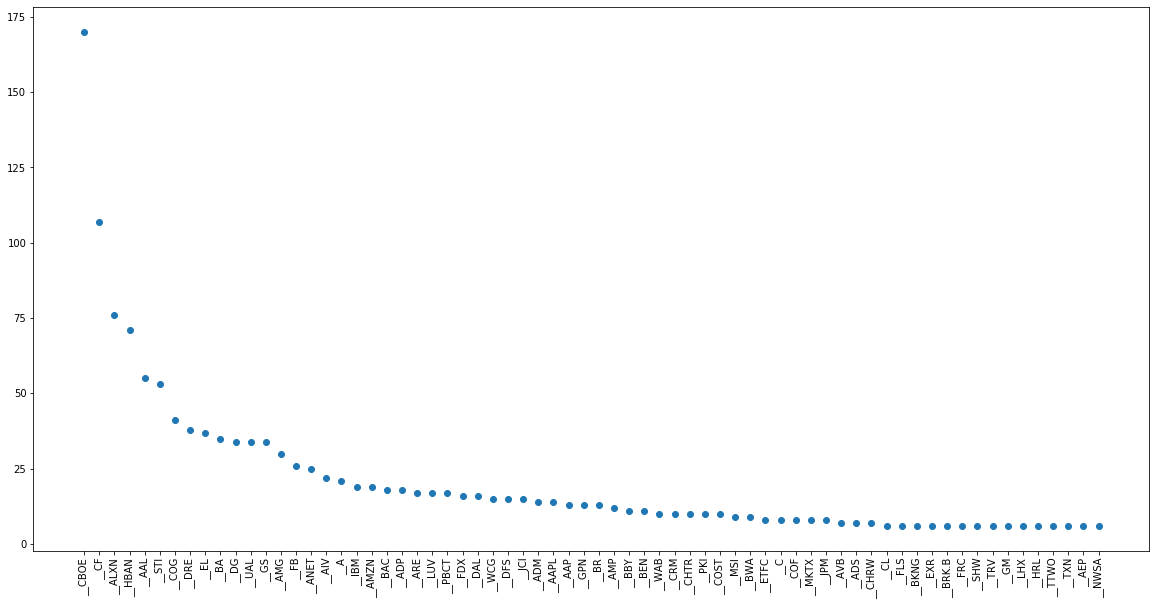

In [19]:
print(len(data))
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

tickers_list

from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
    

ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)
ticker_counts1 = ticker_counts[ticker_counts['counts']>5]
plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
#print(json.dumps(counts, indent = 2))
ticker_counts.head()
# plt.figure(figsize=(10,5))
# chart = sns.countplot(
#     data = ticker_counts,
#     x='tickers',
#     y = 'counts',
#     palette='Set1'
# )
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Clustering phrases vectors

In [20]:
relevant_data = [x for x in data if x['final_vector'] is not None]

In [21]:
# vocab = [x['final_vector'] for x in data if x['final_vector'] is not None]

vocab = [x['final_vector'] for x in relevant_data]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters = num_clusters)
kmeans.fit(vocab)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Mapping

In [26]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))
# print(centroids)

2059


In [27]:
for i in range(len(relevant_data)):
    relevant_data[i]['cluster_label'] = labels[i]

In [28]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [29]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [57]:
# clf.kneighbors([vocab[2]],n_neighbors)
print(type([vocab[2]]))

<class 'list'>


# Returns study

In [31]:
returnsdf = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/returns/returnsSP500.csv')
returnsdf

print(len(returnsdf.columns))
print('GOOG' in returnsdf.columns)

501
False


In [32]:
print(len(returnsdf.columns))
#print(returnsdf.columns[22:100])

501


In [33]:
params = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/SP500_parameters.csv')
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
# params.loc[50:100,'Ticker_b']


In [34]:
ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')

## Which industries are the most tackled by headlines 
##### in order to have enough data to study

Text(0, 0.5, 'Number of Articles')

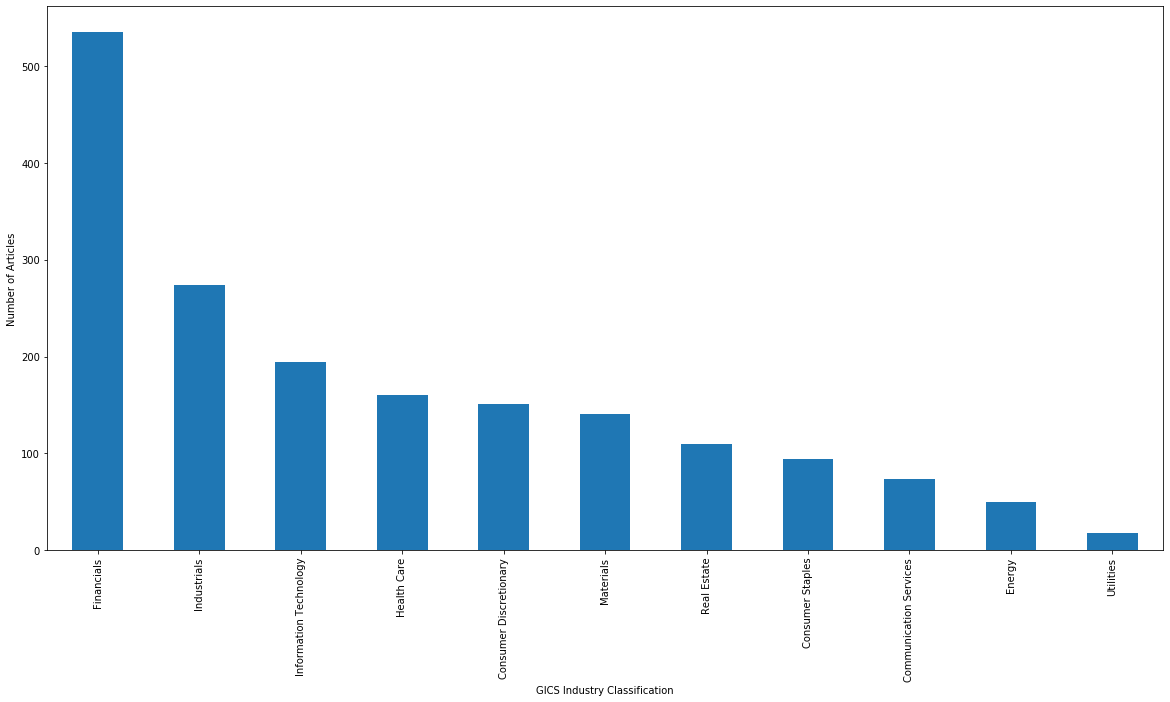

In [35]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)
# GICS_count
# plt.plot(GICS_count[('count','sum')])

plt.figure(figsize = [20,10])
# plt.plot(GICS_count[('count','sum')], marker = 'o')
GICS_count[('count','sum')].plot(kind='bar')
# plt.bar(GICS_count['count'], GICS_count['sum'])

plt.xlabel('GICS Industry Classification')
plt.ylabel('Number of Articles')

# plt.xticks(rotation = 'horizontal')

# GICS_count = GICS_count.sort_values(by = 'count', ascending = False)

In [36]:
industries = set(params['GICS'].values)

dataframe_industry_dict = {}
for industry in industries:
    industry_tickers = params.loc[params['GICS'] == industry, 'Ticker']
    industry_tickers = industry_tickers.str.replace('__','')
    industry_tickers = industry_tickers.str.replace('.','-')
    
    industry_tickers = list(set(industry_tickers) & set(returnsdf.columns))
    df_industry = returnsdf[industry_tickers + ['Date']]
    
    df_industry['market_exp'] = df_industry[industry_tickers].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]#.dropna()
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry = df_industry[cols]
    dataframe_industry_dict[industry] = df_industry
#print(len(healthy_ticker))

#print(len(df_health.columns))
# df_health
dataframe_industry_dict['Financials']


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Date  market_exp       PFG       BLK      PBCT       JPM  \
1     2000-01-04   -0.035024       NaN -0.045113 -0.002994 -0.027444   
2     2000-01-05   -0.006698       NaN -0.007874  0.006006 -0.006173   
3     2000-01-06    0.023833       NaN  0.015873 -0.008955  0.014197   
4     2000-01-07    0.021625       NaN -0.007812 -0.006024  0.018373   
5     2000-01-10   -0.013937       NaN  0.007874 -0.018182 -0.017182   
...          ...         ...       ...       ...       ...       ...   
5008  2019-11-27    0.004481  0.010432  0.006763  0.006109  0.002962   
5009  2019-11-29   -0.002879 -0.001992  0.001416  0.001822 -0.002272   
5010  2019-12-02   -0.008494 -0.022686 -0.010527 -0.011515 -0.002201   
5011  2019-12-03   -0.014515 -0.027855 -0.008046 -0.009810 -0.012855   
5012  2019-12-04    0.011593  0.013372  0.013669  0.011455  0.017491   

           AON       MCO       STI       COF  ...      NTRS        CB  \
1    -0.022436 -0.028902 -0.036715 -0.062246  ... -0.065015 -0.007663   
2     0.029508 -0.017857 -0.011033 -0.023088  ...  0.022517 -0.057915   
3     0.035032  0.000000  0.013185  0.045790  ...  0.020725  0.053279   
4     0.052308  0.024242 -0.002002  0.028249  ...  0.012690  0.128405   
5    -0.295322  0.000000 -0.045135 -0.012363  ... -0.025063  0.031034   
...        ...       ...       ...       ...  ...       ...       ...   
5008  0.005117 -0.000882  0.008506  0.010381  ...  0.008900  0.002043   
5009 -0.003231  0.000618 -0.004217 -0.002394  ... -0.004179 -0.003945   
5010 -0.009872 -0.006485 -0.005929 -0.007799  ... -0.006714 -0.011223   
5011 -0.007986 -0.001776 -0.022011 -0.010682  ... -0.011359 -0.002671   
5012  0.004375  0.004270  0.002033  0.011816  ...  0.012440  0.011983   

         BRK-B       SYF       PRU      ZION        RE       PGR       AMG  \
1    -0.034561       NaN       NaN -0.048423 -0.002857 -0.036251 -0.079932   
2     0.016432       NaN       NaN -0.001183  0.065903  0.023853 -0.024030   
3     0.041571       NaN       NaN  0.014218  0.045699 -0.003584  0.030303   
4     0.008869       NaN       NaN  0.002336  0.053985  0.017086  0.023897   
5    -0.003846       NaN       NaN -0.018065 -0.004878 -0.019452  0.025135   
...        ...       ...       ...       ...       ...       ...       ...   
5008  0.007309 -0.000267  0.000959  0.008256  0.001432  0.002742  0.003503   
5009 -0.000907  0.000803 -0.003194 -0.005792 -0.005499 -0.001230 -0.006748   
5010  0.000136 -0.007217 -0.007263 -0.005625 -0.009032 -0.019165 -0.021905   
5011 -0.010212 -0.008616 -0.027545 -0.018788 -0.011123 -0.013957 -0.020599   
5012  0.001172  0.019147  0.010168  0.014000  0.006696  0.012314  0.020665   

           PNC  
1    -0.031111  
2     0.004587  
3     0.047184  
4     0.001453  
5    -0.034833  
...        ...  
5008  0.002616  
5009 -0.000522  
5010 -0.008028  
5011 -0.014739  
5012  0.010084  

[5012 rows x 69 columns]

# LIBOR 3M importation

In [37]:
libor = pd.read_excel('/Users/macbookpro/Documents/GitHub/nlp/data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

Date  LIBOR 3M
0    2010-01-01  0.002506
1    2010-01-04  0.002544
2    2010-01-05  0.002525
3    2010-01-06  0.002500
4    2010-01-07  0.002494
...         ...       ...
2481 2019-07-08  0.023377
2482 2019-07-09  0.023407
2483 2019-07-10  0.023395
2484 2019-07-11  0.023034
2485 2019-07-12  0.023223

[2486 rows x 2 columns]

In [38]:
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date'] = pd.to_datetime(test['Date'])
    test = test.merge(libor,on = 'Date')
    
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test = test[cols]
    
    dataframe_industry_dict[industry] = test
    
dataframe_industry_dict['Financials']

LIBOR 3M       Date  market_exp       PFG       BLK      PBCT       JPM  \
0     0.002544 2010-01-04    0.018151  0.039933  0.027476  0.002994  0.028318   
1     0.002525 2010-01-05    0.010028  0.023600  0.004317  0.005970  0.019370   
2     0.002500 2010-01-06    0.003747 -0.006643 -0.020617 -0.000593  0.005494   
3     0.002494 2010-01-07    0.019587  0.008655  0.010994  0.004751  0.019809   
4     0.002512 2010-01-08    0.001277  0.001170  0.007039  0.004728 -0.002456   
...        ...        ...         ...       ...       ...       ...       ...   
2392  0.023377 2019-07-08   -0.008997 -0.009522 -0.013056 -0.010000 -0.005463   
2393  0.023407 2019-07-09    0.004561  0.003777  0.002921 -0.001783  0.004253   
2394  0.023395 2019-07-10   -0.005527 -0.006670  0.003630 -0.011309 -0.002911   
2395  0.023034 2019-07-11    0.006526  0.002410  0.009526  0.007224  0.009556   
2396  0.023223 2019-07-12    0.006617  0.015459  0.004978  0.007173  0.010517   

           AON       MCO       STI  ...      NTRS        CB     BRK-B  \
0    -0.010433  0.017537  0.007393  ...  0.002481 -0.022421  0.007608   
1    -0.006326 -0.010268  0.013699  ... -0.001333 -0.022529  0.004832   
2    -0.000265 -0.021119  0.027992  ... -0.014487 -0.013704 -0.005110   
3    -0.002918 -0.003028  0.059155  ...  0.009478  0.005684  0.003928   
4     0.008249  0.018983  0.019947  ...  0.004407 -0.005652 -0.000301   
...        ...       ...       ...  ...       ...       ...       ...   
2392 -0.005618 -0.019113 -0.006723  ... -0.023957 -0.001270 -0.000557   
2393  0.000407  0.002379  0.013222  ... -0.000873 -0.001205 -0.001766   
2394  0.006461  0.008685 -0.005437  ... -0.012774 -0.000670 -0.003353   
2395 -0.005965  0.009461  0.010622  ...  0.010175 -0.002347 -0.004018   
2396  0.004221  0.018100  0.001700  ...  0.000000  0.003831  0.004363   

           SYF       PRU      ZION        RE       PGR       AMG       PNC  
0          NaN  0.040394  0.038971 -0.002684  0.002224  0.022717  0.013639  
1          NaN  0.019703  0.035259 -0.014511 -0.003328  0.007985  0.010092  
2          NaN  0.011745  0.086957 -0.000356 -0.010017  0.019588  0.000000  
3          NaN  0.016102  0.112000  0.002019 -0.013491 -0.004520  0.054209  
4          NaN -0.013083 -0.016187 -0.001778  0.009117 -0.009224  0.002633  
...        ...       ...       ...       ...       ...       ...       ...  
2392  0.002527 -0.008468 -0.019260  0.000000 -0.004405 -0.016804 -0.005863  
2393  0.001681 -0.002749  0.013460  0.011316 -0.001674  0.010054  0.000355  
2394 -0.006711 -0.008268 -0.014152  0.003419 -0.000599  0.001548 -0.005256  
2395  0.003378  0.003871  0.012368 -0.005382  0.003836  0.005079  0.010068  
2396  0.008979  0.013546  0.011780  0.003270  0.007642 -0.013843  0.005160  

[2397 rows x 70 columns]

# Computation of abnormal returns

In [39]:
abret_dict = {}
for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    df_industry_capm = pd.DataFrame(df_returns['Date'])
#What do we choose for rf ?
#LIBOR overnight
    risk_free_rate = df_returns['LIBOR 3M']
    market = df_returns['market_exp']
    #print(df_returns.columns)
    for col in df_returns.columns[3:] :
        col = col.replace('-','.')
        #print(col)
        beta = params.loc[params['Ticker_b']==col]['Beta'].values[0]
        #print(beta)
        #print(type(beta))
    #print(beta)
        df_industry_capm[col] = risk_free_rate + beta*(market-risk_free_rate)
    abret_dict[industry] = df_industry_capm
    

abret_dict['Financials']

Date       PFG       BLK      PBCT       JPM       AON       MCO  \
0    2010-01-04  0.021055  0.021647  0.017470  0.018025  0.015356  0.021026   
1    2010-01-05  0.011424  0.011709  0.009701  0.009968  0.008685  0.011410   
2    2010-01-06  0.003979  0.004027  0.003693  0.003737  0.003524  0.003977   
3    2010-01-07  0.022767  0.023415  0.018840  0.019448  0.016525  0.022735   
4    2010-01-08  0.001047  0.001001  0.001331  0.001287  0.001498  0.001050   
...         ...       ...       ...       ...       ...       ...       ...   
2392 2019-07-08 -0.015020 -0.016246 -0.007582 -0.008734 -0.003198 -0.014959   
2393 2019-07-09  0.001054  0.000340  0.005384  0.004714  0.007936  0.001090   
2394 2019-07-10 -0.010908 -0.012004 -0.004264 -0.005292 -0.000347 -0.010854   
2395 2019-07-11  0.003454  0.002829  0.007247  0.006660  0.009482  0.003485   
2396 2019-07-12  0.003527  0.002898  0.007342  0.006752  0.009591  0.003558   

           STI       COF       CME  ...      NTRS        CB     BRK.B  \
0     0.017581  0.021765  0.008959  ...  0.021017  0.012201  0.016476   
1     0.009754  0.011766  0.005609  ...  0.011406  0.007168  0.009223   
2     0.003702  0.004036  0.003013  ...  0.003976  0.003272  0.003613   
3     0.018962  0.023544  0.009520  ...  0.022726  0.013070  0.017752   
4     0.001322  0.000991  0.002005  ...  0.001050  0.001748  0.001410   
...        ...       ...       ...  ...       ...       ...       ...   
2392 -0.007813 -0.016492  0.010071  ... -0.014941  0.003347 -0.005521   
2393  0.005249  0.000197  0.015661  ...  0.001100  0.011747  0.006584   
2394 -0.004470 -0.012224  0.011507  ... -0.010838  0.005500 -0.002423   
2395  0.007129  0.002704  0.016248  ...  0.003494  0.012820  0.008298   
2396  0.007224  0.002772  0.016397  ...  0.003568  0.012948  0.008399   

           SYF       PRU      ZION        RE       PGR       AMG       PNC  
0     0.018374  0.021706  0.018923  0.009646  0.016169  0.023074  0.017296  
1     0.010136  0.011737  0.010399  0.005940  0.009075  0.012395  0.009617  
2     0.003765  0.004031  0.003809  0.003068  0.003589  0.004141  0.003679  
3     0.019831  0.023479  0.020432  0.010272  0.017415  0.024978  0.018650  
4     0.001260  0.000996  0.001216  0.001950  0.001434  0.000888  0.001345  
...        ...       ...       ...       ...       ...       ...       ...  
2392 -0.009458 -0.016369 -0.010597  0.008645 -0.004884 -0.019208 -0.007223  
2393  0.004292  0.000269  0.003629  0.014831  0.006955 -0.001384  0.005593  
2394 -0.005940 -0.012114 -0.006957  0.010234 -0.001853 -0.014650 -0.003943  
2395  0.006290  0.002766  0.005709  0.015522  0.008623  0.001319  0.007430  
2396  0.006380  0.002835  0.005796  0.015666  0.008726  0.001379  0.007527  

[2397 rows x 68 columns]

In [41]:
# Define a lookup function to return, for a given ticker, 
# start_date and horizon, the cumulative average returns over that period

def lookup_cumul_returns(ticker, start_date, horizon):
    '''
    Args:
    start_date (pd.Timestamp)
    '''
    
    try:
        industry_classification = params.loc[params['Ticker_b'] == ticker, 'GICS'].values[0]
    except:
        print(ticker)
        return None
        
    relevant_df = abret_dict[industry_classification]
    
    start_index_values = relevant_df.loc[pd.to_datetime(relevant_df['Date']) >= pd.Timestamp(start_date),:].index.values
    
    if len(start_index_values) == 0:
        return None
    else:
        start_index = start_index_values[0]

    end_index = start_index + horizon
    
    if end_index > len(relevant_df):
        return None
    
    relevant_returns = relevant_df.loc[start_index + 1:end_index, ticker]
    
    return relevant_returns.cumsum().values[-1] / horizon
    
output = lookup_cumul_returns('A', '2010-01-04', 3)
print(output)

0.0017393766861903005


In [90]:
horizons = [3, 5, 10]

print(list(relevant_data[0].keys()))

# Add a column with the referenced ticker for each headline
for i, el in enumerate(relevant_data):
    lookup_col = el['Tick_Type']
    if lookup_col in ['sub', 'obj']:
        el['Ticker'] = el[lookup_col.capitalize()]
    else:
        el['Ticker'] = None
        
    relevant_data[i] = el
    
relevant_data = [x for x in relevant_data if x['Ticker'] is not None]
    
# {
#     3 {
#         'headlines': [(Sub, Verb, Obj), (), ...],
#         '3 day': [],
#         '5 day': []
#     }
# }

# Set up the data structure. Each entry looks like the above
cluster_labels = set([x['cluster_label'] for x in relevant_data])

cluster_sentiments = {}
for label in cluster_labels:
    cluster_sentiments[label] = {
        'svos': [],
        'headlines': [],
    }
    for horizon in horizons:
        cluster_sentiments[label]['{}_days'.format(horizon)] = []        

for el in relevant_data:
    svo = (el['Sub'], el['Verb'], el['Obj'])
    start_date = el['Date']
    ticker = el['Ticker'].replace('__', '')
    
    cluster_label = el['cluster_label']
    headline = el['Original Headline']
    
    cluster_sentiments[cluster_label]['svos'].append(svo)
    cluster_sentiments[cluster_label]['headlines'].append(headline)
    
    for horizon in horizons:
        horizon_cumul_returns = lookup_cumul_returns(ticker, start_date, horizon)
        cluster_sentiments[cluster_label]['{}_days'.format(horizon)].append(horizon_cumul_returns)

['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline', 'final_vector', 'cluster_label', 'Ticker']
CELG
CELG
CELG
CELG
CELG
CELG
HCP
HCP
HCP
BHGE
BHGE
BHGE
HCP
HCP
HCP


In [91]:
import copy

parsed_sentiments = copy.copy(cluster_sentiments)

for label in cluster_sentiments:
    for horizon in horizons:
        entries = cluster_sentiments[label]['{}_days'.format(horizon)]
        non_null_entries = [x for x in entries if x is not None]
        parsed_sentiments[label]['{}_days'.format(horizon)] = np.mean(non_null_entries)

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [112]:
print(json.dumps(parsed_sentiments[91], indent = 2))

{
  "svos": [
    [
      "SCHEMES",
      "REDUCED",
      "__AMG"
    ],
    [
      "__COG",
      "RISES",
      "SIGNS"
    ],
    [
      "JOB",
      "CUTS",
      "__AVB"
    ],
    [
      "__GM",
      "CUTS",
      "CHRYSLER"
    ],
    [
      "__GS",
      "INCREASES",
      "BREXIT"
    ],
    [
      "__MS",
      "CUTS",
      "ESTIMATES"
    ],
    [
      "ICELAND",
      "CHANGES",
      "__C"
    ],
    [
      "__COG",
      "RISES",
      "OUTLOOK"
    ],
    [
      "__COG",
      "RISES",
      "LOOMING"
    ],
    [
      "COMMUNITYS",
      "INCREASING",
      "__CAH"
    ],
    [
      "__MSI",
      "INCREASES",
      "DIVIDENDS"
    ],
    [
      "ADTRAN",
      "INCREASES",
      "__AAL"
    ],
    [
      "AZUL",
      "INCREASES",
      "__O"
    ],
    [
      "ORGANIZATION",
      "CHANGES",
      "__AIV"
    ],
    [
      "REPORTS",
      "IMPROVED",
      "__CF"
    ],
    [
      "AUTHORITY",
      "INCREASE",
      "__DFS"
    ],
    [
      "__C

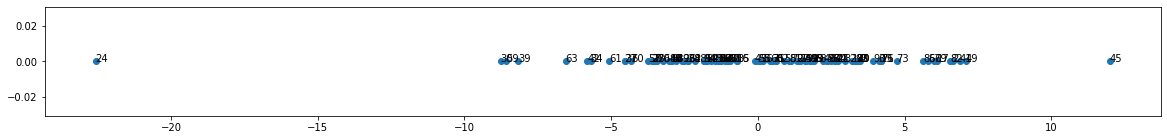

In [155]:
small_days_sentiment=[]
medium_days_sentiment = []
large_days_sentiment = []
for x in cluster_labels:
    small_days_sentiment.append(1000*parsed_sentiments[x]['3_days'])
    medium_days_sentiment.append(parsed_sentiments[x]['5_days'])
    large_days_sentiment.append(parsed_sentiments[x]['10_days'])
# print(list(cluster_labels))

fig,ax = plt.subplots(figsize = (20,2))
# fig(figsize = (20,20))

plt.scatter(small_days_sentiment,np.zeros(len(cluster_labels)))
label_graph=[str(list(cluster_labels)[i]) for i in range(len(cluster_labels))]

for i,txt in enumerate(label_graph):
    ax.annotate(txt,(small_days_sentiment[i],np.zeros(len(cluster_labels))[i]))


## FORECASTING

In [93]:
def clean(headlines, stopwords):
    '''
    Args:
    headlines: pd.Series
    '''
    
    headlines.replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','', inplace = True, regex=True)
    extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

    stopwords = stopwords.union(set(extensions_list))

    wordlist = filter(None, " ".join(list(set(list(itertools.chain(*headlines.str.split(' ')))))).split(" "))

    headlines = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in headlines.str.lower().str.split(' ')]
    
    return headlines

In [110]:
def closest_cluster(headline, clusters, tickers):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    '''
    
    n_neighors = 5
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {}
    
    headline_sentiment = {
        '3_days': [],
        '5_days': [],
        '10_days': []
    }
    
    
    
    print(ticker_info)
    if len(ticker_info) != 0:
        for ls in ticker_info:
            ticker_key = ls[3]

            if ticker_key == 'obj':
                ticker = ls[2]
                svo = [ls[0],ls[1]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]
#                 close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
#                 cluster_list = [labels[neigh[1][0][i]] for i in range(n_neighbors)]
                
            if ticker_key == 'sub':
                ticker = ls[0]
                svo = [ls[1],ls[2]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]
                
                
            close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
            clusters_list = [labels[neigh[1][0][i]] for i in range(n_neighors)]
            
            for horizon in horizons:
                for cluster in clusters_list:
                    headline_sentiment['{}_days'.format(horizon)].append(parsed_sentiments[cluster]['{}_days'.format(horizon)])
                headline_sentiment['{}_days'.format(horizon)] = np.mean(headline_sentiment['{}_days'.format(horizon)]) 
             

                
    return headline_sentiment



In [111]:
nlp = spacy.load('en_core_web_sm')
fake_news = 'Conor cuts investment'

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
# def parse_header1(header,tickers,orig):
# parsed_words.append([sub, verb, obj, tick, header, orig])

# print(closest_cluster(fake_news, parsed_sentiments, tickers))
# svo_vec = [np.concatenate((model.wv['CUTS'], model.wv['BANK']))]
# tested_news = "Food for thought: investing in the future of food"


dictionary = closest_cluster(fake_news, parsed_sentiments, tickers)

print(dictionary)


# print(type(model.wv['CUTS']))
# neigh = clf.kneighbors(svo_vec,n_neighbors)
# print(neigh[1][0])
print([labels[neigh[1][0][i]] for i in range(5)])
# print(labels)

nlp header conor cuts investment
<class 'spacy.tokens.doc.Doc'>
tokens [(conor, cuts, investment)]
[['conor', 'cuts', '__AIV', 'obj', 'conor cuts investment', None]]
{'3_days': -0.0009721552318046096, '5_days': -0.0014674367010313466, '10_days': 0.00032558238046471614}
[91, 91, 91, 91, 91]
